### Test on machine learning models
* generate ROC curves, confusion matrices, and permutation importance files for lr,rf,and xgboost

In [1]:
import pandas as pd
import numpy as np
from joblib import dump, load
import os
import os.path as osp
from copy import deepcopy
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
%load_ext autoreload
%autoreload 2
%matplotlib inline

ds_name = 'preprocessed_data'
split_rs = '123'
ds_folder = f'../data/{ds_name}/split_rs{split_rs}'
for dirname, _, filenames in os.walk(ds_folder):
    for filename in filenames:
        print(os.path.join(dirname, filename))

../data/preprocessed_data/split_rs123\test.csv
../data/preprocessed_data/split_rs123\test_edge.csv
../data/preprocessed_data/split_rs123\train.csv
../data/preprocessed_data/split_rs123\train_edge.csv
../data/preprocessed_data/split_rs123\valid.csv
../data/preprocessed_data/split_rs123\valid_edge.csv


In [2]:
train_df = pd.read_csv(f'{ds_folder}/train.csv')
valid_df = pd.read_csv(f'{ds_folder}/valid.csv')
train_df = pd.concat([train_df,valid_df])

In [3]:
# get label weights
from collections import Counter
node_label = train_df['dynamic_cat'].values
label_counter = Counter(node_label)
n_samples = len(node_label)
n_classes = len(label_counter)

In [4]:
label_weight = {}
for i in range(n_classes-1):
    label_weight[i] = n_samples / (n_classes * label_counter[i])

In [5]:
label_weight

{0: 2.218683883011823, 1: 18.201074345646926, 2: 20.642244620219852}

In [6]:
test_df = pd.read_csv(f'{ds_folder}/test.csv')
test_df = test_df[test_df['cluster_id'] != 'Background']

In [7]:
test_df

,sim,cluster_id,state,dynamic,dynamic_model,v_sampling_fraction,v_cluster_size,v_timespan,gamma,oster,...,v_cluster_size-norm,v_timespan-norm,oster-norm,PD-norm,abs_growth_rate-norm,fraction_time_growth-norm,r_max-norm,cherries-norm,BLD-norm,new_R0-norm
0,10004,c1,A,static,0.000000,0.637237,85.0,19.0,-1.470588,19.021595,...,0.275629,-0.302254,-0.363586,-0.514861,-0.004706,0.109357,0.025031,0.765185,0.479894,2.246717
1,10004,c1,A,static,0.000000,0.637237,85.0,19.0,-1.470588,19.021595,...,0.275629,-0.302254,-0.363586,-0.514861,-0.004706,0.109357,0.025031,0.765185,0.479894,2.246717
2,10004,c1,A,static,0.000000,0.637237,85.0,19.0,-1.470588,19.021595,...,0.275629,-0.302254,-0.363586,-0.514861,-0.004706,0.109357,0.025031,0.765185,0.479894,2.246717
3,10004,c1,A,static,0.000000,0.637237,85.0,19.0,-1.470588,19.021595,...,0.275629,-0.302254,-0.363586,-0.514861,-0.004706,0.109357,0.025031,0.765185,0.479894,2.246717
4,10004,c1,A,static,0.000000,0.637237,85.0,19.0,-1.470588,19.021595,...,0.275629,-0.302254,-0.363586,-0.514861,-0.004706,0.109357,0.025031,0.765185,0.479894,2.246717
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
380227,9981,c5,G,decay,0.384715,0.895402,8.0,7.0,1.072222,7.047619,...,-0.885820,-1.174141,-1.193402,-0.988793,-0.004706,1.757508,0.024984,3.175728,-2.222487,3.949830
380228,9981,c5,G,decay,0.384715,0.895402,8.0,7.0,1.072222,7.047619,...,-0.885820,-1.174141,-1.193402,-0.988793,-0.004706,1.757508,0.024984,3.175728,-2.222487,3.949830
380229,9981,c5,G,decay,0.384715,0.895402,8.0,7.0,1.072222,7.047619,...,-0.885820,-1.174141,-1.193402,-0.988793,-0.004706,1.757508,0.024984,3.175728,-2.222487,3.949830
380230,9981,c5,G,decay,0.384715,0.895402,8.0,7.0,1.072222,7.047619,...,-0.885820,-1.174141,-1.193402,-0.988793,-0.004706,1.757508,0.024984,3.175728,-2.222487,3.949830


In [8]:
import json
js_f = osp.join('../aly/feat_dict.json')

with open(js_f, 'r') as f:
    feat_desc = json.load(f)

input_feat = feat_desc['norm_onehot_feats']
print(f'Inputs: {len(input_feat)}, {input_feat}')
label_feat = 'dynamic_cat'

label_map = feat_desc['dynamic']
label_map = {int(k): v for k, v in label_map.items()}
print(label_map)

Inputs: 16, ['oster-norm', 'PD-norm', 'abs_growth_rate-norm', 'fraction_time_growth-norm', 'r_max-norm', 'cherries-norm', 'BLD-norm', 'new_R0-norm', 'ltt_shape_cat_0', 'ltt_shape_cat_1', 'ltt_shape_cat_2', 'ltt_shape_cat_3', 'gamma_cat_0', 'gamma_cat_1', 'gamma_cat_2', 'gamma_cat_3']
{0: 'static', 1: 'decay', 2: 'growth', 3: 'bg'}


In [9]:
x_test = test_df[input_feat]
y_test = test_df[label_feat]

In [10]:
# Onehot the label
from sklearn.preprocessing import label_binarize
from sklearn.metrics import auc, roc_auc_score, roc_curve, brier_score_loss, log_loss
from scipy.special import softmax
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.model_selection import KFold, cross_validate, cross_val_score, GroupKFold
from sklearn.metrics import log_loss
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, balanced_accuracy_score


classes = np.unique(y_test)
n_classes = len(classes)
label_encode_dict = feat_desc['dynamic']

y_test_onehot = label_binarize(y_test, classes=classes)
            
def get_fpr_tpr(n_classes, y_test_onehot, y_test_predscore):    
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_onehot[:, i], y_test_predscore[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    # Micro-average: Calculate metrics globally by considering each element of the label indicator matrix as a label.
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test_onehot.ravel(), y_test_predscore.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    return fpr, tpr, roc_auc

def plot_roc(n_classes, fpr, tpr, roc_auc):
    fig, axs = plt.subplots(1, 3, figsize=(25, 6))
    lw = 2

    for i, class_id in enumerate(range(n_classes)):
        ax = axs[i]
        ax.plot(fpr[class_id], tpr[class_id], color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[class_id])
        ax.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        ax.set_xlabel('False Positive Rate', fontsize=25)
        ax.set_ylabel('True Positive Rate', fontsize=25)
        if i != 0:
            ax.set_ylabel('')
        ax.set_title(f'ROC for {label_encode_dict[str(class_id)]}-{class_id}')
        ax.legend(loc="lower right")
    plt.show()    
        
def cal_auc(y_test_onehot, y_test_predscore, metric_dict):
    macro_roc_auc_ovo = roc_auc_score(y_test_onehot, y_test_predscore, multi_class="ovo",
                                  average="macro")
    # 'weighted': Calculate metrics for each label, and find their average, 
    # weighted by support (the number of true instances for each label).
    weighted_roc_auc_ovo = roc_auc_score(y_test_onehot, y_test_predscore, multi_class="ovo",
                                         average="weighted") 
    macro_roc_auc_ovr = roc_auc_score(y_test_onehot, y_test_predscore, multi_class="ovr",
                                      average="macro")
    weighted_roc_auc_ovr = roc_auc_score(y_test_onehot, y_test_predscore, multi_class="ovr",
                                         average="weighted")
    print("One-vs-One ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
          "(weighted by prevalence)"
          .format(macro_roc_auc_ovo, weighted_roc_auc_ovo))
    print("One-vs-Rest ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
          "(weighted by prevalence)"
          .format(macro_roc_auc_ovr, weighted_roc_auc_ovr))
    
    metric_dict['macro_auc_ovo'] = macro_roc_auc_ovo
    metric_dict['weighted_auc_ovo'] = weighted_roc_auc_ovo
    metric_dict['macro_auc_ovr'] = macro_roc_auc_ovr
    metric_dict['weighted_auc_ovr'] = weighted_roc_auc_ovr

In [11]:
from numpy import interp
from itertools import cycle

def plot_merged_roc(n_classes, fpr, tpr, roc_auc, model_name):
    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    lw=2
    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    # Calculate metrics for each label, and find their unweighted mean (by linear interpolation). 
    # This does not take label imbalance into account.
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
    
    # Plot all ROC curves
    plt.figure(figsize=(8, 8))
    plt.plot(fpr["micro"], tpr["micro"],
             label='micro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["micro"]),
             color='deeppink', linestyle=':', linewidth=4)

    plt.plot(fpr["macro"], tpr["macro"],
             label='macro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["macro"]),
             color='navy', linestyle=':', linewidth=4)

    colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                 ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Extension of Receiver operating characteristic to multi-class')
    plt.legend(loc="lower right")
    plt.show()
    
    roc = pd.DataFrame(columns=['fpr','tpr'])
    roc['fpr'] = fpr["macro"]
    roc['tpr'] = tpr["macro"]
    if not Path(f"./ROC").exists():
        os.mkdir(f"./ROC")
    roc.to_csv(f'./ROC/roc_{model_name}.csv',index=False)
    

In [12]:
def brier_score(y_test_onehot, y_test_prob):
    N = y_test_onehot.shape[0]
    brier = sum(sum((y_test_onehot-y_test_prob)**2))/N
    return brier

In [13]:
def cal_basic_metric(y_test, y_test_pred, y_test_onehot, y_test_predscore, metric_dict):
    acc = accuracy_score(y_test, y_test_pred)
    print(f'Test Acc: {acc}')

    bal_acc = balanced_accuracy_score(y_test, y_test_pred)
    print(f'Test Ballance Acc: {bal_acc}')

    f1_weighted = f1_score(y_test, y_test_pred, average='weighted')
    print(f'Test Weighted F1: {f1_weighted}')
    f1_macro = f1_score(y_test, y_test_pred, average='macro')
    print(f'Test F1: {f1_macro}')
    
    brier = brier_score(y_test_onehot, y_test_predscore)
    print(f'Brier Score: {brier}')
    
    ce = log_loss(y_test, y_test_predscore)
    print(f'Cross Entropy Loss: {ce}')
    
    metric_dict['acc'] = acc
    metric_dict['balance_acc'] = bal_acc
    metric_dict['f1_weighted'] = f1_weighted
    metric_dict['f1_macro'] = f1_macro
    metric_dict['brier_score'] = brier
    metric_dict['cross_entropy'] = ce

In [14]:
def eval_classifer(model, x_test, y_test, metric_dict, roc_flag=False,model_name=None):
    y_test_pred = model.predict(x_test)
    y_test_predscore = model.predict_proba(x_test)
    y_test_onehot = label_binarize(y_test, classes=classes)
    
    cal_basic_metric(y_test, y_test_pred, y_test_onehot, y_test_predscore, metric_dict)
    cal_auc(y_test_onehot, y_test_predscore, metric_dict)
    
    fpr, tpr, roc_auc = get_fpr_tpr(n_classes, y_test_onehot, y_test_predscore)
    if roc_flag:
        plot_merged_roc(n_classes, fpr, tpr, roc_auc,model_name)

In [16]:
def eval_xgb_classifer(model, d_test, x_test, y_test, metric_dict, model_name, roc_flag=False):
    y_test_predscore = model.predict(d_test)
    y_test_pred = np.argmax(y_test_predscore,axis=1)
    y_test_onehot = label_binarize(y_test, classes=classes)
    
    cal_basic_metric(y_test, y_test_pred, y_test_onehot, y_test_predscore, metric_dict)
    cal_auc(y_test_onehot, y_test_predscore, metric_dict)
    fpr, tpr, roc_auc = get_fpr_tpr(n_classes, y_test_onehot, y_test_predscore)
    if roc_flag:
        plot_merged_roc(n_classes, fpr, tpr, roc_auc,model_name)

In [17]:
def get_misclass(y_true, y_pred):
    mis_id_dict = defaultdict(dict)
    mis_ids = y_true != y_pred
    print(f'Total Mis: {sum(mis_ids)}, ({100 * sum(mis_ids) / len(y_true):.3f}%)')
    
    print(label_map)
    for i in range(len(label_map)):
        label_ids = y_true == i
        sub_mis_id_dict = defaultdict(list)
        
        for idx, (label_id, mis_id) in enumerate(zip(label_ids, mis_ids)):
            if label_id and mis_id:
                sub_mis_id_dict[y_pred[idx]].append(idx)
        
        n_mis = sum([len(mis_lst) for mis_lst in sub_mis_id_dict.values()])
        n_sample = sum(label_ids)
        
        print(f'Mis-classified of {label_map[i]}: {n_mis}/{n_sample}, ({100 * n_mis / n_sample:.3f}%)')
        for mis_label, mis_lst in sub_mis_id_dict.items():
            print(f'\t{mis_label}: {len(mis_lst)}')
        
        mis_id_dict[i] = sub_mis_id_dict
    return mis_id_dict

In [18]:
from base_model import Sfmx
from collections import defaultdict
model_folder = f'../checkpoints/{ds_name}/split_rs{split_rs}'
os.makedirs(model_folder, exist_ok=True)
sfmx_model_dict = load(osp.join(model_folder, f'sfmx.joblib'))

In [19]:
sfmx_model_dict

{'org': LogisticRegression(C=1000.0,
                    class_weight={0: 2.218683883011823, 1: 18.201074345646926,
                                  2: 20.642244620219852},
                    max_iter=5000, multi_class='multinomial',
                    solver='newton-cg')}

In [20]:
y_test_pred = sfmx_model_dict['org'].predict(x_test)
y_test_predscore = sfmx_model_dict['org'].predict_proba(x_test)
y_test_arr = y_test.values

mis_id_dict = get_misclass(y_test_arr, y_test_pred)

Total Mis: 167613, (44.082%)
{0: 'static', 1: 'decay', 2: 'growth', 3: 'bg'}
Mis-classified of static: 131096/310152, (42.268%)
	1: 41791
	2: 89305
Mis-classified of decay: 27947/36355, (76.873%)
	0: 8328
	2: 19619
Mis-classified of growth: 8570/33725, (25.411%)
	1: 6526
	0: 2044
Mis-classified of bg: 0/0, (nan%)


<ipython-input-17-5f26f74df7e4>:18: RuntimeWarning: invalid value encountered in long_scalars
  print(f'Mis-classified of {label_map[i]}: {n_mis}/{n_sample}, ({100 * n_mis / n_sample:.3f}%)')


In [21]:
from sklearn.metrics import confusion_matrix
#conf_mat = confusion_matrix(y_test_arr, y_test_pred)
cm = pd.DataFrame(columns=['true','predict'])
cm['true'] = y_test_arr
cm['predict'] = y_test_pred
if not Path(f"./cm").exists():
    os.mkdir(f"./cm")
cm.to_csv(f"../test/cm/cm_lr.csv",index=False)

Test Acc: 0.5591822887079467
Test Ballance Acc: 0.5181592325443685
Test Weighted F1: 0.6285747863735278
Test F1: 0.39910066635044017
Brier Score: 0.5365629674236686
Cross Entropy Loss: 0.9239274297336811
One-vs-One ROC AUC scores:
0.722178 (macro),
0.739510 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.722178 (macro),
0.739510 (weighted by prevalence)


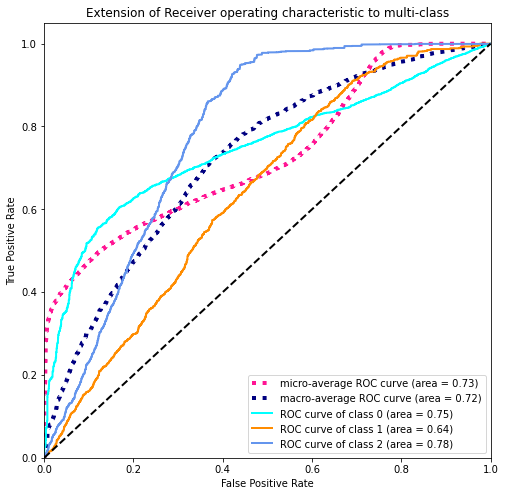

In [22]:
sfmx_metric_dict = defaultdict(list)
eval_classifer(sfmx_model_dict['org'], x_test, y_test, sfmx_metric_dict,True,'lr')

In [23]:
sfmx_metric_dict

defaultdict(list,
            {'acc': 0.5591822887079467,
             'balance_acc': 0.5181592325443685,
             'f1_weighted': 0.6285747863735278,
             'f1_macro': 0.39910066635044017,
             'brier_score': 0.5365629674236686,
             'cross_entropy': 0.9239274297336811,
             'macro_auc_ovo': 0.7221781950453131,
             'weighted_auc_ovo': 0.7395104703804541,
             'macro_auc_ovr': 0.7221781950453131,
             'weighted_auc_ovr': 0.7395104703804541})

In [54]:
import csv
with open(f"../test/lr50/None-test.csv",'a',newline="") as f:
    w = csv.writer(f)
    row = list(sfmx_metric_dict.values())
    w.writerow(row)

In [31]:
feat_col = feat_desc['norm_onehot_feats'][0:8]
feat_col.append('ltt_shape_cat')
feat_col.append('gamma_cat')

In [32]:
feat_col

['oster-norm',
 'PD-norm',
 'abs_growth_rate-norm',
 'fraction_time_growth-norm',
 'r_max-norm',
 'cherries-norm',
 'BLD-norm',
 'new_R0-norm',
 'ltt_shape_cat',
 'gamma_cat']

In [33]:
def perm_impt(model,x_test,y_test,metric_dict,feat):
    if feat in ['ltt_shape_cat', 'gamma_cat']:
        shuffle_cols = pd.DataFrame(x_test, columns=[feat+'_0',feat+'_1',feat+'_2',feat+'_3']).values
        np.random.shuffle(shuffle_cols)
        for i in range(4):
            x_test[feat+'_'+str(i)] = shuffle_cols[:,i]
    else:
        shuffle_col = x_test[feat].values
        np.random.shuffle(shuffle_col)
        x_test[feat] = shuffle_col
    eval_classifer(model, x_test, y_test, metric_dict)

In [34]:
for shuffle_feat in feat_col:
    for i in range(50):
        x_test = test_df[input_feat]
        sfmx_metric_dict = defaultdict(list)
        perm_impt(sfmx_model_dict['org'],x_test,y_test,sfmx_metric_dict,shuffle_feat)
        with open(f"../test/lr50/{shuffle_feat}-test.csv",'a',newline="") as f:
            w = csv.writer(f)
            row = list(sfmx_metric_dict.values())
            w.writerow(row)

<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5536514549012183
Test Ballance Acc: 0.4484982015226338
Test Weighted F1: 0.6266203943997349
Test F1: 0.3815146273052546
Brier Score: 0.5401197153997644
Cross Entropy Loss: 0.9231411130757731
One-vs-One ROC AUC scores:
0.671293 (macro),
0.694523 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.671293 (macro),
0.694523 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5537724336720738
Test Ballance Acc: 0.44864645617989485
Test Weighted F1: 0.6267232607303005
Test F1: 0.3816233250429751
Brier Score: 0.5403959621521603
Cross Entropy Loss: 0.9236279671887733
One-vs-One ROC AUC scores:
0.670671 (macro),
0.693876 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.670671 (macro),
0.693876 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5536383050348208
Test Ballance Acc: 0.4493279504033243
Test Weighted F1: 0.6264781173229516
Test F1: 0.3818642997266844
Brier Score: 0.5400540963039143
Cross Entropy Loss: 0.9230900317300216
One-vs-One ROC AUC scores:
0.671593 (macro),
0.694598 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.671593 (macro),
0.694598 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5536514549012183
Test Ballance Acc: 0.4475220762013012
Test Weighted F1: 0.6265548666936995
Test F1: 0.38101996082991385
Brier Score: 0.5403007613154662
Cross Entropy Loss: 0.9235536851028786
One-vs-One ROC AUC scores:
0.670923 (macro),
0.693831 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.670923 (macro),
0.693831 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.553249068989459
Test Ballance Acc: 0.4477330583701899
Test Weighted F1: 0.626251030070871
Test F1: 0.38093067271120873
Brier Score: 0.5406425558480605
Cross Entropy Loss: 0.9240244974808453
One-vs-One ROC AUC scores:
0.670042 (macro),
0.693256 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.670042 (macro),
0.693256 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5531096804056471
Test Ballance Acc: 0.4483535407556623
Test Weighted F1: 0.6262566240290438
Test F1: 0.3813314442055187
Brier Score: 0.5401072056782441
Cross Entropy Loss: 0.9229729900227068
One-vs-One ROC AUC scores:
0.671093 (macro),
0.694780 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.671093 (macro),
0.694780 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5539091922826064
Test Ballance Acc: 0.44946038506964237
Test Weighted F1: 0.6266537025117669
Test F1: 0.38203247036217486
Brier Score: 0.540259173131526
Cross Entropy Loss: 0.923604187846863
One-vs-One ROC AUC scores:
0.671383 (macro),
0.693684 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.671383 (macro),
0.693684 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5530833806728523
Test Ballance Acc: 0.448281301589339
Test Weighted F1: 0.6260467965148965
Test F1: 0.3812385174788802
Brier Score: 0.5402467309782866
Cross Entropy Loss: 0.9233427762053917
One-vs-One ROC AUC scores:
0.670882 (macro),
0.693960 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.670882 (macro),
0.693960 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5534594668518168
Test Ballance Acc: 0.44785673330000964
Test Weighted F1: 0.6264351363351555
Test F1: 0.3811924764316579
Brier Score: 0.5402065318198948
Cross Entropy Loss: 0.9231788788323706
One-vs-One ROC AUC scores:
0.670833 (macro),
0.694227 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.670833 (macro),
0.694227 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5529676618485556
Test Ballance Acc: 0.4472786232161303
Test Weighted F1: 0.6260641324349505
Test F1: 0.380669130288813
Brier Score: 0.5403653660111866
Cross Entropy Loss: 0.9234005776855932
One-vs-One ROC AUC scores:
0.670868 (macro),
0.694185 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.670868 (macro),
0.694185 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5543641776599549
Test Ballance Acc: 0.4495201276094627
Test Weighted F1: 0.6270848631448478
Test F1: 0.38223179776192356
Brier Score: 0.5404659059096906
Cross Entropy Loss: 0.9238535824090921
One-vs-One ROC AUC scores:
0.670765 (macro),
0.693507 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.670765 (macro),
0.693507 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5537303540996024
Test Ballance Acc: 0.44791311854938826
Test Weighted F1: 0.6267071388082956
Test F1: 0.38127165391849244
Brier Score: 0.5397751435339635
Cross Entropy Loss: 0.9224107360712733
One-vs-One ROC AUC scores:
0.672288 (macro),
0.694814 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.672288 (macro),
0.694814 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5533621578404764
Test Ballance Acc: 0.44817296463055406
Test Weighted F1: 0.6263745437764422
Test F1: 0.3813240181410779
Brier Score: 0.5400991714685772
Cross Entropy Loss: 0.9231164939761755
One-vs-One ROC AUC scores:
0.671483 (macro),
0.694215 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.671483 (macro),
0.694215 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5536251551684235
Test Ballance Acc: 0.4494423293108865
Test Weighted F1: 0.6265974104405786
Test F1: 0.38189599506927174
Brier Score: 0.5401347013569981
Cross Entropy Loss: 0.9232428011513979
One-vs-One ROC AUC scores:
0.671269 (macro),
0.694600 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.671269 (macro),
0.694600 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5534068673862274
Test Ballance Acc: 0.44758237672217877
Test Weighted F1: 0.6262825312469161
Test F1: 0.38098580852501346
Brier Score: 0.5404941855619336
Cross Entropy Loss: 0.9239968985595836
One-vs-One ROC AUC scores:
0.670240 (macro),
0.693281 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.670240 (macro),
0.693281 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5540643607060952
Test Ballance Acc: 0.449076216881926
Test Weighted F1: 0.6269457351957354
Test F1: 0.381936387199296
Brier Score: 0.5400819200847939
Cross Entropy Loss: 0.9231429320932294
One-vs-One ROC AUC scores:
0.671461 (macro),
0.694830 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.671461 (macro),
0.694830 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5533700477603147
Test Ballance Acc: 0.4484616275017727
Test Weighted F1: 0.6263417871662663
Test F1: 0.38151708981999727
Brier Score: 0.5399576000351488
Cross Entropy Loss: 0.922616777227782
One-vs-One ROC AUC scores:
0.671467 (macro),
0.694719 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.671467 (macro),
0.694719 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.553995981400829
Test Ballance Acc: 0.4476032048574187
Test Weighted F1: 0.6271000176147312
Test F1: 0.38126035119206964
Brier Score: 0.5399561653351382
Cross Entropy Loss: 0.92276557867412
One-vs-One ROC AUC scores:
0.671341 (macro),
0.695287 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.671341 (macro),
0.695287 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5530860106461318
Test Ballance Acc: 0.44761671536686665
Test Weighted F1: 0.6260695759208983
Test F1: 0.38090412469434326
Brier Score: 0.5405685481090963
Cross Entropy Loss: 0.9239669488471732
One-vs-One ROC AUC scores:
0.670230 (macro),
0.693191 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.670230 (macro),
0.693191 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5531701697910749
Test Ballance Acc: 0.44880069852849286
Test Weighted F1: 0.6261101632438641
Test F1: 0.38141597016030765
Brier Score: 0.5404686960375622
Cross Entropy Loss: 0.9237172332432608
One-vs-One ROC AUC scores:
0.670618 (macro),
0.693379 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.670618 (macro),
0.693379 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5533332281344021
Test Ballance Acc: 0.4483986179867124
Test Weighted F1: 0.62620447251642
Test F1: 0.3813298730008286
Brier Score: 0.5405260616452005
Cross Entropy Loss: 0.9238202872016936
One-vs-One ROC AUC scores:
0.670903 (macro),
0.693086 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.670903 (macro),
0.693086 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5532175093101054
Test Ballance Acc: 0.4482287166473513
Test Weighted F1: 0.6262243074611334
Test F1: 0.38123580570787924
Brier Score: 0.5402512029630318
Cross Entropy Loss: 0.9234155711891929
One-vs-One ROC AUC scores:
0.671183 (macro),
0.693859 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.671183 (macro),
0.693859 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5535252161838036
Test Ballance Acc: 0.44736720982704786
Test Weighted F1: 0.6265410643145102
Test F1: 0.3809524425464171
Brier Score: 0.5405105344922201
Cross Entropy Loss: 0.924048287335997
One-vs-One ROC AUC scores:
0.669911 (macro),
0.693738 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.669911 (macro),
0.693738 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5531017904858087
Test Ballance Acc: 0.4470304065429132
Test Weighted F1: 0.6260928644640011
Test F1: 0.3807140030998036
Brier Score: 0.5403058909117097
Cross Entropy Loss: 0.9232595446179526
One-vs-One ROC AUC scores:
0.670387 (macro),
0.694017 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.670387 (macro),
0.694017 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5531964695238696
Test Ballance Acc: 0.44729361543995
Test Weighted F1: 0.6264616146130432
Test F1: 0.3808279396576131
Brier Score: 0.5402268318842197
Cross Entropy Loss: 0.9233448055380258
One-vs-One ROC AUC scores:
0.670546 (macro),
0.694521 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.670546 (macro),
0.694521 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5525915756695912
Test Ballance Acc: 0.44579484274891074
Test Weighted F1: 0.6259049913087517
Test F1: 0.3799241704212944
Brier Score: 0.540319445993868
Cross Entropy Loss: 0.9234229414753141
One-vs-One ROC AUC scores:
0.670230 (macro),
0.694040 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.670230 (macro),
0.694040 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5543457678469986
Test Ballance Acc: 0.4499231432351382
Test Weighted F1: 0.6271153341622298
Test F1: 0.38254431445505827
Brier Score: 0.539688726390185
Cross Entropy Loss: 0.9225138321395081
One-vs-One ROC AUC scores:
0.672451 (macro),
0.695455 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.672451 (macro),
0.695455 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5536435649813798
Test Ballance Acc: 0.44803813245994384
Test Weighted F1: 0.6265462640163633
Test F1: 0.3813178103973023
Brier Score: 0.5402702847824039
Cross Entropy Loss: 0.9233066743397454
One-vs-One ROC AUC scores:
0.670885 (macro),
0.694096 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.670885 (macro),
0.694096 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5530597109133372
Test Ballance Acc: 0.4468163210128391
Test Weighted F1: 0.6264367239277616
Test F1: 0.38053979437801844
Brier Score: 0.540113485827361
Cross Entropy Loss: 0.9228291254594347
One-vs-One ROC AUC scores:
0.671273 (macro),
0.695238 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.671273 (macro),
0.695238 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5538802625765322
Test Ballance Acc: 0.44898742795023305
Test Weighted F1: 0.6268869692790768
Test F1: 0.38187798692659486
Brier Score: 0.5400666544369697
Cross Entropy Loss: 0.9231403760566812
One-vs-One ROC AUC scores:
0.670785 (macro),
0.694956 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.670785 (macro),
0.694956 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5540485808664184
Test Ballance Acc: 0.4501377605763428
Test Weighted F1: 0.6268898525541973
Test F1: 0.38243552919849777
Brier Score: 0.54031067746278
Cross Entropy Loss: 0.9236048507015886
One-vs-One ROC AUC scores:
0.670979 (macro),
0.693966 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.670979 (macro),
0.693966 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5535646657829957
Test Ballance Acc: 0.447519757917857
Test Weighted F1: 0.6264674287529797
Test F1: 0.3810707374417344
Brier Score: 0.5401151727083154
Cross Entropy Loss: 0.9231054458564146
One-vs-One ROC AUC scores:
0.670947 (macro),
0.694333 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.670947 (macro),
0.694333 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5532332891497822
Test Ballance Acc: 0.4480461690452251
Test Weighted F1: 0.6262515136768787
Test F1: 0.3811804837027655
Brier Score: 0.5405281331163599
Cross Entropy Loss: 0.9237789558445283
One-vs-One ROC AUC scores:
0.670835 (macro),
0.692950 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.670835 (macro),
0.692950 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5538250331376633
Test Ballance Acc: 0.44955052221074504
Test Weighted F1: 0.626716926477634
Test F1: 0.38213010254500723
Brier Score: 0.5400775623866932
Cross Entropy Loss: 0.9230682729996532
One-vs-One ROC AUC scores:
0.671049 (macro),
0.694441 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.671049 (macro),
0.694441 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.554319468114204
Test Ballance Acc: 0.44963353608150913
Test Weighted F1: 0.6269138101661381
Test F1: 0.38231236735071294
Brier Score: 0.5401726509947649
Cross Entropy Loss: 0.9232974808660883
One-vs-One ROC AUC scores:
0.671655 (macro),
0.693781 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.671655 (macro),
0.693781 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5526625849481369
Test Ballance Acc: 0.446761603881481
Test Weighted F1: 0.6258116065200657
Test F1: 0.38035018493874473
Brier Score: 0.5403003261418581
Cross Entropy Loss: 0.9233729484898715
One-vs-One ROC AUC scores:
0.670906 (macro),
0.694070 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.670906 (macro),
0.694070 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5537987334048686
Test Ballance Acc: 0.4497590021941922
Test Weighted F1: 0.6267318569120067
Test F1: 0.3821600788739536
Brier Score: 0.5400949633081653
Cross Entropy Loss: 0.9230277892123936
One-vs-One ROC AUC scores:
0.671660 (macro),
0.694408 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.671660 (macro),
0.694408 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.552880872730333
Test Ballance Acc: 0.4464008271745124
Test Weighted F1: 0.626095768319661
Test F1: 0.38023911193283877
Brier Score: 0.5403877085977201
Cross Entropy Loss: 0.9236154876958074
One-vs-One ROC AUC scores:
0.670336 (macro),
0.693723 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.670336 (macro),
0.693723 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.552757263986198
Test Ballance Acc: 0.4469250807307889
Test Weighted F1: 0.625974421979227
Test F1: 0.3804999795075865
Brier Score: 0.5402842207882512
Cross Entropy Loss: 0.923287786876049
One-vs-One ROC AUC scores:
0.670715 (macro),
0.694202 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.670715 (macro),
0.694202 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5537461339392792
Test Ballance Acc: 0.44884523990891906
Test Weighted F1: 0.6266219303624687
Test F1: 0.3817502350339102
Brier Score: 0.5401014468300689
Cross Entropy Loss: 0.9232115714894435
One-vs-One ROC AUC scores:
0.671034 (macro),
0.694339 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.671034 (macro),
0.694339 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5535567758631572
Test Ballance Acc: 0.44638762109168395
Test Weighted F1: 0.6265841464102361
Test F1: 0.38053538268252823
Brier Score: 0.540307519803522
Cross Entropy Loss: 0.9234814121538839
One-vs-One ROC AUC scores:
0.670613 (macro),
0.694061 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.670613 (macro),
0.694061 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5531964695238696
Test Ballance Acc: 0.44737338368611274
Test Weighted F1: 0.6262997006128039
Test F1: 0.38086384605929274
Brier Score: 0.5401090803754756
Cross Entropy Loss: 0.9232579097344595
One-vs-One ROC AUC scores:
0.671122 (macro),
0.694702 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.671122 (macro),
0.694702 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5547902333312293
Test Ballance Acc: 0.4506458215401414
Test Weighted F1: 0.6274193553002007
Test F1: 0.3829599813636757
Brier Score: 0.5399280774926011
Cross Entropy Loss: 0.922721559031146
One-vs-One ROC AUC scores:
0.671751 (macro),
0.694608 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.671751 (macro),
0.694608 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5536961644469692
Test Ballance Acc: 0.4485448724518817
Test Weighted F1: 0.6266338171888718
Test F1: 0.381615910867194
Brier Score: 0.5400820388282563
Cross Entropy Loss: 0.9230878505062101
One-vs-One ROC AUC scores:
0.671704 (macro),
0.694372 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.671704 (macro),
0.694372 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5527677838793158
Test Ballance Acc: 0.446475338174821
Test Weighted F1: 0.6258668463591831
Test F1: 0.38025117969132954
Brier Score: 0.5404921494139373
Cross Entropy Loss: 0.9236481560372981
One-vs-One ROC AUC scores:
0.670014 (macro),
0.693702 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.670014 (macro),
0.693702 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5530860106461318
Test Ballance Acc: 0.44705581997629434
Test Weighted F1: 0.626085947233353
Test F1: 0.38064203485325737
Brier Score: 0.5407976026492683
Cross Entropy Loss: 0.9241954457493176
One-vs-One ROC AUC scores:
0.669094 (macro),
0.692855 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.669094 (macro),
0.692855 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.552567905910076
Test Ballance Acc: 0.4462060917818879
Test Weighted F1: 0.6257548857477663
Test F1: 0.38011624202710975
Brier Score: 0.540643118244516
Cross Entropy Loss: 0.92409456553944
One-vs-One ROC AUC scores:
0.669518 (macro),
0.693318 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.669518 (macro),
0.693318 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5532832586420922
Test Ballance Acc: 0.4490432006031173
Test Weighted F1: 0.6262660613017405
Test F1: 0.38165573497006955
Brier Score: 0.5403698465048364
Cross Entropy Loss: 0.9236174842738072
One-vs-One ROC AUC scores:
0.671174 (macro),
0.693802 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.671174 (macro),
0.693802 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5542458288623787
Test Ballance Acc: 0.4496689395332294
Test Weighted F1: 0.6270000911370843
Test F1: 0.38232912601827346
Brier Score: 0.5400975808822672
Cross Entropy Loss: 0.9232344901437894
One-vs-One ROC AUC scores:
0.671142 (macro),
0.694535 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.671142 (macro),
0.694535 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5537987334048686
Test Ballance Acc: 0.4488569533401825
Test Weighted F1: 0.6267503442474548
Test F1: 0.38176679234049576
Brier Score: 0.5398525236935876
Cross Entropy Loss: 0.9227084423504073
One-vs-One ROC AUC scores:
0.671299 (macro),
0.695263 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.671299 (macro),
0.695263 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.49945296555786994
Test Ballance Acc: 0.3887101326041269
Test Weighted F1: 0.5701017804441992
Test F1: 0.34199277260136157
Brier Score: 0.5695093600983482
Cross Entropy Loss: 0.9618429330395178
One-vs-One ROC AUC scores:
0.587934 (macro),
0.598083 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.587934 (macro),
0.598083 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.4988822613562246
Test Ballance Acc: 0.3879430168937061
Test Weighted F1: 0.5694957209668922
Test F1: 0.34148637923373476
Brier Score: 0.5698411676117945
Cross Entropy Loss: 0.9622491907053073
One-vs-One ROC AUC scores:
0.586860 (macro),
0.597098 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.586860 (macro),
0.597098 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.4988059921311199
Test Ballance Acc: 0.38737783911551776
Test Weighted F1: 0.5695886652330046
Test F1: 0.3412805217821068
Brier Score: 0.5695585696487834
Cross Entropy Loss: 0.9616005892699583
One-vs-One ROC AUC scores:
0.587212 (macro),
0.597687 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.587212 (macro),
0.597687 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.49965547350038925
Test Ballance Acc: 0.38850867862621036
Test Weighted F1: 0.5702837165151694
Test F1: 0.3419835822531916
Brier Score: 0.5695626009246572
Cross Entropy Loss: 0.961866243872573
One-vs-One ROC AUC scores:
0.587620 (macro),
0.598115 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.587620 (macro),
0.598115 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.49877706242504577
Test Ballance Acc: 0.3884320645348342
Test Weighted F1: 0.5694898437875743
Test F1: 0.3415277485854485
Brier Score: 0.5695706557146478
Cross Entropy Loss: 0.9620738450560923
One-vs-One ROC AUC scores:
0.588058 (macro),
0.598237 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.588058 (macro),
0.598237 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.4994897851837825
Test Ballance Acc: 0.3894104311494091
Test Weighted F1: 0.5700594975954377
Test F1: 0.3423840096855672
Brier Score: 0.569817382729898
Cross Entropy Loss: 0.9620880781134973
One-vs-One ROC AUC scores:
0.587036 (macro),
0.597491 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.587036 (macro),
0.597491 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.4989190809821372
Test Ballance Acc: 0.38740655011330366
Test Weighted F1: 0.5694949331815506
Test F1: 0.3411408100876367
Brier Score: 0.5701250676788192
Cross Entropy Loss: 0.9627245577780491
One-vs-One ROC AUC scores:
0.586036 (macro),
0.595910 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.586036 (macro),
0.595910 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.4995003050769004
Test Ballance Acc: 0.3890947416167159
Test Weighted F1: 0.5700145496987483
Test F1: 0.3422499810687225
Brier Score: 0.5694981013381121
Cross Entropy Loss: 0.9617853098876338
One-vs-One ROC AUC scores:
0.587596 (macro),
0.597578 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.587596 (macro),
0.597578 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.499079509352185
Test Ballance Acc: 0.38808033801667535
Test Weighted F1: 0.5697082033908621
Test F1: 0.34169356005799717
Brier Score: 0.569730857031765
Cross Entropy Loss: 0.9621485620712537
One-vs-One ROC AUC scores:
0.586887 (macro),
0.597035 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.586887 (macro),
0.597035 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.49855351469629067
Test Ballance Acc: 0.38715219492771596
Test Weighted F1: 0.569267772797952
Test F1: 0.3408779536839744
Brier Score: 0.5700645646350134
Cross Entropy Loss: 0.9626629765567724
One-vs-One ROC AUC scores:
0.586376 (macro),
0.596665 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.586376 (macro),
0.596665 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5000525994655894
Test Ballance Acc: 0.38956491939669813
Test Weighted F1: 0.5705032178913383
Test F1: 0.3425388011507051
Brier Score: 0.5697926101435189
Cross Entropy Loss: 0.9621879065901318
One-vs-One ROC AUC scores:
0.587013 (macro),
0.597150 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.587013 (macro),
0.597150 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.49843779587199394
Test Ballance Acc: 0.38720638240493543
Test Weighted F1: 0.5691698892554355
Test F1: 0.3409059113643378
Brier Score: 0.5702076357844473
Cross Entropy Loss: 0.9631081711409795
One-vs-One ROC AUC scores:
0.586080 (macro),
0.596200 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.586080 (macro),
0.596200 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.49855877464284964
Test Ballance Acc: 0.386269255550067
Test Weighted F1: 0.5692332000858573
Test F1: 0.34060831726283536
Brier Score: 0.5702825330776907
Cross Entropy Loss: 0.9630423006930042
One-vs-One ROC AUC scores:
0.585681 (macro),
0.595523 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.585681 (macro),
0.595523 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.4983588966736098
Test Ballance Acc: 0.3870581631294536
Test Weighted F1: 0.569070790776745
Test F1: 0.3408959829075664
Brier Score: 0.5702265937466419
Cross Entropy Loss: 0.9628573771344873
One-vs-One ROC AUC scores:
0.586078 (macro),
0.595930 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.586078 (macro),
0.595930 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5002209177554756
Test Ballance Acc: 0.3901708588671872
Test Weighted F1: 0.570670700199041
Test F1: 0.34294150707988996
Brier Score: 0.5694177080063538
Cross Entropy Loss: 0.9617236789433924
One-vs-One ROC AUC scores:
0.587771 (macro),
0.597947 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.587771 (macro),
0.597947 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.4987007931999411
Test Ballance Acc: 0.38700965530418285
Test Weighted F1: 0.5694950653766105
Test F1: 0.34081274474461515
Brier Score: 0.5700950073677405
Cross Entropy Loss: 0.962960544112747
One-vs-One ROC AUC scores:
0.586586 (macro),
0.597016 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.586586 (macro),
0.597016 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.4989874602874035
Test Ballance Acc: 0.3878907083694047
Test Weighted F1: 0.5695788280825481
Test F1: 0.341451352180858
Brier Score: 0.5699641128631621
Cross Entropy Loss: 0.962708074090734
One-vs-One ROC AUC scores:
0.586468 (macro),
0.596366 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.586468 (macro),
0.596366 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.4992951671611016
Test Ballance Acc: 0.38756489911698283
Test Weighted F1: 0.5699222359462093
Test F1: 0.3413912370067172
Brier Score: 0.5699533539008781
Cross Entropy Loss: 0.9627141003867019
One-vs-One ROC AUC scores:
0.586671 (macro),
0.596615 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.586671 (macro),
0.596615 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.4996055040080793
Test Ballance Acc: 0.3893625351275007
Test Weighted F1: 0.5702041802994066
Test F1: 0.34236559011076917
Brier Score: 0.5695072902575957
Cross Entropy Loss: 0.9616359090890898
One-vs-One ROC AUC scores:
0.587320 (macro),
0.597949 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.587320 (macro),
0.597949 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.49986850133602645
Test Ballance Acc: 0.3889140906801452
Test Weighted F1: 0.5704198643571878
Test F1: 0.34227162197734234
Brier Score: 0.5693152303472495
Cross Entropy Loss: 0.9613937480319897
One-vs-One ROC AUC scores:
0.587891 (macro),
0.598227 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.587891 (macro),
0.598227 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.49878758231816367
Test Ballance Acc: 0.3893311184253893
Test Weighted F1: 0.5694995170550978
Test F1: 0.3421025944257053
Brier Score: 0.5693972103453557
Cross Entropy Loss: 0.9616119777288242
One-vs-One ROC AUC scores:
0.588372 (macro),
0.598786 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.588372 (macro),
0.598786 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.49992899072145425
Test Ballance Acc: 0.3894067524910949
Test Weighted F1: 0.5704464962535576
Test F1: 0.34241787755598474
Brier Score: 0.5695029815959901
Cross Entropy Loss: 0.9616431939250656
One-vs-One ROC AUC scores:
0.587632 (macro),
0.598085 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.587632 (macro),
0.598085 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.4989795703675651
Test Ballance Acc: 0.38813393908559063
Test Weighted F1: 0.5694654748130755
Test F1: 0.3416641478544347
Brier Score: 0.5700762333714036
Cross Entropy Loss: 0.9629636625378573
One-vs-One ROC AUC scores:
0.586305 (macro),
0.596148 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.586305 (macro),
0.596148 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.4999000610153801
Test Ballance Acc: 0.3899778192400351
Test Weighted F1: 0.570560277077122
Test F1: 0.342928282671841
Brier Score: 0.569021728513672
Cross Entropy Loss: 0.9610636965683226
One-vs-One ROC AUC scores:
0.588652 (macro),
0.598979 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.588652 (macro),
0.598979 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.4991163289780976
Test Ballance Acc: 0.3885099862730714
Test Weighted F1: 0.5697961075860147
Test F1: 0.34179421025394013
Brier Score: 0.5694838815579032
Cross Entropy Loss: 0.9618312080069767
One-vs-One ROC AUC scores:
0.588068 (macro),
0.598362 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.588068 (macro),
0.598362 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.4986061141618801
Test Ballance Acc: 0.38736202756504295
Test Weighted F1: 0.5692402206758448
Test F1: 0.34098855434776976
Brier Score: 0.570130130083529
Cross Entropy Loss: 0.9627115478563321
One-vs-One ROC AUC scores:
0.586300 (macro),
0.596382 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.586300 (macro),
0.596382 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.4983904563529635
Test Ballance Acc: 0.3879198247751992
Test Weighted F1: 0.5690986677212612
Test F1: 0.3412944379305068
Brier Score: 0.570132105586634
Cross Entropy Loss: 0.962682706758764
One-vs-One ROC AUC scores:
0.586501 (macro),
0.596287 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.586501 (macro),
0.596287 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.4987928422647226
Test Ballance Acc: 0.3879738029252046
Test Weighted F1: 0.5693376360722595
Test F1: 0.34142002980059893
Brier Score: 0.5699182406209181
Cross Entropy Loss: 0.9623528284163968
One-vs-One ROC AUC scores:
0.586695 (macro),
0.596721 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.586695 (macro),
0.596721 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.49887963138294517
Test Ballance Acc: 0.3884433187441945
Test Weighted F1: 0.5694281565114346
Test F1: 0.34170524500331423
Brier Score: 0.5702713204534118
Cross Entropy Loss: 0.9630186156817746
One-vs-One ROC AUC scores:
0.585789 (macro),
0.595759 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.585789 (macro),
0.595759 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.4987244629594563
Test Ballance Acc: 0.387589461868086
Test Weighted F1: 0.5693830968160002
Test F1: 0.3412030226322998
Brier Score: 0.5700014624725406
Cross Entropy Loss: 0.9623449425016715
One-vs-One ROC AUC scores:
0.586410 (macro),
0.596527 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.586410 (macro),
0.596527 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.49915314860401017
Test Ballance Acc: 0.3883577444780462
Test Weighted F1: 0.5697893414818237
Test F1: 0.3418608081827899
Brier Score: 0.5697458253640825
Cross Entropy Loss: 0.9619938639571772
One-vs-One ROC AUC scores:
0.587102 (macro),
0.597516 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.587102 (macro),
0.597516 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.4995108249700183
Test Ballance Acc: 0.38800673774759337
Test Weighted F1: 0.5701489891008644
Test F1: 0.34162641893316775
Brier Score: 0.5694043493760937
Cross Entropy Loss: 0.9615712573994988
One-vs-One ROC AUC scores:
0.588139 (macro),
0.598633 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.588139 (macro),
0.598633 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.498940120768373
Test Ballance Acc: 0.38747904211951334
Test Weighted F1: 0.569685717816041
Test F1: 0.34128721736017464
Brier Score: 0.5697601325048263
Cross Entropy Loss: 0.9621325941771041
One-vs-One ROC AUC scores:
0.587367 (macro),
0.597565 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.587367 (macro),
0.597565 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.4996028740347998
Test Ballance Acc: 0.3897437426140134
Test Weighted F1: 0.5702391496343854
Test F1: 0.3424908114210086
Brier Score: 0.5692406237183714
Cross Entropy Loss: 0.9614380110664169
One-vs-One ROC AUC scores:
0.588270 (macro),
0.598874 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.588270 (macro),
0.598874 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.49953449472953354
Test Ballance Acc: 0.3889230634302807
Test Weighted F1: 0.5701744472588873
Test F1: 0.34210505127020574
Brier Score: 0.5694311434079847
Cross Entropy Loss: 0.9619324960160078
One-vs-One ROC AUC scores:
0.588179 (macro),
0.598409 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.588179 (macro),
0.598409 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.49873235287929474
Test Ballance Acc: 0.38820454842230073
Test Weighted F1: 0.5695712854290613
Test F1: 0.3414845506882829
Brier Score: 0.5697043343220951
Cross Entropy Loss: 0.9620781336025185
One-vs-One ROC AUC scores:
0.587498 (macro),
0.597766 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.587498 (macro),
0.597766 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.49957920427528457
Test Ballance Acc: 0.38834068315933057
Test Weighted F1: 0.5701437996046677
Test F1: 0.34194936788945585
Brier Score: 0.5697322929060021
Cross Entropy Loss: 0.9620850092727253
One-vs-One ROC AUC scores:
0.586796 (macro),
0.596931 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.586796 (macro),
0.596931 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.49955027456921036
Test Ballance Acc: 0.3892637156366677
Test Weighted F1: 0.5701529756676126
Test F1: 0.3422651173954014
Brier Score: 0.5695498372500728
Cross Entropy Loss: 0.9619700832274246
One-vs-One ROC AUC scores:
0.587614 (macro),
0.597970 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.587614 (macro),
0.597970 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.49936880641292686
Test Ballance Acc: 0.38830392667891234
Test Weighted F1: 0.5700783666380399
Test F1: 0.34185931262770813
Brier Score: 0.5696253597641661
Cross Entropy Loss: 0.9620129175901526
One-vs-One ROC AUC scores:
0.587338 (macro),
0.597730 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.587338 (macro),
0.597730 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.49866660354730796
Test Ballance Acc: 0.3877931390517893
Test Weighted F1: 0.5693239076108441
Test F1: 0.3411390148454974
Brier Score: 0.5698490292274424
Cross Entropy Loss: 0.9627170533955318
One-vs-One ROC AUC scores:
0.586935 (macro),
0.597126 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.586935 (macro),
0.597126 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.49994740053441056
Test Ballance Acc: 0.3888653351438512
Test Weighted F1: 0.5705083055314114
Test F1: 0.34216430720173213
Brier Score: 0.5697738710309758
Cross Entropy Loss: 0.9622927474946241
One-vs-One ROC AUC scores:
0.587319 (macro),
0.597748 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.587319 (macro),
0.597748 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.4997422626186118
Test Ballance Acc: 0.38879145879681637
Test Weighted F1: 0.5703345094776137
Test F1: 0.3418811335822774
Brier Score: 0.5689540932476971
Cross Entropy Loss: 0.9605377184129809
One-vs-One ROC AUC scores:
0.589086 (macro),
0.599591 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.589086 (macro),
0.599591 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.49955553451576934
Test Ballance Acc: 0.38873331328013566
Test Weighted F1: 0.5701729660722307
Test F1: 0.34187654566283604
Brier Score: 0.5696852915462889
Cross Entropy Loss: 0.9621464939656702
One-vs-One ROC AUC scores:
0.587669 (macro),
0.597724 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.587669 (macro),
0.597724 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.49951608491657723
Test Ballance Acc: 0.388453347844073
Test Weighted F1: 0.5701194416211647
Test F1: 0.3419183037752967
Brier Score: 0.5695012949286803
Cross Entropy Loss: 0.9619518695341835
One-vs-One ROC AUC scores:
0.587531 (macro),
0.597748 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.587531 (macro),
0.597748 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.500044709545751
Test Ballance Acc: 0.38966903517983975
Test Weighted F1: 0.5705789738680545
Test F1: 0.34259877358823504
Brier Score: 0.5697225270388523
Cross Entropy Loss: 0.9625085606020737
One-vs-One ROC AUC scores:
0.587396 (macro),
0.597623 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.587396 (macro),
0.597623 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.49851932504365754
Test Ballance Acc: 0.3873532457149327
Test Weighted F1: 0.5691622214643071
Test F1: 0.34099078253872256
Brier Score: 0.57007842309416
Cross Entropy Loss: 0.9630434856094389
One-vs-One ROC AUC scores:
0.586701 (macro),
0.596565 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.586701 (macro),
0.596565 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.4994740053441057
Test Ballance Acc: 0.3888190622631031
Test Weighted F1: 0.5700924356585227
Test F1: 0.3420194429808785
Brier Score: 0.5696371612735638
Cross Entropy Loss: 0.9621576130979296
One-vs-One ROC AUC scores:
0.587471 (macro),
0.597882 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.587471 (macro),
0.597882 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.49877969239832526
Test Ballance Acc: 0.3877419948433111
Test Weighted F1: 0.5694026380364746
Test F1: 0.34136356214613395
Brier Score: 0.5702774874209413
Cross Entropy Loss: 0.9633038813198147
One-vs-One ROC AUC scores:
0.585688 (macro),
0.595844 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.585688 (macro),
0.595844 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.4989111910622988
Test Ballance Acc: 0.3875491332663306
Test Weighted F1: 0.5696800009737136
Test F1: 0.34136351958550293
Brier Score: 0.5697038445763276
Cross Entropy Loss: 0.9619896047848515
One-vs-One ROC AUC scores:
0.586896 (macro),
0.597478 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.586896 (macro),
0.597478 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.4991952281764817
Test Ballance Acc: 0.388097196622976
Test Weighted F1: 0.5698715853743521
Test F1: 0.3415369654487323
Brier Score: 0.5698328556383059
Cross Entropy Loss: 0.9624393231363977
One-vs-One ROC AUC scores:
0.587264 (macro),
0.597554 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.587264 (macro),
0.597554 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5591822887079467
Test Ballance Acc: 0.5181592325443685
Test Weighted F1: 0.6285747863735278
Test F1: 0.39910066635044017
Brier Score: 0.5365626871644966
Cross Entropy Loss: 0.923927380130013
One-vs-One ROC AUC scores:
0.722179 (macro),
0.739510 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.722179 (macro),
0.739510 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5591822887079467
Test Ballance Acc: 0.5181592325443685
Test Weighted F1: 0.6285747863735278
Test F1: 0.39910066635044017
Brier Score: 0.5365626866964794
Cross Entropy Loss: 0.9239273781417706
One-vs-One ROC AUC scores:
0.722179 (macro),
0.739510 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.722179 (macro),
0.739510 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5591822887079467
Test Ballance Acc: 0.5181592325443685
Test Weighted F1: 0.6285747863735278
Test F1: 0.39910066635044017
Brier Score: 0.5365626863819104
Cross Entropy Loss: 0.9239273851588213
One-vs-One ROC AUC scores:
0.722179 (macro),
0.739510 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.722179 (macro),
0.739510 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5591822887079467
Test Ballance Acc: 0.5181592325443685
Test Weighted F1: 0.6285747863735278
Test F1: 0.39910066635044017
Brier Score: 0.5365626578832338
Cross Entropy Loss: 0.9239273513786307
One-vs-One ROC AUC scores:
0.722179 (macro),
0.739510 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.722179 (macro),
0.739510 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5591822887079467
Test Ballance Acc: 0.5181592325443685
Test Weighted F1: 0.6285747863735278
Test F1: 0.39910066635044017
Brier Score: 0.5365626758945238
Cross Entropy Loss: 0.9239273688512584
One-vs-One ROC AUC scores:
0.722179 (macro),
0.739510 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.722179 (macro),
0.739510 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5591822887079467
Test Ballance Acc: 0.5181592325443685
Test Weighted F1: 0.6285747863735278
Test F1: 0.39910066635044017
Brier Score: 0.536562677864538
Cross Entropy Loss: 0.9239273721664
One-vs-One ROC AUC scores:
0.722179 (macro),
0.739510 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.722179 (macro),
0.739510 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5591822887079467
Test Ballance Acc: 0.5181592325443685
Test Weighted F1: 0.6285747863735278
Test F1: 0.39910066635044017
Brier Score: 0.5365626676707266
Cross Entropy Loss: 0.9239273609108523
One-vs-One ROC AUC scores:
0.722179 (macro),
0.739510 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.722179 (macro),
0.739510 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5591822887079467
Test Ballance Acc: 0.5181592325443685
Test Weighted F1: 0.6285747863735278
Test F1: 0.39910066635044017
Brier Score: 0.5365626632976954
Cross Entropy Loss: 0.9239273507564505
One-vs-One ROC AUC scores:
0.722179 (macro),
0.739510 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.722179 (macro),
0.739510 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5591822887079467
Test Ballance Acc: 0.5181592325443685
Test Weighted F1: 0.6285747863735278
Test F1: 0.39910066635044017
Brier Score: 0.5365626804834076
Cross Entropy Loss: 0.9239273742067051
One-vs-One ROC AUC scores:
0.722179 (macro),
0.739510 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.722179 (macro),
0.739510 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5591822887079467
Test Ballance Acc: 0.5181592325443685
Test Weighted F1: 0.6285747863735278
Test F1: 0.39910066635044017
Brier Score: 0.53656268270699
Cross Entropy Loss: 0.9239273747435912
One-vs-One ROC AUC scores:
0.722179 (macro),
0.739510 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.722179 (macro),
0.739510 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5591822887079467
Test Ballance Acc: 0.5181592325443685
Test Weighted F1: 0.6285747863735278
Test F1: 0.39910066635044017
Brier Score: 0.5365626846348301
Cross Entropy Loss: 0.9239273809779035
One-vs-One ROC AUC scores:
0.722179 (macro),
0.739510 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.722179 (macro),
0.739510 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5591822887079467
Test Ballance Acc: 0.5181592325443685
Test Weighted F1: 0.6285747863735278
Test F1: 0.39910066635044017
Brier Score: 0.5365627031584482
Cross Entropy Loss: 0.9239274039310507
One-vs-One ROC AUC scores:
0.722179 (macro),
0.739510 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.722179 (macro),
0.739510 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5591822887079467
Test Ballance Acc: 0.5181592325443685
Test Weighted F1: 0.6285747863735278
Test F1: 0.39910066635044017
Brier Score: 0.5365626916163042
Cross Entropy Loss: 0.9239273883385399
One-vs-One ROC AUC scores:
0.722179 (macro),
0.739510 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.722179 (macro),
0.739510 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5591822887079467
Test Ballance Acc: 0.5181592325443685
Test Weighted F1: 0.6285747863735278
Test F1: 0.39910066635044017
Brier Score: 0.5365626920322168
Cross Entropy Loss: 0.9239273894556143
One-vs-One ROC AUC scores:
0.722178 (macro),
0.739510 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.722178 (macro),
0.739510 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5591822887079467
Test Ballance Acc: 0.5181592325443685
Test Weighted F1: 0.6285747863735278
Test F1: 0.39910066635044017
Brier Score: 0.5365626687042172
Cross Entropy Loss: 0.9239273591039059
One-vs-One ROC AUC scores:
0.722179 (macro),
0.739510 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.722179 (macro),
0.739510 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5591822887079467
Test Ballance Acc: 0.5181592325443685
Test Weighted F1: 0.6285747863735278
Test F1: 0.39910066635044017
Brier Score: 0.5365626516067822
Cross Entropy Loss: 0.9239273398196417
One-vs-One ROC AUC scores:
0.722179 (macro),
0.739510 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.722179 (macro),
0.739510 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5591822887079467
Test Ballance Acc: 0.5181592325443685
Test Weighted F1: 0.6285747863735278
Test F1: 0.39910066635044017
Brier Score: 0.5365626855466545
Cross Entropy Loss: 0.9239273841293922
One-vs-One ROC AUC scores:
0.722179 (macro),
0.739510 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.722179 (macro),
0.739510 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5591822887079467
Test Ballance Acc: 0.5181592325443685
Test Weighted F1: 0.6285747863735278
Test F1: 0.39910066635044017
Brier Score: 0.5365626728176646
Cross Entropy Loss: 0.9239273639227
One-vs-One ROC AUC scores:
0.722179 (macro),
0.739510 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.722179 (macro),
0.739510 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5591822887079467
Test Ballance Acc: 0.5181592325443685
Test Weighted F1: 0.6285747863735278
Test F1: 0.39910066635044017
Brier Score: 0.5365626823747921
Cross Entropy Loss: 0.9239273749372092
One-vs-One ROC AUC scores:
0.722179 (macro),
0.739510 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.722179 (macro),
0.739510 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5591822887079467
Test Ballance Acc: 0.5181592325443685
Test Weighted F1: 0.6285747863735278
Test F1: 0.39910066635044017
Brier Score: 0.5365626589795282
Cross Entropy Loss: 0.9239273481378782
One-vs-One ROC AUC scores:
0.722179 (macro),
0.739510 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.722179 (macro),
0.739510 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5591822887079467
Test Ballance Acc: 0.5181592325443685
Test Weighted F1: 0.6285747863735278
Test F1: 0.39910066635044017
Brier Score: 0.5365626900354645
Cross Entropy Loss: 0.9239273902189418
One-vs-One ROC AUC scores:
0.722179 (macro),
0.739510 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.722179 (macro),
0.739510 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5591822887079467
Test Ballance Acc: 0.5181592325443685
Test Weighted F1: 0.6285747863735278
Test F1: 0.39910066635044017
Brier Score: 0.536562678761484
Cross Entropy Loss: 0.9239273697724546
One-vs-One ROC AUC scores:
0.722179 (macro),
0.739510 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.722179 (macro),
0.739510 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5591822887079467
Test Ballance Acc: 0.5181592325443685
Test Weighted F1: 0.6285747863735278
Test F1: 0.39910066635044017
Brier Score: 0.5365626759527564
Cross Entropy Loss: 0.923927365715274
One-vs-One ROC AUC scores:
0.722179 (macro),
0.739510 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.722179 (macro),
0.739510 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5591822887079467
Test Ballance Acc: 0.5181592325443685
Test Weighted F1: 0.6285747863735278
Test F1: 0.39910066635044017
Brier Score: 0.5365626819610103
Cross Entropy Loss: 0.9239273735421681
One-vs-One ROC AUC scores:
0.722179 (macro),
0.739510 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.722179 (macro),
0.739510 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5591822887079467
Test Ballance Acc: 0.5181592325443685
Test Weighted F1: 0.6285747863735278
Test F1: 0.39910066635044017
Brier Score: 0.5365626645901471
Cross Entropy Loss: 0.9239273541625094
One-vs-One ROC AUC scores:
0.722179 (macro),
0.739510 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.722179 (macro),
0.739510 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5591849186812262
Test Ballance Acc: 0.5181684013886355
Test Weighted F1: 0.6285768136684051
Test F1: 0.39910777716888607
Brier Score: 0.5365626688544557
Cross Entropy Loss: 0.9239273609095424
One-vs-One ROC AUC scores:
0.722179 (macro),
0.739510 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.722179 (macro),
0.739510 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5591822887079467
Test Ballance Acc: 0.5181592325443685
Test Weighted F1: 0.6285747863735278
Test F1: 0.39910066635044017
Brier Score: 0.5365626815227662
Cross Entropy Loss: 0.9239273762152325
One-vs-One ROC AUC scores:
0.722179 (macro),
0.739510 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.722179 (macro),
0.739510 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5591822887079467
Test Ballance Acc: 0.5181592325443685
Test Weighted F1: 0.6285747863735278
Test F1: 0.39910066635044017
Brier Score: 0.5365626684860451
Cross Entropy Loss: 0.9239273536100218
One-vs-One ROC AUC scores:
0.722179 (macro),
0.739510 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.722179 (macro),
0.739510 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5591822887079467
Test Ballance Acc: 0.5181592325443685
Test Weighted F1: 0.6285747863735278
Test F1: 0.39910066635044017
Brier Score: 0.5365626673472222
Cross Entropy Loss: 0.923927357798637
One-vs-One ROC AUC scores:
0.722179 (macro),
0.739510 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.722179 (macro),
0.739510 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5591822887079467
Test Ballance Acc: 0.5181592325443685
Test Weighted F1: 0.6285747863735278
Test F1: 0.39910066635044017
Brier Score: 0.5365626839572819
Cross Entropy Loss: 0.9239273802303537
One-vs-One ROC AUC scores:
0.722179 (macro),
0.739510 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.722179 (macro),
0.739510 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5591822887079467
Test Ballance Acc: 0.5181592325443685
Test Weighted F1: 0.6285747863735278
Test F1: 0.39910066635044017
Brier Score: 0.5365626675019293
Cross Entropy Loss: 0.9239273569316385
One-vs-One ROC AUC scores:
0.722179 (macro),
0.739510 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.722179 (macro),
0.739510 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5591822887079467
Test Ballance Acc: 0.5181592325443685
Test Weighted F1: 0.6285747863735278
Test F1: 0.39910066635044017
Brier Score: 0.5365626676919262
Cross Entropy Loss: 0.9239273571974794
One-vs-One ROC AUC scores:
0.722179 (macro),
0.739510 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.722179 (macro),
0.739510 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5591822887079467
Test Ballance Acc: 0.5181592325443685
Test Weighted F1: 0.6285747863735278
Test F1: 0.39910066635044017
Brier Score: 0.5365627012284935
Cross Entropy Loss: 0.9239274040109159
One-vs-One ROC AUC scores:
0.722178 (macro),
0.739510 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.722178 (macro),
0.739510 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5591822887079467
Test Ballance Acc: 0.5181592325443685
Test Weighted F1: 0.6285747863735278
Test F1: 0.39910066635044017
Brier Score: 0.5365627093382168
Cross Entropy Loss: 0.9239274109198276
One-vs-One ROC AUC scores:
0.722178 (macro),
0.739510 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.722178 (macro),
0.739510 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5591822887079467
Test Ballance Acc: 0.5181592325443685
Test Weighted F1: 0.6285747863735278
Test F1: 0.39910066635044017
Brier Score: 0.5365626649473707
Cross Entropy Loss: 0.9239273527554098
One-vs-One ROC AUC scores:
0.722179 (macro),
0.739510 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.722179 (macro),
0.739510 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5591822887079467
Test Ballance Acc: 0.5181592325443685
Test Weighted F1: 0.6285747863735278
Test F1: 0.39910066635044017
Brier Score: 0.5365626786132713
Cross Entropy Loss: 0.9239273717052163
One-vs-One ROC AUC scores:
0.722179 (macro),
0.739510 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.722179 (macro),
0.739510 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5591822887079467
Test Ballance Acc: 0.5181592325443685
Test Weighted F1: 0.6285747592710829
Test F1: 0.39910061494816795
Brier Score: 0.5365626657076683
Cross Entropy Loss: 0.9239273530274701
One-vs-One ROC AUC scores:
0.722179 (macro),
0.739510 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.722179 (macro),
0.739510 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5591822887079467
Test Ballance Acc: 0.5181592325443685
Test Weighted F1: 0.6285747863735278
Test F1: 0.39910066635044017
Brier Score: 0.5365626945264171
Cross Entropy Loss: 0.9239273914999653
One-vs-One ROC AUC scores:
0.722179 (macro),
0.739510 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.722179 (macro),
0.739510 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5591822887079467
Test Ballance Acc: 0.5181592325443685
Test Weighted F1: 0.6285747863735278
Test F1: 0.39910066635044017
Brier Score: 0.5365626970970528
Cross Entropy Loss: 0.9239273914358357
One-vs-One ROC AUC scores:
0.722179 (macro),
0.739510 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.722179 (macro),
0.739510 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5591822887079467
Test Ballance Acc: 0.5181592325443685
Test Weighted F1: 0.6285747863735278
Test F1: 0.39910066635044017
Brier Score: 0.5365626621108214
Cross Entropy Loss: 0.9239273496171391
One-vs-One ROC AUC scores:
0.722179 (macro),
0.739510 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.722179 (macro),
0.739510 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5591822887079467
Test Ballance Acc: 0.5181592325443685
Test Weighted F1: 0.6285747863735278
Test F1: 0.39910066635044017
Brier Score: 0.536562689361478
Cross Entropy Loss: 0.9239273845029061
One-vs-One ROC AUC scores:
0.722179 (macro),
0.739510 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.722179 (macro),
0.739510 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5591822887079467
Test Ballance Acc: 0.5181592325443685
Test Weighted F1: 0.6285747863735278
Test F1: 0.39910066635044017
Brier Score: 0.5365626666839807
Cross Entropy Loss: 0.9239273540139031
One-vs-One ROC AUC scores:
0.722179 (macro),
0.739510 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.722179 (macro),
0.739510 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5591796587346672
Test Ballance Acc: 0.5181493486797774
Test Weighted F1: 0.6285737021284948
Test F1: 0.3990966420354866
Brier Score: 0.5365626840826537
Cross Entropy Loss: 0.9239273928505979
One-vs-One ROC AUC scores:
0.722179 (macro),
0.739510 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.722179 (macro),
0.739510 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5591822887079467
Test Ballance Acc: 0.5181592325443685
Test Weighted F1: 0.6285747863735278
Test F1: 0.39910066635044017
Brier Score: 0.5365627000205005
Cross Entropy Loss: 0.9239273996013112
One-vs-One ROC AUC scores:
0.722179 (macro),
0.739510 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.722179 (macro),
0.739510 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5591822887079467
Test Ballance Acc: 0.5181592325443685
Test Weighted F1: 0.6285747863735278
Test F1: 0.39910066635044017
Brier Score: 0.536562688533003
Cross Entropy Loss: 0.9239273821947387
One-vs-One ROC AUC scores:
0.722179 (macro),
0.739510 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.722179 (macro),
0.739510 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5591822887079467
Test Ballance Acc: 0.5181592325443685
Test Weighted F1: 0.6285747863735278
Test F1: 0.39910066635044017
Brier Score: 0.5365626872395518
Cross Entropy Loss: 0.923927388530363
One-vs-One ROC AUC scores:
0.722179 (macro),
0.739510 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.722179 (macro),
0.739510 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5591822887079467
Test Ballance Acc: 0.5181592325443685
Test Weighted F1: 0.6285747863735278
Test F1: 0.39910066635044017
Brier Score: 0.5365626727158723
Cross Entropy Loss: 0.9239273682849932
One-vs-One ROC AUC scores:
0.722179 (macro),
0.739510 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.722179 (macro),
0.739510 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5591822887079467
Test Ballance Acc: 0.5181592325443685
Test Weighted F1: 0.6285747863735278
Test F1: 0.39910066635044017
Brier Score: 0.536562675400337
Cross Entropy Loss: 0.9239273733606639
One-vs-One ROC AUC scores:
0.722179 (macro),
0.739510 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.722179 (macro),
0.739510 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5591822887079467
Test Ballance Acc: 0.5181592325443685
Test Weighted F1: 0.6285747863735278
Test F1: 0.39910066635044017
Brier Score: 0.5365626602434249
Cross Entropy Loss: 0.9239273463000436
One-vs-One ROC AUC scores:
0.722179 (macro),
0.739510 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.722179 (macro),
0.739510 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5591822887079467
Test Ballance Acc: 0.5181592325443685
Test Weighted F1: 0.6285747863735278
Test F1: 0.39910066635044017
Brier Score: 0.5365626788864725
Cross Entropy Loss: 0.9239273728437952
One-vs-One ROC AUC scores:
0.722179 (macro),
0.739510 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.722179 (macro),
0.739510 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.559574154726588
Test Ballance Acc: 0.5181801388026757
Test Weighted F1: 0.628836417602595
Test F1: 0.39907599640184627
Brier Score: 0.5367845911402958
Cross Entropy Loss: 0.9236964814479254
One-vs-One ROC AUC scores:
0.721320 (macro),
0.739121 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.721320 (macro),
0.739121 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5594742157419681
Test Ballance Acc: 0.5180695406508609
Test Weighted F1: 0.6287684520214788
Test F1: 0.39899432624667064
Brier Score: 0.5367596547143272
Cross Entropy Loss: 0.9236575976070791
One-vs-One ROC AUC scores:
0.721334 (macro),
0.739132 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.721334 (macro),
0.739132 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5594032064634223
Test Ballance Acc: 0.517932439208234
Test Weighted F1: 0.628687180440613
Test F1: 0.39889731978379817
Brier Score: 0.536731017031593
Cross Entropy Loss: 0.92361251676525
One-vs-One ROC AUC scores:
0.721469 (macro),
0.739306 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.721469 (macro),
0.739306 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5596267541921774
Test Ballance Acc: 0.5183032818694587
Test Weighted F1: 0.6289184535194978
Test F1: 0.3991896636613152
Brier Score: 0.5367094275252589
Cross Entropy Loss: 0.9235844547501499
One-vs-One ROC AUC scores:
0.721498 (macro),
0.739311 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.721498 (macro),
0.739311 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5593479770245534
Test Ballance Acc: 0.5180298511251016
Test Weighted F1: 0.6286528677889944
Test F1: 0.3989530162176598
Brier Score: 0.5367659603019324
Cross Entropy Loss: 0.9236698358491717
One-vs-One ROC AUC scores:
0.721342 (macro),
0.739126 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.721342 (macro),
0.739126 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.559390056597025
Test Ballance Acc: 0.5180380089930522
Test Weighted F1: 0.6286704155193057
Test F1: 0.398938216354321
Brier Score: 0.5367912008009378
Cross Entropy Loss: 0.9236978855545308
One-vs-One ROC AUC scores:
0.721273 (macro),
0.739108 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.721273 (macro),
0.739108 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5595136653411601
Test Ballance Acc: 0.5184263291005371
Test Weighted F1: 0.6288138420320194
Test F1: 0.39924790747649386
Brier Score: 0.5367985045279916
Cross Entropy Loss: 0.9237239174047742
One-vs-One ROC AUC scores:
0.721283 (macro),
0.739102 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.721283 (macro),
0.739102 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5596714637379284
Test Ballance Acc: 0.5183553589311863
Test Weighted F1: 0.6289451589484107
Test F1: 0.3992344878226745
Brier Score: 0.5367482798421975
Cross Entropy Loss: 0.923623197705054
One-vs-One ROC AUC scores:
0.721377 (macro),
0.739202 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.721377 (macro),
0.739202 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5595978244861032
Test Ballance Acc: 0.5182450401555921
Test Weighted F1: 0.6288961994603197
Test F1: 0.3991298410545909
Brier Score: 0.5367554646495165
Cross Entropy Loss: 0.9236497057471336
One-vs-One ROC AUC scores:
0.721370 (macro),
0.739190 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.721370 (macro),
0.739190 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.559379536703907
Test Ballance Acc: 0.5181727398074547
Test Weighted F1: 0.6286701682135215
Test F1: 0.39901950743076947
Brier Score: 0.5367878610844046
Cross Entropy Loss: 0.9236838090006707
One-vs-One ROC AUC scores:
0.721278 (macro),
0.739132 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.721278 (macro),
0.739132 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5595294451808369
Test Ballance Acc: 0.5182951778104763
Test Weighted F1: 0.6288144599218196
Test F1: 0.3991632065897945
Brier Score: 0.5367465973071519
Cross Entropy Loss: 0.9236423808652076
One-vs-One ROC AUC scores:
0.721413 (macro),
0.739237 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.721413 (macro),
0.739237 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.559440026089335
Test Ballance Acc: 0.518041525862981
Test Weighted F1: 0.6287213215893984
Test F1: 0.3989560583229308
Brier Score: 0.5367695606073403
Cross Entropy Loss: 0.9236636897808155
One-vs-One ROC AUC scores:
0.721367 (macro),
0.739187 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.721367 (macro),
0.739187 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.559434766142776
Test Ballance Acc: 0.5184021809475471
Test Weighted F1: 0.6287634924362892
Test F1: 0.39920647378877944
Brier Score: 0.5367852399691768
Cross Entropy Loss: 0.9236988383526923
One-vs-One ROC AUC scores:
0.721294 (macro),
0.739084 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.721294 (macro),
0.739084 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5595189252877191
Test Ballance Acc: 0.5182077927579148
Test Weighted F1: 0.6288254418069853
Test F1: 0.39910775328304887
Brier Score: 0.5367471019544631
Cross Entropy Loss: 0.9236480350273256
One-vs-One ROC AUC scores:
0.721369 (macro),
0.739160 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.721369 (macro),
0.739160 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5596477939784131
Test Ballance Acc: 0.518511143404586
Test Weighted F1: 0.6289429116935827
Test F1: 0.39931188531509076
Brier Score: 0.5367598866303538
Cross Entropy Loss: 0.9236425111600557
One-vs-One ROC AUC scores:
0.721361 (macro),
0.739213 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.721361 (macro),
0.739213 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5595610048601907
Test Ballance Acc: 0.5183925908384613
Test Weighted F1: 0.6288578425154353
Test F1: 0.39921918912172655
Brier Score: 0.5367468741860445
Cross Entropy Loss: 0.9236284243414123
One-vs-One ROC AUC scores:
0.721444 (macro),
0.739287 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.721444 (macro),
0.739287 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5595478549937932
Test Ballance Acc: 0.5182869989400313
Test Weighted F1: 0.6288293353510247
Test F1: 0.3991173567737433
Brier Score: 0.5367615899770453
Cross Entropy Loss: 0.9236526673752111
One-vs-One ROC AUC scores:
0.721381 (macro),
0.739205 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.721381 (macro),
0.739205 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5594689557954091
Test Ballance Acc: 0.5180459689412019
Test Weighted F1: 0.6287715735223678
Test F1: 0.3989599844635339
Brier Score: 0.5367812425488899
Cross Entropy Loss: 0.9236828288564953
One-vs-One ROC AUC scores:
0.721290 (macro),
0.739104 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.721290 (macro),
0.739104 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5594505459824528
Test Ballance Acc: 0.5181986688771709
Test Weighted F1: 0.6287324862640815
Test F1: 0.39903001296307944
Brier Score: 0.5367871307993558
Cross Entropy Loss: 0.9236921026106559
One-vs-One ROC AUC scores:
0.721310 (macro),
0.739143 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.721310 (macro),
0.739143 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5595162953144396
Test Ballance Acc: 0.5181572095023653
Test Weighted F1: 0.6287991067069285
Test F1: 0.39903749039221376
Brier Score: 0.536760782347253
Cross Entropy Loss: 0.9236743428676558
One-vs-One ROC AUC scores:
0.721405 (macro),
0.739227 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.721405 (macro),
0.739227 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5596399040585748
Test Ballance Acc: 0.5183424620290222
Test Weighted F1: 0.6289350071602056
Test F1: 0.39921242252688915
Brier Score: 0.5367625605686686
Cross Entropy Loss: 0.9236615084901955
One-vs-One ROC AUC scores:
0.721317 (macro),
0.739156 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.721317 (macro),
0.739156 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5595583748869112
Test Ballance Acc: 0.5181665401483548
Test Weighted F1: 0.628854341052922
Test F1: 0.3990951856755582
Brier Score: 0.5367327598056696
Cross Entropy Loss: 0.9235925208190338
One-vs-One ROC AUC scores:
0.721454 (macro),
0.739321 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.721454 (macro),
0.739321 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5596004544593827
Test Ballance Acc: 0.5184234701303592
Test Weighted F1: 0.628888320055899
Test F1: 0.39925966788730377
Brier Score: 0.5367211921635154
Cross Entropy Loss: 0.9235890245662366
One-vs-One ROC AUC scores:
0.721474 (macro),
0.739274 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.721474 (macro),
0.739274 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5596162342990595
Test Ballance Acc: 0.5181694772633479
Test Weighted F1: 0.6289163668146964
Test F1: 0.3990933550302856
Brier Score: 0.5367579033789858
Cross Entropy Loss: 0.92364924361204
One-vs-One ROC AUC scores:
0.721365 (macro),
0.739225 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.721365 (macro),
0.739225 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5595268152075575
Test Ballance Acc: 0.5181917398184624
Test Weighted F1: 0.6288222530259344
Test F1: 0.39907396231006603
Brier Score: 0.5367683814404756
Cross Entropy Loss: 0.9236664580558985
One-vs-One ROC AUC scores:
0.721309 (macro),
0.739135 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.721309 (macro),
0.739135 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5593663868375097
Test Ballance Acc: 0.5181145113617555
Test Weighted F1: 0.6286715704570048
Test F1: 0.39899534733000724
Brier Score: 0.5367717489483178
Cross Entropy Loss: 0.9236727357500636
One-vs-One ROC AUC scores:
0.721388 (macro),
0.739172 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.721388 (macro),
0.739172 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5594952555282038
Test Ballance Acc: 0.518309063575345
Test Weighted F1: 0.6287976427217731
Test F1: 0.3991410669622431
Brier Score: 0.5367649397651684
Cross Entropy Loss: 0.9236544113751518
One-vs-One ROC AUC scores:
0.721365 (macro),
0.739216 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.721365 (macro),
0.739216 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5595294451808369
Test Ballance Acc: 0.5185675172114665
Test Weighted F1: 0.6288660603889539
Test F1: 0.39935932305492455
Brier Score: 0.5367750424648022
Cross Entropy Loss: 0.9236705725009364
One-vs-One ROC AUC scores:
0.721311 (macro),
0.739136 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.721311 (macro),
0.739136 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.559524185234278
Test Ballance Acc: 0.518148049503543
Test Weighted F1: 0.628804608679053
Test F1: 0.39905747414833176
Brier Score: 0.5367684076543534
Cross Entropy Loss: 0.9236559218203787
One-vs-One ROC AUC scores:
0.721379 (macro),
0.739203 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.721379 (macro),
0.739203 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5594873656083654
Test Ballance Acc: 0.5181882317939783
Test Weighted F1: 0.6287726355206096
Test F1: 0.3990816212059474
Brier Score: 0.5367342692457928
Cross Entropy Loss: 0.9235941142224334
One-vs-One ROC AUC scores:
0.721475 (macro),
0.739358 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.721475 (macro),
0.739358 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.559440026089335
Test Ballance Acc: 0.518218166075577
Test Weighted F1: 0.6287423558426202
Test F1: 0.3990837571346127
Brier Score: 0.5367197233620714
Cross Entropy Loss: 0.9235745854001947
One-vs-One ROC AUC scores:
0.721505 (macro),
0.739330 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.721505 (macro),
0.739330 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5596556838982516
Test Ballance Acc: 0.5184527037709188
Test Weighted F1: 0.6289527724828107
Test F1: 0.3993008285831227
Brier Score: 0.5367888700354155
Cross Entropy Loss: 0.9236924986010809
One-vs-One ROC AUC scores:
0.721230 (macro),
0.739024 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.721230 (macro),
0.739024 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5596214942456185
Test Ballance Acc: 0.5185468155396654
Test Weighted F1: 0.6289108456797025
Test F1: 0.3993421431412909
Brier Score: 0.5367486961673618
Cross Entropy Loss: 0.9236396431608939
One-vs-One ROC AUC scores:
0.721384 (macro),
0.739204 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.721384 (macro),
0.739204 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5597188032569589
Test Ballance Acc: 0.5181759268255476
Test Weighted F1: 0.6289616033368622
Test F1: 0.39910690828576684
Brier Score: 0.5367735172091452
Cross Entropy Loss: 0.9236691390941392
One-vs-One ROC AUC scores:
0.721365 (macro),
0.739187 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.721365 (macro),
0.739187 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5595136653411601
Test Ballance Acc: 0.5183403829340683
Test Weighted F1: 0.6288357920926548
Test F1: 0.39921126507248744
Brier Score: 0.5367343400095439
Cross Entropy Loss: 0.9236068511265488
One-vs-One ROC AUC scores:
0.721443 (macro),
0.739277 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.721443 (macro),
0.739277 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5596425340318543
Test Ballance Acc: 0.5183149643416655
Test Weighted F1: 0.628922554041388
Test F1: 0.3992203439520819
Brier Score: 0.5367608486762971
Cross Entropy Loss: 0.9236444425819097
One-vs-One ROC AUC scores:
0.721434 (macro),
0.739276 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.721434 (macro),
0.739276 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5593348271581561
Test Ballance Acc: 0.5179978211687768
Test Weighted F1: 0.6286467359267017
Test F1: 0.39889821583312496
Brier Score: 0.5367758995617491
Cross Entropy Loss: 0.9236593468390693
One-vs-One ROC AUC scores:
0.721388 (macro),
0.739221 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.721388 (macro),
0.739221 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5593295672115971
Test Ballance Acc: 0.5179932977452536
Test Weighted F1: 0.6286162812062867
Test F1: 0.39886622588356363
Brier Score: 0.5367339302616512
Cross Entropy Loss: 0.9236132722075096
One-vs-One ROC AUC scores:
0.721462 (macro),
0.739283 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.721462 (macro),
0.739283 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5593874266237455
Test Ballance Acc: 0.5178550600174844
Test Weighted F1: 0.6286624941752409
Test F1: 0.39878812151822723
Brier Score: 0.5367626097580214
Cross Entropy Loss: 0.9236441637866801
One-vs-One ROC AUC scores:
0.721354 (macro),
0.739200 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.721354 (macro),
0.739200 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5596477939784131
Test Ballance Acc: 0.518374258683767
Test Weighted F1: 0.6289366647008103
Test F1: 0.3992155024975406
Brier Score: 0.5367598796926126
Cross Entropy Loss: 0.9236665112228494
One-vs-One ROC AUC scores:
0.721388 (macro),
0.739183 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.721388 (macro),
0.739183 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5596320141387363
Test Ballance Acc: 0.5186775311856231
Test Weighted F1: 0.6289109937772484
Test F1: 0.3994113524173318
Brier Score: 0.5367809131791835
Cross Entropy Loss: 0.9236902358871083
One-vs-One ROC AUC scores:
0.721299 (macro),
0.739033 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.721299 (macro),
0.739033 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5595136653411601
Test Ballance Acc: 0.5181599387409953
Test Weighted F1: 0.628799530649437
Test F1: 0.3990611554242463
Brier Score: 0.5367619781971601
Cross Entropy Loss: 0.9236591164776332
One-vs-One ROC AUC scores:
0.721394 (macro),
0.739194 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.721394 (macro),
0.739194 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5594242462496581
Test Ballance Acc: 0.5180329323509274
Test Weighted F1: 0.6287521593491185
Test F1: 0.39894989859877655
Brier Score: 0.5367630656402863
Cross Entropy Loss: 0.9236595237088234
One-vs-One ROC AUC scores:
0.721397 (macro),
0.739237 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.721397 (macro),
0.739237 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5592532979864925
Test Ballance Acc: 0.5177783398158556
Test Weighted F1: 0.6285663182664788
Test F1: 0.39872161788204985
Brier Score: 0.5367539913795898
Cross Entropy Loss: 0.9236577514282834
One-vs-One ROC AUC scores:
0.721365 (macro),
0.739154 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.721365 (macro),
0.739154 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5594242462496581
Test Ballance Acc: 0.5182219567878869
Test Weighted F1: 0.6287524066212282
Test F1: 0.39906694672521925
Brier Score: 0.5367767887889465
Cross Entropy Loss: 0.9236688390900265
One-vs-One ROC AUC scores:
0.721382 (macro),
0.739193 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.721382 (macro),
0.739193 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5594636958488501
Test Ballance Acc: 0.5180688167850923
Test Weighted F1: 0.6287745400128769
Test F1: 0.3989698941238638
Brier Score: 0.5367346563927753
Cross Entropy Loss: 0.9236082117255487
One-vs-One ROC AUC scores:
0.721507 (macro),
0.739362 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.721507 (macro),
0.739362 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5595715247533085
Test Ballance Acc: 0.5182233385534065
Test Weighted F1: 0.6288742571557744
Test F1: 0.3991216862791638
Brier Score: 0.536744386524375
Cross Entropy Loss: 0.9236190993154407
One-vs-One ROC AUC scores:
0.721396 (macro),
0.739250 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.721396 (macro),
0.739250 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5593716467840687
Test Ballance Acc: 0.5181378541925569
Test Weighted F1: 0.6286921812282948
Test F1: 0.3989830180951543
Brier Score: 0.5367636156174381
Cross Entropy Loss: 0.9236657209344205
One-vs-One ROC AUC scores:
0.721385 (macro),
0.739188 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.721385 (macro),
0.739188 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5596556838982516
Test Ballance Acc: 0.5186748196378828
Test Weighted F1: 0.6289394092831204
Test F1: 0.39943751746918554
Brier Score: 0.5367618346951041
Cross Entropy Loss: 0.9236462684367402
One-vs-One ROC AUC scores:
0.721341 (macro),
0.739173 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.721341 (macro),
0.739173 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5596793536577669
Test Ballance Acc: 0.5182997793788146
Test Weighted F1: 0.6289486574698768
Test F1: 0.3992102174371382
Brier Score: 0.5367532393408386
Cross Entropy Loss: 0.9236592995602831
One-vs-One ROC AUC scores:
0.721411 (macro),
0.739181 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.721411 (macro),
0.739181 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5593164173451998
Test Ballance Acc: 0.5183057107076258
Test Weighted F1: 0.6286956748711167
Test F1: 0.3991826143605326
Brier Score: 0.5365122692019523
Cross Entropy Loss: 0.9235296900398605
One-vs-One ROC AUC scores:
0.722307 (macro),
0.739645 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.722307 (macro),
0.739645 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5592980075322435
Test Ballance Acc: 0.5182900934122765
Test Weighted F1: 0.6286780216299607
Test F1: 0.3991668717591283
Brier Score: 0.5365382995217697
Cross Entropy Loss: 0.9236074451139756
One-vs-One ROC AUC scores:
0.722280 (macro),
0.739612 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.722280 (macro),
0.739612 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5592980075322435
Test Ballance Acc: 0.5183034215358213
Test Weighted F1: 0.6286795647358161
Test F1: 0.39919124448559756
Brier Score: 0.5365232973927906
Cross Entropy Loss: 0.9235274302891464
One-vs-One ROC AUC scores:
0.722296 (macro),
0.739623 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.722296 (macro),
0.739623 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5593058974520819
Test Ballance Acc: 0.5183109358833056
Test Weighted F1: 0.6286805811316108
Test F1: 0.39917691208497597
Brier Score: 0.5365151109072169
Cross Entropy Loss: 0.9235392594252484
One-vs-One ROC AUC scores:
0.722316 (macro),
0.739651 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.722316 (macro),
0.739651 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5592769677460077
Test Ballance Acc: 0.5182110224955481
Test Weighted F1: 0.6286729390739881
Test F1: 0.399133348059699
Brier Score: 0.5365284160118599
Cross Entropy Loss: 0.9235665659898197
One-vs-One ROC AUC scores:
0.722266 (macro),
0.739608 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.722266 (macro),
0.739608 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5592611879063308
Test Ballance Acc: 0.5182155282281816
Test Weighted F1: 0.6286457557214038
Test F1: 0.39911997974374774
Brier Score: 0.5365359460846001
Cross Entropy Loss: 0.923614100400661
One-vs-One ROC AUC scores:
0.722255 (macro),
0.739593 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.722255 (macro),
0.739593 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5592717077994488
Test Ballance Acc: 0.5182014939297578
Test Weighted F1: 0.6286629772642595
Test F1: 0.39912289171859555
Brier Score: 0.5365241022603341
Cross Entropy Loss: 0.9235857800109867
One-vs-One ROC AUC scores:
0.722260 (macro),
0.739589 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.722260 (macro),
0.739589 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5592822276925666
Test Ballance Acc: 0.5182241261629578
Test Weighted F1: 0.6286700706212937
Test F1: 0.3991312969040748
Brier Score: 0.5365262073722665
Cross Entropy Loss: 0.9235958995502759
One-vs-One ROC AUC scores:
0.722287 (macro),
0.739619 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.722287 (macro),
0.739619 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5592795977192871
Test Ballance Acc: 0.5182547128104676
Test Weighted F1: 0.628661895655665
Test F1: 0.39915648961820077
Brier Score: 0.5365500974525294
Cross Entropy Loss: 0.9236756107117274
One-vs-One ROC AUC scores:
0.722224 (macro),
0.739554 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.722224 (macro),
0.739554 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5592822276925666
Test Ballance Acc: 0.5182807848798989
Test Weighted F1: 0.6286661977265834
Test F1: 0.3991706478820937
Brier Score: 0.5365307948127159
Cross Entropy Loss: 0.9235859574755854
One-vs-One ROC AUC scores:
0.722261 (macro),
0.739593 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.722261 (macro),
0.739593 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5592822276925666
Test Ballance Acc: 0.5182307902247302
Test Weighted F1: 0.628671382243419
Test F1: 0.3991424746622201
Brier Score: 0.5365277641580004
Cross Entropy Loss: 0.9235605327712835
One-vs-One ROC AUC scores:
0.722273 (macro),
0.739588 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.722273 (macro),
0.739588 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5593400871047151
Test Ballance Acc: 0.5183396656915092
Test Weighted F1: 0.6287146457553499
Test F1: 0.39921350072437956
Brier Score: 0.5365181614544884
Cross Entropy Loss: 0.923532581896586
One-vs-One ROC AUC scores:
0.722283 (macro),
0.739613 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.722283 (macro),
0.739613 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5593243072650382
Test Ballance Acc: 0.5183222630567116
Test Weighted F1: 0.6287029933666037
Test F1: 0.3992115123321331
Brier Score: 0.5365257845338625
Cross Entropy Loss: 0.9235332778852817
One-vs-One ROC AUC scores:
0.722277 (macro),
0.739597 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.722277 (macro),
0.739597 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5592611879063308
Test Ballance Acc: 0.5181964799420458
Test Weighted F1: 0.6286510749492284
Test F1: 0.39912104982372815
Brier Score: 0.5365676395662567
Cross Entropy Loss: 0.9236673662394349
One-vs-One ROC AUC scores:
0.722197 (macro),
0.739514 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.722197 (macro),
0.739514 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5592848576658461
Test Ballance Acc: 0.5182892387038422
Test Weighted F1: 0.6286738501988525
Test F1: 0.39917954379699533
Brier Score: 0.5365404324507367
Cross Entropy Loss: 0.9236207683976904
One-vs-One ROC AUC scores:
0.722236 (macro),
0.739571 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.722236 (macro),
0.739571 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.559300637505523
Test Ballance Acc: 0.5182566466834712
Test Weighted F1: 0.6286779633133893
Test F1: 0.39915570313692755
Brier Score: 0.5365324164645416
Cross Entropy Loss: 0.9235530271053036
One-vs-One ROC AUC scores:
0.722264 (macro),
0.739592 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.722264 (macro),
0.739592 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5592611879063308
Test Ballance Acc: 0.5181824367981771
Test Weighted F1: 0.6286513003868113
Test F1: 0.3990992976825298
Brier Score: 0.5365251138488186
Cross Entropy Loss: 0.9235434505220292
One-vs-One ROC AUC scores:
0.722264 (macro),
0.739601 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.722264 (macro),
0.739601 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5592611879063308
Test Ballance Acc: 0.5182105230859145
Test Weighted F1: 0.6286534270991156
Test F1: 0.3991415841648505
Brier Score: 0.5365246789698263
Cross Entropy Loss: 0.9235362898098234
One-vs-One ROC AUC scores:
0.722282 (macro),
0.739617 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.722282 (macro),
0.739617 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5592743377727283
Test Ballance Acc: 0.5182466142853249
Test Weighted F1: 0.6286584257347366
Test F1: 0.3991374213420735
Brier Score: 0.536530368437389
Cross Entropy Loss: 0.9236198826051851
One-vs-One ROC AUC scores:
0.722285 (macro),
0.739626 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.722285 (macro),
0.739626 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5592848576658461
Test Ballance Acc: 0.5182678164778772
Test Weighted F1: 0.6286630624707277
Test F1: 0.3991519159532743
Brier Score: 0.536515301233729
Cross Entropy Loss: 0.9235505891860657
One-vs-One ROC AUC scores:
0.722315 (macro),
0.739656 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.722315 (macro),
0.739656 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5592927475856845
Test Ballance Acc: 0.5182836538066392
Test Weighted F1: 0.6286842365311368
Test F1: 0.39918191133484443
Brier Score: 0.5365308405274278
Cross Entropy Loss: 0.923562358613881
One-vs-One ROC AUC scores:
0.722251 (macro),
0.739594 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.722251 (macro),
0.739594 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5593216772917587
Test Ballance Acc: 0.5183254784368078
Test Weighted F1: 0.6286968040678819
Test F1: 0.39919072847633147
Brier Score: 0.5365211982795668
Cross Entropy Loss: 0.923546844736488
One-vs-One ROC AUC scores:
0.722291 (macro),
0.739628 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.722291 (macro),
0.739628 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5593295672115971
Test Ballance Acc: 0.5182987001924974
Test Weighted F1: 0.6287104439410335
Test F1: 0.3992043328881503
Brier Score: 0.5365255329239178
Cross Entropy Loss: 0.9235811756822985
One-vs-One ROC AUC scores:
0.722260 (macro),
0.739604 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.722260 (macro),
0.739604 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.559295377558964
Test Ballance Acc: 0.5182368789542892
Test Weighted F1: 0.6286788849956213
Test F1: 0.3991474046826191
Brier Score: 0.5365218478704876
Cross Entropy Loss: 0.9235607592273785
One-vs-One ROC AUC scores:
0.722293 (macro),
0.739626 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.722293 (macro),
0.739626 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5592769677460077
Test Ballance Acc: 0.5181603128200554
Test Weighted F1: 0.6286703625464287
Test F1: 0.3991100817156579
Brier Score: 0.5365094248319119
Cross Entropy Loss: 0.9235076698886939
One-vs-One ROC AUC scores:
0.722292 (macro),
0.739640 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.722292 (macro),
0.739640 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5593269372383176
Test Ballance Acc: 0.5182864423880771
Test Weighted F1: 0.6287014379670718
Test F1: 0.3991688021132828
Brier Score: 0.536525288605857
Cross Entropy Loss: 0.9235873636892823
One-vs-One ROC AUC scores:
0.722292 (macro),
0.739604 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.722292 (macro),
0.739604 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5593295672115971
Test Ballance Acc: 0.5183279876420249
Test Weighted F1: 0.6287055199877495
Test F1: 0.3991980560846729
Brier Score: 0.5365026949428303
Cross Entropy Loss: 0.9234846676009383
One-vs-One ROC AUC scores:
0.722310 (macro),
0.739641 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.722310 (macro),
0.739641 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5592769677460077
Test Ballance Acc: 0.5182029283931279
Test Weighted F1: 0.628670532566976
Test F1: 0.39912880167245207
Brier Score: 0.536520651794836
Cross Entropy Loss: 0.9235482005750882
One-vs-One ROC AUC scores:
0.722289 (macro),
0.739631 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.722289 (macro),
0.739631 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5592874876391256
Test Ballance Acc: 0.5183048427310243
Test Weighted F1: 0.6286614759622825
Test F1: 0.3991598726090115
Brier Score: 0.5365153784452065
Cross Entropy Loss: 0.9235169968892395
One-vs-One ROC AUC scores:
0.722312 (macro),
0.739650 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.722312 (macro),
0.739650 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5592848576658461
Test Ballance Acc: 0.5182290048852817
Test Weighted F1: 0.6286684092957205
Test F1: 0.3991575391362008
Brier Score: 0.5365402548122039
Cross Entropy Loss: 0.923623978753592
One-vs-One ROC AUC scores:
0.722249 (macro),
0.739567 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.722249 (macro),
0.739567 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.559295377558964
Test Ballance Acc: 0.5182214057697726
Test Weighted F1: 0.6286786342663712
Test F1: 0.3991334498243005
Brier Score: 0.5365282518518286
Cross Entropy Loss: 0.9236034615176648
One-vs-One ROC AUC scores:
0.722265 (macro),
0.739597 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.722265 (macro),
0.739597 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5593190473184793
Test Ballance Acc: 0.5182208392830039
Test Weighted F1: 0.6286998929636204
Test F1: 0.39915025700398504
Brier Score: 0.536506410719877
Cross Entropy Loss: 0.9235080569879534
One-vs-One ROC AUC scores:
0.722299 (macro),
0.739628 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.722299 (macro),
0.739628 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5592717077994488
Test Ballance Acc: 0.5182110180728257
Test Weighted F1: 0.6286608641781534
Test F1: 0.3991223745333408
Brier Score: 0.5365359717628589
Cross Entropy Loss: 0.9235790660624483
One-vs-One ROC AUC scores:
0.722258 (macro),
0.739597 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.722258 (macro),
0.739597 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5592874876391256
Test Ballance Acc: 0.5183174558342453
Test Weighted F1: 0.6286660131316338
Test F1: 0.39918714821215734
Brier Score: 0.5365309117773819
Cross Entropy Loss: 0.9235832568425214
One-vs-One ROC AUC scores:
0.722285 (macro),
0.739611 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.722285 (macro),
0.739611 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5592822276925666
Test Ballance Acc: 0.5182667417360302
Test Weighted F1: 0.6286675698475768
Test F1: 0.39914903206096297
Brier Score: 0.5365141612315039
Cross Entropy Loss: 0.9235285946591876
One-vs-One ROC AUC scores:
0.722298 (macro),
0.739651 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.722298 (macro),
0.739651 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5592901176124051
Test Ballance Acc: 0.5182663908599519
Test Weighted F1: 0.6286761193427108
Test F1: 0.39916938413450936
Brier Score: 0.5365321874356133
Cross Entropy Loss: 0.9235923399721635
One-vs-One ROC AUC scores:
0.722261 (macro),
0.739593 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.722261 (macro),
0.739593 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5593085274253614
Test Ballance Acc: 0.5182753440935287
Test Weighted F1: 0.6286915584922702
Test F1: 0.3991742759937507
Brier Score: 0.5365290015559243
Cross Entropy Loss: 0.9236032922754879
One-vs-One ROC AUC scores:
0.722279 (macro),
0.739598 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.722279 (macro),
0.739598 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.559300637505523
Test Ballance Acc: 0.5183140204207363
Test Weighted F1: 0.6286772753659898
Test F1: 0.3991916463828076
Brier Score: 0.5365303979335814
Cross Entropy Loss: 0.923606736748938
One-vs-One ROC AUC scores:
0.722263 (macro),
0.739574 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.722263 (macro),
0.739574 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5592874876391256
Test Ballance Acc: 0.5182424638514921
Test Weighted F1: 0.628672764062761
Test F1: 0.3991449791830397
Brier Score: 0.5365390177183681
Cross Entropy Loss: 0.9236261769162629
One-vs-One ROC AUC scores:
0.722254 (macro),
0.739596 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.722254 (macro),
0.739596 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5593032674788024
Test Ballance Acc: 0.5182989069577429
Test Weighted F1: 0.6286832864828441
Test F1: 0.39918193645016814
Brier Score: 0.5365328003718167
Cross Entropy Loss: 0.9235654015528282
One-vs-One ROC AUC scores:
0.722255 (macro),
0.739589 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.722255 (macro),
0.739589 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5593085274253614
Test Ballance Acc: 0.5182510617862682
Test Weighted F1: 0.6286867429761941
Test F1: 0.39915706480231034
Brier Score: 0.5365121397890993
Cross Entropy Loss: 0.9235079988259667
One-vs-One ROC AUC scores:
0.722309 (macro),
0.739640 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.722309 (macro),
0.739640 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5593427170779944
Test Ballance Acc: 0.5183224071675444
Test Weighted F1: 0.6287169279796713
Test F1: 0.3992128382884088
Brier Score: 0.5365272577154863
Cross Entropy Loss: 0.9235900625194865
One-vs-One ROC AUC scores:
0.722272 (macro),
0.739599 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.722272 (macro),
0.739599 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5592769677460077
Test Ballance Acc: 0.5181948342907078
Test Weighted F1: 0.6286580334355344
Test F1: 0.3991254820113459
Brier Score: 0.5365477177178286
Cross Entropy Loss: 0.9236121422326253
One-vs-One ROC AUC scores:
0.722238 (macro),
0.739565 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.722238 (macro),
0.739565 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5592690778261693
Test Ballance Acc: 0.5182004191879107
Test Weighted F1: 0.6286617359030282
Test F1: 0.3991213224635281
Brier Score: 0.5365354101472104
Cross Entropy Loss: 0.9236214531853731
One-vs-One ROC AUC scores:
0.722264 (macro),
0.739601 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.722264 (macro),
0.739601 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5593190473184793
Test Ballance Acc: 0.5183332128177048
Test Weighted F1: 0.628688159635516
Test F1: 0.39919213073948717
Brier Score: 0.5365256135720646
Cross Entropy Loss: 0.923604297167635
One-vs-One ROC AUC scores:
0.722278 (macro),
0.739609 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.722278 (macro),
0.739609 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5593243072650382
Test Ballance Acc: 0.5183479754046197
Test Weighted F1: 0.6287021551092127
Test F1: 0.3992215162457116
Brier Score: 0.5365097805364459
Cross Entropy Loss: 0.9235261916407478
One-vs-One ROC AUC scores:
0.722318 (macro),
0.739645 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.722318 (macro),
0.739645 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.559300637505523
Test Ballance Acc: 0.5183154504613839
Test Weighted F1: 0.6286814063188576
Test F1: 0.3991846628316435
Brier Score: 0.536528942493196
Cross Entropy Loss: 0.9235498855025169
One-vs-One ROC AUC scores:
0.722270 (macro),
0.739591 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.722270 (macro),
0.739591 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5592822276925666
Test Ballance Acc: 0.5182748358384504
Test Weighted F1: 0.628663538568927
Test F1: 0.39915561976058234
Brier Score: 0.5365309172072448
Cross Entropy Loss: 0.9235918702319551
One-vs-One ROC AUC scores:
0.722258 (macro),
0.739600 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.722258 (macro),
0.739600 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5593058974520819
Test Ballance Acc: 0.5183175999450781
Test Weighted F1: 0.6286852524613956
Test F1: 0.3991883486384677
Brier Score: 0.5365192951361798
Cross Entropy Loss: 0.9235119613840788
One-vs-One ROC AUC scores:
0.722303 (macro),
0.739644 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.722303 (macro),
0.739644 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5592927475856845
Test Ballance Acc: 0.5182696106627706
Test Weighted F1: 0.6286805755962384
Test F1: 0.3991609341301993
Brier Score: 0.5365224134175932
Cross Entropy Loss: 0.9235760112014284
One-vs-One ROC AUC scores:
0.722275 (macro),
0.739617 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.722275 (macro),
0.739617 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5603079172715605
Test Ballance Acc: 0.5176817362147959
Test Weighted F1: 0.6294521614311144
Test F1: 0.3990909134655371
Brier Score: 0.5365999325034569
Cross Entropy Loss: 0.9232874677446846
One-vs-One ROC AUC scores:
0.723224 (macro),
0.740452 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.723224 (macro),
0.740452 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5606208840918177
Test Ballance Acc: 0.5183012256812486
Test Weighted F1: 0.629758093217978
Test F1: 0.39962262007881116
Brier Score: 0.5365844100737669
Cross Entropy Loss: 0.9232438599679379
One-vs-One ROC AUC scores:
0.723294 (macro),
0.740494 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.723294 (macro),
0.740494 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5603631467104294
Test Ballance Acc: 0.5177387988804841
Test Weighted F1: 0.6295537688223042
Test F1: 0.39925702160887483
Brier Score: 0.536592631145942
Cross Entropy Loss: 0.9232528506652434
One-vs-One ROC AUC scores:
0.723122 (macro),
0.740466 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.723122 (macro),
0.740466 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5604288960424162
Test Ballance Acc: 0.5177756777111936
Test Weighted F1: 0.6295708580758242
Test F1: 0.3992476184815585
Brier Score: 0.536557098455407
Cross Entropy Loss: 0.9232078715215579
One-vs-One ROC AUC scores:
0.723484 (macro),
0.740596 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.723484 (macro),
0.740596 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5604920154011235
Test Ballance Acc: 0.5182314312267234
Test Weighted F1: 0.6296348092452208
Test F1: 0.399501327394619
Brier Score: 0.536620712946605
Cross Entropy Loss: 0.923276822392184
One-vs-One ROC AUC scores:
0.723151 (macro),
0.740438 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.723151 (macro),
0.740438 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5605682846262282
Test Ballance Acc: 0.5181342374958517
Test Weighted F1: 0.6297790172376856
Test F1: 0.3996557797368587
Brier Score: 0.5365818757789805
Cross Entropy Loss: 0.9232510987969789
One-vs-One ROC AUC scores:
0.723280 (macro),
0.740490 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.723280 (macro),
0.740490 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5606892633970839
Test Ballance Acc: 0.5182624999677955
Test Weighted F1: 0.6298268657509634
Test F1: 0.39966162652240866
Brier Score: 0.536625727038731
Cross Entropy Loss: 0.9233083523930901
One-vs-One ROC AUC scores:
0.723073 (macro),
0.740343 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.723073 (macro),
0.740343 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5604210061225778
Test Ballance Acc: 0.5176360549062998
Test Weighted F1: 0.6295274499789009
Test F1: 0.3991138721731593
Brier Score: 0.5365940247669114
Cross Entropy Loss: 0.923275639805816
One-vs-One ROC AUC scores:
0.723183 (macro),
0.740444 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.723183 (macro),
0.740444 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5606866334238044
Test Ballance Acc: 0.5174833907269281
Test Weighted F1: 0.629844751318729
Test F1: 0.3993317582046247
Brier Score: 0.5366396981283515
Cross Entropy Loss: 0.9233684678113838
One-vs-One ROC AUC scores:
0.722860 (macro),
0.740192 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.722860 (macro),
0.740192 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.560494645374403
Test Ballance Acc: 0.5178253985239815
Test Weighted F1: 0.6296265387593747
Test F1: 0.39932212674178463
Brier Score: 0.5365973526479926
Cross Entropy Loss: 0.9232580936184305
One-vs-One ROC AUC scores:
0.723138 (macro),
0.740437 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.723138 (macro),
0.740437 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5603762965768267
Test Ballance Acc: 0.5176787047500339
Test Weighted F1: 0.6295101225640892
Test F1: 0.39923705131961157
Brier Score: 0.5366419217994649
Cross Entropy Loss: 0.923338607076505
One-vs-One ROC AUC scores:
0.723010 (macro),
0.740289 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.723010 (macro),
0.740289 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5605262050537566
Test Ballance Acc: 0.5177302120133879
Test Weighted F1: 0.6296329193598371
Test F1: 0.3992732120266755
Brier Score: 0.5366312110393537
Cross Entropy Loss: 0.9232951458394985
One-vs-One ROC AUC scores:
0.723089 (macro),
0.740328 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.723089 (macro),
0.740328 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5604709756148878
Test Ballance Acc: 0.5178064305831481
Test Weighted F1: 0.6296445141585068
Test F1: 0.3993415247315916
Brier Score: 0.5366272462297923
Cross Entropy Loss: 0.9233268060643282
One-vs-One ROC AUC scores:
0.722996 (macro),
0.740290 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.722996 (macro),
0.740290 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5605919543857435
Test Ballance Acc: 0.518022755898781
Test Weighted F1: 0.6297447666783822
Test F1: 0.3994986697290897
Brier Score: 0.5366555479264105
Cross Entropy Loss: 0.9233560357293638
One-vs-One ROC AUC scores:
0.722926 (macro),
0.740220 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.722926 (macro),
0.740220 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5603815565233857
Test Ballance Acc: 0.517248520582697
Test Weighted F1: 0.6295590331635125
Test F1: 0.39898921239760893
Brier Score: 0.5366043674589078
Cross Entropy Loss: 0.923287454313887
One-vs-One ROC AUC scores:
0.723182 (macro),
0.740427 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.723182 (macro),
0.740427 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5601501188747923
Test Ballance Acc: 0.5175708037666747
Test Weighted F1: 0.6293861505663279
Test F1: 0.3990817447926733
Brier Score: 0.5366130682014357
Cross Entropy Loss: 0.9233146789162742
One-vs-One ROC AUC scores:
0.723136 (macro),
0.740342 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.723136 (macro),
0.740342 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5605130551873593
Test Ballance Acc: 0.5182345378777661
Test Weighted F1: 0.6296422521360234
Test F1: 0.39957896074227656
Brier Score: 0.5365395939444868
Cross Entropy Loss: 0.9231957055066959
One-vs-One ROC AUC scores:
0.723488 (macro),
0.740597 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.723488 (macro),
0.740597 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5602290180731764
Test Ballance Acc: 0.5177572917257832
Test Weighted F1: 0.6294896440673418
Test F1: 0.3993076276764662
Brier Score: 0.5365472957511919
Cross Entropy Loss: 0.9231836266107154
One-vs-One ROC AUC scores:
0.723466 (macro),
0.740646 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.723466 (macro),
0.740646 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5605866944391845
Test Ballance Acc: 0.5186448245843729
Test Weighted F1: 0.6296928431526672
Test F1: 0.39984790486730754
Brier Score: 0.5365995497260239
Cross Entropy Loss: 0.9232886747125224
One-vs-One ROC AUC scores:
0.723095 (macro),
0.740359 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.723095 (macro),
0.740359 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5606024742788613
Test Ballance Acc: 0.5178977781063039
Test Weighted F1: 0.6297689132950303
Test F1: 0.3994562444924455
Brier Score: 0.5366147008295958
Cross Entropy Loss: 0.9232931953353962
One-vs-One ROC AUC scores:
0.723168 (macro),
0.740419 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.723168 (macro),
0.740419 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5604893854278441
Test Ballance Acc: 0.5181524760370766
Test Weighted F1: 0.6296916630993489
Test F1: 0.3995904619549921
Brier Score: 0.5366014286202337
Cross Entropy Loss: 0.923263119528035
One-vs-One ROC AUC scores:
0.723305 (macro),
0.740485 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.723305 (macro),
0.740485 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5604788655347261
Test Ballance Acc: 0.5175942030034975
Test Weighted F1: 0.6296281977515372
Test F1: 0.3992240567576741
Brier Score: 0.5366279530025024
Cross Entropy Loss: 0.9233297288072915
One-vs-One ROC AUC scores:
0.723095 (macro),
0.740371 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.723095 (macro),
0.740371 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5608838814197648
Test Ballance Acc: 0.5186736318010924
Test Weighted F1: 0.6299910066941918
Test F1: 0.4000917631697936
Brier Score: 0.5365599451787004
Cross Entropy Loss: 0.923184048208678
One-vs-One ROC AUC scores:
0.723407 (macro),
0.740655 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.723407 (macro),
0.740655 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5605761745460666
Test Ballance Acc: 0.5180603246776679
Test Weighted F1: 0.6297754602385408
Test F1: 0.3996217808240579
Brier Score: 0.5365958977762605
Cross Entropy Loss: 0.9232582513728407
One-vs-One ROC AUC scores:
0.723140 (macro),
0.740421 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.723140 (macro),
0.740421 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5603631467104294
Test Ballance Acc: 0.517794971455959
Test Weighted F1: 0.6295715497461918
Test F1: 0.3993431176622711
Brier Score: 0.5365555208410201
Cross Entropy Loss: 0.9232108217360266
One-vs-One ROC AUC scores:
0.723290 (macro),
0.740497 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.723290 (macro),
0.740497 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5605709145995077
Test Ballance Acc: 0.5180655826598215
Test Weighted F1: 0.6296508806922808
Test F1: 0.39951709674235564
Brier Score: 0.5365846781988582
Cross Entropy Loss: 0.9232486994897303
One-vs-One ROC AUC scores:
0.723378 (macro),
0.740556 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.723378 (macro),
0.740556 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5603289570577963
Test Ballance Acc: 0.5179250063522544
Test Weighted F1: 0.6296088732926618
Test F1: 0.3995051620354375
Brier Score: 0.5365903756751472
Cross Entropy Loss: 0.9232724509649592
One-vs-One ROC AUC scores:
0.723176 (macro),
0.740415 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.723176 (macro),
0.740415 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5604604557217698
Test Ballance Acc: 0.5179116166854142
Test Weighted F1: 0.6297050802441616
Test F1: 0.3995061075611696
Brier Score: 0.5366264240742089
Cross Entropy Loss: 0.9232512838515268
One-vs-One ROC AUC scores:
0.723192 (macro),
0.740510 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.723192 (macro),
0.740510 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5604078562561804
Test Ballance Acc: 0.5176742122855674
Test Weighted F1: 0.6295991714002116
Test F1: 0.399283357537656
Brier Score: 0.5366126823094667
Cross Entropy Loss: 0.9232958051826219
One-vs-One ROC AUC scores:
0.723076 (macro),
0.740357 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.723076 (macro),
0.740357 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5602816175387658
Test Ballance Acc: 0.5175123962031817
Test Weighted F1: 0.6294851286124185
Test F1: 0.39915235143516287
Brier Score: 0.5366244650746702
Cross Entropy Loss: 0.9233241086191664
One-vs-One ROC AUC scores:
0.723087 (macro),
0.740279 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.723087 (macro),
0.740279 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5606261440383765
Test Ballance Acc: 0.5178900614162963
Test Weighted F1: 0.6298000873388793
Test F1: 0.3995051214250675
Brier Score: 0.5366151413481312
Cross Entropy Loss: 0.9233056861721192
One-vs-One ROC AUC scores:
0.723210 (macro),
0.740346 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.723210 (macro),
0.740346 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5603736666035473
Test Ballance Acc: 0.5175861925579847
Test Weighted F1: 0.6296189841599428
Test F1: 0.3992544968245036
Brier Score: 0.5366096788335011
Cross Entropy Loss: 0.9232621844524695
One-vs-One ROC AUC scores:
0.723195 (macro),
0.740470 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.723195 (macro),
0.740470 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5604762355614467
Test Ballance Acc: 0.5177595009271035
Test Weighted F1: 0.629714651288443
Test F1: 0.3994679893847591
Brier Score: 0.5366153681190031
Cross Entropy Loss: 0.9233204765509182
One-vs-One ROC AUC scores:
0.723068 (macro),
0.740380 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.723068 (macro),
0.740380 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5603210671379579
Test Ballance Acc: 0.5176223287209183
Test Weighted F1: 0.6295253008126525
Test F1: 0.3991788516225565
Brier Score: 0.5365717071445816
Cross Entropy Loss: 0.9232680354470331
One-vs-One ROC AUC scores:
0.723248 (macro),
0.740477 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.723248 (macro),
0.740477 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5605525047865514
Test Ballance Acc: 0.517671430349087
Test Weighted F1: 0.6296992982559511
Test F1: 0.39931132884939347
Brier Score: 0.5366670016294778
Cross Entropy Loss: 0.9233767591649831
One-vs-One ROC AUC scores:
0.722851 (macro),
0.740228 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.722851 (macro),
0.740228 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5603762965768267
Test Ballance Acc: 0.5179010778796066
Test Weighted F1: 0.6295289039251875
Test F1: 0.39927824088525826
Brier Score: 0.5366149029947811
Cross Entropy Loss: 0.9233014032651169
One-vs-One ROC AUC scores:
0.723196 (macro),
0.740407 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.723196 (macro),
0.740407 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5604578257484903
Test Ballance Acc: 0.5178332044047361
Test Weighted F1: 0.629632111833593
Test F1: 0.39931142698306216
Brier Score: 0.5366042899035152
Cross Entropy Loss: 0.9232906598513605
One-vs-One ROC AUC scores:
0.723189 (macro),
0.740359 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.723189 (macro),
0.740359 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5605866944391845
Test Ballance Acc: 0.5179615737583166
Test Weighted F1: 0.6297076939014165
Test F1: 0.3994297150684057
Brier Score: 0.5366570877907176
Cross Entropy Loss: 0.9233694432658093
One-vs-One ROC AUC scores:
0.722855 (macro),
0.740160 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.722855 (macro),
0.740160 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5602395379662942
Test Ballance Acc: 0.5171278483808175
Test Weighted F1: 0.6295225182935599
Test F1: 0.39896818858093835
Brier Score: 0.5366208388543129
Cross Entropy Loss: 0.9232960228312312
One-vs-One ROC AUC scores:
0.723135 (macro),
0.740330 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.723135 (macro),
0.740330 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5602789875654863
Test Ballance Acc: 0.5179127087433327
Test Weighted F1: 0.6294744689348276
Test F1: 0.39936731483056254
Brier Score: 0.5365688264602945
Cross Entropy Loss: 0.9232174086113439
One-vs-One ROC AUC scores:
0.723296 (macro),
0.740520 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.723296 (macro),
0.740520 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5602211281533379
Test Ballance Acc: 0.5178517112545019
Test Weighted F1: 0.629355738799876
Test F1: 0.3992156077041995
Brier Score: 0.5366463155079642
Cross Entropy Loss: 0.9233678686893205
One-vs-One ROC AUC scores:
0.722976 (macro),
0.740243 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.722976 (macro),
0.740243 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5606156241452587
Test Ballance Acc: 0.5179252890618278
Test Weighted F1: 0.6298041076694796
Test F1: 0.3994863045503698
Brier Score: 0.5366012980644564
Cross Entropy Loss: 0.9232970566313098
One-vs-One ROC AUC scores:
0.723166 (macro),
0.740355 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.723166 (macro),
0.740355 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5603184371646784
Test Ballance Acc: 0.5176588644098766
Test Weighted F1: 0.6294850497453157
Test F1: 0.39922257085236695
Brier Score: 0.5365751737229989
Cross Entropy Loss: 0.9232689494723222
One-vs-One ROC AUC scores:
0.723278 (macro),
0.740380 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.723278 (macro),
0.740380 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.560399966336342
Test Ballance Acc: 0.5179312004992621
Test Weighted F1: 0.6295957396112217
Test F1: 0.3994083008382485
Brier Score: 0.5366133277005545
Cross Entropy Loss: 0.923285333407858
One-vs-One ROC AUC scores:
0.723281 (macro),
0.740429 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.723281 (macro),
0.740429 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5604262660691367
Test Ballance Acc: 0.5175881529673226
Test Weighted F1: 0.629666714690454
Test F1: 0.39932594361634216
Brier Score: 0.536654065905162
Cross Entropy Loss: 0.9233589894438051
One-vs-One ROC AUC scores:
0.722762 (macro),
0.740178 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.722762 (macro),
0.740178 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5604288960424162
Test Ballance Acc: 0.5181513526452833
Test Weighted F1: 0.6295304867542643
Test F1: 0.399463114975432
Brier Score: 0.5366031964209259
Cross Entropy Loss: 0.923266131874868
One-vs-One ROC AUC scores:
0.723360 (macro),
0.740528 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.723360 (macro),
0.740528 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5601027793557617
Test Ballance Acc: 0.5171993507662754
Test Weighted F1: 0.6293043598480921
Test F1: 0.39887387912827305
Brier Score: 0.5366176945846212
Cross Entropy Loss: 0.9233054759054361
One-vs-One ROC AUC scores:
0.723137 (macro),
0.740464 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.723137 (macro),
0.740464 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5601553788213511
Test Ballance Acc: 0.5171239452530312
Test Weighted F1: 0.6293852322953247
Test F1: 0.3988754829124659
Brier Score: 0.5366188529548874
Cross Entropy Loss: 0.9232827101907711
One-vs-One ROC AUC scores:
0.723225 (macro),
0.740422 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.723225 (macro),
0.740422 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.56026057775253
Test Ballance Acc: 0.5177920969953788
Test Weighted F1: 0.6294761214533228
Test F1: 0.3993192446186728
Brier Score: 0.5365586811099524
Cross Entropy Loss: 0.9232364258288871
One-vs-One ROC AUC scores:
0.723395 (macro),
0.740553 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.723395 (macro),
0.740553 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5603762965768267
Test Ballance Acc: 0.5176074883640064
Test Weighted F1: 0.6296221262687667
Test F1: 0.3993328578471316
Brier Score: 0.536566862882096
Cross Entropy Loss: 0.9232590962990185
One-vs-One ROC AUC scores:
0.723376 (macro),
0.740508 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.723376 (macro),
0.740508 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5584564160828126
Test Ballance Acc: 0.5165768674376329
Test Weighted F1: 0.6275256717532459
Test F1: 0.3956918764408468
Brier Score: 0.542970099089785
Cross Entropy Loss: 0.9345299211945421
One-vs-One ROC AUC scores:
0.713210 (macro),
0.735934 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.713210 (macro),
0.735934 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5579909108123462
Test Ballance Acc: 0.5152103336935984
Test Weighted F1: 0.6271940854190515
Test F1: 0.39475496265064464
Brier Score: 0.5430812387267876
Cross Entropy Loss: 0.9346757801175154
One-vs-One ROC AUC scores:
0.712663 (macro),
0.735860 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.712663 (macro),
0.735860 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5582723179532496
Test Ballance Acc: 0.5160945564475046
Test Weighted F1: 0.6273677313380189
Test F1: 0.3952565178071526
Brier Score: 0.5430632195240592
Cross Entropy Loss: 0.9346884239200703
One-vs-One ROC AUC scores:
0.712897 (macro),
0.735849 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.712897 (macro),
0.735849 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5582249784342191
Test Ballance Acc: 0.5158180876151758
Test Weighted F1: 0.6273548259714921
Test F1: 0.3951238112124651
Brier Score: 0.5430096449578918
Cross Entropy Loss: 0.934601960542183
One-vs-One ROC AUC scores:
0.713164 (macro),
0.735768 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.713164 (macro),
0.735768 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.558240758273896
Test Ballance Acc: 0.5159377967326377
Test Weighted F1: 0.6274381012134662
Test F1: 0.3954888373875211
Brier Score: 0.5430307213341593
Cross Entropy Loss: 0.9346438635208618
One-vs-One ROC AUC scores:
0.712987 (macro),
0.735858 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.712987 (macro),
0.735858 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5584011866439437
Test Ballance Acc: 0.516400023771396
Test Weighted F1: 0.6274923394528484
Test F1: 0.3955854223566802
Brier Score: 0.5429594726887322
Cross Entropy Loss: 0.9345492211448209
One-vs-One ROC AUC scores:
0.713336 (macro),
0.735929 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.713336 (macro),
0.735929 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5583801468577079
Test Ballance Acc: 0.5164083290617844
Test Weighted F1: 0.6274635959835534
Test F1: 0.395590198444235
Brier Score: 0.5429101207818878
Cross Entropy Loss: 0.9344222709806208
One-vs-One ROC AUC scores:
0.713304 (macro),
0.736082 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.713304 (macro),
0.736082 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5581618590755117
Test Ballance Acc: 0.5156818364582606
Test Weighted F1: 0.6272840512995256
Test F1: 0.3949770264673665
Brier Score: 0.5430528559146409
Cross Entropy Loss: 0.9346512893728368
One-vs-One ROC AUC scores:
0.712787 (macro),
0.735861 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.712787 (macro),
0.735861 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5583722569378695
Test Ballance Acc: 0.5165282320595536
Test Weighted F1: 0.6273881194145011
Test F1: 0.39543374709658224
Brier Score: 0.5429875385891137
Cross Entropy Loss: 0.93462234355963
One-vs-One ROC AUC scores:
0.713274 (macro),
0.735937 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.713274 (macro),
0.735937 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5581565991289529
Test Ballance Acc: 0.5155013026912116
Test Weighted F1: 0.6273827715173735
Test F1: 0.39522024329337496
Brier Score: 0.5429971605175965
Cross Entropy Loss: 0.9346040489334304
One-vs-One ROC AUC scores:
0.712894 (macro),
0.735811 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.712894 (macro),
0.735811 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5582065686212628
Test Ballance Acc: 0.5157213004167672
Test Weighted F1: 0.6273353725064797
Test F1: 0.39499263176304966
Brier Score: 0.5429732291386411
Cross Entropy Loss: 0.9345597438486583
One-vs-One ROC AUC scores:
0.712938 (macro),
0.735868 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.712938 (macro),
0.735868 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5582749479265291
Test Ballance Acc: 0.5159582603270662
Test Weighted F1: 0.6273839781829393
Test F1: 0.39520090569755334
Brier Score: 0.5430351991575341
Cross Entropy Loss: 0.9346515954700851
One-vs-One ROC AUC scores:
0.712870 (macro),
0.735813 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.712870 (macro),
0.735813 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5583328073386774
Test Ballance Acc: 0.516213344162626
Test Weighted F1: 0.6273571704396753
Test F1: 0.3951759034146563
Brier Score: 0.5428794532880332
Cross Entropy Loss: 0.9344208335485699
One-vs-One ROC AUC scores:
0.713357 (macro),
0.736093 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.713357 (macro),
0.736093 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5584380062698563
Test Ballance Acc: 0.5165117416285813
Test Weighted F1: 0.6275011373518025
Test F1: 0.39559762507179624
Brier Score: 0.5430323796984717
Cross Entropy Loss: 0.9346673936590437
One-vs-One ROC AUC scores:
0.713184 (macro),
0.735832 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.713184 (macro),
0.735832 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5580382503313767
Test Ballance Acc: 0.515180885553466
Test Weighted F1: 0.6272266801292159
Test F1: 0.39469635882185394
Brier Score: 0.5430515350531131
Cross Entropy Loss: 0.9346707859850959
One-vs-One ROC AUC scores:
0.712954 (macro),
0.735747 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.712954 (macro),
0.735747 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5582512781670138
Test Ballance Acc: 0.515842363652297
Test Weighted F1: 0.6274114483912026
Test F1: 0.39532727643863824
Brier Score: 0.5430615375074326
Cross Entropy Loss: 0.9346933584386116
One-vs-One ROC AUC scores:
0.712702 (macro),
0.735752 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.712702 (macro),
0.735752 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.558230238380778
Test Ballance Acc: 0.515962584719671
Test Weighted F1: 0.6273671293700852
Test F1: 0.395282142688233
Brier Score: 0.5430324473651174
Cross Entropy Loss: 0.9346764416196454
One-vs-One ROC AUC scores:
0.713165 (macro),
0.735894 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.713165 (macro),
0.735894 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5583985566706642
Test Ballance Acc: 0.5164989383398867
Test Weighted F1: 0.6274838268339648
Test F1: 0.3956436072177681
Brier Score: 0.5430155975184068
Cross Entropy Loss: 0.9346498311686551
One-vs-One ROC AUC scores:
0.713121 (macro),
0.735907 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.713121 (macro),
0.735907 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5585169054682404
Test Ballance Acc: 0.5169232339197006
Test Weighted F1: 0.6275415691607592
Test F1: 0.39583276277343155
Brier Score: 0.5429477413991282
Cross Entropy Loss: 0.9344970305391503
One-vs-One ROC AUC scores:
0.713192 (macro),
0.735961 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.713192 (macro),
0.735961 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5582328683540575
Test Ballance Acc: 0.5158998789250893
Test Weighted F1: 0.6273468642364807
Test F1: 0.39515216852501184
Brier Score: 0.5430107595071373
Cross Entropy Loss: 0.934590666003333
One-vs-One ROC AUC scores:
0.712868 (macro),
0.735860 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.712868 (macro),
0.735860 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5581381893159966
Test Ballance Acc: 0.5155338206364195
Test Weighted F1: 0.62731350312371
Test F1: 0.3949965081750286
Brier Score: 0.5430486311710203
Cross Entropy Loss: 0.934649694487053
One-vs-One ROC AUC scores:
0.712905 (macro),
0.735717 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.712905 (macro),
0.735717 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5582039386479833
Test Ballance Acc: 0.515858540436387
Test Weighted F1: 0.6273118305689133
Test F1: 0.3950828166048626
Brier Score: 0.5429845517389595
Cross Entropy Loss: 0.9345530865812425
One-vs-One ROC AUC scores:
0.712943 (macro),
0.735910 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.712943 (macro),
0.735910 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5582144585411012
Test Ballance Acc: 0.5157621066893624
Test Weighted F1: 0.6273582582263664
Test F1: 0.3951824385010929
Brier Score: 0.5429888382704233
Cross Entropy Loss: 0.9345705763407801
One-vs-One ROC AUC scores:
0.713115 (macro),
0.735895 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.713115 (macro),
0.735895 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5582276084074986
Test Ballance Acc: 0.5155960458233748
Test Weighted F1: 0.6274221342760985
Test F1: 0.39520933820079546
Brier Score: 0.5429885770754079
Cross Entropy Loss: 0.9345781215447757
One-vs-One ROC AUC scores:
0.713101 (macro),
0.735800 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.713101 (macro),
0.735800 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5583959266973848
Test Ballance Acc: 0.5165607286190382
Test Weighted F1: 0.627458015263416
Test F1: 0.39560653257204387
Brier Score: 0.5429374937529842
Cross Entropy Loss: 0.9344994384637247
One-vs-One ROC AUC scores:
0.713200 (macro),
0.735963 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.713200 (macro),
0.735963 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5581118895832018
Test Ballance Acc: 0.5153595038662895
Test Weighted F1: 0.6273165294038702
Test F1: 0.39497144876597146
Brier Score: 0.5430152309754431
Cross Entropy Loss: 0.9345867562576841
One-vs-One ROC AUC scores:
0.712992 (macro),
0.735822 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.712992 (macro),
0.735822 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5582539081402933
Test Ballance Acc: 0.515867777468907
Test Weighted F1: 0.6273566327196013
Test F1: 0.39507984570934057
Brier Score: 0.5430558421759515
Cross Entropy Loss: 0.9346824460525404
One-vs-One ROC AUC scores:
0.712880 (macro),
0.735813 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.712880 (macro),
0.735813 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5584511561362536
Test Ballance Acc: 0.516705453138203
Test Weighted F1: 0.6274615380718076
Test F1: 0.39557116548224736
Brier Score: 0.542886259644213
Cross Entropy Loss: 0.9344080519582268
One-vs-One ROC AUC scores:
0.713499 (macro),
0.736185 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.713499 (macro),
0.736185 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.558185528835027
Test Ballance Acc: 0.5156643383625764
Test Weighted F1: 0.627350217143106
Test F1: 0.39512010088379496
Brier Score: 0.543138258014739
Cross Entropy Loss: 0.934772266651212
One-vs-One ROC AUC scores:
0.712572 (macro),
0.735664 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.712572 (macro),
0.735664 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.558046140251215
Test Ballance Acc: 0.5151645469676535
Test Weighted F1: 0.6272703380767732
Test F1: 0.3948920223861431
Brier Score: 0.5429927457889201
Cross Entropy Loss: 0.9346331584813312
One-vs-One ROC AUC scores:
0.713161 (macro),
0.735895 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.713161 (macro),
0.735895 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5580408803046562
Test Ballance Acc: 0.5151704632026285
Test Weighted F1: 0.6273147597878914
Test F1: 0.3950274562612806
Brier Score: 0.5429379661004312
Cross Entropy Loss: 0.9344893989459933
One-vs-One ROC AUC scores:
0.713144 (macro),
0.735868 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.713144 (macro),
0.735868 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5584301163500179
Test Ballance Acc: 0.5165711535451812
Test Weighted F1: 0.6274548016414349
Test F1: 0.39550959457098883
Brier Score: 0.542976824025996
Cross Entropy Loss: 0.9345476625129739
One-vs-One ROC AUC scores:
0.713287 (macro),
0.735947 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.713287 (macro),
0.735947 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5583459572050748
Test Ballance Acc: 0.516366299513787
Test Weighted F1: 0.6273995124272379
Test F1: 0.3953764108979742
Brier Score: 0.5430152731890983
Cross Entropy Loss: 0.9345875645586362
One-vs-One ROC AUC scores:
0.712879 (macro),
0.735885 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.712879 (macro),
0.735885 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5583117675524417
Test Ballance Acc: 0.5161561816133289
Test Weighted F1: 0.6273435465708277
Test F1: 0.3951316197261581
Brier Score: 0.5429396035103455
Cross Entropy Loss: 0.9345045471179995
One-vs-One ROC AUC scores:
0.713166 (macro),
0.735978 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.713166 (macro),
0.735978 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5582223484609397
Test Ballance Acc: 0.5157425070320419
Test Weighted F1: 0.6273292635896318
Test F1: 0.39501477172923494
Brier Score: 0.543041230037329
Cross Entropy Loss: 0.9346285293879416
One-vs-One ROC AUC scores:
0.712785 (macro),
0.735926 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.712785 (macro),
0.735926 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5582013086747039
Test Ballance Acc: 0.5157060516883859
Test Weighted F1: 0.6273192548748133
Test F1: 0.394998435795205
Brier Score: 0.542972194661842
Cross Entropy Loss: 0.9345395363172446
One-vs-One ROC AUC scores:
0.713169 (macro),
0.736030 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.713169 (macro),
0.736030 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5582723179532496
Test Ballance Acc: 0.5160707318979592
Test Weighted F1: 0.627384038516616
Test F1: 0.3953214036808985
Brier Score: 0.5429918437903906
Cross Entropy Loss: 0.9345897642690663
One-vs-One ROC AUC scores:
0.713254 (macro),
0.735835 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.713254 (macro),
0.735835 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5582880977929264
Test Ballance Acc: 0.5162221591722803
Test Weighted F1: 0.6273875594180144
Test F1: 0.3954218070474878
Brier Score: 0.5429358886417919
Cross Entropy Loss: 0.9344557712206332
One-vs-One ROC AUC scores:
0.713289 (macro),
0.735973 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.713289 (macro),
0.735973 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5583038776326033
Test Ballance Acc: 0.5161648554706849
Test Weighted F1: 0.6273428618609068
Test F1: 0.3951728233505621
Brier Score: 0.5429463003671635
Cross Entropy Loss: 0.9344948452178256
One-vs-One ROC AUC scores:
0.713142 (macro),
0.736031 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.713142 (macro),
0.736031 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5584432662164153
Test Ballance Acc: 0.5166596133395895
Test Weighted F1: 0.6274625050409856
Test F1: 0.39557616563498593
Brier Score: 0.5429674647600945
Cross Entropy Loss: 0.9345800037444466
One-vs-One ROC AUC scores:
0.713259 (macro),
0.735898 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.713259 (macro),
0.735898 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5584485261629741
Test Ballance Acc: 0.5166531541956458
Test Weighted F1: 0.6275291834600261
Test F1: 0.3957547455153907
Brier Score: 0.5430601241815785
Cross Entropy Loss: 0.93470587559434
One-vs-One ROC AUC scores:
0.713112 (macro),
0.735867 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.713112 (macro),
0.735867 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5580987397168045
Test Ballance Acc: 0.5152110391321781
Test Weighted F1: 0.6273356995710769
Test F1: 0.39493181413516626
Brier Score: 0.5430845464437773
Cross Entropy Loss: 0.9347236796267253
One-vs-One ROC AUC scores:
0.712912 (macro),
0.735837 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.712912 (macro),
0.735837 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5584406362431358
Test Ballance Acc: 0.5165311496362402
Test Weighted F1: 0.6275014779249631
Test F1: 0.3955991399804986
Brier Score: 0.5429882367636797
Cross Entropy Loss: 0.9345838391366531
One-vs-One ROC AUC scores:
0.713030 (macro),
0.735863 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.713030 (macro),
0.735863 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5585195354415199
Test Ballance Acc: 0.5169664380931538
Test Weighted F1: 0.6275431340521929
Test F1: 0.39589231081893966
Brier Score: 0.5429162071907226
Cross Entropy Loss: 0.9344772263470469
One-vs-One ROC AUC scores:
0.713268 (macro),
0.736027 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.713268 (macro),
0.736027 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5582723179532496
Test Ballance Acc: 0.5159552410193539
Test Weighted F1: 0.6274253621657939
Test F1: 0.3953798213580593
Brier Score: 0.5429853717498271
Cross Entropy Loss: 0.9345985611923052
One-vs-One ROC AUC scores:
0.713312 (macro),
0.735928 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.713312 (macro),
0.735928 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5581723789686297
Test Ballance Acc: 0.515636598528195
Test Weighted F1: 0.6273270827098067
Test F1: 0.39504749122422306
Brier Score: 0.5429694703664263
Cross Entropy Loss: 0.9345644652025079
One-vs-One ROC AUC scores:
0.713265 (macro),
0.735955 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.713265 (macro),
0.735955 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5580435102779355
Test Ballance Acc: 0.5152270806508802
Test Weighted F1: 0.6272122923567989
Test F1: 0.39470630047218574
Brier Score: 0.5430497362104453
Cross Entropy Loss: 0.9346425851304239
One-vs-One ROC AUC scores:
0.712857 (macro),
0.735904 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.712857 (macro),
0.735904 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.558240758273896
Test Ballance Acc: 0.5158319151483541
Test Weighted F1: 0.6273605674283997
Test F1: 0.3951315249826807
Brier Score: 0.5430217344218693
Cross Entropy Loss: 0.9346344443793597
One-vs-One ROC AUC scores:
0.713109 (macro),
0.735895 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.713109 (macro),
0.735895 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5580855898504071
Test Ballance Acc: 0.5154401938980216
Test Weighted F1: 0.6272691884881734
Test F1: 0.3949261541306941
Brier Score: 0.5430085654931096
Cross Entropy Loss: 0.9346241898737171
One-vs-One ROC AUC scores:
0.713275 (macro),
0.735881 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.713275 (macro),
0.735881 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5585432052010352
Test Ballance Acc: 0.5169623248885169
Test Weighted F1: 0.6275376726479601
Test F1: 0.39580244799834213
Brier Score: 0.5429665748379824
Cross Entropy Loss: 0.9345496849718326
One-vs-One ROC AUC scores:
0.713076 (macro),
0.735950 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.713076 (macro),
0.735950 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5602763575922068
Test Ballance Acc: 0.5186218267209916
Test Weighted F1: 0.6294661179928024
Test F1: 0.3996202676919974
Brier Score: 0.5365419246158792
Cross Entropy Loss: 0.9239275370583905
One-vs-One ROC AUC scores:
0.722216 (macro),
0.739472 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.722216 (macro),
0.739472 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5604762355614467
Test Ballance Acc: 0.5188270636986384
Test Weighted F1: 0.6296420163583349
Test F1: 0.39980913473826313
Brier Score: 0.5365451514882021
Cross Entropy Loss: 0.9239295608935514
One-vs-One ROC AUC scores:
0.722182 (macro),
0.739451 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.722182 (macro),
0.739451 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5602973973784426
Test Ballance Acc: 0.5185604378152816
Test Weighted F1: 0.6294697209863698
Test F1: 0.3995688791253418
Brier Score: 0.5365493269903847
Cross Entropy Loss: 0.9239419217851386
One-vs-One ROC AUC scores:
0.722171 (macro),
0.739434 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.722171 (macro),
0.739434 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5605262050537566
Test Ballance Acc: 0.5188091583426023
Test Weighted F1: 0.6296673022997495
Test F1: 0.39980180925768255
Brier Score: 0.5365491839544718
Cross Entropy Loss: 0.9239422904439617
One-vs-One ROC AUC scores:
0.722195 (macro),
0.739455 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.722195 (macro),
0.739455 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5604288960424162
Test Ballance Acc: 0.5187017799936062
Test Weighted F1: 0.6295934997764411
Test F1: 0.39971222184138516
Brier Score: 0.5365489339780299
Cross Entropy Loss: 0.9239461568855131
One-vs-One ROC AUC scores:
0.722172 (macro),
0.739447 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.722172 (macro),
0.739447 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5603815565233857
Test Ballance Acc: 0.5187052869069728
Test Weighted F1: 0.6295588014873352
Test F1: 0.399709906268912
Brier Score: 0.5365484886322074
Cross Entropy Loss: 0.9239391729666744
One-vs-One ROC AUC scores:
0.722169 (macro),
0.739458 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.722169 (macro),
0.739458 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.560494645374403
Test Ballance Acc: 0.5188457699541408
Test Weighted F1: 0.6296605901585142
Test F1: 0.3998521088019003
Brier Score: 0.5365309313731061
Cross Entropy Loss: 0.9239196866175015
One-vs-One ROC AUC scores:
0.722232 (macro),
0.739482 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.722232 (macro),
0.739482 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5604920154011235
Test Ballance Acc: 0.5188292220277773
Test Weighted F1: 0.6296532097391302
Test F1: 0.39983764914857134
Brier Score: 0.5365382405422294
Cross Entropy Loss: 0.9239250347996211
One-vs-One ROC AUC scores:
0.722241 (macro),
0.739487 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.722241 (macro),
0.739487 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5603947063897831
Test Ballance Acc: 0.5188187440289656
Test Weighted F1: 0.6295652938161093
Test F1: 0.39977596330318005
Brier Score: 0.5365416952861884
Cross Entropy Loss: 0.9239276196956343
One-vs-One ROC AUC scores:
0.722211 (macro),
0.739462 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.722211 (macro),
0.739462 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5604262660691367
Test Ballance Acc: 0.518766401970302
Test Weighted F1: 0.629618701847999
Test F1: 0.39979003879327646
Brier Score: 0.5365416221857738
Cross Entropy Loss: 0.9239269072401505
One-vs-One ROC AUC scores:
0.722180 (macro),
0.739477 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.722180 (macro),
0.739477 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5603868164699447
Test Ballance Acc: 0.5187281435963079
Test Weighted F1: 0.6295923003481483
Test F1: 0.39973957126280596
Brier Score: 0.5365472182049641
Cross Entropy Loss: 0.9239346395146787
One-vs-One ROC AUC scores:
0.722190 (macro),
0.739471 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.722190 (macro),
0.739471 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5603421069241936
Test Ballance Acc: 0.5187017788824887
Test Weighted F1: 0.6295329720811925
Test F1: 0.39971162980980485
Brier Score: 0.5365445620973951
Cross Entropy Loss: 0.9239387084193037
One-vs-One ROC AUC scores:
0.722191 (macro),
0.739458 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.722191 (macro),
0.739458 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5603920764165036
Test Ballance Acc: 0.5187529164677572
Test Weighted F1: 0.629545909784715
Test F1: 0.3997319831567454
Brier Score: 0.5365424444858223
Cross Entropy Loss: 0.9239338788697143
One-vs-One ROC AUC scores:
0.722206 (macro),
0.739474 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.722206 (macro),
0.739474 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5603762965768267
Test Ballance Acc: 0.5185629064796979
Test Weighted F1: 0.6295610131537255
Test F1: 0.399664272216323
Brier Score: 0.5365466260638948
Cross Entropy Loss: 0.9239416112815987
One-vs-One ROC AUC scores:
0.722184 (macro),
0.739441 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.722184 (macro),
0.739441 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5604183761492983
Test Ballance Acc: 0.5187498496212162
Test Weighted F1: 0.6295876250436865
Test F1: 0.39976493191003587
Brier Score: 0.5365461082706501
Cross Entropy Loss: 0.9239464067921237
One-vs-One ROC AUC scores:
0.722211 (macro),
0.739434 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.722211 (macro),
0.739434 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5603026573250016
Test Ballance Acc: 0.5186775636523633
Test Weighted F1: 0.629503625580725
Test F1: 0.3996839833487947
Brier Score: 0.5365526299668806
Cross Entropy Loss: 0.9239455747522677
One-vs-One ROC AUC scores:
0.722181 (macro),
0.739456 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.722181 (macro),
0.739456 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5602737276189274
Test Ballance Acc: 0.5185393248134765
Test Weighted F1: 0.629464382593257
Test F1: 0.3996071604015408
Brier Score: 0.5365413275910758
Cross Entropy Loss: 0.9239295389967599
One-vs-One ROC AUC scores:
0.722213 (macro),
0.739479 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.722213 (macro),
0.739479 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5605025352942414
Test Ballance Acc: 0.5189149481608334
Test Weighted F1: 0.629656777241256
Test F1: 0.3998559703580596
Brier Score: 0.5365404776505244
Cross Entropy Loss: 0.9239229877630234
One-vs-One ROC AUC scores:
0.722220 (macro),
0.739472 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.722220 (macro),
0.739472 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5603762965768267
Test Ballance Acc: 0.5186700459932743
Test Weighted F1: 0.6295623426634004
Test F1: 0.39968485341043186
Brier Score: 0.5365563625564106
Cross Entropy Loss: 0.9239488136702388
One-vs-One ROC AUC scores:
0.722136 (macro),
0.739409 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.722136 (macro),
0.739409 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5603131772181195
Test Ballance Acc: 0.5187044860075066
Test Weighted F1: 0.6294875504934646
Test F1: 0.39967523341681965
Brier Score: 0.5365446119859926
Cross Entropy Loss: 0.9239351336438344
One-vs-One ROC AUC scores:
0.722169 (macro),
0.739449 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.722169 (macro),
0.739449 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5604683456416083
Test Ballance Acc: 0.5188314474340513
Test Weighted F1: 0.6296418050729972
Test F1: 0.39985322769640397
Brier Score: 0.5365488155421609
Cross Entropy Loss: 0.9239428520188432
One-vs-One ROC AUC scores:
0.722160 (macro),
0.739429 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.722160 (macro),
0.739429 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5602947674051632
Test Ballance Acc: 0.5185067372158279
Test Weighted F1: 0.6294981558062854
Test F1: 0.39959095660786687
Brier Score: 0.5365469761715479
Cross Entropy Loss: 0.9239365048618744
One-vs-One ROC AUC scores:
0.722172 (macro),
0.739451 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.722172 (macro),
0.739451 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5603894464432241
Test Ballance Acc: 0.5187454065429953
Test Weighted F1: 0.6295746016906587
Test F1: 0.39975408523962735
Brier Score: 0.5365394950217033
Cross Entropy Loss: 0.9239265732552354
One-vs-One ROC AUC scores:
0.722258 (macro),
0.739493 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.722258 (macro),
0.739493 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5605656546529487
Test Ballance Acc: 0.5188893172693451
Test Weighted F1: 0.6296954715025974
Test F1: 0.39987331078412885
Brier Score: 0.5365520163370199
Cross Entropy Loss: 0.9239436621035623
One-vs-One ROC AUC scores:
0.722153 (macro),
0.739433 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.722153 (macro),
0.739433 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5603026573250016
Test Ballance Acc: 0.5185921036273609
Test Weighted F1: 0.6294827674187117
Test F1: 0.39960746221045795
Brier Score: 0.5365553992237515
Cross Entropy Loss: 0.9239516357800298
One-vs-One ROC AUC scores:
0.722152 (macro),
0.739430 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.722152 (macro),
0.739430 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5604867554545646
Test Ballance Acc: 0.5187166151914963
Test Weighted F1: 0.6296477108935191
Test F1: 0.39974432801301946
Brier Score: 0.5365469223486227
Cross Entropy Loss: 0.9239389740732549
One-vs-One ROC AUC scores:
0.722188 (macro),
0.739444 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.722188 (macro),
0.739444 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5604788655347261
Test Ballance Acc: 0.5188517057274221
Test Weighted F1: 0.6296371789444999
Test F1: 0.39983099126898364
Brier Score: 0.5365466613441864
Cross Entropy Loss: 0.9239334204717681
One-vs-One ROC AUC scores:
0.722218 (macro),
0.739477 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.722218 (macro),
0.739477 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.560449935828652
Test Ballance Acc: 0.5186613271723949
Test Weighted F1: 0.6296187575152699
Test F1: 0.3997351391343737
Brier Score: 0.5365419240935506
Cross Entropy Loss: 0.9239269273770448
One-vs-One ROC AUC scores:
0.722210 (macro),
0.739470 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.722210 (macro),
0.739470 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5602237581266174
Test Ballance Acc: 0.5183491574464173
Test Weighted F1: 0.6294492772784517
Test F1: 0.3994980050092698
Brier Score: 0.5365347479988944
Cross Entropy Loss: 0.9239199359717778
One-vs-One ROC AUC scores:
0.722229 (macro),
0.739484 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.722229 (macro),
0.739484 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5604183761492983
Test Ballance Acc: 0.5184493955487371
Test Weighted F1: 0.6296290209489581
Test F1: 0.39964119451289326
Brier Score: 0.5365413293631444
Cross Entropy Loss: 0.9239286223784428
One-vs-One ROC AUC scores:
0.722227 (macro),
0.739468 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.722227 (macro),
0.739468 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5604788655347261
Test Ballance Acc: 0.5187179099667562
Test Weighted F1: 0.6296446828825255
Test F1: 0.3997575330703418
Brier Score: 0.5365342682694528
Cross Entropy Loss: 0.9239234797480262
One-vs-One ROC AUC scores:
0.722256 (macro),
0.739490 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.722256 (macro),
0.739490 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5603894464432241
Test Ballance Acc: 0.5186878039268726
Test Weighted F1: 0.6295609732728954
Test F1: 0.39968068584612637
Brier Score: 0.53653635210687
Cross Entropy Loss: 0.9239257049546592
One-vs-One ROC AUC scores:
0.722231 (macro),
0.739478 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.722231 (macro),
0.739478 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5603631467104294
Test Ballance Acc: 0.5187668066553484
Test Weighted F1: 0.6295364237798861
Test F1: 0.3997260392768028
Brier Score: 0.5365390926324712
Cross Entropy Loss: 0.9239211067401112
One-vs-One ROC AUC scores:
0.722214 (macro),
0.739485 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.722214 (macro),
0.739485 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5603473668707526
Test Ballance Acc: 0.5186089441981122
Test Weighted F1: 0.6295251977686684
Test F1: 0.3996407099747314
Brier Score: 0.5365468996562008
Cross Entropy Loss: 0.9239309963668001
One-vs-One ROC AUC scores:
0.722190 (macro),
0.739466 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.722190 (macro),
0.739466 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5603578867638704
Test Ballance Acc: 0.5186948992100259
Test Weighted F1: 0.6295422011254147
Test F1: 0.39969894553203633
Brier Score: 0.5365491999243966
Cross Entropy Loss: 0.9239479055822538
One-vs-One ROC AUC scores:
0.722156 (macro),
0.739424 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.722156 (macro),
0.739424 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5604131162027394
Test Ballance Acc: 0.5186586650109003
Test Weighted F1: 0.6295989680242196
Test F1: 0.39969853249914616
Brier Score: 0.5365356405363113
Cross Entropy Loss: 0.9239318241162391
One-vs-One ROC AUC scores:
0.722226 (macro),
0.739469 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.722226 (macro),
0.739469 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5603210671379579
Test Ballance Acc: 0.5186098659836816
Test Weighted F1: 0.6295111737070238
Test F1: 0.3996111562789193
Brier Score: 0.5365376896525481
Cross Entropy Loss: 0.9239257091193098
One-vs-One ROC AUC scores:
0.722220 (macro),
0.739479 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.722220 (macro),
0.739479 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5603894464432241
Test Ballance Acc: 0.5189115787133419
Test Weighted F1: 0.6295615200372772
Test F1: 0.399849445172823
Brier Score: 0.5365471279729903
Cross Entropy Loss: 0.9239384446104245
One-vs-One ROC AUC scores:
0.722187 (macro),
0.739432 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.722187 (macro),
0.739432 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5604578257484903
Test Ballance Acc: 0.5187835889944094
Test Weighted F1: 0.6296290550671657
Test F1: 0.3997904503895083
Brier Score: 0.5365595998517375
Cross Entropy Loss: 0.9239549845392357
One-vs-One ROC AUC scores:
0.722132 (macro),
0.739410 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.722132 (macro),
0.739410 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5603631467104294
Test Ballance Acc: 0.5186368148751593
Test Weighted F1: 0.629538040434546
Test F1: 0.39967777835076945
Brier Score: 0.5365365284456908
Cross Entropy Loss: 0.9239209075180227
One-vs-One ROC AUC scores:
0.722257 (macro),
0.739503 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.722257 (macro),
0.739503 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5603184371646784
Test Ballance Acc: 0.5183919093959953
Test Weighted F1: 0.6294808097534511
Test F1: 0.39949939617023555
Brier Score: 0.5365538329204405
Cross Entropy Loss: 0.9239467447807672
One-vs-One ROC AUC scores:
0.722169 (macro),
0.739426 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.722169 (macro),
0.739426 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5603184371646784
Test Ballance Acc: 0.5186052161402154
Test Weighted F1: 0.6295021759897496
Test F1: 0.39962795182659216
Brier Score: 0.5365496309002162
Cross Entropy Loss: 0.9239501127053223
One-vs-One ROC AUC scores:
0.722186 (macro),
0.739433 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.722186 (macro),
0.739433 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5603631467104294
Test Ballance Acc: 0.5185627667915876
Test Weighted F1: 0.6295723417634771
Test F1: 0.3996724486154468
Brier Score: 0.5365505380633112
Cross Entropy Loss: 0.9239459452758222
One-vs-One ROC AUC scores:
0.722144 (macro),
0.739423 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.722144 (macro),
0.739423 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.560449935828652
Test Ballance Acc: 0.518915590570182
Test Weighted F1: 0.6296092324795501
Test F1: 0.39985244257795843
Brier Score: 0.5365523860475641
Cross Entropy Loss: 0.9239510973578544
One-vs-One ROC AUC scores:
0.722159 (macro),
0.739407 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.722159 (macro),
0.739407 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.560405226282901
Test Ballance Acc: 0.5185361743100282
Test Weighted F1: 0.6295736925174373
Test F1: 0.39960236191536697
Brier Score: 0.5365505815686532
Cross Entropy Loss: 0.9239362259819291
One-vs-One ROC AUC scores:
0.722185 (macro),
0.739456 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.722185 (macro),
0.739456 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5604525658019315
Test Ballance Acc: 0.5186759873003955
Test Weighted F1: 0.6296039731701516
Test F1: 0.3996772919287866
Brier Score: 0.5365436705922647
Cross Entropy Loss: 0.9239338305495389
One-vs-One ROC AUC scores:
0.722216 (macro),
0.739462 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.722216 (macro),
0.739462 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5603894464432241
Test Ballance Acc: 0.5187294756007638
Test Weighted F1: 0.629535335194455
Test F1: 0.39966381903764187
Brier Score: 0.5365431769997336
Cross Entropy Loss: 0.923929352987371
One-vs-One ROC AUC scores:
0.722160 (macro),
0.739449 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.722160 (macro),
0.739449 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5604788655347261
Test Ballance Acc: 0.5187517164170846
Test Weighted F1: 0.6296267778772415
Test F1: 0.3997780182371364
Brier Score: 0.536549108926583
Cross Entropy Loss: 0.9239423398384997
One-vs-One ROC AUC scores:
0.722172 (macro),
0.739441 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.722172 (macro),
0.739441 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5603894464432241
Test Ballance Acc: 0.5185585271670076
Test Weighted F1: 0.6295692902558887
Test F1: 0.3996296001125284
Brier Score: 0.5365399513041222
Cross Entropy Loss: 0.9239341839777924
One-vs-One ROC AUC scores:
0.722196 (macro),
0.739441 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.722196 (macro),
0.739441 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5604025963096215
Test Ballance Acc: 0.51873459204739
Test Weighted F1: 0.6295867122863485
Test F1: 0.39975291630188003
Brier Score: 0.5365377168796823
Cross Entropy Loss: 0.9239269702665779
One-vs-One ROC AUC scores:
0.722247 (macro),
0.739471 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.722247 (macro),
0.739471 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.5652259673041722
Test Ballance Acc: 0.5149001958261724
Test Weighted F1: 0.633060287146778
Test F1: 0.3988788857507369
Brier Score: 0.536149448364792
Cross Entropy Loss: 0.929358352235143
One-vs-One ROC AUC scores:
0.725322 (macro),
0.740769 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.725322 (macro),
0.740769 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.5658203412653328
Test Ballance Acc: 0.515836091331578
Test Weighted F1: 0.6336697984325278
Test F1: 0.3996762870258712
Brier Score: 0.536126767199743
Cross Entropy Loss: 0.9293577717916836
One-vs-One ROC AUC scores:
0.725501 (macro),
0.740812 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.725501 (macro),
0.740812 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.56533642618191
Test Ballance Acc: 0.5152105525652496
Test Weighted F1: 0.6331707129316025
Test F1: 0.3990542919627218
Brier Score: 0.5361379946365984
Cross Entropy Loss: 0.9294042351005268
One-vs-One ROC AUC scores:
0.725595 (macro),
0.740720 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.725595 (macro),
0.740720 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.565191777651539
Test Ballance Acc: 0.5156768717844026
Test Weighted F1: 0.633022206475478
Test F1: 0.39922308146867636
Brier Score: 0.5361993581059561
Cross Entropy Loss: 0.9294264424769924
One-vs-One ROC AUC scores:
0.725285 (macro),
0.740640 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.725285 (macro),
0.740640 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.5652285972774517
Test Ballance Acc: 0.5152031546811462
Test Weighted F1: 0.6331315075658194
Test F1: 0.39898642512188626
Brier Score: 0.5361810824259664
Cross Entropy Loss: 0.9294198279796885
One-vs-One ROC AUC scores:
0.725352 (macro),
0.740628 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.725352 (macro),
0.740628 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.5657624818531843
Test Ballance Acc: 0.5157353383509703
Test Weighted F1: 0.6335720570982885
Test F1: 0.39948385164367856
Brier Score: 0.5361121991123418
Cross Entropy Loss: 0.9293803645002754
One-vs-One ROC AUC scores:
0.725465 (macro),
0.740796 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.725465 (macro),
0.740796 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.5652049275179364
Test Ballance Acc: 0.5150668080633446
Test Weighted F1: 0.6331452756286428
Test F1: 0.39899550018241947
Brier Score: 0.536079467903968
Cross Entropy Loss: 0.9292837991873224
One-vs-One ROC AUC scores:
0.725695 (macro),
0.740999 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.725695 (macro),
0.740999 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.5658177112920533
Test Ballance Acc: 0.5161164223760741
Test Weighted F1: 0.6336475610375266
Test F1: 0.3997980506556764
Brier Score: 0.5361753064869702
Cross Entropy Loss: 0.9294749707362353
One-vs-One ROC AUC scores:
0.725253 (macro),
0.740601 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.725253 (macro),
0.740601 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.5656520229754466
Test Ballance Acc: 0.5153675794908767
Test Weighted F1: 0.6335730248972771
Test F1: 0.3993945926829175
Brier Score: 0.5361534945649477
Cross Entropy Loss: 0.9294589755030961
One-vs-One ROC AUC scores:
0.725342 (macro),
0.740567 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.725342 (macro),
0.740567 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.5650786888005218
Test Ballance Acc: 0.5147366463658892
Test Weighted F1: 0.6330932927354515
Test F1: 0.39891912899406307
Brier Score: 0.5361589297986419
Cross Entropy Loss: 0.9294351207882671
One-vs-One ROC AUC scores:
0.725527 (macro),
0.740693 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.725527 (macro),
0.740693 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.5650813187738013
Test Ballance Acc: 0.5140918234498767
Test Weighted F1: 0.6331489478955454
Test F1: 0.3986179834480728
Brier Score: 0.5361165403609224
Cross Entropy Loss: 0.9293301008509937
One-vs-One ROC AUC scores:
0.725588 (macro),
0.740881 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.725588 (macro),
0.740881 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.5653469460750279
Test Ballance Acc: 0.5155407323066649
Test Weighted F1: 0.6332881593556432
Test F1: 0.39939904316325103
Brier Score: 0.5360516677148033
Cross Entropy Loss: 0.9292569115428533
One-vs-One ROC AUC scores:
0.725760 (macro),
0.741012 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.725760 (macro),
0.741012 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.5652759367964821
Test Ballance Acc: 0.5151724769954723
Test Weighted F1: 0.63320422718862
Test F1: 0.39911611678008097
Brier Score: 0.5361239979306749
Cross Entropy Loss: 0.929278640165395
One-vs-One ROC AUC scores:
0.725456 (macro),
0.740978 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.725456 (macro),
0.740978 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.5650260893349324
Test Ballance Acc: 0.5145135139887687
Test Weighted F1: 0.6330131592799655
Test F1: 0.39873960130532543
Brier Score: 0.5360985560635421
Cross Entropy Loss: 0.9293135321901832
One-vs-One ROC AUC scores:
0.725658 (macro),
0.740940 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.725658 (macro),
0.740940 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.5654179553535736
Test Ballance Acc: 0.515336194144388
Test Weighted F1: 0.633354836016575
Test F1: 0.3993578396098491
Brier Score: 0.5360895232128223
Cross Entropy Loss: 0.9292910506956182
One-vs-One ROC AUC scores:
0.725683 (macro),
0.740954 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.725683 (macro),
0.740954 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.5657756317195818
Test Ballance Acc: 0.5154981178664576
Test Weighted F1: 0.6335668489650987
Test F1: 0.3993584033085485
Brier Score: 0.5361317510531245
Cross Entropy Loss: 0.9293790528269127
One-vs-One ROC AUC scores:
0.725382 (macro),
0.740695 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.725382 (macro),
0.740695 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.5652996065559974
Test Ballance Acc: 0.514845715704565
Test Weighted F1: 0.633302525681414
Test F1: 0.3991234944594748
Brier Score: 0.5361451311875816
Cross Entropy Loss: 0.9293804911218607
One-vs-One ROC AUC scores:
0.725404 (macro),
0.740686 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.725404 (macro),
0.740686 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.5656257232426518
Test Ballance Acc: 0.5159689516636892
Test Weighted F1: 0.633414820984349
Test F1: 0.39954048724096153
Brier Score: 0.5361802929378542
Cross Entropy Loss: 0.9294710033018169
One-vs-One ROC AUC scores:
0.725393 (macro),
0.740636 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.725393 (macro),
0.740636 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.5652391171705695
Test Ballance Acc: 0.5151322327869234
Test Weighted F1: 0.6330606117392228
Test F1: 0.3989203403256039
Brier Score: 0.5361738497008756
Cross Entropy Loss: 0.929420900516205
One-vs-One ROC AUC scores:
0.725559 (macro),
0.740764 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.725559 (macro),
0.740764 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.5652838267163206
Test Ballance Acc: 0.5144045880463741
Test Weighted F1: 0.6332209633767555
Test F1: 0.3987100676392355
Brier Score: 0.5362021341368864
Cross Entropy Loss: 0.9294941461892869
One-vs-One ROC AUC scores:
0.725088 (macro),
0.740522 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.725088 (macro),
0.740522 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.5655415640977087
Test Ballance Acc: 0.5156323901650981
Test Weighted F1: 0.6334838239862233
Test F1: 0.39957785452436445
Brier Score: 0.5359931813880818
Cross Entropy Loss: 0.9291234513202609
One-vs-One ROC AUC scores:
0.725789 (macro),
0.741038 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.725789 (macro),
0.741038 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.5654784447390014
Test Ballance Acc: 0.5155347501056723
Test Weighted F1: 0.6332965645298662
Test F1: 0.3992851083760736
Brier Score: 0.5361665781367997
Cross Entropy Loss: 0.929421657842602
One-vs-One ROC AUC scores:
0.725301 (macro),
0.740679 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.725301 (macro),
0.740679 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.5652548970102463
Test Ballance Acc: 0.5149586664188964
Test Weighted F1: 0.6331378350138437
Test F1: 0.3989801383345213
Brier Score: 0.5361505218215475
Cross Entropy Loss: 0.9294218872196515
One-vs-One ROC AUC scores:
0.725395 (macro),
0.740724 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.725395 (macro),
0.740724 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.5651812577584212
Test Ballance Acc: 0.5148519227449216
Test Weighted F1: 0.6330727573704436
Test F1: 0.3988569935942512
Brier Score: 0.5361166030207855
Cross Entropy Loss: 0.9293556704116582
One-vs-One ROC AUC scores:
0.725427 (macro),
0.740689 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.725427 (macro),
0.740689 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.5655626038839445
Test Ballance Acc: 0.5155943396674671
Test Weighted F1: 0.6334767715888867
Test F1: 0.3995136002660535
Brier Score: 0.5360886892670499
Cross Entropy Loss: 0.9292770525037239
One-vs-One ROC AUC scores:
0.725568 (macro),
0.740873 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.725568 (macro),
0.740873 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.56533642618191
Test Ballance Acc: 0.515163389607625
Test Weighted F1: 0.6332767929797601
Test F1: 0.39912930324505363
Brier Score: 0.5360922060209148
Cross Entropy Loss: 0.9293074715990628
One-vs-One ROC AUC scores:
0.725537 (macro),
0.740891 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.725537 (macro),
0.740891 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.5650655389341245
Test Ballance Acc: 0.5146298816894203
Test Weighted F1: 0.6329629106325512
Test F1: 0.39874023774211254
Brier Score: 0.536166800615157
Cross Entropy Loss: 0.9294382666967046
One-vs-One ROC AUC scores:
0.725478 (macro),
0.740608 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.725478 (macro),
0.740608 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.5654705548191631
Test Ballance Acc: 0.5156193314612117
Test Weighted F1: 0.6333658044716053
Test F1: 0.399525248276118
Brier Score: 0.5361168191997459
Cross Entropy Loss: 0.9293725211891897
One-vs-One ROC AUC scores:
0.725654 (macro),
0.740681 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.725654 (macro),
0.740681 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.5656809526815207
Test Ballance Acc: 0.5160943422503582
Test Weighted F1: 0.6335136832423597
Test F1: 0.39974495613133554
Brier Score: 0.536134089506992
Cross Entropy Loss: 0.9293826057322605
One-vs-One ROC AUC scores:
0.725524 (macro),
0.740800 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.725524 (macro),
0.740800 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.5653285362620716
Test Ballance Acc: 0.5157182006913608
Test Weighted F1: 0.6332262236951024
Test F1: 0.3994495809029021
Brier Score: 0.5361647954086247
Cross Entropy Loss: 0.9293977344692435
One-vs-One ROC AUC scores:
0.725572 (macro),
0.740753 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.725572 (macro),
0.740753 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.5652654169033643
Test Ballance Acc: 0.5150784278811384
Test Weighted F1: 0.6331201271818244
Test F1: 0.3990585757536556
Brier Score: 0.536129666653149
Cross Entropy Loss: 0.9294148772525788
One-vs-One ROC AUC scores:
0.725427 (macro),
0.740733 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.725427 (macro),
0.740733 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.5652391171705695
Test Ballance Acc: 0.5144929424233338
Test Weighted F1: 0.6332368185328017
Test F1: 0.39888369371041926
Brier Score: 0.536130475602127
Cross Entropy Loss: 0.9293697412293943
One-vs-One ROC AUC scores:
0.725503 (macro),
0.740822 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.725503 (macro),
0.740822 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.5651996675713775
Test Ballance Acc: 0.5145401724580935
Test Weighted F1: 0.6331326248564839
Test F1: 0.39878758665855135
Brier Score: 0.5361562091691839
Cross Entropy Loss: 0.9294360227223732
One-vs-One ROC AUC scores:
0.725540 (macro),
0.740657 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.725540 (macro),
0.740657 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.5652601569568053
Test Ballance Acc: 0.5146918227243619
Test Weighted F1: 0.6330987681357478
Test F1: 0.39871394129472293
Brier Score: 0.5361878711112117
Cross Entropy Loss: 0.9294676389360456
One-vs-One ROC AUC scores:
0.725392 (macro),
0.740540 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.725392 (macro),
0.740540 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.5656599128952849
Test Ballance Acc: 0.515307738200313
Test Weighted F1: 0.6334705873864084
Test F1: 0.3992650929565021
Brier Score: 0.5361070030875127
Cross Entropy Loss: 0.9293421274878064
One-vs-One ROC AUC scores:
0.725474 (macro),
0.740703 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.725474 (macro),
0.740703 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.5653495760483074
Test Ballance Acc: 0.5150414311228602
Test Weighted F1: 0.6331623691171303
Test F1: 0.39892033312453723
Brier Score: 0.5361337010572752
Cross Entropy Loss: 0.9294177887613243
One-vs-One ROC AUC scores:
0.725471 (macro),
0.740629 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.725471 (macro),
0.740629 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.5651707378653033
Test Ballance Acc: 0.5152230414490147
Test Weighted F1: 0.6331106511500042
Test F1: 0.39914880415376525
Brier Score: 0.536088706550082
Cross Entropy Loss: 0.9293375248928444
One-vs-One ROC AUC scores:
0.725702 (macro),
0.740804 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.725702 (macro),
0.740804 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.5653548359948662
Test Ballance Acc: 0.5155623181817691
Test Weighted F1: 0.633211604428624
Test F1: 0.39927991482455805
Brier Score: 0.5361162627515406
Cross Entropy Loss: 0.9293506190375692
One-vs-One ROC AUC scores:
0.725544 (macro),
0.740760 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.725544 (macro),
0.740760 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.565102358560037
Test Ballance Acc: 0.514436140331859
Test Weighted F1: 0.6330512463983293
Test F1: 0.3986377191161646
Brier Score: 0.5361355414333983
Cross Entropy Loss: 0.9293317524795498
One-vs-One ROC AUC scores:
0.725494 (macro),
0.740814 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.725494 (macro),
0.740814 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.5655836436701803
Test Ballance Acc: 0.5152103594429893
Test Weighted F1: 0.6334719629409785
Test F1: 0.3993125022312194
Brier Score: 0.5360948504258433
Cross Entropy Loss: 0.9293456672985695
One-vs-One ROC AUC scores:
0.725614 (macro),
0.740881 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.725614 (macro),
0.740881 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.5652706768499232
Test Ballance Acc: 0.5150280082747282
Test Weighted F1: 0.6330925265777024
Test F1: 0.39882482182158346
Brier Score: 0.5361967016452441
Cross Entropy Loss: 0.9294584343499572
One-vs-One ROC AUC scores:
0.725226 (macro),
0.740648 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.725226 (macro),
0.740648 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.5652996065559974
Test Ballance Acc: 0.5151179397617028
Test Weighted F1: 0.6330879314221567
Test F1: 0.39878561122916656
Brier Score: 0.5361567602694995
Cross Entropy Loss: 0.9294168747729924
One-vs-One ROC AUC scores:
0.725411 (macro),
0.740712 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.725411 (macro),
0.740712 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.5651628479454649
Test Ballance Acc: 0.5150022487410616
Test Weighted F1: 0.633083510548589
Test F1: 0.3988936426850996
Brier Score: 0.5361835928707717
Cross Entropy Loss: 0.9294793672688358
One-vs-One ROC AUC scores:
0.725350 (macro),
0.740606 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.725350 (macro),
0.740606 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.5649945296555787
Test Ballance Acc: 0.5144646939590558
Test Weighted F1: 0.6329198108359572
Test F1: 0.39858985295895727
Brier Score: 0.5361317357079337
Cross Entropy Loss: 0.9293363954694593
One-vs-One ROC AUC scores:
0.725413 (macro),
0.740768 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.725413 (macro),
0.740768 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.56533642618191
Test Ballance Acc: 0.5150665176411917
Test Weighted F1: 0.6331906261003744
Test F1: 0.3989835631970682
Brier Score: 0.5360317663874569
Cross Entropy Loss: 0.9291826171068356
One-vs-One ROC AUC scores:
0.725829 (macro),
0.741045 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.725829 (macro),
0.741045 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.5652180773843338
Test Ballance Acc: 0.514571977958283
Test Weighted F1: 0.633160227094637
Test F1: 0.39881259882653236
Brier Score: 0.5361955086085896
Cross Entropy Loss: 0.929512378247981
One-vs-One ROC AUC scores:
0.725260 (macro),
0.740510 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.725260 (macro),
0.740510 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.565381135727661
Test Ballance Acc: 0.5150005010056273
Test Weighted F1: 0.6332844870869294
Test F1: 0.39900195185989246
Brier Score: 0.5362047861477749
Cross Entropy Loss: 0.9295375954612285
One-vs-One ROC AUC scores:
0.725283 (macro),
0.740582 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.725283 (macro),
0.740582 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.5651865177049801
Test Ballance Acc: 0.5149297508479416
Test Weighted F1: 0.633142219661889
Test F1: 0.3990272357677913
Brier Score: 0.5361396688513689
Cross Entropy Loss: 0.9293985911901451
One-vs-One ROC AUC scores:
0.725443 (macro),
0.740682 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.725443 (macro),
0.740682 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.565799301479097
Test Ballance Acc: 0.5158003793919971
Test Weighted F1: 0.6335568358050595
Test F1: 0.3995417894649366
Brier Score: 0.5361715084153
Cross Entropy Loss: 0.9294441229745215
One-vs-One ROC AUC scores:
0.725396 (macro),
0.740736 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.725396 (macro),
0.740736 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.5652128174377749
Test Ballance Acc: 0.5153076213403661
Test Weighted F1: 0.6331186625487385
Test F1: 0.3991587382802318
Brier Score: 0.5362329559200241
Cross Entropy Loss: 0.9294704411477891
One-vs-One ROC AUC scores:
0.725260 (macro),
0.740501 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.725260 (macro),
0.740501 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.5638426013591702
Test Ballance Acc: 0.5180777031555271
Test Weighted F1: 0.6322449353751455
Test F1: 0.400707736806887
Brier Score: 0.5364462581407412
Cross Entropy Loss: 0.9285259290707673
One-vs-One ROC AUC scores:
0.720998 (macro),
0.736131 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.720998 (macro),
0.736131 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.5636848029624019
Test Ballance Acc: 0.5179734631529297
Test Weighted F1: 0.6321166124864677
Test F1: 0.40058328166787754
Brier Score: 0.5364588044640406
Cross Entropy Loss: 0.9283719180123756
One-vs-One ROC AUC scores:
0.720926 (macro),
0.736179 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.720926 (macro),
0.736179 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.563903090744598
Test Ballance Acc: 0.5182333578973789
Test Weighted F1: 0.6323128003742924
Test F1: 0.40082467311970227
Brier Score: 0.536366372602279
Cross Entropy Loss: 0.9282557706653888
One-vs-One ROC AUC scores:
0.721099 (macro),
0.736385 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.721099 (macro),
0.736385 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.563490184939721
Test Ballance Acc: 0.5175665930578248
Test Weighted F1: 0.6319111195768471
Test F1: 0.40026368797123496
Brier Score: 0.5364868249011631
Cross Entropy Loss: 0.9284032554522076
One-vs-One ROC AUC scores:
0.720912 (macro),
0.736257 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.720912 (macro),
0.736257 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.5638320814660523
Test Ballance Acc: 0.5181602942537894
Test Weighted F1: 0.6322578888735424
Test F1: 0.4007720751807265
Brier Score: 0.536381644839565
Cross Entropy Loss: 0.9282546354713972
One-vs-One ROC AUC scores:
0.721206 (macro),
0.736392 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.721206 (macro),
0.736392 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.5638373414126112
Test Ballance Acc: 0.5178591579674602
Test Weighted F1: 0.6322102765486253
Test F1: 0.40054102557585564
Brier Score: 0.536461782176593
Cross Entropy Loss: 0.9284363348486387
One-vs-One ROC AUC scores:
0.720994 (macro),
0.736317 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.720994 (macro),
0.736317 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.5636085337372972
Test Ballance Acc: 0.5178282631851602
Test Weighted F1: 0.6320296477798053
Test F1: 0.40046589009459793
Brier Score: 0.536474597146252
Cross Entropy Loss: 0.9284467012812068
One-vs-One ROC AUC scores:
0.721049 (macro),
0.736331 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.721049 (macro),
0.736331 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.5638241915462139
Test Ballance Acc: 0.5178209217070782
Test Weighted F1: 0.6322187557086016
Test F1: 0.4005548033737157
Brier Score: 0.5364771000642106
Cross Entropy Loss: 0.9285377118658826
One-vs-One ROC AUC scores:
0.720787 (macro),
0.736053 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.720787 (macro),
0.736053 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.563997769782659
Test Ballance Acc: 0.5182346670519233
Test Weighted F1: 0.6324080679380466
Test F1: 0.40087776497677224
Brier Score: 0.5363745018197011
Cross Entropy Loss: 0.9284159923526545
One-vs-One ROC AUC scores:
0.721052 (macro),
0.736111 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.721052 (macro),
0.736111 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.5636032737907383
Test Ballance Acc: 0.5180644177732705
Test Weighted F1: 0.6320406326851092
Test F1: 0.40061010065176667
Brier Score: 0.536472432988202
Cross Entropy Loss: 0.9284018765679497
One-vs-One ROC AUC scores:
0.720906 (macro),
0.736089 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.720906 (macro),
0.736089 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.5639451703170696
Test Ballance Acc: 0.5180179698577176
Test Weighted F1: 0.632318175289657
Test F1: 0.40067578383950986
Brier Score: 0.5365086477808907
Cross Entropy Loss: 0.9285483023328339
One-vs-One ROC AUC scores:
0.720706 (macro),
0.735874 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.720706 (macro),
0.735874 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.5637163626417555
Test Ballance Acc: 0.5180327796086431
Test Weighted F1: 0.6321434059110871
Test F1: 0.40064548857474924
Brier Score: 0.536538656397685
Cross Entropy Loss: 0.9285250362324471
One-vs-One ROC AUC scores:
0.720677 (macro),
0.735926 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.720677 (macro),
0.735926 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.5637794820004629
Test Ballance Acc: 0.5179571540619862
Test Weighted F1: 0.6322018164011389
Test F1: 0.4006320936126217
Brier Score: 0.5364465063025953
Cross Entropy Loss: 0.928440077741366
One-vs-One ROC AUC scores:
0.720891 (macro),
0.736157 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.720891 (macro),
0.736157 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.5638399713858907
Test Ballance Acc: 0.5180221147577106
Test Weighted F1: 0.6322313587052115
Test F1: 0.40065601071713325
Brier Score: 0.536490896963434
Cross Entropy Loss: 0.9285349162003451
One-vs-One ROC AUC scores:
0.720869 (macro),
0.736183 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.720869 (macro),
0.736183 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.5636611332028867
Test Ballance Acc: 0.5179028416374222
Test Weighted F1: 0.632072178477507
Test F1: 0.40055260109885277
Brier Score: 0.5365064487040305
Cross Entropy Loss: 0.9284149861164979
One-vs-One ROC AUC scores:
0.720850 (macro),
0.736073 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.720850 (macro),
0.736073 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.5638005217866986
Test Ballance Acc: 0.517953853913865
Test Weighted F1: 0.6321991083458642
Test F1: 0.40061479466569105
Brier Score: 0.536430086748558
Cross Entropy Loss: 0.9283672890085793
One-vs-One ROC AUC scores:
0.720905 (macro),
0.736188 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.720905 (macro),
0.736188 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.5639241305308338
Test Ballance Acc: 0.5181676788697257
Test Weighted F1: 0.6323028375076163
Test F1: 0.4007964766298804
Brier Score: 0.5363500845184854
Cross Entropy Loss: 0.9282936517768984
One-vs-One ROC AUC scores:
0.721115 (macro),
0.736375 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.721115 (macro),
0.736375 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.5636874329356814
Test Ballance Acc: 0.5177966965203905
Test Weighted F1: 0.632117874379747
Test F1: 0.4005018723988371
Brier Score: 0.5364328424482564
Cross Entropy Loss: 0.9283505643690616
One-vs-One ROC AUC scores:
0.720883 (macro),
0.736262 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.720883 (macro),
0.736262 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.5639188705842748
Test Ballance Acc: 0.5180522119521492
Test Weighted F1: 0.6323176765973582
Test F1: 0.40070962252465997
Brier Score: 0.5363247544998105
Cross Entropy Loss: 0.928177524781416
One-vs-One ROC AUC scores:
0.721315 (macro),
0.736424 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.721315 (macro),
0.736424 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.5637768520271834
Test Ballance Acc: 0.5181258265921052
Test Weighted F1: 0.6321794253744143
Test F1: 0.40071238431607337
Brier Score: 0.5364650888061384
Cross Entropy Loss: 0.9285008474052409
One-vs-One ROC AUC scores:
0.720905 (macro),
0.736127 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.720905 (macro),
0.736127 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.5634928149130005
Test Ballance Acc: 0.5177097865416155
Test Weighted F1: 0.6319485386983533
Test F1: 0.4003794928851554
Brier Score: 0.5365394949724719
Cross Entropy Loss: 0.9284198050929693
One-vs-One ROC AUC scores:
0.720808 (macro),
0.736069 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.720808 (macro),
0.736069 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.5635480443518693
Test Ballance Acc: 0.5177933049592872
Test Weighted F1: 0.6319824509190838
Test F1: 0.40043436606796634
Brier Score: 0.5366077857150356
Cross Entropy Loss: 0.9286568548210021
One-vs-One ROC AUC scores:
0.720699 (macro),
0.735814 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.720699 (macro),
0.735814 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.5638005217866986
Test Ballance Acc: 0.5180105126308062
Test Weighted F1: 0.6321852415791668
Test F1: 0.40065804421367607
Brier Score: 0.5363983370311624
Cross Entropy Loss: 0.9283179503419811
One-vs-One ROC AUC scores:
0.721153 (macro),
0.736385 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.721153 (macro),
0.736385 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.563724252561594
Test Ballance Acc: 0.5179567217294878
Test Weighted F1: 0.6321582668487228
Test F1: 0.4006263451682696
Brier Score: 0.5365048384487827
Cross Entropy Loss: 0.9284427397112288
One-vs-One ROC AUC scores:
0.720710 (macro),
0.736095 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.720710 (macro),
0.736095 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.5638110416798165
Test Ballance Acc: 0.5181124269687026
Test Weighted F1: 0.6322064687195631
Test F1: 0.4006851631418203
Brier Score: 0.5364371848516992
Cross Entropy Loss: 0.9283819687024086
One-vs-One ROC AUC scores:
0.720969 (macro),
0.736260 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.720969 (macro),
0.736260 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.5638189315996549
Test Ballance Acc: 0.5177164089732174
Test Weighted F1: 0.6322063801175029
Test F1: 0.4004639538777414
Brier Score: 0.5364688565276075
Cross Entropy Loss: 0.928500375130492
One-vs-One ROC AUC scores:
0.720806 (macro),
0.736055 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.720806 (macro),
0.736055 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.5638478613057292
Test Ballance Acc: 0.5181593636227751
Test Weighted F1: 0.6322639944970176
Test F1: 0.40076920793509624
Brier Score: 0.5364410794445248
Cross Entropy Loss: 0.9284120426835178
One-vs-One ROC AUC scores:
0.721058 (macro),
0.736233 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.721058 (macro),
0.736233 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.5637742220539039
Test Ballance Acc: 0.5179776279660473
Test Weighted F1: 0.6321805174104117
Test F1: 0.4006114665783756
Brier Score: 0.5364718973499593
Cross Entropy Loss: 0.9284923277634991
One-vs-One ROC AUC scores:
0.720882 (macro),
0.736080 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.720882 (macro),
0.736080 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.5639215005575543
Test Ballance Acc: 0.5182665934382161
Test Weighted F1: 0.6323215537514847
Test F1: 0.4008477510417447
Brier Score: 0.5364192244761832
Cross Entropy Loss: 0.9284605607953174
One-vs-One ROC AUC scores:
0.720967 (macro),
0.736170 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.720967 (macro),
0.736170 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.5634507353405289
Test Ballance Acc: 0.5178101982278891
Test Weighted F1: 0.63189700235581
Test F1: 0.40041838925016204
Brier Score: 0.5365408357680844
Cross Entropy Loss: 0.9284276514720636
One-vs-One ROC AUC scores:
0.720842 (macro),
0.736192 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.720842 (macro),
0.736192 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.5636085337372972
Test Ballance Acc: 0.5181784546501992
Test Weighted F1: 0.63206395842737
Test F1: 0.4006962568741092
Brier Score: 0.5364703597633584
Cross Entropy Loss: 0.9284198685190879
One-vs-One ROC AUC scores:
0.720928 (macro),
0.736103 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.720928 (macro),
0.736103 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.563629573523533
Test Ballance Acc: 0.5178078025492662
Test Weighted F1: 0.6320653935240477
Test F1: 0.40052344364607206
Brier Score: 0.5365312250021645
Cross Entropy Loss: 0.9284998374565127
One-vs-One ROC AUC scores:
0.720762 (macro),
0.735979 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.720762 (macro),
0.735979 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.5638005217866986
Test Ballance Acc: 0.5179479048724165
Test Weighted F1: 0.632196551202583
Test F1: 0.400599789332539
Brier Score: 0.5364938671159479
Cross Entropy Loss: 0.9285826483438838
One-vs-One ROC AUC scores:
0.720673 (macro),
0.735920 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.720673 (macro),
0.735920 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.5636926928822403
Test Ballance Acc: 0.5179488299695908
Test Weighted F1: 0.6321183130779061
Test F1: 0.40058911222265947
Brier Score: 0.5365117421195273
Cross Entropy Loss: 0.9284672241214156
One-vs-One ROC AUC scores:
0.720800 (macro),
0.736030 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.720800 (macro),
0.736030 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.5637005828020787
Test Ballance Acc: 0.5179644384194954
Test Weighted F1: 0.6321093077055346
Test F1: 0.40057984159196325
Brier Score: 0.5364456950344819
Cross Entropy Loss: 0.9283101254071628
One-vs-One ROC AUC scores:
0.720859 (macro),
0.736190 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.720859 (macro),
0.736190 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.563729512508153
Test Ballance Acc: 0.5178960345759345
Test Weighted F1: 0.6321331144323858
Test F1: 0.4005357510174476
Brier Score: 0.5364640236658341
Cross Entropy Loss: 0.9283200590134201
One-vs-One ROC AUC scores:
0.720951 (macro),
0.736194 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.720951 (macro),
0.736194 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.5637926318668602
Test Ballance Acc: 0.5182089259454457
Test Weighted F1: 0.6322317218628596
Test F1: 0.40079267559018567
Brier Score: 0.5364321295989037
Cross Entropy Loss: 0.928362611040179
One-vs-One ROC AUC scores:
0.721117 (macro),
0.736204 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.721117 (macro),
0.736204 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.5638005217866986
Test Ballance Acc: 0.5180200367738742
Test Weighted F1: 0.6322119510225943
Test F1: 0.40065286033896036
Brier Score: 0.5363779462016439
Cross Entropy Loss: 0.9281088185034894
One-vs-One ROC AUC scores:
0.721100 (macro),
0.736542 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.721100 (macro),
0.736542 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.5636479833364894
Test Ballance Acc: 0.518026258546586
Test Weighted F1: 0.6320739453833182
Test F1: 0.40063868752939413
Brier Score: 0.5365375705250657
Cross Entropy Loss: 0.9284720107021729
One-vs-One ROC AUC scores:
0.720645 (macro),
0.735859 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.720645 (macro),
0.735859 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.5638426013591702
Test Ballance Acc: 0.5177179875474203
Test Weighted F1: 0.6322463271427577
Test F1: 0.4004697823295984
Brier Score: 0.5363891951301171
Cross Entropy Loss: 0.9282884529880028
One-vs-One ROC AUC scores:
0.720888 (macro),
0.736380 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.720888 (macro),
0.736380 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.5637768520271834
Test Ballance Acc: 0.5180286973630631
Test Weighted F1: 0.6321758975383073
Test F1: 0.40064447262817066
Brier Score: 0.5364397081534646
Cross Entropy Loss: 0.9284649135428332
One-vs-One ROC AUC scores:
0.721020 (macro),
0.736214 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.721020 (macro),
0.736214 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.5638820509583623
Test Ballance Acc: 0.5180614478735516
Test Weighted F1: 0.6322788593973543
Test F1: 0.40070783469904336
Brier Score: 0.5363777635729678
Cross Entropy Loss: 0.9282264419768711
One-vs-One ROC AUC scores:
0.721025 (macro),
0.736351 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.721025 (macro),
0.736351 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.5638163016263755
Test Ballance Acc: 0.518284066461754
Test Weighted F1: 0.6322471566145255
Test F1: 0.40085076768230216
Brier Score: 0.5363951814681349
Cross Entropy Loss: 0.9282268612856319
One-vs-One ROC AUC scores:
0.721127 (macro),
0.736399 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.721127 (macro),
0.736399 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.5635743440846641
Test Ballance Acc: 0.5178966626059985
Test Weighted F1: 0.6320022425114904
Test F1: 0.4004964758397589
Brier Score: 0.5365014969507902
Cross Entropy Loss: 0.9284558663417336
One-vs-One ROC AUC scores:
0.720795 (macro),
0.736079 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.720795 (macro),
0.736079 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.563863641145406
Test Ballance Acc: 0.5178906125915713
Test Weighted F1: 0.632263224667673
Test F1: 0.40058793355334493
Brier Score: 0.536481038369065
Cross Entropy Loss: 0.928526312895688
One-vs-One ROC AUC scores:
0.720727 (macro),
0.735838 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.720727 (macro),
0.735838 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.5635585642449873
Test Ballance Acc: 0.5178306953566797
Test Weighted F1: 0.631992002121056
Test F1: 0.400458169272961
Brier Score: 0.536555254617895
Cross Entropy Loss: 0.9285309746082868
One-vs-One ROC AUC scores:
0.720625 (macro),
0.735908 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.720625 (macro),
0.735908 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.5639320204506723
Test Ballance Acc: 0.5178392737748972
Test Weighted F1: 0.6323369420649786
Test F1: 0.4006019531080028
Brier Score: 0.536378908598232
Cross Entropy Loss: 0.9283738763106804
One-vs-One ROC AUC scores:
0.720897 (macro),
0.736234 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.720897 (macro),
0.736234 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.5638846809316417
Test Ballance Acc: 0.5181653720070317
Test Weighted F1: 0.6322875715043574
Test F1: 0.4007493956670671
Brier Score: 0.5363754597804413
Cross Entropy Loss: 0.9282628514101587
One-vs-One ROC AUC scores:
0.721182 (macro),
0.736352 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.721182 (macro),
0.736352 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.5636585032296072
Test Ballance Acc: 0.5178958178541265
Test Weighted F1: 0.6320702038553129
Test F1: 0.4005353321824415
Brier Score: 0.5365808823750842
Cross Entropy Loss: 0.9286554056421
One-vs-One ROC AUC scores:
0.720532 (macro),
0.735676 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.720532 (macro),
0.735676 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.5638110416798165
Test Ballance Acc: 0.51798981427061
Test Weighted F1: 0.6322193169105149
Test F1: 0.400647646591419
Brier Score: 0.5364962035540176
Cross Entropy Loss: 0.9285054851808464
One-vs-One ROC AUC scores:
0.720778 (macro),
0.736054 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.720778 (macro),
0.736054 (weighted by prevalence)


In [24]:
from base_model import RF
rf_model_dict = load(osp.join(model_folder, f'rf.joblib'))

In [25]:
y_test_pred = rf_model_dict['org'].predict(x_test)
y_test_predscore = rf_model_dict['org'].predict_proba(x_test)
y_test_arr = y_test.values

mis_id_dict = get_misclass(y_test_arr, y_test_pred)
cm = pd.DataFrame(columns=['true','predict'])
cm['true'] = y_test_arr
cm['predict'] = y_test_pred
cm.to_csv(f"../test/cm/cm_rf.csv",index=False)

Total Mis: 166492, (43.787%)
{0: 'static', 1: 'decay', 2: 'growth', 3: 'bg'}
Mis-classified of static: 131353/310152, (42.351%)
	2: 104997
	1: 26356
Mis-classified of decay: 30346/36355, (83.471%)
	0: 7157
	2: 23189
Mis-classified of growth: 4793/33725, (14.212%)
	1: 3360
	0: 1433


<ipython-input-17-5f26f74df7e4>:18: RuntimeWarning: invalid value encountered in long_scalars
  print(f'Mis-classified of {label_map[i]}: {n_mis}/{n_sample}, ({100 * n_mis / n_sample:.3f}%)')


Mis-classified of bg: 0/0, (nan%)


Test Acc: 0.5621304887542342
Test Ballance Acc: 0.5332183230531373
Test Weighted F1: 0.6290969225397415
Test F1: 0.3962214119179763
Brier Score: 0.5141912416110389
Cross Entropy Loss: 0.8938901011032631
One-vs-One ROC AUC scores:
0.744759 (macro),
0.753667 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.744759 (macro),
0.753667 (weighted by prevalence)


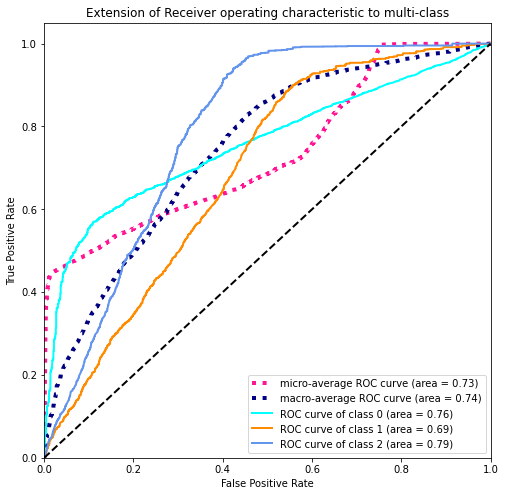

In [26]:
x_test = test_df[input_feat]
rf_metric_dict = defaultdict(list)
eval_classifer(rf_model_dict['org'], x_test, y_test, rf_metric_dict,True,'rf')

In [38]:
with open(f"../test/rf50/None-test.csv",'a',newline="") as f:
    w = csv.writer(f)
    row = list(rf_metric_dict.values())
    w.writerow(row)

In [39]:
for shuffle_feat in feat_col:
    for i in range(50):
        x_test = test_df[input_feat]
        rf_metric_dict = defaultdict(list)
        perm_impt(rf_model_dict['org'],x_test,y_test,rf_metric_dict,shuffle_feat)
        with open(f"../test/rf50/{shuffle_feat}-test.csv",'a',newline="") as f:
            w = csv.writer(f)
            row = list(rf_metric_dict.values())
            w.writerow(row)

<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5794094132003619
Test Ballance Acc: 0.46731345128484403
Test Weighted F1: 0.6473569520238983
Test F1: 0.3981292206248324
Brier Score: 0.5517023766153422
Cross Entropy Loss: 0.9406084529615617
One-vs-One ROC AUC scores:
0.693990 (macro),
0.717813 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.693990 (macro),
0.717813 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5790832965137074
Test Ballance Acc: 0.4657226167999616
Test Weighted F1: 0.64703082030955
Test F1: 0.3973267608367986
Brier Score: 0.5520252244311276
Cross Entropy Loss: 0.9411049368967921
One-vs-One ROC AUC scores:
0.692907 (macro),
0.717274 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.692907 (macro),
0.717274 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5776157714237623
Test Ballance Acc: 0.4634271822004294
Test Weighted F1: 0.6460094521381249
Test F1: 0.3956398805770096
Brier Score: 0.552001195283839
Cross Entropy Loss: 0.9409702310486142
One-vs-One ROC AUC scores:
0.692312 (macro),
0.717529 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.692312 (macro),
0.717529 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5791122262197816
Test Ballance Acc: 0.4660602043904533
Test Weighted F1: 0.6471543772907282
Test F1: 0.3974174648162187
Brier Score: 0.5519063705201843
Cross Entropy Loss: 0.9409337518874812
One-vs-One ROC AUC scores:
0.693005 (macro),
0.717620 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.693005 (macro),
0.717620 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5789044583307034
Test Ballance Acc: 0.46438044757765456
Test Weighted F1: 0.6470921433568277
Test F1: 0.3965232233415618
Brier Score: 0.5518411642720744
Cross Entropy Loss: 0.9407780370395015
One-vs-One ROC AUC scores:
0.692873 (macro),
0.717854 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.692873 (macro),
0.717854 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5784862925792674
Test Ballance Acc: 0.4661959933234354
Test Weighted F1: 0.6464256888600928
Test F1: 0.39733456753950264
Brier Score: 0.552151974511819
Cross Entropy Loss: 0.9414100617040037
One-vs-One ROC AUC scores:
0.692721 (macro),
0.716321 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.692721 (macro),
0.716321 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5787361400408172
Test Ballance Acc: 0.4638535897167557
Test Weighted F1: 0.6468551870582571
Test F1: 0.39624791417158084
Brier Score: 0.5520943432359025
Cross Entropy Loss: 0.9411093545168436
One-vs-One ROC AUC scores:
0.692542 (macro),
0.717384 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.692542 (macro),
0.717384 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5790990763533842
Test Ballance Acc: 0.46624316848160513
Test Weighted F1: 0.6470351965076914
Test F1: 0.3974927292730848
Brier Score: 0.5517846175710841
Cross Entropy Loss: 0.9406949895242127
One-vs-One ROC AUC scores:
0.693536 (macro),
0.717980 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.693536 (macro),
0.717980 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5786861705485072
Test Ballance Acc: 0.465462399571596
Test Weighted F1: 0.6466897613953108
Test F1: 0.3969375052067998
Brier Score: 0.5516629316331425
Cross Entropy Loss: 0.9405068308101232
One-vs-One ROC AUC scores:
0.693748 (macro),
0.717806 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.693748 (macro),
0.717806 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5784521029266343
Test Ballance Acc: 0.4640134604836397
Test Weighted F1: 0.6467048316310632
Test F1: 0.39619742824487525
Brier Score: 0.5518830267606891
Cross Entropy Loss: 0.9408700852409482
One-vs-One ROC AUC scores:
0.693150 (macro),
0.717517 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.693150 (macro),
0.717517 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5779865976561678
Test Ballance Acc: 0.46379414422229787
Test Weighted F1: 0.6462711358330759
Test F1: 0.3959734258982957
Brier Score: 0.552133119681037
Cross Entropy Loss: 0.9413126220444842
One-vs-One ROC AUC scores:
0.692260 (macro),
0.716778 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.692260 (macro),
0.716778 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5782311851711587
Test Ballance Acc: 0.46445313119003034
Test Weighted F1: 0.6462750112125942
Test F1: 0.3963610754055506
Brier Score: 0.5520155650187013
Cross Entropy Loss: 0.9411041042068841
One-vs-One ROC AUC scores:
0.692850 (macro),
0.716696 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.692850 (macro),
0.716696 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5793725935744493
Test Ballance Acc: 0.46631727443538623
Test Weighted F1: 0.6473636800200693
Test F1: 0.3976602887375136
Brier Score: 0.5516605070117119
Cross Entropy Loss: 0.9405699343529625
One-vs-One ROC AUC scores:
0.693730 (macro),
0.718256 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.693730 (macro),
0.718256 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5787177302278609
Test Ballance Acc: 0.46495641697978907
Test Weighted F1: 0.6468465698598005
Test F1: 0.3967808145707596
Brier Score: 0.5522095268419073
Cross Entropy Loss: 0.9413754447914268
One-vs-One ROC AUC scores:
0.691974 (macro),
0.716640 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.691974 (macro),
0.716640 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5792779145363883
Test Ballance Acc: 0.4670695169774952
Test Weighted F1: 0.6471097332492206
Test F1: 0.3979607925757911
Brier Score: 0.5516630304163691
Cross Entropy Loss: 0.9405328379685003
One-vs-One ROC AUC scores:
0.694110 (macro),
0.718301 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.694110 (macro),
0.718301 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5789675776894107
Test Ballance Acc: 0.4660334416147974
Test Weighted F1: 0.6470149230138564
Test F1: 0.39737246473710336
Brier Score: 0.5519226310372584
Cross Entropy Loss: 0.9410011087142638
One-vs-One ROC AUC scores:
0.693053 (macro),
0.717428 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.693053 (macro),
0.717428 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5787413999873762
Test Ballance Acc: 0.4656562901906008
Test Weighted F1: 0.6467253888649475
Test F1: 0.39712684704902795
Brier Score: 0.5521120880417675
Cross Entropy Loss: 0.9412560768284545
One-vs-One ROC AUC scores:
0.692667 (macro),
0.717137 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.692667 (macro),
0.717137 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5805166319510193
Test Ballance Acc: 0.4704889957733791
Test Weighted F1: 0.6481326574922538
Test F1: 0.4000455729314478
Brier Score: 0.551405166962782
Cross Entropy Loss: 0.9402118678223831
One-vs-One ROC AUC scores:
0.695075 (macro),
0.718802 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.695075 (macro),
0.718802 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5784652527930316
Test Ballance Acc: 0.46565961981184295
Test Weighted F1: 0.6465526978773524
Test F1: 0.39702807482956337
Brier Score: 0.5519993724315615
Cross Entropy Loss: 0.9410732545716926
One-vs-One ROC AUC scores:
0.692831 (macro),
0.716995 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.692831 (macro),
0.716995 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5793278840286983
Test Ballance Acc: 0.4658005440804494
Test Weighted F1: 0.6473181405662609
Test F1: 0.3973313681388844
Brier Score: 0.5518817556364031
Cross Entropy Loss: 0.9408680446838921
One-vs-One ROC AUC scores:
0.693220 (macro),
0.717736 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.693220 (macro),
0.717736 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.578562561804372
Test Ballance Acc: 0.46479256014276293
Test Weighted F1: 0.6466947850484274
Test F1: 0.396644841559914
Brier Score: 0.5519325763229582
Cross Entropy Loss: 0.9409351511600849
One-vs-One ROC AUC scores:
0.692917 (macro),
0.717557 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.692917 (macro),
0.717557 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5785836015906078
Test Ballance Acc: 0.46544150768416276
Test Weighted F1: 0.6466319513191909
Test F1: 0.39702312221302627
Brier Score: 0.5521337160708296
Cross Entropy Loss: 0.9412617794535322
One-vs-One ROC AUC scores:
0.692700 (macro),
0.716498 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.692700 (macro),
0.716498 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5786046413768436
Test Ballance Acc: 0.46498642460866235
Test Weighted F1: 0.6467421729928543
Test F1: 0.39673518054931917
Brier Score: 0.5519177150610712
Cross Entropy Loss: 0.9408781898282329
One-vs-One ROC AUC scores:
0.693170 (macro),
0.717829 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.693170 (macro),
0.717829 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.578662500788992
Test Ballance Acc: 0.4642826021870126
Test Weighted F1: 0.6467063299551713
Test F1: 0.3965491816384578
Brier Score: 0.5524241006084878
Cross Entropy Loss: 0.9417495105226578
One-vs-One ROC AUC scores:
0.692155 (macro),
0.715668 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.692155 (macro),
0.715668 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5792516148035936
Test Ballance Acc: 0.4652124288843947
Test Weighted F1: 0.6472668801218363
Test F1: 0.3971115394241953
Brier Score: 0.5520975930549493
Cross Entropy Loss: 0.9411154638143007
One-vs-One ROC AUC scores:
0.692754 (macro),
0.717531 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.692754 (macro),
0.717531 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5793883734141261
Test Ballance Acc: 0.4664881509860559
Test Weighted F1: 0.6472841625903547
Test F1: 0.39782113289077947
Brier Score: 0.5522557038279099
Cross Entropy Loss: 0.9414611010226028
One-vs-One ROC AUC scores:
0.692715 (macro),
0.716478 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.692715 (macro),
0.716478 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5785494119379747
Test Ballance Acc: 0.46361105410776887
Test Weighted F1: 0.6467626812699054
Test F1: 0.39610284066816814
Brier Score: 0.5522541597839429
Cross Entropy Loss: 0.9414325082126093
One-vs-One ROC AUC scores:
0.692032 (macro),
0.716706 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.692032 (macro),
0.716706 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5794699025857897
Test Ballance Acc: 0.466911356363779
Test Weighted F1: 0.6472902809661144
Test F1: 0.397918438823746
Brier Score: 0.5516005838973008
Cross Entropy Loss: 0.9404242182549646
One-vs-One ROC AUC scores:
0.694217 (macro),
0.718083 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.694217 (macro),
0.718083 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5782627448505123
Test Ballance Acc: 0.4641031951401832
Test Weighted F1: 0.6463526985008896
Test F1: 0.3962178647762165
Brier Score: 0.5521783465100013
Cross Entropy Loss: 0.9413210914017873
One-vs-One ROC AUC scores:
0.692140 (macro),
0.716659 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.692140 (macro),
0.716659 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5787939994529656
Test Ballance Acc: 0.4666380361741446
Test Weighted F1: 0.6468295038884956
Test F1: 0.39751328467476266
Brier Score: 0.5514989904033513
Cross Entropy Loss: 0.9402323057188487
One-vs-One ROC AUC scores:
0.694220 (macro),
0.718634 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.694220 (macro),
0.718634 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5786046413768436
Test Ballance Acc: 0.4646216754745371
Test Weighted F1: 0.6466818971198173
Test F1: 0.3965749734982215
Brier Score: 0.5522171184348557
Cross Entropy Loss: 0.9413393947348583
One-vs-One ROC AUC scores:
0.692321 (macro),
0.716731 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.692321 (macro),
0.716731 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5781286162132593
Test Ballance Acc: 0.46379743774720916
Test Weighted F1: 0.6464035672184794
Test F1: 0.3960046660666014
Brier Score: 0.5521119549682174
Cross Entropy Loss: 0.9411792940471774
One-vs-One ROC AUC scores:
0.692501 (macro),
0.716909 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.692501 (macro),
0.716909 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5780733867743904
Test Ballance Acc: 0.46346059983093185
Test Weighted F1: 0.646340082201374
Test F1: 0.39584110405459355
Brier Score: 0.5522164224578492
Cross Entropy Loss: 0.9413774439928846
One-vs-One ROC AUC scores:
0.692132 (macro),
0.716713 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.692132 (macro),
0.716713 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5797276399671779
Test Ballance Acc: 0.46710706108080174
Test Weighted F1: 0.6476168597679463
Test F1: 0.398169881840474
Brier Score: 0.5517156206298043
Cross Entropy Loss: 0.9406466623165511
One-vs-One ROC AUC scores:
0.693814 (macro),
0.718282 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.693814 (macro),
0.718282 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5786677607355509
Test Ballance Acc: 0.46477823284688063
Test Weighted F1: 0.6467370240229815
Test F1: 0.3966186194393531
Brier Score: 0.5517489735307436
Cross Entropy Loss: 0.9406551699217144
One-vs-One ROC AUC scores:
0.693541 (macro),
0.717920 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.693541 (macro),
0.717920 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5782048854383639
Test Ballance Acc: 0.4640328172358883
Test Weighted F1: 0.6464003732126734
Test F1: 0.3962046670632744
Brier Score: 0.5522171930021448
Cross Entropy Loss: 0.9414860608632503
One-vs-One ROC AUC scores:
0.692188 (macro),
0.716329 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.692188 (macro),
0.716329 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5783074543962633
Test Ballance Acc: 0.4642628694732022
Test Weighted F1: 0.6465091991259502
Test F1: 0.39629730422381676
Brier Score: 0.5521926277334015
Cross Entropy Loss: 0.9413606467673125
One-vs-One ROC AUC scores:
0.692306 (macro),
0.717154 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.692306 (macro),
0.717154 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5785283721517389
Test Ballance Acc: 0.46526898252362053
Test Weighted F1: 0.6466022707288899
Test F1: 0.39689698013959585
Brier Score: 0.5519769550810063
Cross Entropy Loss: 0.9411097787626479
One-vs-One ROC AUC scores:
0.692801 (macro),
0.716973 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.692801 (macro),
0.716973 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5787755896400093
Test Ballance Acc: 0.4652438488412784
Test Weighted F1: 0.646772594230636
Test F1: 0.39694946508196355
Brier Score: 0.5523125661422811
Cross Entropy Loss: 0.9415781483465602
One-vs-One ROC AUC scores:
0.692314 (macro),
0.716070 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.692314 (macro),
0.716070 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5785336320982979
Test Ballance Acc: 0.464616453610462
Test Weighted F1: 0.6466546392138509
Test F1: 0.39655982885461927
Brier Score: 0.5520356967807519
Cross Entropy Loss: 0.9411460088540502
One-vs-One ROC AUC scores:
0.692736 (macro),
0.717094 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.692736 (macro),
0.717094 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5788623787582318
Test Ballance Acc: 0.4667316194132071
Test Weighted F1: 0.6468477802964979
Test F1: 0.39765736673102786
Brier Score: 0.5517788229232449
Cross Entropy Loss: 0.9407565331297748
One-vs-One ROC AUC scores:
0.693747 (macro),
0.717815 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.693747 (macro),
0.717815 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5789465379031749
Test Ballance Acc: 0.46582220547315695
Test Weighted F1: 0.6468701915804733
Test F1: 0.39732447444424657
Brier Score: 0.5519359904715582
Cross Entropy Loss: 0.9410535115724615
One-vs-One ROC AUC scores:
0.693016 (macro),
0.717115 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.693016 (macro),
0.717115 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5791464158724148
Test Ballance Acc: 0.46660558348040276
Test Weighted F1: 0.6469677841503138
Test F1: 0.3976971037427268
Brier Score: 0.5520275744399047
Cross Entropy Loss: 0.9410744667593767
One-vs-One ROC AUC scores:
0.693221 (macro),
0.716942 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.693221 (macro),
0.716942 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.578244335037556
Test Ballance Acc: 0.46380491412919805
Test Weighted F1: 0.6462951553967637
Test F1: 0.3961186207481509
Brier Score: 0.5521999872495479
Cross Entropy Loss: 0.9415045334808072
One-vs-One ROC AUC scores:
0.691947 (macro),
0.716118 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.691947 (macro),
0.716118 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5787545498537735
Test Ballance Acc: 0.4654171535239742
Test Weighted F1: 0.646752224721686
Test F1: 0.39702183079569114
Brier Score: 0.5520682794067311
Cross Entropy Loss: 0.9411744892587371
One-vs-One ROC AUC scores:
0.692763 (macro),
0.716738 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.692763 (macro),
0.716738 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5786388310294768
Test Ballance Acc: 0.46407632549622746
Test Weighted F1: 0.6467754027164218
Test F1: 0.3964006018485629
Brier Score: 0.5521427690154895
Cross Entropy Loss: 0.9412993004472322
One-vs-One ROC AUC scores:
0.692270 (macro),
0.717115 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.692270 (macro),
0.717115 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5778103894464433
Test Ballance Acc: 0.4628862421407965
Test Weighted F1: 0.6461327678028731
Test F1: 0.3954983472620142
Brier Score: 0.552296196121234
Cross Entropy Loss: 0.9416005035536889
One-vs-One ROC AUC scores:
0.691697 (macro),
0.716386 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.691697 (macro),
0.716386 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5788334490521576
Test Ballance Acc: 0.4646351525064552
Test Weighted F1: 0.6469596132141311
Test F1: 0.39668288181451766
Brier Score: 0.5519564153846981
Cross Entropy Loss: 0.9410400994690625
One-vs-One ROC AUC scores:
0.693028 (macro),
0.717506 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.693028 (macro),
0.717506 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5784179132740012
Test Ballance Acc: 0.4653671916535313
Test Weighted F1: 0.6463627577710539
Test F1: 0.39689631424887467
Brier Score: 0.5521646052650899
Cross Entropy Loss: 0.9413998449733157
One-vs-One ROC AUC scores:
0.692623 (macro),
0.716430 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.692623 (macro),
0.716430 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5790043973153233
Test Ballance Acc: 0.46560345609514986
Test Weighted F1: 0.6471232702912113
Test F1: 0.397236184776344
Brier Score: 0.5522522081500196
Cross Entropy Loss: 0.9414682925884764
One-vs-One ROC AUC scores:
0.692495 (macro),
0.716585 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.692495 (macro),
0.716585 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5212054745523785
Test Ballance Acc: 0.43303967391393505
Test Weighted F1: 0.5884779669055816
Test F1: 0.3572953478964444
Brier Score: 0.5652129723802
Cross Entropy Loss: 0.9544046748611307
One-vs-One ROC AUC scores:
0.660678 (macro),
0.682428 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.660678 (macro),
0.682428 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5212317742851733
Test Ballance Acc: 0.43206457137289817
Test Weighted F1: 0.5884753910962385
Test F1: 0.3568460998271981
Brier Score: 0.5655319040615643
Cross Entropy Loss: 0.9548190562916061
One-vs-One ROC AUC scores:
0.659464 (macro),
0.681436 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.659464 (macro),
0.681436 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5213553830293084
Test Ballance Acc: 0.43164196604646454
Test Weighted F1: 0.5886468339055501
Test F1: 0.35679357125678607
Brier Score: 0.5655306721666484
Cross Entropy Loss: 0.9549239079143359
One-vs-One ROC AUC scores:
0.659646 (macro),
0.681271 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.659646 (macro),
0.681271 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5214053525216183
Test Ballance Acc: 0.43242403194063145
Test Weighted F1: 0.5886493029896597
Test F1: 0.357122352034011
Brier Score: 0.5654297610300639
Cross Entropy Loss: 0.954755200874966
One-vs-One ROC AUC scores:
0.659928 (macro),
0.681538 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.659928 (macro),
0.681538 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5213054135369984
Test Ballance Acc: 0.43327462883460166
Test Weighted F1: 0.5884863723261521
Test F1: 0.35729050132921536
Brier Score: 0.5653517789749812
Cross Entropy Loss: 0.9546660483057726
One-vs-One ROC AUC scores:
0.660174 (macro),
0.681727 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.660174 (macro),
0.681727 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5205558711523491
Test Ballance Acc: 0.4312709984161474
Test Weighted F1: 0.5879311066952451
Test F1: 0.3562250712619846
Brier Score: 0.5656521680998395
Cross Entropy Loss: 0.9551215633309498
One-vs-One ROC AUC scores:
0.659269 (macro),
0.680913 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.659269 (macro),
0.680913 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5214895116665614
Test Ballance Acc: 0.4336952191980192
Test Weighted F1: 0.5887915697850258
Test F1: 0.35766574938236123
Brier Score: 0.5652904870985141
Cross Entropy Loss: 0.9546127872884098
One-vs-One ROC AUC scores:
0.660370 (macro),
0.682223 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.660370 (macro),
0.682223 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5221443750131499
Test Ballance Acc: 0.4326967753338644
Test Weighted F1: 0.5893742802278604
Test F1: 0.3574528008965155
Brier Score: 0.5653461011338459
Cross Entropy Loss: 0.9545256535940362
One-vs-One ROC AUC scores:
0.660234 (macro),
0.682138 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.660234 (macro),
0.682138 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5206058406446591
Test Ballance Acc: 0.4320418812477412
Test Weighted F1: 0.5879438809618244
Test F1: 0.35659147811510467
Brier Score: 0.5654780382526664
Cross Entropy Loss: 0.9547867984003535
One-vs-One ROC AUC scores:
0.659529 (macro),
0.680966 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.659529 (macro),
0.680966 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5217735487807443
Test Ballance Acc: 0.43377777051352767
Test Weighted F1: 0.5890893433571956
Test F1: 0.3576867978018771
Brier Score: 0.5651864747621937
Cross Entropy Loss: 0.9543642854205024
One-vs-One ROC AUC scores:
0.660551 (macro),
0.682494 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.660551 (macro),
0.682494 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5218419280860106
Test Ballance Acc: 0.43416525729830174
Test Weighted F1: 0.5890246513417702
Test F1: 0.3577714104731209
Brier Score: 0.5651509976030632
Cross Entropy Loss: 0.9543465322474468
One-vs-One ROC AUC scores:
0.660884 (macro),
0.682871 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.660884 (macro),
0.682871 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5212843737507626
Test Ballance Acc: 0.4330215489077151
Test Weighted F1: 0.5884842317656386
Test F1: 0.3570902113692909
Brier Score: 0.5652538779457359
Cross Entropy Loss: 0.9544677047509021
One-vs-One ROC AUC scores:
0.660244 (macro),
0.681999 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.660244 (macro),
0.681999 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5203270634770351
Test Ballance Acc: 0.43138808445713844
Test Weighted F1: 0.5877428771114257
Test F1: 0.3559623622445795
Brier Score: 0.5654286673019857
Cross Entropy Loss: 0.9546590175947565
One-vs-One ROC AUC scores:
0.659428 (macro),
0.681322 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.659428 (macro),
0.681322 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5217945885669801
Test Ballance Acc: 0.4330416542581455
Test Weighted F1: 0.5890278866029535
Test F1: 0.35744236387498135
Brier Score: 0.5653148420186237
Cross Entropy Loss: 0.9545463952735518
One-vs-One ROC AUC scores:
0.660142 (macro),
0.681959 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.660142 (macro),
0.681959 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5216499400366092
Test Ballance Acc: 0.43345820770098725
Test Weighted F1: 0.5890056394073366
Test F1: 0.3575940738191227
Brier Score: 0.565192593985411
Cross Entropy Loss: 0.9542965561781664
One-vs-One ROC AUC scores:
0.660912 (macro),
0.683054 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.660912 (macro),
0.683054 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5222627238107261
Test Ballance Acc: 0.43470722753282426
Test Weighted F1: 0.5894276702437119
Test F1: 0.3581285952794628
Brier Score: 0.5649617153773752
Cross Entropy Loss: 0.95397866450788
One-vs-One ROC AUC scores:
0.661376 (macro),
0.683436 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.661376 (macro),
0.683436 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5208477981863704
Test Ballance Acc: 0.4319505886664188
Test Weighted F1: 0.5881639778305432
Test F1: 0.35652408746663666
Brier Score: 0.5656324947800784
Cross Entropy Loss: 0.9549722923994376
One-vs-One ROC AUC scores:
0.659164 (macro),
0.680919 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.659164 (macro),
0.680919 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5216289002503735
Test Ballance Acc: 0.4327151915069472
Test Weighted F1: 0.5888583415243135
Test F1: 0.3571576232803242
Brier Score: 0.5653130587017933
Cross Entropy Loss: 0.9545216609237954
One-vs-One ROC AUC scores:
0.659866 (macro),
0.681858 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.659866 (macro),
0.681858 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5218524479791286
Test Ballance Acc: 0.4348592138909096
Test Weighted F1: 0.5891265838243508
Test F1: 0.35826871158476936
Brier Score: 0.56490731658849
Cross Entropy Loss: 0.9539009715597929
One-vs-One ROC AUC scores:
0.661951 (macro),
0.683892 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.661951 (macro),
0.683892 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5209372172778725
Test Ballance Acc: 0.43118158220402697
Test Weighted F1: 0.588240166739938
Test F1: 0.3563887973055621
Brier Score: 0.5657884421273865
Cross Entropy Loss: 0.955373917325336
One-vs-One ROC AUC scores:
0.659139 (macro),
0.680367 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.659139 (macro),
0.680367 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5212344042584527
Test Ballance Acc: 0.4319397155776419
Test Weighted F1: 0.5884376852029013
Test F1: 0.3567661386908649
Brier Score: 0.5653491318917169
Cross Entropy Loss: 0.9545402900243035
One-vs-One ROC AUC scores:
0.659791 (macro),
0.681568 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.659791 (macro),
0.681568 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5212344042584527
Test Ballance Acc: 0.43223324832573967
Test Weighted F1: 0.5886219766515336
Test F1: 0.3569145271084899
Brier Score: 0.5655159899205187
Cross Entropy Loss: 0.9548394797520421
One-vs-One ROC AUC scores:
0.660032 (macro),
0.681932 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.660032 (macro),
0.681932 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5215473710787099
Test Ballance Acc: 0.432144947396267
Test Weighted F1: 0.5888411050624774
Test F1: 0.35696235153778605
Brier Score: 0.5653996731513434
Cross Entropy Loss: 0.9547451629607354
One-vs-One ROC AUC scores:
0.659913 (macro),
0.681743 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.659913 (macro),
0.681743 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5216946495823602
Test Ballance Acc: 0.43408716786302115
Test Weighted F1: 0.5889802946241355
Test F1: 0.3577919082165526
Brier Score: 0.5650609079053146
Cross Entropy Loss: 0.9542316444273033
One-vs-One ROC AUC scores:
0.661221 (macro),
0.683015 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.661221 (macro),
0.683015 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5220286561888531
Test Ballance Acc: 0.43492226874431134
Test Weighted F1: 0.589256628949591
Test F1: 0.35814132234848434
Brier Score: 0.5648493662134692
Cross Entropy Loss: 0.953837906694939
One-vs-One ROC AUC scores:
0.661809 (macro),
0.683994 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.661809 (macro),
0.683994 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5209240674114751
Test Ballance Acc: 0.4318376361046705
Test Weighted F1: 0.5881994216936081
Test F1: 0.35662517989861625
Brier Score: 0.5658672686285333
Cross Entropy Loss: 0.9553169861960188
One-vs-One ROC AUC scores:
0.658651 (macro),
0.680417 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.658651 (macro),
0.680417 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5214579519872078
Test Ballance Acc: 0.43425637369861714
Test Weighted F1: 0.5887414185843941
Test F1: 0.3578211593015406
Brier Score: 0.565177194749388
Cross Entropy Loss: 0.9543192141275137
One-vs-One ROC AUC scores:
0.660955 (macro),
0.682938 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.660955 (macro),
0.682938 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5216814997159629
Test Ballance Acc: 0.432906948141071
Test Weighted F1: 0.5888081736714975
Test F1: 0.357173697778121
Brier Score: 0.5653311015377931
Cross Entropy Loss: 0.9545554371999458
One-vs-One ROC AUC scores:
0.660143 (macro),
0.682175 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.660143 (macro),
0.682175 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5208425382398115
Test Ballance Acc: 0.43235331641508834
Test Weighted F1: 0.5882516974992599
Test F1: 0.35686597743697096
Brier Score: 0.5655748677205537
Cross Entropy Loss: 0.9549660708075718
One-vs-One ROC AUC scores:
0.659332 (macro),
0.681211 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.659332 (macro),
0.681211 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5208214984535757
Test Ballance Acc: 0.431020804017521
Test Weighted F1: 0.5882865135587453
Test F1: 0.3561217961683523
Brier Score: 0.5656156629997238
Cross Entropy Loss: 0.9550466050602371
One-vs-One ROC AUC scores:
0.659171 (macro),
0.681078 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.659171 (macro),
0.681078 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5211712848997454
Test Ballance Acc: 0.4331549790297891
Test Weighted F1: 0.5884300690891758
Test F1: 0.3573222413998101
Brier Score: 0.5655844433176709
Cross Entropy Loss: 0.9549539695006627
One-vs-One ROC AUC scores:
0.659636 (macro),
0.681486 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.659636 (macro),
0.681486 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5216026005175788
Test Ballance Acc: 0.4345943158516102
Test Weighted F1: 0.5888284402058934
Test F1: 0.357951333444009
Brier Score: 0.565082356742284
Cross Entropy Loss: 0.9542159130888802
One-vs-One ROC AUC scores:
0.660929 (macro),
0.682814 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.660929 (macro),
0.682814 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5220812556544425
Test Ballance Acc: 0.43520869551639435
Test Weighted F1: 0.5891516229789091
Test F1: 0.3584058843279084
Brier Score: 0.5652005818473617
Cross Entropy Loss: 0.9544276254747598
One-vs-One ROC AUC scores:
0.660522 (macro),
0.682321 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.660522 (macro),
0.682321 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5212186244187759
Test Ballance Acc: 0.4321805524324633
Test Weighted F1: 0.5885028226875771
Test F1: 0.3570355885426592
Brier Score: 0.5655370302220093
Cross Entropy Loss: 0.9548981214288471
One-vs-One ROC AUC scores:
0.659572 (macro),
0.681081 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.659572 (macro),
0.681081 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5214921416398409
Test Ballance Acc: 0.4331975769337198
Test Weighted F1: 0.588762570253166
Test F1: 0.35740843524766475
Brier Score: 0.5653939773195693
Cross Entropy Loss: 0.9546561009991916
One-vs-One ROC AUC scores:
0.660155 (macro),
0.682153 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.660155 (macro),
0.682153 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5214237623345747
Test Ballance Acc: 0.43185352763896656
Test Weighted F1: 0.5887062257027889
Test F1: 0.3567844380730165
Brier Score: 0.5653210321117185
Cross Entropy Loss: 0.9545748406305354
One-vs-One ROC AUC scores:
0.659894 (macro),
0.681586 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.659894 (macro),
0.681586 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5226835195354416
Test Ballance Acc: 0.43517712444223927
Test Weighted F1: 0.5899845447756483
Test F1: 0.3587249374642818
Brier Score: 0.5646869489576148
Cross Entropy Loss: 0.9536349904270952
One-vs-One ROC AUC scores:
0.662626 (macro),
0.684801 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.662626 (macro),
0.684801 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5212922636706011
Test Ballance Acc: 0.43323993929208776
Test Weighted F1: 0.5886185824566027
Test F1: 0.35733173626065157
Brier Score: 0.5652930571202035
Cross Entropy Loss: 0.9545126661264207
One-vs-One ROC AUC scores:
0.660423 (macro),
0.682316 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.660423 (macro),
0.682316 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5219208272843948
Test Ballance Acc: 0.43387367868940263
Test Weighted F1: 0.5890415098377566
Test F1: 0.35779392300766544
Brier Score: 0.5651648210821038
Cross Entropy Loss: 0.9542961720970705
One-vs-One ROC AUC scores:
0.660425 (macro),
0.682141 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.660425 (macro),
0.682141 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5221890845589009
Test Ballance Acc: 0.4336337691455799
Test Weighted F1: 0.589401648248544
Test F1: 0.35781900247087345
Brier Score: 0.5652892381269949
Cross Entropy Loss: 0.954566896906754
One-vs-One ROC AUC scores:
0.660462 (macro),
0.682619 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.660462 (macro),
0.682619 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5208136085337373
Test Ballance Acc: 0.4325703309510103
Test Weighted F1: 0.588124380934148
Test F1: 0.35683118420258947
Brier Score: 0.5652764285816001
Cross Entropy Loss: 0.9545603627051651
One-vs-One ROC AUC scores:
0.660021 (macro),
0.681614 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.660021 (macro),
0.681614 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5221180752803551
Test Ballance Acc: 0.43375024446416743
Test Weighted F1: 0.5894089833524927
Test F1: 0.3578284460613392
Brier Score: 0.5652963001797953
Cross Entropy Loss: 0.9544087857085097
One-vs-One ROC AUC scores:
0.660565 (macro),
0.682612 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.660565 (macro),
0.682612 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5211423551936712
Test Ballance Acc: 0.43263751853894455
Test Weighted F1: 0.5884558586382915
Test F1: 0.35695998541006785
Brier Score: 0.565504531046569
Cross Entropy Loss: 0.9548754501137079
One-vs-One ROC AUC scores:
0.659965 (macro),
0.681506 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.659965 (macro),
0.681506 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.521670979822845
Test Ballance Acc: 0.43305998383753436
Test Weighted F1: 0.5888502440965866
Test F1: 0.3572468011001531
Brier Score: 0.5653153693166493
Cross Entropy Loss: 0.95466339063292
One-vs-One ROC AUC scores:
0.660160 (macro),
0.681681 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.660160 (macro),
0.681681 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5216788697426834
Test Ballance Acc: 0.43239254195648885
Test Weighted F1: 0.5889130985937564
Test F1: 0.3569269265022379
Brier Score: 0.5653876367764565
Cross Entropy Loss: 0.9547346894136937
One-vs-One ROC AUC scores:
0.659723 (macro),
0.681703 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.659723 (macro),
0.681703 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.520382292915904
Test Ballance Acc: 0.43259276559573206
Test Weighted F1: 0.5878107720928228
Test F1: 0.35689910951514686
Brier Score: 0.5654499817332546
Cross Entropy Loss: 0.954877433841234
One-vs-One ROC AUC scores:
0.660037 (macro),
0.681555 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.660037 (macro),
0.681555 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5214448021208105
Test Ballance Acc: 0.4334696476513511
Test Weighted F1: 0.5884966327490636
Test F1: 0.3574660310226405
Brier Score: 0.5654934242699631
Cross Entropy Loss: 0.9549143871997026
One-vs-One ROC AUC scores:
0.659334 (macro),
0.680974 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.659334 (macro),
0.680974 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5211660249531864
Test Ballance Acc: 0.43299028924487026
Test Weighted F1: 0.5884993503655322
Test F1: 0.3571239889765165
Brier Score: 0.5654227611462944
Cross Entropy Loss: 0.954614512745834
One-vs-One ROC AUC scores:
0.660209 (macro),
0.682229 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.660209 (macro),
0.682229 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5214448021208105
Test Ballance Acc: 0.43350937475937684
Test Weighted F1: 0.5887371091811217
Test F1: 0.3575921015991275
Brier Score: 0.5651573515863808
Cross Entropy Loss: 0.9543217732443278
One-vs-One ROC AUC scores:
0.660706 (macro),
0.682185 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.660706 (macro),
0.682185 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5206426602705716
Test Ballance Acc: 0.4329747069347342
Test Weighted F1: 0.5880531879249309
Test F1: 0.35685681015249804
Brier Score: 0.5653288353642443
Cross Entropy Loss: 0.9547049331399861
One-vs-One ROC AUC scores:
0.660811 (macro),
0.682375 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.660811 (macro),
0.682375 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5619648004376275
Test Ballance Acc: 0.5325956395839008
Test Weighted F1: 0.6290325026036856
Test F1: 0.39598369637609165
Brier Score: 0.5141949653540157
Cross Entropy Loss: 0.893893812154251
One-vs-One ROC AUC scores:
0.744800 (macro),
0.753730 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.744800 (macro),
0.753730 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.561967430410907
Test Ballance Acc: 0.5326055234484919
Test Weighted F1: 0.629033592485474
Test F1: 0.3959876723095368
Brier Score: 0.5141948218580051
Cross Entropy Loss: 0.8938936315159034
One-vs-One ROC AUC scores:
0.744799 (macro),
0.753729 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.744799 (macro),
0.753729 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5619648004376275
Test Ballance Acc: 0.5325956395839008
Test Weighted F1: 0.6290326626231372
Test F1: 0.3959841777366086
Brier Score: 0.5141947421366718
Cross Entropy Loss: 0.8938935145415755
One-vs-One ROC AUC scores:
0.744801 (macro),
0.753729 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.744801 (macro),
0.753729 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5619648004376275
Test Ballance Acc: 0.5325956395839008
Test Weighted F1: 0.6290325026036856
Test F1: 0.39598369637609165
Brier Score: 0.5141946274877403
Cross Entropy Loss: 0.8938933217707529
One-vs-One ROC AUC scores:
0.744801 (macro),
0.753727 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.744801 (macro),
0.753727 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5619648004376275
Test Ballance Acc: 0.5325956395839008
Test Weighted F1: 0.6290325826096146
Test F1: 0.39598393704291296
Brier Score: 0.5141947952522203
Cross Entropy Loss: 0.8938936318416986
One-vs-One ROC AUC scores:
0.744800 (macro),
0.753724 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.744800 (macro),
0.753724 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5619648004376275
Test Ballance Acc: 0.5325956395839008
Test Weighted F1: 0.6290325026036856
Test F1: 0.39598369637609165
Brier Score: 0.5141947509540542
Cross Entropy Loss: 0.8938935176033932
One-vs-One ROC AUC scores:
0.744799 (macro),
0.753725 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.744799 (macro),
0.753725 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5619648004376275
Test Ballance Acc: 0.5325956395839008
Test Weighted F1: 0.6290327426442536
Test F1: 0.3959844184571794
Brier Score: 0.5141949194040358
Cross Entropy Loss: 0.8938939180075356
One-vs-One ROC AUC scores:
0.744800 (macro),
0.753725 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.744800 (macro),
0.753725 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5619648004376275
Test Ballance Acc: 0.5325956395839008
Test Weighted F1: 0.6290325826096146
Test F1: 0.39598393704291296
Brier Score: 0.5141947269696376
Cross Entropy Loss: 0.8938934905654309
One-vs-One ROC AUC scores:
0.744801 (macro),
0.753727 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.744801 (macro),
0.753727 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5619648004376275
Test Ballance Acc: 0.5325956395839008
Test Weighted F1: 0.6290325026036856
Test F1: 0.39598369637609165
Brier Score: 0.514194560573782
Cross Entropy Loss: 0.8938933039186144
One-vs-One ROC AUC scores:
0.744802 (macro),
0.753731 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.744802 (macro),
0.753731 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5619648004376275
Test Ballance Acc: 0.5325956395839008
Test Weighted F1: 0.6290325026036856
Test F1: 0.39598369637609165
Brier Score: 0.514194760198325
Cross Entropy Loss: 0.8938935142708123
One-vs-One ROC AUC scores:
0.744799 (macro),
0.753727 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.744799 (macro),
0.753727 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5619648004376275
Test Ballance Acc: 0.5325956395839008
Test Weighted F1: 0.6290328226729639
Test F1: 0.39598465920462617
Brier Score: 0.514194599751882
Cross Entropy Loss: 0.8938932605838347
One-vs-One ROC AUC scores:
0.744803 (macro),
0.753731 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.744803 (macro),
0.753731 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5619648004376275
Test Ballance Acc: 0.5325956395839008
Test Weighted F1: 0.6290325826096146
Test F1: 0.39598393704291296
Brier Score: 0.5141947134552989
Cross Entropy Loss: 0.8938933262538302
One-vs-One ROC AUC scores:
0.744803 (macro),
0.753732 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.744803 (macro),
0.753732 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.561962170464348
Test Ballance Acc: 0.5325864707396336
Test Weighted F1: 0.6290300122737705
Test F1: 0.3959749378554334
Brier Score: 0.5141949118494146
Cross Entropy Loss: 0.8938937545601812
One-vs-One ROC AUC scores:
0.744799 (macro),
0.753726 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.744799 (macro),
0.753726 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.561962170464348
Test Ballance Acc: 0.5325864707396336
Test Weighted F1: 0.6290300122737705
Test F1: 0.3959749378554334
Brier Score: 0.5141948629330437
Cross Entropy Loss: 0.8938936668574635
One-vs-One ROC AUC scores:
0.744800 (macro),
0.753728 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.744800 (macro),
0.753728 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5619648004376275
Test Ballance Acc: 0.5325956395839008
Test Weighted F1: 0.6290325026036856
Test F1: 0.39598369637609165
Brier Score: 0.5141946905289728
Cross Entropy Loss: 0.8938934246167282
One-vs-One ROC AUC scores:
0.744801 (macro),
0.753729 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.744801 (macro),
0.753729 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5619648004376275
Test Ballance Acc: 0.5325956395839008
Test Weighted F1: 0.6290326626231372
Test F1: 0.3959841777366086
Brier Score: 0.5141947914933173
Cross Entropy Loss: 0.8938935721754239
One-vs-One ROC AUC scores:
0.744800 (macro),
0.753728 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.744800 (macro),
0.753728 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5619648004376275
Test Ballance Acc: 0.5325956395839008
Test Weighted F1: 0.6290325826096146
Test F1: 0.39598393704291296
Brier Score: 0.5141948582443625
Cross Entropy Loss: 0.8938937554383901
One-vs-One ROC AUC scores:
0.744801 (macro),
0.753727 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.744801 (macro),
0.753727 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5619648004376275
Test Ballance Acc: 0.5325956395839008
Test Weighted F1: 0.6290328226729639
Test F1: 0.39598465920462617
Brier Score: 0.5141951989559457
Cross Entropy Loss: 0.8938944816427027
One-vs-One ROC AUC scores:
0.744797 (macro),
0.753721 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.744797 (macro),
0.753721 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.561967430410907
Test Ballance Acc: 0.5326055234484919
Test Weighted F1: 0.629033592485474
Test F1: 0.3959876723095368
Brier Score: 0.5141947190043455
Cross Entropy Loss: 0.8938936262837972
One-vs-One ROC AUC scores:
0.744801 (macro),
0.753726 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.744801 (macro),
0.753726 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5619648004376275
Test Ballance Acc: 0.5325956395839008
Test Weighted F1: 0.6290325826096146
Test F1: 0.39598393704291296
Brier Score: 0.5141945962322353
Cross Entropy Loss: 0.893893355440487
One-vs-One ROC AUC scores:
0.744802 (macro),
0.753730 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.744802 (macro),
0.753730 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5619648004376275
Test Ballance Acc: 0.5325956395839008
Test Weighted F1: 0.6290325026036856
Test F1: 0.39598369637609165
Brier Score: 0.5141946963531071
Cross Entropy Loss: 0.8938934436933945
One-vs-One ROC AUC scores:
0.744799 (macro),
0.753727 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.744799 (macro),
0.753727 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5619648004376275
Test Ballance Acc: 0.5325956395839008
Test Weighted F1: 0.6290325026036856
Test F1: 0.39598369637609165
Brier Score: 0.5141945325704529
Cross Entropy Loss: 0.8938932247258593
One-vs-One ROC AUC scores:
0.744802 (macro),
0.753730 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.744802 (macro),
0.753730 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5619648004376275
Test Ballance Acc: 0.5325956395839008
Test Weighted F1: 0.6290327426442536
Test F1: 0.3959844184571794
Brier Score: 0.5141947597898593
Cross Entropy Loss: 0.8938936081751544
One-vs-One ROC AUC scores:
0.744801 (macro),
0.753728 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.744801 (macro),
0.753728 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5619648004376275
Test Ballance Acc: 0.5325956395839008
Test Weighted F1: 0.6290326626231372
Test F1: 0.3959841777366086
Brier Score: 0.5141948333711603
Cross Entropy Loss: 0.8938936705829764
One-vs-One ROC AUC scores:
0.744798 (macro),
0.753728 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.744798 (macro),
0.753728 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5619648004376275
Test Ballance Acc: 0.5325956395839008
Test Weighted F1: 0.6290325026036856
Test F1: 0.39598369637609165
Brier Score: 0.5141945758480477
Cross Entropy Loss: 0.8938932660749174
One-vs-One ROC AUC scores:
0.744803 (macro),
0.753730 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.744803 (macro),
0.753730 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.561967430410907
Test Ballance Acc: 0.5326055234484919
Test Weighted F1: 0.6290335124768256
Test F1: 0.3959874316341592
Brier Score: 0.5141945809999977
Cross Entropy Loss: 0.8938932152692989
One-vs-One ROC AUC scores:
0.744801 (macro),
0.753729 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.744801 (macro),
0.753729 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.561962170464348
Test Ballance Acc: 0.5325864707396336
Test Weighted F1: 0.629030092258153
Test F1: 0.39597517844793934
Brier Score: 0.5141946000783243
Cross Entropy Loss: 0.8938932876026572
One-vs-One ROC AUC scores:
0.744802 (macro),
0.753730 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.744802 (macro),
0.753730 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5619648004376275
Test Ballance Acc: 0.5325956395839008
Test Weighted F1: 0.6290325826096146
Test F1: 0.39598393704291296
Brier Score: 0.5141948923687792
Cross Entropy Loss: 0.8938938481100054
One-vs-One ROC AUC scores:
0.744801 (macro),
0.753727 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.744801 (macro),
0.753727 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5619648004376275
Test Ballance Acc: 0.5325956395839008
Test Weighted F1: 0.6290325826096146
Test F1: 0.39598393704291296
Brier Score: 0.5141946638484578
Cross Entropy Loss: 0.8938933712609148
One-vs-One ROC AUC scores:
0.744801 (macro),
0.753731 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.744801 (macro),
0.753731 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5619648004376275
Test Ballance Acc: 0.5325956395839008
Test Weighted F1: 0.6290325826096146
Test F1: 0.39598393704291296
Brier Score: 0.5141947410115651
Cross Entropy Loss: 0.8938935575276186
One-vs-One ROC AUC scores:
0.744797 (macro),
0.753722 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.744797 (macro),
0.753722 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5619648004376275
Test Ballance Acc: 0.5325956395839008
Test Weighted F1: 0.6290325026036856
Test F1: 0.39598369637609165
Brier Score: 0.5141948903074992
Cross Entropy Loss: 0.8938938637306554
One-vs-One ROC AUC scores:
0.744799 (macro),
0.753725 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.744799 (macro),
0.753725 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5619648004376275
Test Ballance Acc: 0.5325956395839008
Test Weighted F1: 0.6290325026036856
Test F1: 0.39598369637609165
Brier Score: 0.5141945303148514
Cross Entropy Loss: 0.8938931356183778
One-vs-One ROC AUC scores:
0.744805 (macro),
0.753731 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.744805 (macro),
0.753731 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5619648004376275
Test Ballance Acc: 0.5325956395839008
Test Weighted F1: 0.6290325826096146
Test F1: 0.39598393704291296
Brier Score: 0.5141948273590675
Cross Entropy Loss: 0.89389368806686
One-vs-One ROC AUC scores:
0.744801 (macro),
0.753730 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.744801 (macro),
0.753730 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.561962170464348
Test Ballance Acc: 0.5325864707396336
Test Weighted F1: 0.6290300122737705
Test F1: 0.3959749378554334
Brier Score: 0.5141948066547171
Cross Entropy Loss: 0.8938935496352247
One-vs-One ROC AUC scores:
0.744801 (macro),
0.753728 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.744801 (macro),
0.753728 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5619648004376275
Test Ballance Acc: 0.5325956395839008
Test Weighted F1: 0.6290325026036856
Test F1: 0.39598369637609165
Brier Score: 0.5141945770724542
Cross Entropy Loss: 0.8938932787515015
One-vs-One ROC AUC scores:
0.744800 (macro),
0.753725 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.744800 (macro),
0.753725 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5619648004376275
Test Ballance Acc: 0.5325956395839008
Test Weighted F1: 0.6290326626231372
Test F1: 0.3959841777366086
Brier Score: 0.5141947259661599
Cross Entropy Loss: 0.8938935542484666
One-vs-One ROC AUC scores:
0.744801 (macro),
0.753728 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.744801 (macro),
0.753728 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.561967430410907
Test Ballance Acc: 0.5326055234484919
Test Weighted F1: 0.629033592485474
Test F1: 0.3959876723095368
Brier Score: 0.5141947247229914
Cross Entropy Loss: 0.8938934888527601
One-vs-One ROC AUC scores:
0.744802 (macro),
0.753731 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.744802 (macro),
0.753731 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5619648004376275
Test Ballance Acc: 0.5325956395839008
Test Weighted F1: 0.6290326626231372
Test F1: 0.3959841777366086
Brier Score: 0.5141948567923692
Cross Entropy Loss: 0.8938937899500792
One-vs-One ROC AUC scores:
0.744802 (macro),
0.753728 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.744802 (macro),
0.753728 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.561967430410907
Test Ballance Acc: 0.5326055234484919
Test Weighted F1: 0.6290335124768256
Test F1: 0.3959874316341592
Brier Score: 0.5141946030942675
Cross Entropy Loss: 0.893893339193344
One-vs-One ROC AUC scores:
0.744801 (macro),
0.753727 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.744801 (macro),
0.753727 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5619648004376275
Test Ballance Acc: 0.5325956395839008
Test Weighted F1: 0.6290325026036856
Test F1: 0.39598369637609165
Brier Score: 0.5141949016695596
Cross Entropy Loss: 0.8938935815216957
One-vs-One ROC AUC scores:
0.744802 (macro),
0.753732 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.744802 (macro),
0.753732 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5619648004376275
Test Ballance Acc: 0.5325956395839008
Test Weighted F1: 0.6290328226729639
Test F1: 0.39598465920462617
Brier Score: 0.5141947751739471
Cross Entropy Loss: 0.8938935926251271
One-vs-One ROC AUC scores:
0.744801 (macro),
0.753727 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.744801 (macro),
0.753727 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.561962170464348
Test Ballance Acc: 0.5325864707396336
Test Weighted F1: 0.6290299322969809
Test F1: 0.39597469728979906
Brier Score: 0.5141950999966056
Cross Entropy Loss: 0.8938940402304649
One-vs-One ROC AUC scores:
0.744799 (macro),
0.753726 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.744799 (macro),
0.753726 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5619648004376275
Test Ballance Acc: 0.5325956395839008
Test Weighted F1: 0.6290325026036856
Test F1: 0.39598369637609165
Brier Score: 0.51419486056537
Cross Entropy Loss: 0.8938937053527023
One-vs-One ROC AUC scores:
0.744799 (macro),
0.753726 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.744799 (macro),
0.753726 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.561962170464348
Test Ballance Acc: 0.5325864707396336
Test Weighted F1: 0.6290299322969809
Test F1: 0.39597469728979906
Brier Score: 0.5141947540300458
Cross Entropy Loss: 0.8938935086351644
One-vs-One ROC AUC scores:
0.744803 (macro),
0.753730 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.744803 (macro),
0.753730 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5619648004376275
Test Ballance Acc: 0.5325956395839008
Test Weighted F1: 0.6290325826096146
Test F1: 0.39598393704291296
Brier Score: 0.5141948034503435
Cross Entropy Loss: 0.893893669605978
One-vs-One ROC AUC scores:
0.744799 (macro),
0.753728 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.744799 (macro),
0.753728 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5619648004376275
Test Ballance Acc: 0.5325956395839008
Test Weighted F1: 0.6290325026036856
Test F1: 0.39598369637609165
Brier Score: 0.5141946747275105
Cross Entropy Loss: 0.8938934386674471
One-vs-One ROC AUC scores:
0.744802 (macro),
0.753729 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.744802 (macro),
0.753729 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.561967430410907
Test Ballance Acc: 0.5326055234484919
Test Weighted F1: 0.629033592485474
Test F1: 0.3959876723095368
Brier Score: 0.514194558314109
Cross Entropy Loss: 0.8938930939395385
One-vs-One ROC AUC scores:
0.744801 (macro),
0.753731 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.744801 (macro),
0.753731 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5619648004376275
Test Ballance Acc: 0.5325956395839008
Test Weighted F1: 0.6290325826096146
Test F1: 0.39598393704291296
Brier Score: 0.5141945056931867
Cross Entropy Loss: 0.8938930012519535
One-vs-One ROC AUC scores:
0.744803 (macro),
0.753731 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.744803 (macro),
0.753731 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.561967430410907
Test Ballance Acc: 0.5326055234484919
Test Weighted F1: 0.629033672501716
Test F1: 0.39598791301178965
Brier Score: 0.5141947201335126
Cross Entropy Loss: 0.8938935127201763
One-vs-One ROC AUC scores:
0.744800 (macro),
0.753727 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.744800 (macro),
0.753727 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5619648004376275
Test Ballance Acc: 0.5325956395839008
Test Weighted F1: 0.6290326626231372
Test F1: 0.3959841777366086
Brier Score: 0.5141947414890417
Cross Entropy Loss: 0.893893466805006
One-vs-One ROC AUC scores:
0.744801 (macro),
0.753730 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.744801 (macro),
0.753730 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5624829051736835
Test Ballance Acc: 0.5340330045672229
Test Weighted F1: 0.6293086878705823
Test F1: 0.39666735291248517
Brier Score: 0.5142564833652589
Cross Entropy Loss: 0.8939484719045734
One-vs-One ROC AUC scores:
0.744763 (macro),
0.753488 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.744763 (macro),
0.753488 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5623172168570767
Test Ballance Acc: 0.5336808010843652
Test Weighted F1: 0.6291639966226665
Test F1: 0.3963770849085648
Brier Score: 0.5142452414295619
Cross Entropy Loss: 0.8939341243689879
One-vs-One ROC AUC scores:
0.744778 (macro),
0.753490 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.744778 (macro),
0.753490 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5624671253340066
Test Ballance Acc: 0.5340653677087365
Test Weighted F1: 0.6292743908836549
Test F1: 0.3966398491063585
Brier Score: 0.5142727139206142
Cross Entropy Loss: 0.8939689526505167
One-vs-One ROC AUC scores:
0.744689 (macro),
0.753457 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.744689 (macro),
0.753457 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5624171558416966
Test Ballance Acc: 0.5338509180344168
Test Weighted F1: 0.6292368106469888
Test F1: 0.3964952025962111
Brier Score: 0.5142674813179835
Cross Entropy Loss: 0.893961894915057
One-vs-One ROC AUC scores:
0.744739 (macro),
0.753478 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.744739 (macro),
0.753478 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5623277367501947
Test Ballance Acc: 0.5337439038296661
Test Weighted F1: 0.6291832082575436
Test F1: 0.3964295379062537
Brier Score: 0.5142796514456248
Cross Entropy Loss: 0.8939809903474987
One-vs-One ROC AUC scores:
0.744688 (macro),
0.753467 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.744688 (macro),
0.753467 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5623750762692251
Test Ballance Acc: 0.5338125288177572
Test Weighted F1: 0.6292271338368299
Test F1: 0.3965012728546557
Brier Score: 0.5142482014087949
Cross Entropy Loss: 0.8939361641384838
One-vs-One ROC AUC scores:
0.744695 (macro),
0.753455 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.744695 (macro),
0.753455 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5623803362157841
Test Ballance Acc: 0.5336999308269209
Test Weighted F1: 0.629217780336266
Test F1: 0.39639312604971827
Brier Score: 0.5142656294145197
Cross Entropy Loss: 0.8939602100912287
One-vs-One ROC AUC scores:
0.744702 (macro),
0.753476 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.744702 (macro),
0.753476 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.562285657177723
Test Ballance Acc: 0.5335824441571986
Test Weighted F1: 0.6291430880564102
Test F1: 0.39625205213081566
Brier Score: 0.5142701288255447
Cross Entropy Loss: 0.8939653532877468
One-vs-One ROC AUC scores:
0.744733 (macro),
0.753515 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.744733 (macro),
0.753515 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5623277367501947
Test Ballance Acc: 0.5337284306451496
Test Weighted F1: 0.6291739213608245
Test F1: 0.39640365615335343
Brier Score: 0.5142557415621356
Cross Entropy Loss: 0.893949123206499
One-vs-One ROC AUC scores:
0.744746 (macro),
0.753497 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.744746 (macro),
0.753497 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5623172168570767
Test Ballance Acc: 0.5334172708061189
Test Weighted F1: 0.6291428436377903
Test F1: 0.396120561241916
Brier Score: 0.514268059774101
Cross Entropy Loss: 0.8939635527461123
One-vs-One ROC AUC scores:
0.744602 (macro),
0.753442 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.744602 (macro),
0.753442 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5623119569105178
Test Ballance Acc: 0.5335993694959748
Test Weighted F1: 0.6291665390575983
Test F1: 0.39637261054431966
Brier Score: 0.5142635942138737
Cross Entropy Loss: 0.8939586387499923
One-vs-One ROC AUC scores:
0.744698 (macro),
0.753436 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.744698 (macro),
0.753436 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5624829051736835
Test Ballance Acc: 0.5340577730159498
Test Weighted F1: 0.6292862509199793
Test F1: 0.3966221104886906
Brier Score: 0.5142549421784942
Cross Entropy Loss: 0.8939459608824151
One-vs-One ROC AUC scores:
0.744661 (macro),
0.753482 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.744661 (macro),
0.753482 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5623777062425046
Test Ballance Acc: 0.5339388474601349
Test Weighted F1: 0.6291804382280926
Test F1: 0.39644145306147793
Brier Score: 0.5142650290163381
Cross Entropy Loss: 0.8939630300027112
One-vs-One ROC AUC scores:
0.744752 (macro),
0.753496 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.744752 (macro),
0.753496 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5623908561089019
Test Ballance Acc: 0.5337968400225503
Test Weighted F1: 0.6292274731784206
Test F1: 0.3964581520001507
Brier Score: 0.5142610637405474
Cross Entropy Loss: 0.8939550030435953
One-vs-One ROC AUC scores:
0.744669 (macro),
0.753456 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.744669 (macro),
0.753456 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5622935470975615
Test Ballance Acc: 0.5335770881388532
Test Weighted F1: 0.6291536595455047
Test F1: 0.3963253094594081
Brier Score: 0.5142536734219119
Cross Entropy Loss: 0.8939453611262365
One-vs-One ROC AUC scores:
0.744689 (macro),
0.753464 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.744689 (macro),
0.753464 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5623172168570767
Test Ballance Acc: 0.5336798571851838
Test Weighted F1: 0.6291439977442055
Test F1: 0.3963204450371907
Brier Score: 0.5142574643974586
Cross Entropy Loss: 0.8939467659166277
One-vs-One ROC AUC scores:
0.744732 (macro),
0.753528 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.744732 (macro),
0.753528 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5623934860821814
Test Ballance Acc: 0.5337629071522786
Test Weighted F1: 0.6292415466989033
Test F1: 0.39652497953829835
Brier Score: 0.5142640085443712
Cross Entropy Loss: 0.8939597712835525
One-vs-One ROC AUC scores:
0.744686 (macro),
0.753455 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.744686 (macro),
0.753455 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5623566664562688
Test Ballance Acc: 0.5336045408626866
Test Weighted F1: 0.6292391983095463
Test F1: 0.3964120067274008
Brier Score: 0.5142621727159864
Cross Entropy Loss: 0.8939555374018054
One-vs-One ROC AUC scores:
0.744620 (macro),
0.753426 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.744620 (macro),
0.753426 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5623803362157841
Test Ballance Acc: 0.5337344522975732
Test Weighted F1: 0.6292307972503816
Test F1: 0.3964158201874324
Brier Score: 0.5142584275249509
Cross Entropy Loss: 0.8939517480144387
One-vs-One ROC AUC scores:
0.744681 (macro),
0.753467 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.744681 (macro),
0.753467 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5623014370173999
Test Ballance Acc: 0.5336374572228016
Test Weighted F1: 0.6291422609582769
Test F1: 0.3963015538890813
Brier Score: 0.5142697150616907
Cross Entropy Loss: 0.8939644939904723
One-vs-One ROC AUC scores:
0.744647 (macro),
0.753468 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.744647 (macro),
0.753468 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5624145258684172
Test Ballance Acc: 0.5340043462588768
Test Weighted F1: 0.6292505269417249
Test F1: 0.39663532184074013
Brier Score: 0.5142570505426043
Cross Entropy Loss: 0.8939525983074217
One-vs-One ROC AUC scores:
0.744749 (macro),
0.753490 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.744749 (macro),
0.753490 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5624329356813734
Test Ballance Acc: 0.5336954844370954
Test Weighted F1: 0.6292533996624835
Test F1: 0.3963583810961617
Brier Score: 0.5142611186884493
Cross Entropy Loss: 0.8939574943189664
One-vs-One ROC AUC scores:
0.744708 (macro),
0.753488 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.744708 (macro),
0.753488 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5623592964295483
Test Ballance Acc: 0.5337318034042458
Test Weighted F1: 0.6292099914061658
Test F1: 0.3964234195297301
Brier Score: 0.5142578307395048
Cross Entropy Loss: 0.8939510983869271
One-vs-One ROC AUC scores:
0.744761 (macro),
0.753465 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.744761 (macro),
0.753465 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5623803362157841
Test Ballance Acc: 0.5338680191793818
Test Weighted F1: 0.6291896368474906
Test F1: 0.3964449921240892
Brier Score: 0.5142637959350096
Cross Entropy Loss: 0.8939539379384006
One-vs-One ROC AUC scores:
0.744750 (macro),
0.753491 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.744750 (macro),
0.753491 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5623382566433125
Test Ballance Acc: 0.5337220043076795
Test Weighted F1: 0.6292072696951531
Test F1: 0.3964942394018533
Brier Score: 0.5142596620376149
Cross Entropy Loss: 0.8939573529303882
One-vs-One ROC AUC scores:
0.744728 (macro),
0.753488 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.744728 (macro),
0.753488 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.562296177070841
Test Ballance Acc: 0.5335779340018426
Test Weighted F1: 0.6291310473403657
Test F1: 0.39626754547678195
Brier Score: 0.5142689041883933
Cross Entropy Loss: 0.8939691062768321
One-vs-One ROC AUC scores:
0.744696 (macro),
0.753481 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.744696 (macro),
0.753481 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5622435776052516
Test Ballance Acc: 0.5335697672884473
Test Weighted F1: 0.6290905764583402
Test F1: 0.3962589644146644
Brier Score: 0.5142799908644482
Cross Entropy Loss: 0.89397871433894
One-vs-One ROC AUC scores:
0.744609 (macro),
0.753434 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.744609 (macro),
0.753434 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5624487155210504
Test Ballance Acc: 0.5339830814119118
Test Weighted F1: 0.6292984852539174
Test F1: 0.3966350975443838
Brier Score: 0.5142599107473018
Cross Entropy Loss: 0.8939537982660245
One-vs-One ROC AUC scores:
0.744684 (macro),
0.753477 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.744684 (macro),
0.753477 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5623540364829893
Test Ballance Acc: 0.5336946463084331
Test Weighted F1: 0.6292152677750421
Test F1: 0.3964861821432269
Brier Score: 0.5142595642803043
Cross Entropy Loss: 0.8939533709518652
One-vs-One ROC AUC scores:
0.744737 (macro),
0.753509 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.744737 (macro),
0.753509 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5624118958951377
Test Ballance Acc: 0.5338380432458646
Test Weighted F1: 0.6292672705878587
Test F1: 0.3965648822970304
Brier Score: 0.5142548899865428
Cross Entropy Loss: 0.89394397051854
One-vs-One ROC AUC scores:
0.744711 (macro),
0.753523 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.744711 (macro),
0.753523 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.562475015253845
Test Ballance Acc: 0.5340514598302557
Test Weighted F1: 0.6292758030015384
Test F1: 0.39656446438148557
Brier Score: 0.5142620896699116
Cross Entropy Loss: 0.8939541941122298
One-vs-One ROC AUC scores:
0.744615 (macro),
0.753444 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.744615 (macro),
0.753444 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5624276757348146
Test Ballance Acc: 0.5339125907390697
Test Weighted F1: 0.6292578218151892
Test F1: 0.3965510630368383
Brier Score: 0.5142643879724046
Cross Entropy Loss: 0.8939611473344364
One-vs-One ROC AUC scores:
0.744650 (macro),
0.753435 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.744650 (macro),
0.753435 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.562385596162343
Test Ballance Acc: 0.533902773951614
Test Weighted F1: 0.6292158764837478
Test F1: 0.39653675646372316
Brier Score: 0.5142541982846056
Cross Entropy Loss: 0.8939430142373169
One-vs-One ROC AUC scores:
0.744715 (macro),
0.753410 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.744715 (macro),
0.753410 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5624145258684172
Test Ballance Acc: 0.5336484346312468
Test Weighted F1: 0.6292623496454673
Test F1: 0.3963766211892356
Brier Score: 0.5142581163608813
Cross Entropy Loss: 0.8939594412056455
One-vs-One ROC AUC scores:
0.744719 (macro),
0.753461 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.744719 (macro),
0.753461 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5624671253340066
Test Ballance Acc: 0.5339063457416285
Test Weighted F1: 0.6292595861755453
Test F1: 0.396473296108142
Brier Score: 0.5142510183832795
Cross Entropy Loss: 0.8939404377727423
One-vs-One ROC AUC scores:
0.744739 (macro),
0.753481 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.744739 (macro),
0.753481 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5624618653874477
Test Ballance Acc: 0.5339744119772781
Test Weighted F1: 0.6293053183610773
Test F1: 0.3966170992576175
Brier Score: 0.5142493026471285
Cross Entropy Loss: 0.8939399864257006
One-vs-One ROC AUC scores:
0.744763 (macro),
0.753506 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.744763 (macro),
0.753506 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5624250457615351
Test Ballance Acc: 0.5337524940301148
Test Weighted F1: 0.6292426669574442
Test F1: 0.3963856264360017
Brier Score: 0.514263525987767
Cross Entropy Loss: 0.8939550853051569
One-vs-One ROC AUC scores:
0.744696 (macro),
0.753495 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.744696 (macro),
0.753495 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5623908561089019
Test Ballance Acc: 0.5338644529232072
Test Weighted F1: 0.6292277361871874
Test F1: 0.39650326773926636
Brier Score: 0.5142821114089987
Cross Entropy Loss: 0.8939852284544841
One-vs-One ROC AUC scores:
0.744636 (macro),
0.753393 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.744636 (macro),
0.753393 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5625092049064782
Test Ballance Acc: 0.5341230340903894
Test Weighted F1: 0.6293206575731681
Test F1: 0.39670428083157844
Brier Score: 0.5142511044508373
Cross Entropy Loss: 0.8939398186415536
One-vs-One ROC AUC scores:
0.744745 (macro),
0.753485 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.744745 (macro),
0.753485 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5624276757348146
Test Ballance Acc: 0.5338066523872836
Test Weighted F1: 0.6292571125117222
Test F1: 0.39646026427849596
Brier Score: 0.5142730724442449
Cross Entropy Loss: 0.8939732958837966
One-vs-One ROC AUC scores:
0.744701 (macro),
0.753472 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.744701 (macro),
0.753472 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5624171558416966
Test Ballance Acc: 0.5337456947029545
Test Weighted F1: 0.6292383554527453
Test F1: 0.39640109909450344
Brier Score: 0.5142527974723103
Cross Entropy Loss: 0.8939450372257711
One-vs-One ROC AUC scores:
0.744679 (macro),
0.753440 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.744679 (macro),
0.753440 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5624934250668013
Test Ballance Acc: 0.5340444537378497
Test Weighted F1: 0.6292964852974646
Test F1: 0.3966225550360516
Brier Score: 0.514269541192719
Cross Entropy Loss: 0.8939661433766828
One-vs-One ROC AUC scores:
0.744688 (macro),
0.753446 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.744688 (macro),
0.753446 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5623382566433125
Test Ballance Acc: 0.5335982188315477
Test Weighted F1: 0.629203742446449
Test F1: 0.3963224838841613
Brier Score: 0.5142618283600671
Cross Entropy Loss: 0.8939567998475345
One-vs-One ROC AUC scores:
0.744678 (macro),
0.753488 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.744678 (macro),
0.753488 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5622725073113257
Test Ballance Acc: 0.5335094575473066
Test Weighted F1: 0.6291237432562886
Test F1: 0.3962111195266696
Brier Score: 0.5142739195418822
Cross Entropy Loss: 0.8939746888121193
One-vs-One ROC AUC scores:
0.744668 (macro),
0.753450 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.744668 (macro),
0.753450 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5623329966967535
Test Ballance Acc: 0.5336710613306069
Test Weighted F1: 0.629184730989868
Test F1: 0.39637822039941306
Brier Score: 0.5142514353235892
Cross Entropy Loss: 0.8939363713480136
One-vs-One ROC AUC scores:
0.744757 (macro),
0.753502 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.744757 (macro),
0.753502 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5624145258684172
Test Ballance Acc: 0.5338022225772301
Test Weighted F1: 0.6292631724732638
Test F1: 0.39651756383707965
Brier Score: 0.5142598178032032
Cross Entropy Loss: 0.8939518090976443
One-vs-One ROC AUC scores:
0.744773 (macro),
0.753501 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.744773 (macro),
0.753501 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5624618653874477
Test Ballance Acc: 0.5339653739756764
Test Weighted F1: 0.6292798640128634
Test F1: 0.396540645453886
Brier Score: 0.5142503511104872
Cross Entropy Loss: 0.8939402891308188
One-vs-One ROC AUC scores:
0.744667 (macro),
0.753474 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.744667 (macro),
0.753474 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5624539754676092
Test Ballance Acc: 0.5340430907743371
Test Weighted F1: 0.6292786956700065
Test F1: 0.3966162011301204
Brier Score: 0.5142684128456174
Cross Entropy Loss: 0.8939683154019759
One-vs-One ROC AUC scores:
0.744716 (macro),
0.753471 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.744716 (macro),
0.753471 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5623435165898715
Test Ballance Acc: 0.5337791535888093
Test Weighted F1: 0.6292096114598459
Test F1: 0.3964840084092338
Brier Score: 0.5142662195654542
Cross Entropy Loss: 0.893960408759654
One-vs-One ROC AUC scores:
0.744792 (macro),
0.753560 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.744792 (macro),
0.753560 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5624066359485788
Test Ballance Acc: 0.5338049473931377
Test Weighted F1: 0.6292602818286842
Test F1: 0.39652377766604535
Brier Score: 0.5142681721522743
Cross Entropy Loss: 0.8939634836952973
One-vs-One ROC AUC scores:
0.744710 (macro),
0.753463 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.744710 (macro),
0.753463 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5609733005112668
Test Ballance Acc: 0.5238106050027703
Test Weighted F1: 0.6265837339252193
Test F1: 0.3866113826641208
Brier Score: 0.5181789036350485
Cross Entropy Loss: 0.8998246301047351
One-vs-One ROC AUC scores:
0.736173 (macro),
0.746458 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.736173 (macro),
0.746458 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5612547076521702
Test Ballance Acc: 0.5254142305891393
Test Weighted F1: 0.6269532345954874
Test F1: 0.38803066859826546
Brier Score: 0.5181491566012109
Cross Entropy Loss: 0.8997829123665537
One-vs-One ROC AUC scores:
0.736518 (macro),
0.746690 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.736518 (macro),
0.746690 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5609338509120747
Test Ballance Acc: 0.5244922923702078
Test Weighted F1: 0.6265081841354742
Test F1: 0.38689124923882345
Brier Score: 0.5182018084830696
Cross Entropy Loss: 0.8998446182718634
One-vs-One ROC AUC scores:
0.736114 (macro),
0.746128 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.736114 (macro),
0.746128 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5610995392286814
Test Ballance Acc: 0.5247183080533534
Test Weighted F1: 0.6266842877051855
Test F1: 0.3871682166079901
Brier Score: 0.5181810749728283
Cross Entropy Loss: 0.8998291802152584
One-vs-One ROC AUC scores:
0.736310 (macro),
0.746572 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.736310 (macro),
0.746572 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.560952260725031
Test Ballance Acc: 0.524317197925341
Test Weighted F1: 0.6265561604160192
Test F1: 0.38691512847827986
Brier Score: 0.5181894524171641
Cross Entropy Loss: 0.8998462855639091
One-vs-One ROC AUC scores:
0.736245 (macro),
0.746333 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.736245 (macro),
0.746333 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5611889583201835
Test Ballance Acc: 0.5247167243201286
Test Weighted F1: 0.6268277273355586
Test F1: 0.38747636505140476
Brier Score: 0.5181312682533574
Cross Entropy Loss: 0.8997265134198119
One-vs-One ROC AUC scores:
0.736455 (macro),
0.746760 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.736455 (macro),
0.746760 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5615255948999558
Test Ballance Acc: 0.5253959378858758
Test Weighted F1: 0.6270468102040051
Test F1: 0.38775222595187264
Brier Score: 0.518178516322435
Cross Entropy Loss: 0.8998088903512437
One-vs-One ROC AUC scores:
0.736347 (macro),
0.746493 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.736347 (macro),
0.746493 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.560823392034337
Test Ballance Acc: 0.5247444899412081
Test Weighted F1: 0.6264297047803227
Test F1: 0.3871273686707619
Brier Score: 0.5182082668239323
Cross Entropy Loss: 0.899863233542378
One-vs-One ROC AUC scores:
0.736143 (macro),
0.746299 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.736143 (macro),
0.746299 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5609285909655158
Test Ballance Acc: 0.524397018133055
Test Weighted F1: 0.6266321834115314
Test F1: 0.3871416976692412
Brier Score: 0.518184516922963
Cross Entropy Loss: 0.8998128251398937
One-vs-One ROC AUC scores:
0.736617 (macro),
0.746683 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.736617 (macro),
0.746683 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5608944013128827
Test Ballance Acc: 0.5243863927118056
Test Weighted F1: 0.6265362987096924
Test F1: 0.3869953118251186
Brier Score: 0.5182261891653289
Cross Entropy Loss: 0.8998711715687506
One-vs-One ROC AUC scores:
0.736114 (macro),
0.746384 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.736114 (macro),
0.746384 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5611889583201835
Test Ballance Acc: 0.5247124341981855
Test Weighted F1: 0.6268560741536822
Test F1: 0.38749088783093777
Brier Score: 0.5182193940211431
Cross Entropy Loss: 0.8999013452506296
One-vs-One ROC AUC scores:
0.736109 (macro),
0.746151 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.736109 (macro),
0.746151 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5613020471712007
Test Ballance Acc: 0.5248386736063783
Test Weighted F1: 0.6268608949273909
Test F1: 0.38735824702044547
Brier Score: 0.5182211193682055
Cross Entropy Loss: 0.8999032734428741
One-vs-One ROC AUC scores:
0.736139 (macro),
0.746563 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.736139 (macro),
0.746563 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5612547076521702
Test Ballance Acc: 0.5246876491696866
Test Weighted F1: 0.6268854906727632
Test F1: 0.3874561434774257
Brier Score: 0.5181839956434388
Cross Entropy Loss: 0.899818328812118
One-vs-One ROC AUC scores:
0.736315 (macro),
0.746437 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.736315 (macro),
0.746437 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5609706705379873
Test Ballance Acc: 0.5247604009920628
Test Weighted F1: 0.6265255509778553
Test F1: 0.3871437555813475
Brier Score: 0.5182697854220798
Cross Entropy Loss: 0.8999492084806882
One-vs-One ROC AUC scores:
0.735798 (macro),
0.746117 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.735798 (macro),
0.746117 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5611258389614762
Test Ballance Acc: 0.5245069112211082
Test Weighted F1: 0.6267599598893177
Test F1: 0.38722349274275697
Brier Score: 0.5182724741241549
Cross Entropy Loss: 0.8999318078069688
One-vs-One ROC AUC scores:
0.735933 (macro),
0.746338 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.735933 (macro),
0.746338 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5611284689347557
Test Ballance Acc: 0.5248270021801037
Test Weighted F1: 0.626753874448391
Test F1: 0.3874430817844961
Brier Score: 0.5181431174419747
Cross Entropy Loss: 0.8997449799508059
One-vs-One ROC AUC scores:
0.736427 (macro),
0.746778 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.736427 (macro),
0.746778 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5611547686675503
Test Ballance Acc: 0.5247948767628925
Test Weighted F1: 0.6268563232420941
Test F1: 0.38759964770667626
Brier Score: 0.5181170983787469
Cross Entropy Loss: 0.8997631805588561
One-vs-One ROC AUC scores:
0.736662 (macro),
0.746988 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.736662 (macro),
0.746988 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5611205790149172
Test Ballance Acc: 0.5243569512166307
Test Weighted F1: 0.626679918172377
Test F1: 0.38686983487451637
Brier Score: 0.5181886870706155
Cross Entropy Loss: 0.8998361789631677
One-vs-One ROC AUC scores:
0.736164 (macro),
0.746185 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.736164 (macro),
0.746185 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.561231037892655
Test Ballance Acc: 0.5250070029947463
Test Weighted F1: 0.6268421575401837
Test F1: 0.38755824219983737
Brier Score: 0.5181146656111524
Cross Entropy Loss: 0.8997377767331224
One-vs-One ROC AUC scores:
0.736379 (macro),
0.746491 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.736379 (macro),
0.746491 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5611021692019609
Test Ballance Acc: 0.5244289106235044
Test Weighted F1: 0.6267559379779098
Test F1: 0.38716859092639444
Brier Score: 0.5181835730419296
Cross Entropy Loss: 0.8998229008691507
One-vs-One ROC AUC scores:
0.736252 (macro),
0.746286 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.736252 (macro),
0.746286 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.561270487491847
Test Ballance Acc: 0.5249790785087312
Test Weighted F1: 0.6268917523362174
Test F1: 0.3875717693358924
Brier Score: 0.5182334206633887
Cross Entropy Loss: 0.8998917155753423
One-vs-One ROC AUC scores:
0.736252 (macro),
0.746430 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.736252 (macro),
0.746430 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5609706705379873
Test Ballance Acc: 0.5245615951494267
Test Weighted F1: 0.6266275352320926
Test F1: 0.3871333210703884
Brier Score: 0.518215259195423
Cross Entropy Loss: 0.8998677322227431
One-vs-One ROC AUC scores:
0.736331 (macro),
0.746355 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.736331 (macro),
0.746355 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5607970923015422
Test Ballance Acc: 0.5242242434442311
Test Weighted F1: 0.6264911197679226
Test F1: 0.38698870392788426
Brier Score: 0.5182135426560054
Cross Entropy Loss: 0.8998736792181644
One-vs-One ROC AUC scores:
0.735976 (macro),
0.745993 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.735976 (macro),
0.745993 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5610574596562099
Test Ballance Acc: 0.5247948668063301
Test Weighted F1: 0.6267939770129165
Test F1: 0.3875661778871096
Brier Score: 0.518242332894449
Cross Entropy Loss: 0.8998616183884969
One-vs-One ROC AUC scores:
0.736244 (macro),
0.746528 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.736244 (macro),
0.746528 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5608312819541753
Test Ballance Acc: 0.5243677207269649
Test Weighted F1: 0.6265499233006523
Test F1: 0.38714577661294447
Brier Score: 0.5181877749246587
Cross Entropy Loss: 0.8997978457208596
One-vs-One ROC AUC scores:
0.736045 (macro),
0.746362 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.736045 (macro),
0.746362 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5611968482400219
Test Ballance Acc: 0.5251501655194802
Test Weighted F1: 0.6268011491645623
Test F1: 0.3875858642704257
Brier Score: 0.5181977664730146
Cross Entropy Loss: 0.8998658995159599
One-vs-One ROC AUC scores:
0.736116 (macro),
0.746233 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.736116 (macro),
0.746233 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.561281007384965
Test Ballance Acc: 0.5249133622518819
Test Weighted F1: 0.6269489251723132
Test F1: 0.3877054604490478
Brier Score: 0.5181681022889298
Cross Entropy Loss: 0.8998176749220178
One-vs-One ROC AUC scores:
0.736297 (macro),
0.746376 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.736297 (macro),
0.746376 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5611573986408298
Test Ballance Acc: 0.5248611904655672
Test Weighted F1: 0.6268221050886686
Test F1: 0.3875690268755494
Brier Score: 0.5181691289989693
Cross Entropy Loss: 0.8997995604899981
One-vs-One ROC AUC scores:
0.736220 (macro),
0.746457 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.736220 (macro),
0.746457 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5612520776788907
Test Ballance Acc: 0.5247937139414159
Test Weighted F1: 0.6268760252188951
Test F1: 0.3874631438719793
Brier Score: 0.5181884718599532
Cross Entropy Loss: 0.8998307032355167
One-vs-One ROC AUC scores:
0.736341 (macro),
0.746474 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.736341 (macro),
0.746474 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.560962780618149
Test Ballance Acc: 0.524518100906891
Test Weighted F1: 0.6266869203769942
Test F1: 0.38738908132674094
Brier Score: 0.5181467484074798
Cross Entropy Loss: 0.8997566030115756
One-vs-One ROC AUC scores:
0.736258 (macro),
0.746461 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.736258 (macro),
0.746461 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5611495087209913
Test Ballance Acc: 0.5252079288262077
Test Weighted F1: 0.6268043689795286
Test F1: 0.38782824137341604
Brier Score: 0.5181824232333312
Cross Entropy Loss: 0.8998067725364546
One-vs-One ROC AUC scores:
0.736300 (macro),
0.746587 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.736300 (macro),
0.746587 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.56150455511372
Test Ballance Acc: 0.5250928065363182
Test Weighted F1: 0.6271114518934476
Test F1: 0.3878542231184052
Brier Score: 0.518184459045142
Cross Entropy Loss: 0.8998705088500465
One-vs-One ROC AUC scores:
0.735842 (macro),
0.745803 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.735842 (macro),
0.745803 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5611310989080351
Test Ballance Acc: 0.5247311765717663
Test Weighted F1: 0.6267529877581777
Test F1: 0.38742245180438184
Brier Score: 0.5182836080532739
Cross Entropy Loss: 0.8999825734277799
One-vs-One ROC AUC scores:
0.735965 (macro),
0.745970 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.735965 (macro),
0.745970 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5611758084537861
Test Ballance Acc: 0.5247632614481765
Test Weighted F1: 0.6268140371435177
Test F1: 0.3873971192348438
Brier Score: 0.5181526119917428
Cross Entropy Loss: 0.8998023263876034
One-vs-One ROC AUC scores:
0.736627 (macro),
0.746788 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.736627 (macro),
0.746788 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5610837593890046
Test Ballance Acc: 0.5247325384241611
Test Weighted F1: 0.6267565489298575
Test F1: 0.38745452769846933
Brier Score: 0.5181890947327659
Cross Entropy Loss: 0.8998416409766763
One-vs-One ROC AUC scores:
0.735974 (macro),
0.746235 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.735974 (macro),
0.746235 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5613046771444802
Test Ballance Acc: 0.52466642597464
Test Weighted F1: 0.6268757438438901
Test F1: 0.3872993834745127
Brier Score: 0.5181726415677546
Cross Entropy Loss: 0.8998093640079965
One-vs-One ROC AUC scores:
0.736319 (macro),
0.746357 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.736319 (macro),
0.746357 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5607550127290707
Test Ballance Acc: 0.5240780280774225
Test Weighted F1: 0.626398579852697
Test F1: 0.38674737918063967
Brier Score: 0.5182445739334296
Cross Entropy Loss: 0.8999180660363818
One-vs-One ROC AUC scores:
0.735734 (macro),
0.746189 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.735734 (macro),
0.746189 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.561086389362284
Test Ballance Acc: 0.5245991023850184
Test Weighted F1: 0.6267533908436801
Test F1: 0.38736586850744215
Brier Score: 0.5181272953388629
Cross Entropy Loss: 0.8997493884101708
One-vs-One ROC AUC scores:
0.736405 (macro),
0.746549 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.736405 (macro),
0.746549 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5611731784805066
Test Ballance Acc: 0.5248550541971796
Test Weighted F1: 0.6267200450353183
Test F1: 0.3873153838060252
Brier Score: 0.5181578438595773
Cross Entropy Loss: 0.899806515778624
One-vs-One ROC AUC scores:
0.736579 (macro),
0.746697 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.736579 (macro),
0.746697 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5609733005112668
Test Ballance Acc: 0.5240948424866577
Test Weighted F1: 0.6266356250910143
Test F1: 0.3869465262904694
Brier Score: 0.5182798332591271
Cross Entropy Loss: 0.8999829180875113
One-vs-One ROC AUC scores:
0.735585 (macro),
0.745971 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.735585 (macro),
0.745971 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5610811294157252
Test Ballance Acc: 0.5242427285769509
Test Weighted F1: 0.6266697092403591
Test F1: 0.38690953835537023
Brier Score: 0.5181720541264683
Cross Entropy Loss: 0.8997820039780444
One-vs-One ROC AUC scores:
0.736273 (macro),
0.746601 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.736273 (macro),
0.746601 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5610311599234151
Test Ballance Acc: 0.5245127238860512
Test Weighted F1: 0.6266869214692724
Test F1: 0.38732403569921264
Brier Score: 0.5181297173274929
Cross Entropy Loss: 0.8997644023167226
One-vs-One ROC AUC scores:
0.736361 (macro),
0.746495 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.736361 (macro),
0.746495 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5609917103242231
Test Ballance Acc: 0.5238247922574718
Test Weighted F1: 0.6266151639348233
Test F1: 0.3866358511870724
Brier Score: 0.5182201361328087
Cross Entropy Loss: 0.8998879519840532
One-vs-One ROC AUC scores:
0.736438 (macro),
0.746690 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.736438 (macro),
0.746690 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5611968482400219
Test Ballance Acc: 0.5247711443626287
Test Weighted F1: 0.6268199667393555
Test F1: 0.38743200225591656
Brier Score: 0.518142072599912
Cross Entropy Loss: 0.8997586522459788
One-vs-One ROC AUC scores:
0.736439 (macro),
0.746574 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.736439 (macro),
0.746574 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5611758084537861
Test Ballance Acc: 0.5244913798049012
Test Weighted F1: 0.6268074891088121
Test F1: 0.3872568774096801
Brier Score: 0.5181621799289644
Cross Entropy Loss: 0.8998030129131167
One-vs-One ROC AUC scores:
0.735925 (macro),
0.746180 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.735925 (macro),
0.746180 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5610679795493277
Test Ballance Acc: 0.5246206377627594
Test Weighted F1: 0.6267214424306835
Test F1: 0.38724638118719534
Brier Score: 0.5182244318372172
Cross Entropy Loss: 0.8999017545219602
One-vs-One ROC AUC scores:
0.735654 (macro),
0.746009 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.735654 (macro),
0.746009 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5609233310189569
Test Ballance Acc: 0.5243206200706828
Test Weighted F1: 0.626499514937068
Test F1: 0.3868537003665679
Brier Score: 0.5182083082932764
Cross Entropy Loss: 0.8998490780838305
One-vs-One ROC AUC scores:
0.736015 (macro),
0.746241 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.736015 (macro),
0.746241 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5609417408319132
Test Ballance Acc: 0.5244331093324653
Test Weighted F1: 0.6265925275519212
Test F1: 0.3871143602960266
Brier Score: 0.5182453019308142
Cross Entropy Loss: 0.8999299047778174
One-vs-One ROC AUC scores:
0.735933 (macro),
0.746026 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.735933 (macro),
0.746026 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.561275747438406
Test Ballance Acc: 0.5251488302034196
Test Weighted F1: 0.6268937626641925
Test F1: 0.38769828860934
Brier Score: 0.5181814635673156
Cross Entropy Loss: 0.8998324593429055
One-vs-One ROC AUC scores:
0.736209 (macro),
0.746588 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.736209 (macro),
0.746588 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5610679795493277
Test Ballance Acc: 0.5249091369848388
Test Weighted F1: 0.6268104714511862
Test F1: 0.3878055865823189
Brier Score: 0.5182730497085366
Cross Entropy Loss: 0.899946782644394
One-vs-One ROC AUC scores:
0.736138 (macro),
0.746279 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.736138 (macro),
0.746279 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5543483978202781
Test Ballance Acc: 0.5272380566304798
Test Weighted F1: 0.6214723779970149
Test F1: 0.38633318256263943
Brier Score: 0.5263117774568061
Cross Entropy Loss: 0.909106426040904
One-vs-One ROC AUC scores:
0.733853 (macro),
0.749363 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.733853 (macro),
0.749363 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5546508447474173
Test Ballance Acc: 0.5274395040069345
Test Weighted F1: 0.6217409249392855
Test F1: 0.38652094126366515
Brier Score: 0.5262860007473563
Cross Entropy Loss: 0.9090785749145227
One-vs-One ROC AUC scores:
0.733714 (macro),
0.749277 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.733714 (macro),
0.749277 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5546508447474173
Test Ballance Acc: 0.5273978323330435
Test Weighted F1: 0.6217291289865025
Test F1: 0.3865616683607877
Brier Score: 0.526153613314897
Cross Entropy Loss: 0.9089215353416997
One-vs-One ROC AUC scores:
0.734056 (macro),
0.749426 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.734056 (macro),
0.749426 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5544667466178543
Test Ballance Acc: 0.5273707072605588
Test Weighted F1: 0.6215437180864882
Test F1: 0.38636098597312
Brier Score: 0.5262725315742681
Cross Entropy Loss: 0.9090369993632117
One-vs-One ROC AUC scores:
0.734003 (macro),
0.749414 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.734003 (macro),
0.749414 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5545798354688717
Test Ballance Acc: 0.527710453908078
Test Weighted F1: 0.6216575627520862
Test F1: 0.3867047198464544
Brier Score: 0.5263567325239955
Cross Entropy Loss: 0.9091628841992825
One-vs-One ROC AUC scores:
0.733684 (macro),
0.749094 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.733684 (macro),
0.749094 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5544194070988239
Test Ballance Acc: 0.5277270084576512
Test Weighted F1: 0.6215796393270642
Test F1: 0.38682920316056885
Brier Score: 0.5263127717434196
Cross Entropy Loss: 0.9091049292641088
One-vs-One ROC AUC scores:
0.733668 (macro),
0.749132 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.733668 (macro),
0.749132 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.554592985335269
Test Ballance Acc: 0.5275984773240961
Test Weighted F1: 0.6216121085442788
Test F1: 0.38647575963963
Brier Score: 0.5262754591771758
Cross Entropy Loss: 0.9090696033705038
One-vs-One ROC AUC scores:
0.733751 (macro),
0.749271 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.733751 (macro),
0.749271 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5541932293967893
Test Ballance Acc: 0.5269561060961617
Test Weighted F1: 0.6213013690627932
Test F1: 0.38601357024371813
Brier Score: 0.5263284193285528
Cross Entropy Loss: 0.9091102690107763
One-vs-One ROC AUC scores:
0.733762 (macro),
0.749282 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.733762 (macro),
0.749282 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5541879694502304
Test Ballance Acc: 0.527137518149445
Test Weighted F1: 0.6212675152939002
Test F1: 0.38606447105760394
Brier Score: 0.5262970047934931
Cross Entropy Loss: 0.9090812873468618
One-vs-One ROC AUC scores:
0.733935 (macro),
0.749334 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.733935 (macro),
0.749334 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5546113951482253
Test Ballance Acc: 0.527668608275415
Test Weighted F1: 0.6216325632280146
Test F1: 0.38656480633684537
Brier Score: 0.5262186062516034
Cross Entropy Loss: 0.9089797532523191
One-vs-One ROC AUC scores:
0.734167 (macro),
0.749593 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.734167 (macro),
0.749593 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5544246670453828
Test Ballance Acc: 0.5273906356803457
Test Weighted F1: 0.621574052082206
Test F1: 0.3864794244618784
Brier Score: 0.5262119165155621
Cross Entropy Loss: 0.908969995115372
One-vs-One ROC AUC scores:
0.734176 (macro),
0.749536 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.734176 (macro),
0.749536 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5544272970186623
Test Ballance Acc: 0.5273252702995749
Test Weighted F1: 0.6215829908770963
Test F1: 0.38657765041249226
Brier Score: 0.526357356760926
Cross Entropy Loss: 0.909153333622972
One-vs-One ROC AUC scores:
0.733822 (macro),
0.749354 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.733822 (macro),
0.749354 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.554453596751457
Test Ballance Acc: 0.5276110167052245
Test Weighted F1: 0.6215568866557807
Test F1: 0.38656133950703064
Brier Score: 0.5262791544184978
Cross Entropy Loss: 0.909056391962634
One-vs-One ROC AUC scores:
0.733549 (macro),
0.749075 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.733549 (macro),
0.749075 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5544299269919417
Test Ballance Acc: 0.5276520253203428
Test Weighted F1: 0.6216400435283812
Test F1: 0.38679610207264564
Brier Score: 0.526213123054641
Cross Entropy Loss: 0.908997021834933
One-vs-One ROC AUC scores:
0.733965 (macro),
0.749362 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.733965 (macro),
0.749362 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5546613646405353
Test Ballance Acc: 0.5273030858892754
Test Weighted F1: 0.6217803351902088
Test F1: 0.3865627812494876
Brier Score: 0.5261601999482601
Cross Entropy Loss: 0.9089266284964139
One-vs-One ROC AUC scores:
0.734162 (macro),
0.749407 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.734162 (macro),
0.749407 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5547481537587579
Test Ballance Acc: 0.5275897551916119
Test Weighted F1: 0.621736962529293
Test F1: 0.38649851220999176
Brier Score: 0.5262220910309846
Cross Entropy Loss: 0.9090012113115027
One-vs-One ROC AUC scores:
0.734261 (macro),
0.749541 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.734261 (macro),
0.749541 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5546087651749458
Test Ballance Acc: 0.5272832783555917
Test Weighted F1: 0.6216477972288651
Test F1: 0.38638413260656534
Brier Score: 0.5263346081351794
Cross Entropy Loss: 0.90912577293378
One-vs-One ROC AUC scores:
0.733645 (macro),
0.749156 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.733645 (macro),
0.749156 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5544378169117802
Test Ballance Acc: 0.527354823857156
Test Weighted F1: 0.6215512807943234
Test F1: 0.3864517083707904
Brier Score: 0.5262848056760216
Cross Entropy Loss: 0.9090546617864975
One-vs-One ROC AUC scores:
0.733993 (macro),
0.749401 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.733993 (macro),
0.749401 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5546692545603736
Test Ballance Acc: 0.5273341675236963
Test Weighted F1: 0.621759135621998
Test F1: 0.38659358442206865
Brier Score: 0.526307071093257
Cross Entropy Loss: 0.909108703038522
One-vs-One ROC AUC scores:
0.733882 (macro),
0.749326 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.733882 (macro),
0.749326 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5545009362704875
Test Ballance Acc: 0.5276013034878005
Test Weighted F1: 0.6216597419276916
Test F1: 0.38668918603642327
Brier Score: 0.5262538736844786
Cross Entropy Loss: 0.9090345197113855
One-vs-One ROC AUC scores:
0.733995 (macro),
0.749412 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.733995 (macro),
0.749412 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5545509057627974
Test Ballance Acc: 0.5275584291879313
Test Weighted F1: 0.6215726513650337
Test F1: 0.3864097684415377
Brier Score: 0.5261121843282753
Cross Entropy Loss: 0.9088762938827881
One-vs-One ROC AUC scores:
0.734170 (macro),
0.749363 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.734170 (macro),
0.749363 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5540564707862569
Test Ballance Acc: 0.5270066156296186
Test Weighted F1: 0.6212356226447359
Test F1: 0.3861532869443301
Brier Score: 0.526303052639283
Cross Entropy Loss: 0.9090841085901646
One-vs-One ROC AUC scores:
0.733837 (macro),
0.749249 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.733837 (macro),
0.749249 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5548244229838625
Test Ballance Acc: 0.5282589267557211
Test Weighted F1: 0.6218913222453681
Test F1: 0.38716971902150776
Brier Score: 0.5262004915181608
Cross Entropy Loss: 0.908966876007795
One-vs-One ROC AUC scores:
0.733975 (macro),
0.749275 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.733975 (macro),
0.749275 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5546955542931684
Test Ballance Acc: 0.5275442069262689
Test Weighted F1: 0.6217590454193138
Test F1: 0.3865094940332748
Brier Score: 0.5261895901493064
Cross Entropy Loss: 0.9089496505674634
One-vs-One ROC AUC scores:
0.734166 (macro),
0.749484 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.734166 (macro),
0.749484 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5540275410801826
Test Ballance Acc: 0.5266905638000968
Test Weighted F1: 0.6211386092548
Test F1: 0.38574200328851865
Brier Score: 0.5263452887848338
Cross Entropy Loss: 0.9091411803292857
One-vs-One ROC AUC scores:
0.733888 (macro),
0.749297 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.733888 (macro),
0.749297 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5542852784615708
Test Ballance Acc: 0.5273105932169839
Test Weighted F1: 0.6213657286725042
Test F1: 0.3862874920721764
Brier Score: 0.5263692535220917
Cross Entropy Loss: 0.9091585976045642
One-vs-One ROC AUC scores:
0.733618 (macro),
0.749151 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.733618 (macro),
0.749151 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5548717625028929
Test Ballance Acc: 0.52798805719988
Test Weighted F1: 0.6219270282036153
Test F1: 0.3870493065319642
Brier Score: 0.5261247218525782
Cross Entropy Loss: 0.9088812447470925
One-vs-One ROC AUC scores:
0.734251 (macro),
0.749642 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.734251 (macro),
0.749642 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5545798354688717
Test Ballance Acc: 0.5280222915382365
Test Weighted F1: 0.6217509786539781
Test F1: 0.38718586759939705
Brier Score: 0.5262350106796293
Cross Entropy Loss: 0.9090081419823609
One-vs-One ROC AUC scores:
0.734021 (macro),
0.749365 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.734021 (macro),
0.749365 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5544641166445748
Test Ballance Acc: 0.5273510703740424
Test Weighted F1: 0.621486079699775
Test F1: 0.3863027443148825
Brier Score: 0.5263429972182829
Cross Entropy Loss: 0.9091433394283802
One-vs-One ROC AUC scores:
0.733808 (macro),
0.749204 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.733808 (macro),
0.749204 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5548139030907446
Test Ballance Acc: 0.5279365838541171
Test Weighted F1: 0.6218123826670762
Test F1: 0.38681739133780085
Brier Score: 0.5261810916046502
Cross Entropy Loss: 0.9089276795926754
One-vs-One ROC AUC scores:
0.734054 (macro),
0.749532 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.734054 (macro),
0.749532 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5541932293967893
Test Ballance Acc: 0.5272289316386184
Test Weighted F1: 0.6213127574051143
Test F1: 0.38623659748272393
Brier Score: 0.5262794015064972
Cross Entropy Loss: 0.9090413217864874
One-vs-One ROC AUC scores:
0.734111 (macro),
0.749504 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.734111 (macro),
0.749504 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5544667466178543
Test Ballance Acc: 0.5273128473818275
Test Weighted F1: 0.6215559365213377
Test F1: 0.38639709437100395
Brier Score: 0.5262340199972284
Cross Entropy Loss: 0.9089893049075598
One-vs-One ROC AUC scores:
0.734111 (macro),
0.749531 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.734111 (macro),
0.749531 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5543720675797934
Test Ballance Acc: 0.5274119852953356
Test Weighted F1: 0.6215191715007318
Test F1: 0.386550188917218
Brier Score: 0.5263037442386829
Cross Entropy Loss: 0.9091028121544912
One-vs-One ROC AUC scores:
0.733928 (macro),
0.749361 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.733928 (macro),
0.749361 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5546192850680637
Test Ballance Acc: 0.5273061394676493
Test Weighted F1: 0.6216925685310766
Test F1: 0.3864688153665004
Brier Score: 0.5261736795028373
Cross Entropy Loss: 0.9089477212344979
One-vs-One ROC AUC scores:
0.733703 (macro),
0.749263 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.733703 (macro),
0.749263 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.554503566243767
Test Ballance Acc: 0.5275495234931832
Test Weighted F1: 0.6216734120216189
Test F1: 0.3866973856776616
Brier Score: 0.5263882046879375
Cross Entropy Loss: 0.9092058040861346
One-vs-One ROC AUC scores:
0.733806 (macro),
0.749334 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.733806 (macro),
0.749334 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5547244839992426
Test Ballance Acc: 0.5275314895167166
Test Weighted F1: 0.6217577461314943
Test F1: 0.38664988661160243
Brier Score: 0.526291181253861
Cross Entropy Loss: 0.9090809151095847
One-vs-One ROC AUC scores:
0.733812 (macro),
0.749279 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.733812 (macro),
0.749279 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5545167161101643
Test Ballance Acc: 0.5274253631799443
Test Weighted F1: 0.621747366692987
Test F1: 0.38678344877321463
Brier Score: 0.5263920296552838
Cross Entropy Loss: 0.9092085617257054
One-vs-One ROC AUC scores:
0.733717 (macro),
0.749264 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.733717 (macro),
0.749264 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5547297439458015
Test Ballance Acc: 0.5274836443452419
Test Weighted F1: 0.6217906531996469
Test F1: 0.3866107676000889
Brier Score: 0.5261251225839451
Cross Entropy Loss: 0.908884973149604
One-vs-One ROC AUC scores:
0.734098 (macro),
0.749384 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.734098 (macro),
0.749384 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5546403248542995
Test Ballance Acc: 0.5273247476869596
Test Weighted F1: 0.6216866777402249
Test F1: 0.3863740323228598
Brier Score: 0.5262349064281084
Cross Entropy Loss: 0.9090126975589152
One-vs-One ROC AUC scores:
0.733748 (macro),
0.749214 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.733748 (macro),
0.749214 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5544956763239286
Test Ballance Acc: 0.5275325133863823
Test Weighted F1: 0.6215340516568691
Test F1: 0.38649360624066015
Brier Score: 0.5264247655300557
Cross Entropy Loss: 0.909234961124394
One-vs-One ROC AUC scores:
0.733664 (macro),
0.749194 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.733664 (macro),
0.749194 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5545088261903259
Test Ballance Acc: 0.5269491342961651
Test Weighted F1: 0.6215974552913514
Test F1: 0.3861113086189146
Brier Score: 0.526259316773872
Cross Entropy Loss: 0.9090277291969049
One-vs-One ROC AUC scores:
0.733725 (macro),
0.749265 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.733725 (macro),
0.749265 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5545561657093564
Test Ballance Acc: 0.5275489094675857
Test Weighted F1: 0.6216048262835442
Test F1: 0.3864354477401822
Brier Score: 0.5263174742656875
Cross Entropy Loss: 0.9091249832653134
One-vs-One ROC AUC scores:
0.733794 (macro),
0.749239 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.733794 (macro),
0.749239 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5542353089692609
Test Ballance Acc: 0.5266476216867929
Test Weighted F1: 0.6213419218221887
Test F1: 0.3858106811779372
Brier Score: 0.526346993197895
Cross Entropy Loss: 0.9091276410098048
One-vs-One ROC AUC scores:
0.733603 (macro),
0.749272 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.733603 (macro),
0.749272 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5545693155757537
Test Ballance Acc: 0.5274675936062768
Test Weighted F1: 0.6217201342060525
Test F1: 0.3866344693293636
Brier Score: 0.5263085212877603
Cross Entropy Loss: 0.9091019970641172
One-vs-One ROC AUC scores:
0.733762 (macro),
0.749215 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.733762 (macro),
0.749215 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5543668076332344
Test Ballance Acc: 0.5276857786980025
Test Weighted F1: 0.6214747756578325
Test F1: 0.3865792781104842
Brier Score: 0.5262763837474085
Cross Entropy Loss: 0.9090579541706063
One-vs-One ROC AUC scores:
0.733947 (macro),
0.749358 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.733947 (macro),
0.749358 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5548033831976267
Test Ballance Acc: 0.527712514575843
Test Weighted F1: 0.6219256966657469
Test F1: 0.38687022986820957
Brier Score: 0.5261062413409496
Cross Entropy Loss: 0.9088451700558536
One-vs-One ROC AUC scores:
0.733999 (macro),
0.749382 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.733999 (macro),
0.749382 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5543720675797934
Test Ballance Acc: 0.5275003337853849
Test Weighted F1: 0.6214585296342132
Test F1: 0.38640688338069934
Brier Score: 0.5262148250699127
Cross Entropy Loss: 0.9089793351498162
One-vs-One ROC AUC scores:
0.734185 (macro),
0.749567 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.734185 (macro),
0.749567 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5547297439458015
Test Ballance Acc: 0.527202724700365
Test Weighted F1: 0.6217651518859694
Test F1: 0.38639808403075976
Brier Score: 0.5262959256606395
Cross Entropy Loss: 0.9090796930826587
One-vs-One ROC AUC scores:
0.733938 (macro),
0.749397 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.733938 (macro),
0.749397 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5545824654421511
Test Ballance Acc: 0.5278827059625388
Test Weighted F1: 0.6216388534478314
Test F1: 0.3867790893374619
Brier Score: 0.5262823337750165
Cross Entropy Loss: 0.9090640650514874
One-vs-One ROC AUC scores:
0.733893 (macro),
0.749369 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.733893 (macro),
0.749369 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5543983673125881
Test Ballance Acc: 0.5271182457819922
Test Weighted F1: 0.621543786456915
Test F1: 0.38632173291182287
Brier Score: 0.5263308361041077
Cross Entropy Loss: 0.9091389118613055
One-vs-One ROC AUC scores:
0.733886 (macro),
0.749395 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.733886 (macro),
0.749395 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5606603336910096
Test Ballance Acc: 0.5303852253945022
Test Weighted F1: 0.6270461078971139
Test F1: 0.3907146902487859
Brier Score: 0.5176110442678337
Cross Entropy Loss: 0.899014458332787
One-vs-One ROC AUC scores:
0.738314 (macro),
0.748861 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.738314 (macro),
0.748861 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5606866334238044
Test Ballance Acc: 0.530704034846405
Test Weighted F1: 0.627066843657695
Test F1: 0.3909513975785061
Brier Score: 0.5175997286792758
Cross Entropy Loss: 0.8990020438234957
One-vs-One ROC AUC scores:
0.738410 (macro),
0.748904 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.738410 (macro),
0.748904 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5607707925687475
Test Ballance Acc: 0.5309846242646277
Test Weighted F1: 0.6270547307610894
Test F1: 0.3909253747553724
Brier Score: 0.5176229353815945
Cross Entropy Loss: 0.8990454939076888
One-vs-One ROC AUC scores:
0.738509 (macro),
0.748997 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.738509 (macro),
0.748997 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5610627196027689
Test Ballance Acc: 0.5318333621103936
Test Weighted F1: 0.6273420323401114
Test F1: 0.39166581213783686
Brier Score: 0.5176056371861089
Cross Entropy Loss: 0.8990184201383037
One-vs-One ROC AUC scores:
0.738651 (macro),
0.748989 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.738651 (macro),
0.748989 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5609312209387952
Test Ballance Acc: 0.5314448499700182
Test Weighted F1: 0.6273038548102216
Test F1: 0.3917532591888097
Brier Score: 0.5175580862356967
Cross Entropy Loss: 0.8989580171153614
One-vs-One ROC AUC scores:
0.738906 (macro),
0.748929 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.738906 (macro),
0.748929 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5609391108586337
Test Ballance Acc: 0.5315126549035655
Test Weighted F1: 0.6271995365911736
Test F1: 0.39130673457236975
Brier Score: 0.5175929680237216
Cross Entropy Loss: 0.8989961150985271
One-vs-One ROC AUC scores:
0.738572 (macro),
0.748920 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.738572 (macro),
0.748920 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5610364198699741
Test Ballance Acc: 0.531916140435595
Test Weighted F1: 0.6273942946179505
Test F1: 0.392017002649673
Brier Score: 0.5175332879542995
Cross Entropy Loss: 0.8989256238068984
One-vs-One ROC AUC scores:
0.739122 (macro),
0.748945 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.739122 (macro),
0.748945 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5607602726756297
Test Ballance Acc: 0.5315571516300434
Test Weighted F1: 0.6270852892621918
Test F1: 0.3914764462255376
Brier Score: 0.5176114827070039
Cross Entropy Loss: 0.8990162567239218
One-vs-One ROC AUC scores:
0.738479 (macro),
0.748983 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.738479 (macro),
0.748983 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5609864503776641
Test Ballance Acc: 0.5316436020036863
Test Weighted F1: 0.6273268364879804
Test F1: 0.3918113664556015
Brier Score: 0.5175640425530345
Cross Entropy Loss: 0.8989641078960291
One-vs-One ROC AUC scores:
0.738552 (macro),
0.748842 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.738552 (macro),
0.748842 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5610153800837383
Test Ballance Acc: 0.5318656703318215
Test Weighted F1: 0.6272774252996629
Test F1: 0.3917497393221497
Brier Score: 0.5175600023955278
Cross Entropy Loss: 0.898953172637361
One-vs-One ROC AUC scores:
0.738689 (macro),
0.748941 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.738689 (macro),
0.748941 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5610232700035768
Test Ballance Acc: 0.5317207983902191
Test Weighted F1: 0.6273409397927953
Test F1: 0.3917682080110129
Brier Score: 0.5175784418216678
Cross Entropy Loss: 0.8989806827079779
One-vs-One ROC AUC scores:
0.738545 (macro),
0.748900 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.738545 (macro),
0.748900 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5607313429695554
Test Ballance Acc: 0.5310922886130541
Test Weighted F1: 0.6270551758550661
Test F1: 0.3910823866074303
Brier Score: 0.5176328155210008
Cross Entropy Loss: 0.899048698122676
One-vs-One ROC AUC scores:
0.738550 (macro),
0.749009 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.738550 (macro),
0.749009 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5609706705379873
Test Ballance Acc: 0.5315159708951592
Test Weighted F1: 0.627355498770046
Test F1: 0.3917771740594182
Brier Score: 0.5176052850044278
Cross Entropy Loss: 0.8990156593087532
One-vs-One ROC AUC scores:
0.738360 (macro),
0.748671 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.738360 (macro),
0.748671 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5609733005112668
Test Ballance Acc: 0.5313656316308522
Test Weighted F1: 0.6273476236850735
Test F1: 0.3917058199762571
Brier Score: 0.5175826782302339
Cross Entropy Loss: 0.8989992616074064
One-vs-One ROC AUC scores:
0.738832 (macro),
0.748901 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.738832 (macro),
0.748901 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5608365419007343
Test Ballance Acc: 0.5311897919429042
Test Weighted F1: 0.6271458484453819
Test F1: 0.3912150760025905
Brier Score: 0.5175743372634841
Cross Entropy Loss: 0.8989618944460044
One-vs-One ROC AUC scores:
0.738627 (macro),
0.749093 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.738627 (macro),
0.749093 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5608944013128827
Test Ballance Acc: 0.531463381155631
Test Weighted F1: 0.6272485431749082
Test F1: 0.3916537641396427
Brier Score: 0.5175839284826329
Cross Entropy Loss: 0.8989802700778691
One-vs-One ROC AUC scores:
0.738775 (macro),
0.749069 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.738775 (macro),
0.749069 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5608549517136906
Test Ballance Acc: 0.5312377572641829
Test Weighted F1: 0.6272413421537084
Test F1: 0.39149119368674334
Brier Score: 0.5176480732335442
Cross Entropy Loss: 0.8990728723230325
One-vs-One ROC AUC scores:
0.738240 (macro),
0.748771 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.738240 (macro),
0.748771 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.560628774011656
Test Ballance Acc: 0.5307534663264101
Test Weighted F1: 0.6270344341541086
Test F1: 0.39110105703182413
Brier Score: 0.5175930523568426
Cross Entropy Loss: 0.8990008057000226
One-vs-One ROC AUC scores:
0.738742 (macro),
0.749006 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.738742 (macro),
0.749006 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5608838814197648
Test Ballance Acc: 0.5312802969146753
Test Weighted F1: 0.6272609449197304
Test F1: 0.3914928600180834
Brier Score: 0.5175806917301247
Cross Entropy Loss: 0.8989853700545412
One-vs-One ROC AUC scores:
0.738563 (macro),
0.748917 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.738563 (macro),
0.748917 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5611021692019609
Test Ballance Acc: 0.5319987521832812
Test Weighted F1: 0.6273583169985177
Test F1: 0.39179292930188914
Brier Score: 0.5175705687961114
Cross Entropy Loss: 0.8989717475149722
One-vs-One ROC AUC scores:
0.738766 (macro),
0.748901 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.738766 (macro),
0.748901 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5608155021144985
Test Ballance Acc: 0.5310109605946957
Test Weighted F1: 0.6271812767212186
Test F1: 0.39120537388767573
Brier Score: 0.517636095712262
Cross Entropy Loss: 0.8990630650489784
One-vs-One ROC AUC scores:
0.738370 (macro),
0.748979 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.738370 (macro),
0.748979 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5607813124618654
Test Ballance Acc: 0.5308336768616334
Test Weighted F1: 0.6271242330411367
Test F1: 0.3910174037095279
Brier Score: 0.5176236052663662
Cross Entropy Loss: 0.8990321415257706
One-vs-One ROC AUC scores:
0.738368 (macro),
0.748821 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.738368 (macro),
0.748821 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5608812514464853
Test Ballance Acc: 0.5315061143032018
Test Weighted F1: 0.6272322159370027
Test F1: 0.3915872486705308
Brier Score: 0.5175630456529485
Cross Entropy Loss: 0.8989674859804315
One-vs-One ROC AUC scores:
0.738974 (macro),
0.749062 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.738974 (macro),
0.749062 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.560723453049717
Test Ballance Acc: 0.5313161853967444
Test Weighted F1: 0.6270423306770755
Test F1: 0.39125599267361366
Brier Score: 0.5176137231121986
Cross Entropy Loss: 0.899031649701317
One-vs-One ROC AUC scores:
0.738620 (macro),
0.748909 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.738620 (macro),
0.748909 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5606524437711713
Test Ballance Acc: 0.5306350350212069
Test Weighted F1: 0.627119779659374
Test F1: 0.3911738627986762
Brier Score: 0.5176293029927805
Cross Entropy Loss: 0.899043526155748
One-vs-One ROC AUC scores:
0.738269 (macro),
0.748772 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.738269 (macro),
0.748772 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.56095752067159
Test Ballance Acc: 0.5314365774861037
Test Weighted F1: 0.6272803768866694
Test F1: 0.39153352950787196
Brier Score: 0.5175962674435022
Cross Entropy Loss: 0.8990032430520483
One-vs-One ROC AUC scores:
0.738536 (macro),
0.748942 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.738536 (macro),
0.748942 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5607550127290707
Test Ballance Acc: 0.531317870852584
Test Weighted F1: 0.6271001917627023
Test F1: 0.3913770143644859
Brier Score: 0.5176017243293932
Cross Entropy Loss: 0.8990068991998672
One-vs-One ROC AUC scores:
0.738734 (macro),
0.749142 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.738734 (macro),
0.749142 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5610942792821225
Test Ballance Acc: 0.5319479072424006
Test Weighted F1: 0.6273396854729746
Test F1: 0.39180518085848154
Brier Score: 0.5175565599484443
Cross Entropy Loss: 0.8989491332036362
One-vs-One ROC AUC scores:
0.738716 (macro),
0.749039 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.738716 (macro),
0.749039 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5609285909655158
Test Ballance Acc: 0.531512846553227
Test Weighted F1: 0.6272502741843258
Test F1: 0.39154995489470185
Brier Score: 0.5176295239899654
Cross Entropy Loss: 0.8990500968677776
One-vs-One ROC AUC scores:
0.738625 (macro),
0.748919 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.738625 (macro),
0.748919 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5608996612594416
Test Ballance Acc: 0.531307223692541
Test Weighted F1: 0.6272477177780615
Test F1: 0.3915001900062114
Brier Score: 0.5176170463761623
Cross Entropy Loss: 0.8990387024966114
One-vs-One ROC AUC scores:
0.738394 (macro),
0.748856 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.738394 (macro),
0.748856 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5608155021144985
Test Ballance Acc: 0.5311885730902244
Test Weighted F1: 0.6271164824231975
Test F1: 0.39122460900353984
Brier Score: 0.5175984185445752
Cross Entropy Loss: 0.8990044708225852
One-vs-One ROC AUC scores:
0.738505 (macro),
0.748981 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.738505 (macro),
0.748981 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5609391108586337
Test Ballance Acc: 0.5315661962766024
Test Weighted F1: 0.6272155823072869
Test F1: 0.39148360770396146
Brier Score: 0.5175751105185965
Cross Entropy Loss: 0.8989798480300599
One-vs-One ROC AUC scores:
0.738905 (macro),
0.749048 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.738905 (macro),
0.749048 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5606077342254203
Test Ballance Acc: 0.5305429735888447
Test Weighted F1: 0.6270420262237715
Test F1: 0.39101086862294493
Brier Score: 0.5176155929955619
Cross Entropy Loss: 0.8990315317452667
One-vs-One ROC AUC scores:
0.738259 (macro),
0.748743 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.738259 (macro),
0.748743 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5609601506448695
Test Ballance Acc: 0.532056636376112
Test Weighted F1: 0.6272776321221073
Test F1: 0.3919862435048837
Brier Score: 0.5175304523938876
Cross Entropy Loss: 0.8989258939627613
One-vs-One ROC AUC scores:
0.739130 (macro),
0.749111 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.739130 (macro),
0.749111 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5609548906983105
Test Ballance Acc: 0.5312474222064787
Test Weighted F1: 0.6272986232662638
Test F1: 0.3914525097633042
Brier Score: 0.5175828889352507
Cross Entropy Loss: 0.8989777366593836
One-vs-One ROC AUC scores:
0.738771 (macro),
0.749044 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.738771 (macro),
0.749044 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5609969702707821
Test Ballance Acc: 0.5314165182236512
Test Weighted F1: 0.6272839782004416
Test F1: 0.39147676863779085
Brier Score: 0.5175836080100928
Cross Entropy Loss: 0.8989872806480759
One-vs-One ROC AUC scores:
0.738465 (macro),
0.748903 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.738465 (macro),
0.748903 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.560812872141219
Test Ballance Acc: 0.531183923246758
Test Weighted F1: 0.6271104647808046
Test F1: 0.391221066680902
Brier Score: 0.517577333802567
Cross Entropy Loss: 0.8989787163965861
One-vs-One ROC AUC scores:
0.738879 (macro),
0.749148 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.738879 (macro),
0.749148 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.560952260725031
Test Ballance Acc: 0.5313839755895258
Test Weighted F1: 0.6272191202501249
Test F1: 0.39135913914371484
Brier Score: 0.5175532775377446
Cross Entropy Loss: 0.8989482470205454
One-vs-One ROC AUC scores:
0.738861 (macro),
0.749052 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.738861 (macro),
0.749052 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5610364198699741
Test Ballance Acc: 0.5315168982145687
Test Weighted F1: 0.6273908146388381
Test F1: 0.39172255539225703
Brier Score: 0.5175605017409645
Cross Entropy Loss: 0.898957364695793
One-vs-One ROC AUC scores:
0.738884 (macro),
0.749064 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.738884 (macro),
0.749064 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5608917713396032
Test Ballance Acc: 0.5314937389242832
Test Weighted F1: 0.6272433528107376
Test F1: 0.3916447915464239
Brier Score: 0.5175874421588137
Cross Entropy Loss: 0.8989976184740125
One-vs-One ROC AUC scores:
0.738800 (macro),
0.748942 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.738800 (macro),
0.748942 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5608759914999264
Test Ballance Acc: 0.5313313574662463
Test Weighted F1: 0.6272359110580218
Test F1: 0.3914810228751014
Brier Score: 0.5176308687756296
Cross Entropy Loss: 0.8990615810595611
One-vs-One ROC AUC scores:
0.738398 (macro),
0.748930 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.738398 (macro),
0.748930 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5608286519808958
Test Ballance Acc: 0.5311315679199272
Test Weighted F1: 0.6271271790375066
Test F1: 0.39121027108346745
Brier Score: 0.5176007719615328
Cross Entropy Loss: 0.8990137251682649
One-vs-One ROC AUC scores:
0.738622 (macro),
0.748896 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.738622 (macro),
0.748896 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5608602116602496
Test Ballance Acc: 0.5315506283674988
Test Weighted F1: 0.6271466775416313
Test F1: 0.39139817689810813
Brier Score: 0.5176107533009014
Cross Entropy Loss: 0.8990258704159564
One-vs-One ROC AUC scores:
0.738446 (macro),
0.748781 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.738446 (macro),
0.748781 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5606629636642891
Test Ballance Acc: 0.5309083839343259
Test Weighted F1: 0.6270494210608839
Test F1: 0.39112838292436614
Brier Score: 0.517581913020414
Cross Entropy Loss: 0.8989810293361649
One-vs-One ROC AUC scores:
0.738695 (macro),
0.748914 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.738695 (macro),
0.748914 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5608865113930442
Test Ballance Acc: 0.5312587482687671
Test Weighted F1: 0.6272516452551633
Test F1: 0.3915183563235993
Brier Score: 0.5175818118494453
Cross Entropy Loss: 0.898985408049212
One-vs-One ROC AUC scores:
0.738683 (macro),
0.748893 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.738683 (macro),
0.748893 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5608917713396032
Test Ballance Acc: 0.5311123722113538
Test Weighted F1: 0.627187495519999
Test F1: 0.3911976506250506
Brier Score: 0.5176049958286078
Cross Entropy Loss: 0.8990133355794268
One-vs-One ROC AUC scores:
0.738639 (macro),
0.748994 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.738639 (macro),
0.748994 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5610574596562099
Test Ballance Acc: 0.5318450268917108
Test Weighted F1: 0.6273100380853971
Test F1: 0.3916549112110248
Brier Score: 0.5175694550658445
Cross Entropy Loss: 0.8989685998252102
One-vs-One ROC AUC scores:
0.738893 (macro),
0.749121 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.738893 (macro),
0.749121 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5608155021144985
Test Ballance Acc: 0.5312837861371523
Test Weighted F1: 0.6271793340595793
Test F1: 0.39141910335968233
Brier Score: 0.5176459849266576
Cross Entropy Loss: 0.8990684772286679
One-vs-One ROC AUC scores:
0.738201 (macro),
0.748827 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.738201 (macro),
0.748827 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5608759914999264
Test Ballance Acc: 0.5312280219331469
Test Weighted F1: 0.6272468017475141
Test F1: 0.39151034927270506
Brier Score: 0.5175744369621026
Cross Entropy Loss: 0.8989719739036051
One-vs-One ROC AUC scores:
0.738708 (macro),
0.748783 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.738708 (macro),
0.748783 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.56095752067159
Test Ballance Acc: 0.5314884883233866
Test Weighted F1: 0.6272490192305902
Test F1: 0.3914938145356845
Brier Score: 0.5175988777988684
Cross Entropy Loss: 0.8990112717594695
One-vs-One ROC AUC scores:
0.738790 (macro),
0.749013 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.738790 (macro),
0.749013 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5635927538976204
Test Ballance Acc: 0.5335328999654791
Test Weighted F1: 0.630199691258491
Test F1: 0.396389530228994
Brier Score: 0.5139613932524626
Cross Entropy Loss: 0.8935490247532857
One-vs-One ROC AUC scores:
0.744346 (macro),
0.753157 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.744346 (macro),
0.753157 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5635164846725157
Test Ballance Acc: 0.5334350634504404
Test Weighted F1: 0.6301651370363314
Test F1: 0.3963738390256599
Brier Score: 0.513975059489754
Cross Entropy Loss: 0.8935679086590781
One-vs-One ROC AUC scores:
0.744338 (macro),
0.753160 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.744338 (macro),
0.753160 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5634717751267647
Test Ballance Acc: 0.5334708487372958
Test Weighted F1: 0.6301119451078385
Test F1: 0.39628217329250703
Brier Score: 0.5139907006623032
Cross Entropy Loss: 0.8935792583356216
One-vs-One ROC AUC scores:
0.744249 (macro),
0.753124 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.744249 (macro),
0.753124 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5636479833364894
Test Ballance Acc: 0.5334878566436094
Test Weighted F1: 0.6302648145605891
Test F1: 0.3963845780967772
Brier Score: 0.5139729497186732
Cross Entropy Loss: 0.8935595648237081
One-vs-One ROC AUC scores:
0.744198 (macro),
0.753104 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.744198 (macro),
0.753104 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5636190536304151
Test Ballance Acc: 0.5331517842450192
Test Weighted F1: 0.6302239578035873
Test F1: 0.39614197285233144
Brier Score: 0.5139702115741741
Cross Entropy Loss: 0.8935622542009319
One-vs-One ROC AUC scores:
0.744320 (macro),
0.753158 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.744320 (macro),
0.753158 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5635927538976204
Test Ballance Acc: 0.5334205264307782
Test Weighted F1: 0.6302338532116579
Test F1: 0.39635182478099135
Brier Score: 0.5139617051878602
Cross Entropy Loss: 0.8935461339136582
One-vs-One ROC AUC scores:
0.744379 (macro),
0.753216 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.744379 (macro),
0.753216 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.563490184939721
Test Ballance Acc: 0.5331931621634048
Test Weighted F1: 0.630118610051376
Test F1: 0.39609841694396436
Brier Score: 0.5140035618628922
Cross Entropy Loss: 0.8936017307450197
One-vs-One ROC AUC scores:
0.744251 (macro),
0.753101 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.744251 (macro),
0.753101 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.563584863977782
Test Ballance Acc: 0.5333980250402438
Test Weighted F1: 0.6302048399404092
Test F1: 0.39628189650204987
Brier Score: 0.5139458530164837
Cross Entropy Loss: 0.89351962888789
One-vs-One ROC AUC scores:
0.744375 (macro),
0.753221 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.744375 (macro),
0.753221 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5636953228555198
Test Ballance Acc: 0.5336550409013904
Test Weighted F1: 0.6303102138203182
Test F1: 0.39654578555742126
Brier Score: 0.5139616915977587
Cross Entropy Loss: 0.8935452926957832
One-vs-One ROC AUC scores:
0.744376 (macro),
0.753170 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.744376 (macro),
0.753170 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5635191146457952
Test Ballance Acc: 0.5332190274675906
Test Weighted F1: 0.6301559020782165
Test F1: 0.3961605752825717
Brier Score: 0.5139588591641798
Cross Entropy Loss: 0.8935423085608851
One-vs-One ROC AUC scores:
0.744351 (macro),
0.753177 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.744351 (macro),
0.753177 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5636059037640178
Test Ballance Acc: 0.5335287495316463
Test Weighted F1: 0.6302258469226284
Test F1: 0.3964075556023856
Brier Score: 0.5139839833980276
Cross Entropy Loss: 0.8935786611169583
One-vs-One ROC AUC scores:
0.744297 (macro),
0.753100 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.744297 (macro),
0.753100 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5634980748595594
Test Ballance Acc: 0.5332404320026661
Test Weighted F1: 0.6301183018364037
Test F1: 0.396127543861734
Brier Score: 0.5139752475845382
Cross Entropy Loss: 0.8935572077432532
One-vs-One ROC AUC scores:
0.744327 (macro),
0.753130 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.744327 (macro),
0.753130 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5633981358749395
Test Ballance Acc: 0.533304815143942
Test Weighted F1: 0.6300499563952402
Test F1: 0.396163547049587
Brier Score: 0.5139776938900561
Cross Entropy Loss: 0.8935690983210257
One-vs-One ROC AUC scores:
0.744311 (macro),
0.753179 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.744311 (macro),
0.753179 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5636111637105767
Test Ballance Acc: 0.5333566327425735
Test Weighted F1: 0.6302259580931432
Test F1: 0.3962805779638489
Brier Score: 0.5139536213581296
Cross Entropy Loss: 0.893544960993592
One-vs-One ROC AUC scores:
0.744297 (macro),
0.753149 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.744297 (macro),
0.753149 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5635585642449873
Test Ballance Acc: 0.5331682507149628
Test Weighted F1: 0.6301831459539513
Test F1: 0.3961333399628372
Brier Score: 0.5139801791810095
Cross Entropy Loss: 0.8935748677462934
One-vs-One ROC AUC scores:
0.744304 (macro),
0.753097 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.744304 (macro),
0.753097 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5635611942182668
Test Ballance Acc: 0.5334135785700626
Test Weighted F1: 0.6302082318430738
Test F1: 0.3963535659187086
Brier Score: 0.5139974092812062
Cross Entropy Loss: 0.8935912307260142
One-vs-One ROC AUC scores:
0.744283 (macro),
0.753179 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.744283 (macro),
0.753179 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.563540154432031
Test Ballance Acc: 0.5333876196524073
Test Weighted F1: 0.6301489000350751
Test F1: 0.396204280567276
Brier Score: 0.5140014498265861
Cross Entropy Loss: 0.8935985416381862
One-vs-One ROC AUC scores:
0.744272 (macro),
0.753141 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.744272 (macro),
0.753141 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5634980748595594
Test Ballance Acc: 0.5333266070479925
Test Weighted F1: 0.6301346083580848
Test F1: 0.3962328579320647
Brier Score: 0.513977625852298
Cross Entropy Loss: 0.8935677788068326
One-vs-One ROC AUC scores:
0.744224 (macro),
0.753060 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.744224 (macro),
0.753060 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5636085337372972
Test Ballance Acc: 0.5334200819412303
Test Weighted F1: 0.6302242973899692
Test F1: 0.39627325426431
Brier Score: 0.5139645709803485
Cross Entropy Loss: 0.8935540194199864
One-vs-One ROC AUC scores:
0.744274 (macro),
0.753104 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.744274 (macro),
0.753104 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5635085947526773
Test Ballance Acc: 0.533417081060707
Test Weighted F1: 0.630156685895172
Test F1: 0.39634048057551796
Brier Score: 0.5139694394275753
Cross Entropy Loss: 0.8935516110156898
One-vs-One ROC AUC scores:
0.744335 (macro),
0.753235 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.744335 (macro),
0.753235 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5635585642449873
Test Ballance Acc: 0.5334122749493581
Test Weighted F1: 0.6301778805543059
Test F1: 0.3962798278050988
Brier Score: 0.513968307880067
Cross Entropy Loss: 0.8935616012542423
One-vs-One ROC AUC scores:
0.744325 (macro),
0.753164 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.744325 (macro),
0.753164 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5636611332028867
Test Ballance Acc: 0.5333713326750756
Test Weighted F1: 0.6302771402594356
Test F1: 0.39635366426203894
Brier Score: 0.5139739592377907
Cross Entropy Loss: 0.8935576684037342
One-vs-One ROC AUC scores:
0.744262 (macro),
0.753223 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.744262 (macro),
0.753223 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5637058427486377
Test Ballance Acc: 0.5336762430939426
Test Weighted F1: 0.6303417911299546
Test F1: 0.396546375865464
Brier Score: 0.513980990183819
Cross Entropy Loss: 0.8935754294641836
One-vs-One ROC AUC scores:
0.744293 (macro),
0.753118 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.744293 (macro),
0.753118 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5636506133097687
Test Ballance Acc: 0.5332156197015335
Test Weighted F1: 0.6302744776130788
Test F1: 0.3962524429321424
Brier Score: 0.5139766102221857
Cross Entropy Loss: 0.8935654432351751
One-vs-One ROC AUC scores:
0.744254 (macro),
0.753095 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.744254 (macro),
0.753095 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5636637631761662
Test Ballance Acc: 0.5337973619858573
Test Weighted F1: 0.6303140636626497
Test F1: 0.3966446243253324
Brier Score: 0.5139822104814079
Cross Entropy Loss: 0.8935714923477825
One-vs-One ROC AUC scores:
0.744299 (macro),
0.753150 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.744299 (macro),
0.753150 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5635717141113846
Test Ballance Acc: 0.5332067158542023
Test Weighted F1: 0.6302002899123494
Test F1: 0.3961746485538347
Brier Score: 0.5139605421032195
Cross Entropy Loss: 0.893554856278531
One-vs-One ROC AUC scores:
0.744385 (macro),
0.753182 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.744385 (macro),
0.753182 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5636506133097687
Test Ballance Acc: 0.5333970361775391
Test Weighted F1: 0.6302669180744195
Test F1: 0.3963309081282161
Brier Score: 0.5139486306558054
Cross Entropy Loss: 0.8935368548498553
One-vs-One ROC AUC scores:
0.744300 (macro),
0.753110 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.744300 (macro),
0.753110 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5635822340045025
Test Ballance Acc: 0.53351478673308
Test Weighted F1: 0.6302302070538411
Test F1: 0.3964279007020588
Brier Score: 0.5139764987477612
Cross Entropy Loss: 0.8935678406129312
One-vs-One ROC AUC scores:
0.744342 (macro),
0.753140 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.744342 (macro),
0.753140 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5637347724547118
Test Ballance Acc: 0.5335335622879526
Test Weighted F1: 0.6303458478904503
Test F1: 0.39643162921961483
Brier Score: 0.513963130964437
Cross Entropy Loss: 0.8935550511049851
One-vs-One ROC AUC scores:
0.744231 (macro),
0.753062 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.744231 (macro),
0.753062 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5636663931494456
Test Ballance Acc: 0.533483710632499
Test Weighted F1: 0.6303002198543657
Test F1: 0.39641833419379985
Brier Score: 0.513946677912532
Cross Entropy Loss: 0.8935289323982327
One-vs-One ROC AUC scores:
0.744460 (macro),
0.753253 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.744460 (macro),
0.753253 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5636216836036946
Test Ballance Acc: 0.5335037654722291
Test Weighted F1: 0.6302627127478297
Test F1: 0.396447059313309
Brier Score: 0.5139882287733569
Cross Entropy Loss: 0.8935780482388463
One-vs-One ROC AUC scores:
0.744361 (macro),
0.753202 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.744361 (macro),
0.753202 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5635427844053105
Test Ballance Acc: 0.5333743939877768
Test Weighted F1: 0.6301668864688635
Test F1: 0.3963187965300292
Brier Score: 0.5139599143449889
Cross Entropy Loss: 0.8935461004520825
One-vs-One ROC AUC scores:
0.744221 (macro),
0.753086 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.744221 (macro),
0.753086 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5637216225883145
Test Ballance Acc: 0.5335546159469496
Test Weighted F1: 0.6303245818354369
Test F1: 0.39643786957959204
Brier Score: 0.5139730948921172
Cross Entropy Loss: 0.8935641742227414
One-vs-One ROC AUC scores:
0.744307 (macro),
0.753181 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.744307 (macro),
0.753181 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5635874939510614
Test Ballance Acc: 0.5336600272416504
Test Weighted F1: 0.6301849745424
Test F1: 0.39644253329759166
Brier Score: 0.5139888077616805
Cross Entropy Loss: 0.8935705743757382
One-vs-One ROC AUC scores:
0.744385 (macro),
0.753206 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.744385 (macro),
0.753206 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.563629573523533
Test Ballance Acc: 0.5335024706969693
Test Weighted F1: 0.6302578710171561
Test F1: 0.39641958984972536
Brier Score: 0.51397235770444
Cross Entropy Loss: 0.8935598362936384
One-vs-One ROC AUC scores:
0.744252 (macro),
0.753133 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.744252 (macro),
0.753133 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5636164236571356
Test Ballance Acc: 0.5335073361511261
Test Weighted F1: 0.6302403954943572
Test F1: 0.39640174253512056
Brier Score: 0.5139845492750417
Cross Entropy Loss: 0.8935767945012135
One-vs-One ROC AUC scores:
0.744388 (macro),
0.753159 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.744388 (macro),
0.753159 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5637137326684761
Test Ballance Acc: 0.5335528217620563
Test Weighted F1: 0.630304558062929
Test F1: 0.39641144461012984
Brier Score: 0.5139617445053425
Cross Entropy Loss: 0.89354894297324
One-vs-One ROC AUC scores:
0.744393 (macro),
0.753245 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.744393 (macro),
0.753245 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5635690841381051
Test Ballance Acc: 0.5331170921271998
Test Weighted F1: 0.6301445809077403
Test F1: 0.3960176970774562
Brier Score: 0.5139695078728007
Cross Entropy Loss: 0.8935582346804308
One-vs-One ROC AUC scores:
0.744324 (macro),
0.753194 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.744324 (macro),
0.753194 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5635296345389131
Test Ballance Acc: 0.5334806787929188
Test Weighted F1: 0.6301617238027515
Test F1: 0.39634416716002163
Brier Score: 0.5139461398970377
Cross Entropy Loss: 0.8935275545609613
One-vs-One ROC AUC scores:
0.744275 (macro),
0.753073 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.744275 (macro),
0.753073 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5635059647793978
Test Ballance Acc: 0.5335145655885497
Test Weighted F1: 0.6301480697220441
Test F1: 0.3964140860980021
Brier Score: 0.5139464228923012
Cross Entropy Loss: 0.8935205196976709
One-vs-One ROC AUC scores:
0.744341 (macro),
0.753176 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.744341 (macro),
0.753176 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5635112247259568
Test Ballance Acc: 0.5333288917970744
Test Weighted F1: 0.630135059680035
Test F1: 0.39619356469619155
Brier Score: 0.513967694960306
Cross Entropy Loss: 0.8935594848129594
One-vs-One ROC AUC scores:
0.744312 (macro),
0.753147 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.744312 (macro),
0.753147 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5636190536304151
Test Ballance Acc: 0.5331832167555185
Test Weighted F1: 0.6302299292923098
Test F1: 0.39611684100113803
Brier Score: 0.5139840970083495
Cross Entropy Loss: 0.8935779938980531
One-vs-One ROC AUC scores:
0.744225 (macro),
0.753094 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.744225 (macro),
0.753094 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5634612552336469
Test Ballance Acc: 0.5330489742830694
Test Weighted F1: 0.6300704151037401
Test F1: 0.39599413130222066
Brier Score: 0.513983176827613
Cross Entropy Loss: 0.893575432427986
One-vs-One ROC AUC scores:
0.744411 (macro),
0.753212 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.744411 (macro),
0.753212 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5635533042984283
Test Ballance Acc: 0.5332320552124203
Test Weighted F1: 0.6301515122120595
Test F1: 0.39611611301419253
Brier Score: 0.5139480420886218
Cross Entropy Loss: 0.8935255338452166
One-vs-One ROC AUC scores:
0.744383 (macro),
0.753247 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.744383 (macro),
0.753247 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.563484924993162
Test Ballance Acc: 0.5333838410971472
Test Weighted F1: 0.6301452822388802
Test F1: 0.39629253305178636
Brier Score: 0.5139769961464202
Cross Entropy Loss: 0.8935794088865929
One-vs-One ROC AUC scores:
0.744308 (macro),
0.753114 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.744308 (macro),
0.753114 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5636400934166509
Test Ballance Acc: 0.533612936895001
Test Weighted F1: 0.6303074876428358
Test F1: 0.39658591749379446
Brier Score: 0.5139575533332159
Cross Entropy Loss: 0.8935406561921474
One-vs-One ROC AUC scores:
0.744341 (macro),
0.753172 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.744341 (macro),
0.753172 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5635480443518693
Test Ballance Acc: 0.533469868720036
Test Weighted F1: 0.6301878890127312
Test F1: 0.39636134149200336
Brier Score: 0.5139878922819184
Cross Entropy Loss: 0.8935878599120005
One-vs-One ROC AUC scores:
0.744252 (macro),
0.753132 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.744252 (macro),
0.753132 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5634086557680574
Test Ballance Acc: 0.5331138833703132
Test Weighted F1: 0.6300821675567965
Test F1: 0.39612959577865964
Brier Score: 0.5139785965335931
Cross Entropy Loss: 0.8935583191178224
One-vs-One ROC AUC scores:
0.744186 (macro),
0.753101 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.744186 (macro),
0.753101 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5636558732563277
Test Ballance Acc: 0.5334689436228617
Test Weighted F1: 0.6302775608588564
Test F1: 0.3963567339818413
Brier Score: 0.5139565914046609
Cross Entropy Loss: 0.8935378990453544
One-vs-One ROC AUC scores:
0.744449 (macro),
0.753269 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.744449 (macro),
0.753269 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5634507353405289
Test Ballance Acc: 0.5331668018723078
Test Weighted F1: 0.6301090914031684
Test F1: 0.3960879864749524
Brier Score: 0.5139764335857809
Cross Entropy Loss: 0.8935728251487117
One-vs-One ROC AUC scores:
0.744330 (macro),
0.753136 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.744330 (macro),
0.753136 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.563306086810158
Test Ballance Acc: 0.5326046839426328
Test Weighted F1: 0.6297033168848885
Test F1: 0.39530203907162953
Brier Score: 0.5116780788325943
Cross Entropy Loss: 0.8894330370061587
One-vs-One ROC AUC scores:
0.744861 (macro),
0.752033 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.744861 (macro),
0.752033 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.5632140377453765
Test Ballance Acc: 0.5322789981298719
Test Weighted F1: 0.6296092582128023
Test F1: 0.39509588878505914
Brier Score: 0.5117857203276885
Cross Entropy Loss: 0.8895950552085491
One-vs-One ROC AUC scores:
0.744607 (macro),
0.751844 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.744607 (macro),
0.751844 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.5631246186538745
Test Ballance Acc: 0.5320722234936412
Test Weighted F1: 0.6295653149383442
Test F1: 0.3950234898099078
Brier Score: 0.5117076657763286
Cross Entropy Loss: 0.8894719951885595
One-vs-One ROC AUC scores:
0.744963 (macro),
0.752365 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.744963 (macro),
0.752365 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.5633166067032759
Test Ballance Acc: 0.5324792200086893
Test Weighted F1: 0.62974232351419
Test F1: 0.3953439708815793
Brier Score: 0.5117186086055001
Cross Entropy Loss: 0.8895007027765537
One-vs-One ROC AUC scores:
0.744755 (macro),
0.751971 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.744755 (macro),
0.751971 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.5632429674514506
Test Ballance Acc: 0.5322591589008322
Test Weighted F1: 0.629647907128146
Test F1: 0.3950818555053271
Brier Score: 0.5116977224154822
Cross Entropy Loss: 0.8894598586556232
One-vs-One ROC AUC scores:
0.744685 (macro),
0.751796 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.744685 (macro),
0.751796 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.5631824780660228
Test Ballance Acc: 0.5322851495138436
Test Weighted F1: 0.6295945722450359
Test F1: 0.3950853370972564
Brier Score: 0.5117175605377524
Cross Entropy Loss: 0.8894870024358734
One-vs-One ROC AUC scores:
0.744991 (macro),
0.752372 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.744991 (macro),
0.752372 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.563221927665215
Test Ballance Acc: 0.5322791333952598
Test Weighted F1: 0.6296166750429119
Test F1: 0.39505339908102227
Brier Score: 0.511738401885155
Cross Entropy Loss: 0.8895094740968277
One-vs-One ROC AUC scores:
0.744737 (macro),
0.752219 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.744737 (macro),
0.752219 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.5633087167834375
Test Ballance Acc: 0.5326202879698149
Test Weighted F1: 0.6296630054168066
Test F1: 0.3952811440746846
Brier Score: 0.5117428558783582
Cross Entropy Loss: 0.8895152787221821
One-vs-One ROC AUC scores:
0.744762 (macro),
0.752108 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.744762 (macro),
0.752108 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.5633692061688653
Test Ballance Acc: 0.5325838009308028
Test Weighted F1: 0.6297821031327046
Test F1: 0.39543398115702094
Brier Score: 0.5117206245546875
Cross Entropy Loss: 0.8894863251979273
One-vs-One ROC AUC scores:
0.744826 (macro),
0.752028 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.744826 (macro),
0.752028 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.5631140987607566
Test Ballance Acc: 0.5319912736239948
Test Weighted F1: 0.6295570700215397
Test F1: 0.39490591873780306
Brier Score: 0.5117113736396053
Cross Entropy Loss: 0.8894773246501124
One-vs-One ROC AUC scores:
0.744947 (macro),
0.751984 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.744947 (macro),
0.751984 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.5632403374781713
Test Ballance Acc: 0.532475194883682
Test Weighted F1: 0.6296900124280387
Test F1: 0.3952925606517918
Brier Score: 0.5117309993474699
Cross Entropy Loss: 0.8895123117823739
One-vs-One ROC AUC scores:
0.744748 (macro),
0.752007 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.744748 (macro),
0.752007 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.5632771571040838
Test Ballance Acc: 0.5326233220098823
Test Weighted F1: 0.6296830059374122
Test F1: 0.39540127018097
Brier Score: 0.5117069753685486
Cross Entropy Loss: 0.8894636305260601
One-vs-One ROC AUC scores:
0.744773 (macro),
0.752235 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.744773 (macro),
0.752235 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.5633297565696732
Test Ballance Acc: 0.532546743718599
Test Weighted F1: 0.6297151737013313
Test F1: 0.39528641752415733
Brier Score: 0.5117085131849941
Cross Entropy Loss: 0.8894850411807923
One-vs-One ROC AUC scores:
0.745091 (macro),
0.752107 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.745091 (macro),
0.752107 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.5633981358749395
Test Ballance Acc: 0.5325927630098244
Test Weighted F1: 0.629811405828402
Test F1: 0.3954532370353034
Brier Score: 0.511715125681918
Cross Entropy Loss: 0.8894891124798645
One-vs-One ROC AUC scores:
0.744868 (macro),
0.752359 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.744868 (macro),
0.752359 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.5632745271308044
Test Ballance Acc: 0.5324201235863886
Test Weighted F1: 0.6297119961393326
Test F1: 0.3952872863634695
Brier Score: 0.5117277102568848
Cross Entropy Loss: 0.8895012499449559
One-vs-One ROC AUC scores:
0.744735 (macro),
0.752175 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.744735 (macro),
0.752175 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.563221927665215
Test Ballance Acc: 0.5322227035571762
Test Weighted F1: 0.6296419530181626
Test F1: 0.3950739020415439
Brier Score: 0.5116843349717424
Cross Entropy Loss: 0.889436370591033
One-vs-One ROC AUC scores:
0.744812 (macro),
0.752129 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.744812 (macro),
0.752129 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.5633376464895117
Test Ballance Acc: 0.5325937562952515
Test Weighted F1: 0.6297551135799919
Test F1: 0.3954411851178872
Brier Score: 0.5117264034458694
Cross Entropy Loss: 0.8895061919749001
One-vs-One ROC AUC scores:
0.744691 (macro),
0.751897 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.744691 (macro),
0.751897 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.5631009488943592
Test Ballance Acc: 0.5320401846918718
Test Weighted F1: 0.6295160323857901
Test F1: 0.3948950193616619
Brier Score: 0.5117657341840108
Cross Entropy Loss: 0.8895548026670042
One-vs-One ROC AUC scores:
0.744849 (macro),
0.752110 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.744849 (macro),
0.752110 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.5633113467567169
Test Ballance Acc: 0.5321999548605953
Test Weighted F1: 0.6297501800021246
Test F1: 0.39515845571799924
Brier Score: 0.5117839953312038
Cross Entropy Loss: 0.8895845169812174
One-vs-One ROC AUC scores:
0.744287 (macro),
0.751726 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.744287 (macro),
0.751726 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.5630720191882851
Test Ballance Acc: 0.5322042877238268
Test Weighted F1: 0.6295189344193481
Test F1: 0.3950750431794096
Brier Score: 0.5117162107322087
Cross Entropy Loss: 0.8894835263055372
One-vs-One ROC AUC scores:
0.744856 (macro),
0.752244 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.744856 (macro),
0.752244 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.5631588083065076
Test Ballance Acc: 0.5322571435714086
Test Weighted F1: 0.6295760079289906
Test F1: 0.3950567715397097
Brier Score: 0.5117269688265895
Cross Entropy Loss: 0.8894840564705582
One-vs-One ROC AUC scores:
0.744935 (macro),
0.752376 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.744935 (macro),
0.752376 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.5631035788676387
Test Ballance Acc: 0.5318657919991617
Test Weighted F1: 0.6295521304717678
Test F1: 0.3948577753525164
Brier Score: 0.5117237195551279
Cross Entropy Loss: 0.8894897499939605
One-vs-One ROC AUC scores:
0.744594 (macro),
0.752038 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.744594 (macro),
0.752038 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.563221927665215
Test Ballance Acc: 0.5321984212499157
Test Weighted F1: 0.6296137498570811
Test F1: 0.3950578508003117
Brier Score: 0.5117530432029119
Cross Entropy Loss: 0.8895394854146927
One-vs-One ROC AUC scores:
0.744894 (macro),
0.752200 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.744894 (macro),
0.752200 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.563306086810158
Test Ballance Acc: 0.5326203860060068
Test Weighted F1: 0.6297441400582059
Test F1: 0.39541037059240774
Brier Score: 0.5116752464381887
Cross Entropy Loss: 0.8894225143773397
One-vs-One ROC AUC scores:
0.744917 (macro),
0.752193 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.744917 (macro),
0.752193 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.5632271876117738
Test Ballance Acc: 0.5324729101346001
Test Weighted F1: 0.6296646474158285
Test F1: 0.39532665881024526
Brier Score: 0.5117280544811521
Cross Entropy Loss: 0.8895081915744225
One-vs-One ROC AUC scores:
0.744614 (macro),
0.751998 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.744614 (macro),
0.751998 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.56334553640935
Test Ballance Acc: 0.532247017934611
Test Weighted F1: 0.629761551691433
Test F1: 0.3952124465670903
Brier Score: 0.5116761818225405
Cross Entropy Loss: 0.8894197955106494
One-vs-One ROC AUC scores:
0.745117 (macro),
0.752523 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.745117 (macro),
0.752523 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.5631482884133897
Test Ballance Acc: 0.5323306966680693
Test Weighted F1: 0.6295492607630437
Test F1: 0.395087979391088
Brier Score: 0.5117145043552468
Cross Entropy Loss: 0.8894838279301218
One-vs-One ROC AUC scores:
0.744629 (macro),
0.751954 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.744629 (macro),
0.751954 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.5632482273980096
Test Ballance Acc: 0.5323348419428804
Test Weighted F1: 0.6297224967599755
Test F1: 0.3953533084112069
Brier Score: 0.5116636033197313
Cross Entropy Loss: 0.8894064591245955
One-vs-One ROC AUC scores:
0.745263 (macro),
0.752360 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.745263 (macro),
0.752360 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.5632140377453765
Test Ballance Acc: 0.5321740036772672
Test Weighted F1: 0.6296223187484129
Test F1: 0.3950715674678557
Brier Score: 0.5117279315893623
Cross Entropy Loss: 0.889496307216768
One-vs-One ROC AUC scores:
0.744706 (macro),
0.752190 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.744706 (macro),
0.752190 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.5632797870773633
Test Ballance Acc: 0.532644875078513
Test Weighted F1: 0.62970647236101
Test F1: 0.39539688235734766
Brier Score: 0.5117321807968381
Cross Entropy Loss: 0.8895043181055914
One-vs-One ROC AUC scores:
0.744661 (macro),
0.752017 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.744661 (macro),
0.752017 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.5633692061688653
Test Ballance Acc: 0.5327840368140867
Test Weighted F1: 0.6297354680146577
Test F1: 0.3954213160442091
Brier Score: 0.5116707286395366
Cross Entropy Loss: 0.8894301935075258
One-vs-One ROC AUC scores:
0.745094 (macro),
0.752419 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.745094 (macro),
0.752419 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.5632692671842454
Test Ballance Acc: 0.5324693987985111
Test Weighted F1: 0.6296884860369983
Test F1: 0.3953152926174641
Brier Score: 0.5117338941380671
Cross Entropy Loss: 0.8894996711880798
One-vs-One ROC AUC scores:
0.744595 (macro),
0.752181 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.744595 (macro),
0.752181 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.5632692671842454
Test Ballance Acc: 0.5322334686665359
Test Weighted F1: 0.6296895741926133
Test F1: 0.3951629908085386
Brier Score: 0.5117065753751306
Cross Entropy Loss: 0.8894598540332853
One-vs-One ROC AUC scores:
0.745065 (macro),
0.752314 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.745065 (macro),
0.752314 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.5632666372109659
Test Ballance Acc: 0.5323183400911576
Test Weighted F1: 0.6296850291108539
Test F1: 0.39520406407982983
Brier Score: 0.5116942254508203
Cross Entropy Loss: 0.8894616549191212
One-vs-One ROC AUC scores:
0.745203 (macro),
0.752358 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.745203 (macro),
0.752358 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.5634218056344548
Test Ballance Acc: 0.5327269645666544
Test Weighted F1: 0.6298045605395308
Test F1: 0.3954324837318483
Brier Score: 0.5117185506902796
Cross Entropy Loss: 0.889487892493863
One-vs-One ROC AUC scores:
0.744747 (macro),
0.752056 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.744747 (macro),
0.752056 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.5631640682530665
Test Ballance Acc: 0.53235808120365
Test Weighted F1: 0.6296039680186067
Test F1: 0.3952089439615248
Brier Score: 0.5117237905299392
Cross Entropy Loss: 0.8894934332396984
One-vs-One ROC AUC scores:
0.744789 (macro),
0.752108 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.744789 (macro),
0.752108 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.5632482273980096
Test Ballance Acc: 0.532214631568368
Test Weighted F1: 0.6297004736735068
Test F1: 0.39517014117656585
Brier Score: 0.5116890988087766
Cross Entropy Loss: 0.889443617091661
One-vs-One ROC AUC scores:
0.744745 (macro),
0.752161 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.744745 (macro),
0.752161 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.5633718361421448
Test Ballance Acc: 0.5325427462410436
Test Weighted F1: 0.6297465692596719
Test F1: 0.3953369570794552
Brier Score: 0.5117547513059102
Cross Entropy Loss: 0.8895448630321908
One-vs-One ROC AUC scores:
0.744443 (macro),
0.751976 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.744443 (macro),
0.751976 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.5631772181194639
Test Ballance Acc: 0.5321530082499605
Test Weighted F1: 0.6295909497404834
Test F1: 0.39503086117933056
Brier Score: 0.5116998780095662
Cross Entropy Loss: 0.8894506464370634
One-vs-One ROC AUC scores:
0.744833 (macro),
0.752305 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.744833 (macro),
0.752305 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.5632087777988176
Test Ballance Acc: 0.5323716039353908
Test Weighted F1: 0.6296173458417296
Test F1: 0.3951262590139981
Brier Score: 0.5116752691439024
Cross Entropy Loss: 0.8894192314866628
One-vs-One ROC AUC scores:
0.745061 (macro),
0.752442 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.745061 (macro),
0.752442 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.563221927665215
Test Ballance Acc: 0.5323805527462452
Test Weighted F1: 0.6296125398525811
Test F1: 0.3951137519199707
Brier Score: 0.5117533595228878
Cross Entropy Loss: 0.8895368876091394
One-vs-One ROC AUC scores:
0.744729 (macro),
0.752107 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.744729 (macro),
0.752107 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.5631482884133897
Test Ballance Acc: 0.5320109654305968
Test Weighted F1: 0.6295602884700204
Test F1: 0.3948888850533592
Brier Score: 0.5116785092294543
Cross Entropy Loss: 0.8894267739727715
One-vs-One ROC AUC scores:
0.744984 (macro),
0.752279 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.744984 (macro),
0.752279 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.56334553640935
Test Ballance Acc: 0.5322653512004231
Test Weighted F1: 0.6297505110730153
Test F1: 0.3952097518912006
Brier Score: 0.5117266057213489
Cross Entropy Loss: 0.8895055159006061
One-vs-One ROC AUC scores:
0.745013 (macro),
0.752320 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.745013 (macro),
0.752320 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.5632324475583328
Test Ballance Acc: 0.5320427259672632
Test Weighted F1: 0.6296781170408298
Test F1: 0.3950213777931819
Brier Score: 0.5117190282153429
Cross Entropy Loss: 0.8894975175149544
One-vs-One ROC AUC scores:
0.744765 (macro),
0.752006 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.744765 (macro),
0.752006 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.5632745271308044
Test Ballance Acc: 0.5321927453145486
Test Weighted F1: 0.6297397415847925
Test F1: 0.3952765345310762
Brier Score: 0.5116956043734645
Cross Entropy Loss: 0.8894479933202831
One-vs-One ROC AUC scores:
0.745040 (macro),
0.752180 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.745040 (macro),
0.752180 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.5631167287340361
Test Ballance Acc: 0.5317061946998403
Test Weighted F1: 0.6295401868269644
Test F1: 0.39467391995329465
Brier Score: 0.511708337477694
Cross Entropy Loss: 0.8894788373483343
One-vs-One ROC AUC scores:
0.744840 (macro),
0.751953 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.744840 (macro),
0.751953 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.5630509794020493
Test Ballance Acc: 0.5318940629385328
Test Weighted F1: 0.6294700456525476
Test F1: 0.3947938897377952
Brier Score: 0.5117165101408367
Cross Entropy Loss: 0.8894925955702153
One-vs-One ROC AUC scores:
0.744531 (macro),
0.752064 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.744531 (macro),
0.752064 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.5632745271308044
Test Ballance Acc: 0.5323829709132983
Test Weighted F1: 0.6297171890229065
Test F1: 0.39535706453770453
Brier Score: 0.5117217852330599
Cross Entropy Loss: 0.8894990051017837
One-vs-One ROC AUC scores:
0.744508 (macro),
0.751881 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.744508 (macro),
0.751881 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.5630746491615645
Test Ballance Acc: 0.5321658358527543
Test Weighted F1: 0.6295408184577665
Test F1: 0.39508028532412004
Brier Score: 0.5117204100065987
Cross Entropy Loss: 0.8894928374875073
One-vs-One ROC AUC scores:
0.744883 (macro),
0.752235 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.744883 (macro),
0.752235 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.5633139767299964
Test Ballance Acc: 0.5324431660384749
Test Weighted F1: 0.6296918375841611
Test F1: 0.39520342269246905
Brier Score: 0.5116769400905584
Cross Entropy Loss: 0.8894109869991222
One-vs-One ROC AUC scores:
0.744968 (macro),
0.752352 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.744968 (macro),
0.752352 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.5626091438910981
Test Ballance Acc: 0.5324185803504692
Test Weighted F1: 0.6294196783480702
Test F1: 0.39568904299876034
Brier Score: 0.5130017888891417
Cross Entropy Loss: 0.8922336061614382
One-vs-One ROC AUC scores:
0.744554 (macro),
0.753328 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.744554 (macro),
0.753328 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.5625223547728755
Test Ballance Acc: 0.5323514524801611
Test Weighted F1: 0.6293365149728128
Test F1: 0.3956041323843969
Brier Score: 0.5130054368325153
Cross Entropy Loss: 0.8922431976325778
One-vs-One ROC AUC scores:
0.744709 (macro),
0.753406 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.744709 (macro),
0.753406 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.5624960550400808
Test Ballance Acc: 0.5323135626731351
Test Weighted F1: 0.6293199544396209
Test F1: 0.3955902435025753
Brier Score: 0.5130329953427188
Cross Entropy Loss: 0.8922737866887133
One-vs-One ROC AUC scores:
0.744627 (macro),
0.753314 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.744627 (macro),
0.753314 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.5625775842117444
Test Ballance Acc: 0.5323733070386244
Test Weighted F1: 0.629382461128147
Test F1: 0.3956432803294542
Brier Score: 0.5130367511881321
Cross Entropy Loss: 0.8922757921235264
One-vs-One ROC AUC scores:
0.744579 (macro),
0.753268 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.744579 (macro),
0.753268 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.5625144648530371
Test Ballance Acc: 0.5322246716573459
Test Weighted F1: 0.6293199710104023
Test F1: 0.3955076098038706
Brier Score: 0.5130291471919813
Cross Entropy Loss: 0.8922650807242003
One-vs-One ROC AUC scores:
0.744504 (macro),
0.753310 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.744504 (macro),
0.753310 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.5624855351469629
Test Ballance Acc: 0.5322254626002497
Test Weighted F1: 0.6292992970405958
Test F1: 0.39552676527519454
Brier Score: 0.5130421434570298
Cross Entropy Loss: 0.8922876640956116
One-vs-One ROC AUC scores:
0.744539 (macro),
0.753337 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.744539 (macro),
0.753337 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.5625065749331987
Test Ballance Acc: 0.5321604985929205
Test Weighted F1: 0.6293148961118757
Test F1: 0.39547502312475563
Brier Score: 0.5130088750457665
Cross Entropy Loss: 0.8922348528157418
One-vs-One ROC AUC scores:
0.744780 (macro),
0.753397 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.744780 (macro),
0.753397 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.5625565444255086
Test Ballance Acc: 0.532269724935778
Test Weighted F1: 0.6293531719009329
Test F1: 0.3955230487540642
Brier Score: 0.5130083225964419
Cross Entropy Loss: 0.8922392091094149
One-vs-One ROC AUC scores:
0.744634 (macro),
0.753444 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.744634 (macro),
0.753444 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.5624960550400808
Test Ballance Acc: 0.5322002452392526
Test Weighted F1: 0.6293024730044539
Test F1: 0.3954860826439653
Brier Score: 0.5130175532674571
Cross Entropy Loss: 0.8922475618373403
One-vs-One ROC AUC scores:
0.744585 (macro),
0.753358 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.744585 (macro),
0.753358 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.5625539144522291
Test Ballance Acc: 0.5322703091134362
Test Weighted F1: 0.6293630600693776
Test F1: 0.3955795005329869
Brier Score: 0.5130166718720285
Cross Entropy Loss: 0.892250403158872
One-vs-One ROC AUC scores:
0.744726 (macro),
0.753495 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.744726 (macro),
0.753495 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.5625328746659934
Test Ballance Acc: 0.5322859934859206
Test Weighted F1: 0.6293465485748622
Test F1: 0.3955861655447986
Brier Score: 0.5130367054337392
Cross Entropy Loss: 0.8922720537211264
One-vs-One ROC AUC scores:
0.744635 (macro),
0.753428 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.744635 (macro),
0.753428 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.5624487155210504
Test Ballance Acc: 0.5322337546224708
Test Weighted F1: 0.6292524491989847
Test F1: 0.3954650062077452
Brier Score: 0.5130211010071698
Cross Entropy Loss: 0.8922585070387378
One-vs-One ROC AUC scores:
0.744693 (macro),
0.753337 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.744693 (macro),
0.753337 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.5625276147194345
Test Ballance Acc: 0.5323321797378902
Test Weighted F1: 0.629324421531139
Test F1: 0.3955633742490348
Brier Score: 0.5130371630600811
Cross Entropy Loss: 0.892284430628567
One-vs-One ROC AUC scores:
0.744684 (macro),
0.753374 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.744684 (macro),
0.753374 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.5624960550400808
Test Ballance Acc: 0.5322973744682947
Test Weighted F1: 0.6293084136221108
Test F1: 0.3955708048703575
Brier Score: 0.5130466349987374
Cross Entropy Loss: 0.8922921493605241
One-vs-One ROC AUC scores:
0.744659 (macro),
0.753355 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.744659 (macro),
0.753355 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.562530244692714
Test Ballance Acc: 0.5323346845203849
Test Weighted F1: 0.6293183688343483
Test F1: 0.39555765933268255
Brier Score: 0.5130087093148693
Cross Entropy Loss: 0.8922425775196922
One-vs-One ROC AUC scores:
0.744651 (macro),
0.753345 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.744651 (macro),
0.753345 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.5625486545056703
Test Ballance Acc: 0.5322422184029764
Test Weighted F1: 0.6293323763705702
Test F1: 0.3954978489461914
Brier Score: 0.513020142484829
Cross Entropy Loss: 0.8922540910392895
One-vs-One ROC AUC scores:
0.744716 (macro),
0.753418 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.744716 (macro),
0.753418 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.5625276147194345
Test Ballance Acc: 0.5323050373493342
Test Weighted F1: 0.6293326684724819
Test F1: 0.39555796490155304
Brier Score: 0.5130126525473304
Cross Entropy Loss: 0.8922426817219632
One-vs-One ROC AUC scores:
0.744618 (macro),
0.753273 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.744618 (macro),
0.753273 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.5625512844789496
Test Ballance Acc: 0.5323963660704828
Test Weighted F1: 0.6293568952391284
Test F1: 0.3956452031008766
Brier Score: 0.5130357687779613
Cross Entropy Loss: 0.8922793036306718
One-vs-One ROC AUC scores:
0.744581 (macro),
0.753278 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.744581 (macro),
0.753278 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.5625644343453471
Test Ballance Acc: 0.5323841215342298
Test Weighted F1: 0.6293786145888131
Test F1: 0.39564635886841293
Brier Score: 0.5130250310320681
Cross Entropy Loss: 0.8922564410445974
One-vs-One ROC AUC scores:
0.744626 (macro),
0.753355 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.744626 (macro),
0.753355 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.5625407645858318
Test Ballance Acc: 0.5323568306121186
Test Weighted F1: 0.6293516670851304
Test F1: 0.39562986031374076
Brier Score: 0.5130345160223205
Cross Entropy Loss: 0.8922762190009091
One-vs-One ROC AUC scores:
0.744585 (macro),
0.753286 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.744585 (macro),
0.753286 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.5625039449599192
Test Ballance Acc: 0.5322622732427065
Test Weighted F1: 0.6293117188145463
Test F1: 0.3955234867319674
Brier Score: 0.5130039984638549
Cross Entropy Loss: 0.8922316865474722
One-vs-One ROC AUC scores:
0.744672 (macro),
0.753370 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.744672 (macro),
0.753370 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.5626380735971722
Test Ballance Acc: 0.5323877869377139
Test Weighted F1: 0.6294415983724305
Test F1: 0.3956901148550427
Brier Score: 0.5130104931477016
Cross Entropy Loss: 0.8922414568399918
One-vs-One ROC AUC scores:
0.744664 (macro),
0.753407 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.744664 (macro),
0.753407 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.5625723242651854
Test Ballance Acc: 0.53238282675897
Test Weighted F1: 0.6293676341511562
Test F1: 0.39561943723428294
Brier Score: 0.5130163559556506
Cross Entropy Loss: 0.892252697701794
One-vs-One ROC AUC scores:
0.744687 (macro),
0.753359 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.744687 (macro),
0.753359 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.562524984746155
Test Ballance Acc: 0.5322818253611983
Test Weighted F1: 0.6293147790117873
Test F1: 0.395522721283938
Brier Score: 0.513029615351496
Cross Entropy Loss: 0.8922743570627111
One-vs-One ROC AUC scores:
0.744726 (macro),
0.753340 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.744726 (macro),
0.753340 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.5625013149866397
Test Ballance Acc: 0.5322657175016603
Test Weighted F1: 0.629320139350906
Test F1: 0.3955573558187396
Brier Score: 0.5130364659351772
Cross Entropy Loss: 0.8922815208770147
One-vs-One ROC AUC scores:
0.744657 (macro),
0.753372 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.744657 (macro),
0.753372 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.5625433945591113
Test Ballance Acc: 0.5322783943704116
Test Weighted F1: 0.6293325971939928
Test F1: 0.3955472568021035
Brier Score: 0.5130320195013186
Cross Entropy Loss: 0.8922701508280714
One-vs-One ROC AUC scores:
0.744625 (macro),
0.753350 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.744625 (macro),
0.753350 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.5625539144522291
Test Ballance Acc: 0.5324510105691179
Test Weighted F1: 0.6293413138780996
Test F1: 0.39565402443835773
Brier Score: 0.5129994463538913
Cross Entropy Loss: 0.8922218140631075
One-vs-One ROC AUC scores:
0.744643 (macro),
0.753396 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.744643 (macro),
0.753396 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.562475015253845
Test Ballance Acc: 0.5321733140386646
Test Weighted F1: 0.6292952442517974
Test F1: 0.39547344104538545
Brier Score: 0.5130343052430081
Cross Entropy Loss: 0.8922824430353931
One-vs-One ROC AUC scores:
0.744620 (macro),
0.753251 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.744620 (macro),
0.753251 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.5625512844789496
Test Ballance Acc: 0.532310419904014
Test Weighted F1: 0.629365964735928
Test F1: 0.39560712675156046
Brier Score: 0.5130812121572587
Cross Entropy Loss: 0.8923348707498614
One-vs-One ROC AUC scores:
0.744422 (macro),
0.753235 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.744422 (macro),
0.753235 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.5625618043720676
Test Ballance Acc: 0.5323242430144699
Test Weighted F1: 0.6293752864832697
Test F1: 0.3956128946350246
Brier Score: 0.5130221557711264
Cross Entropy Loss: 0.8922672681815055
One-vs-One ROC AUC scores:
0.744616 (macro),
0.753340 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.744616 (macro),
0.753340 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.5625486545056703
Test Ballance Acc: 0.5322805438541056
Test Weighted F1: 0.6293487394626708
Test F1: 0.39554710124816933
Brier Score: 0.5130690801606297
Cross Entropy Loss: 0.8923206003360656
One-vs-One ROC AUC scores:
0.744458 (macro),
0.753293 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.744458 (macro),
0.753293 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.5625802141850239
Test Ballance Acc: 0.5323603386366028
Test Weighted F1: 0.6293750713518779
Test F1: 0.3956197093519665
Brier Score: 0.5130152056702948
Cross Entropy Loss: 0.8922426276602953
One-vs-One ROC AUC scores:
0.744661 (macro),
0.753360 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.744661 (macro),
0.753360 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.5625118348797576
Test Ballance Acc: 0.5322295459569475
Test Weighted F1: 0.6293218011518431
Test F1: 0.3955300021244919
Brier Score: 0.513011286745064
Cross Entropy Loss: 0.892242805497228
One-vs-One ROC AUC scores:
0.744616 (macro),
0.753281 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.744616 (macro),
0.753281 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.5625986239979802
Test Ballance Acc: 0.5324678511398694
Test Weighted F1: 0.6293867478020262
Test F1: 0.3956945899298556
Brier Score: 0.5130169157820481
Cross Entropy Loss: 0.8922601634752599
One-vs-One ROC AUC scores:
0.744739 (macro),
0.753356 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.744739 (macro),
0.753356 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.5625512844789496
Test Ballance Acc: 0.5323023258015939
Test Weighted F1: 0.6293620931038253
Test F1: 0.3956015262518453
Brier Score: 0.5129852856919775
Cross Entropy Loss: 0.8922156409656932
One-vs-One ROC AUC scores:
0.744748 (macro),
0.753407 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.744748 (macro),
0.753407 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.5625170948263165
Test Ballance Acc: 0.5322309804203176
Test Weighted F1: 0.6293357834783974
Test F1: 0.39553343992827056
Brier Score: 0.51301986930389
Cross Entropy Loss: 0.892260466198438
One-vs-One ROC AUC scores:
0.744589 (macro),
0.753231 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.744589 (macro),
0.753231 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.5625407645858318
Test Ballance Acc: 0.5323354083861536
Test Weighted F1: 0.6293465127702492
Test F1: 0.3955858181093803
Brier Score: 0.513025035042493
Cross Entropy Loss: 0.8922644554595422
One-vs-One ROC AUC scores:
0.744613 (macro),
0.753279 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.744613 (macro),
0.753279 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.5625828441583034
Test Ballance Acc: 0.5323349860102176
Test Weighted F1: 0.6293860540403922
Test F1: 0.39560709890509077
Brier Score: 0.5130024726533059
Cross Entropy Loss: 0.8922333089746951
One-vs-One ROC AUC scores:
0.744808 (macro),
0.753473 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.744808 (macro),
0.753473 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.5625013149866397
Test Ballance Acc: 0.5322150078261676
Test Weighted F1: 0.6293205423947247
Test F1: 0.3955268969210748
Brier Score: 0.5129976892223991
Cross Entropy Loss: 0.8922269774023469
One-vs-One ROC AUC scores:
0.744715 (macro),
0.753427 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.744715 (macro),
0.753427 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.562569694291906
Test Ballance Acc: 0.5323303273213065
Test Weighted F1: 0.6293756565147398
Test F1: 0.39559880169868505
Brier Score: 0.513031086695107
Cross Entropy Loss: 0.892266699743063
One-vs-One ROC AUC scores:
0.744565 (macro),
0.753287 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.744565 (macro),
0.753287 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.5626012539712597
Test Ballance Acc: 0.5324072620225081
Test Weighted F1: 0.6294098134988453
Test F1: 0.3956782917590311
Brier Score: 0.5130210087453961
Cross Entropy Loss: 0.892256160786125
One-vs-One ROC AUC scores:
0.744612 (macro),
0.753380 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.744612 (macro),
0.753380 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.5624986850133603
Test Ballance Acc: 0.5322410754728767
Test Weighted F1: 0.6293103869913199
Test F1: 0.395528751198726
Brier Score: 0.5130137859775009
Cross Entropy Loss: 0.892246437705041
One-vs-One ROC AUC scores:
0.744685 (macro),
0.753383 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.744685 (macro),
0.753383 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.562530244692714
Test Ballance Acc: 0.5322518273140692
Test Weighted F1: 0.6293446285967618
Test F1: 0.3955629783522374
Brier Score: 0.5130408348339265
Cross Entropy Loss: 0.8922821192998706
One-vs-One ROC AUC scores:
0.744589 (macro),
0.753283 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.744589 (macro),
0.753283 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.5625065749331987
Test Ballance Acc: 0.5322435846780939
Test Weighted F1: 0.6293139064591333
Test F1: 0.39553655416076355
Brier Score: 0.5130259663972312
Cross Entropy Loss: 0.8922597854871711
One-vs-One ROC AUC scores:
0.744592 (macro),
0.753286 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.744592 (macro),
0.753286 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.5625328746659934
Test Ballance Acc: 0.532347657345129
Test Weighted F1: 0.6293407080186936
Test F1: 0.39560772778534775
Brier Score: 0.5130075097665023
Cross Entropy Loss: 0.8922407901413679
One-vs-One ROC AUC scores:
0.744620 (macro),
0.753342 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.744620 (macro),
0.753342 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.5625539144522291
Test Ballance Acc: 0.5322555509492436
Test Weighted F1: 0.6293630875472254
Test F1: 0.3955556580931527
Brier Score: 0.5130167984644783
Cross Entropy Loss: 0.8922554544884764
One-vs-One ROC AUC scores:
0.744626 (macro),
0.753309 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.744626 (macro),
0.753309 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.5625039449599192
Test Ballance Acc: 0.5322344158338267
Test Weighted F1: 0.629314113634906
Test F1: 0.3955263968363492
Brier Score: 0.5129961975127819
Cross Entropy Loss: 0.892227132075835
One-vs-One ROC AUC scores:
0.744598 (macro),
0.753325 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.744598 (macro),
0.753325 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.5625433945591113
Test Ballance Acc: 0.5323226688629894
Test Weighted F1: 0.6293611206089382
Test F1: 0.3956287580571977
Brier Score: 0.5130501374170402
Cross Entropy Loss: 0.8923040045981252
One-vs-One ROC AUC scores:
0.744557 (macro),
0.753254 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.744557 (macro),
0.753254 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.5625039449599192
Test Ballance Acc: 0.5322417949159229
Test Weighted F1: 0.629318296568905
Test F1: 0.39553668698548416
Brier Score: 0.5130311296511137
Cross Entropy Loss: 0.8922697666794538
One-vs-One ROC AUC scores:
0.744666 (macro),
0.753390 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.744666 (macro),
0.753390 (weighted by prevalence)


<ipython-input-33-6350ab9edbd6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.5625460245323908
Test Ballance Acc: 0.5321906628644942
Test Weighted F1: 0.6293602048728407
Test F1: 0.3955334011835074
Brier Score: 0.5130136020122809
Cross Entropy Loss: 0.8922516207923837
One-vs-One ROC AUC scores:
0.744644 (macro),
0.753355 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.744644 (macro),
0.753355 (weighted by prevalence)


Test Acc: 0.5498537734856613
Test Ballance Acc: 0.5180870937168539
Test Weighted F1: 0.6230519548792562
Test F1: 0.4006111911491071
Brier Score: 0.5714209992787186
Cross Entropy Loss: 0.9759743794181692
One-vs-One ROC AUC scores:
0.729281 (macro),
0.744657 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.729281 (macro),
0.744657 (weighted by prevalence)


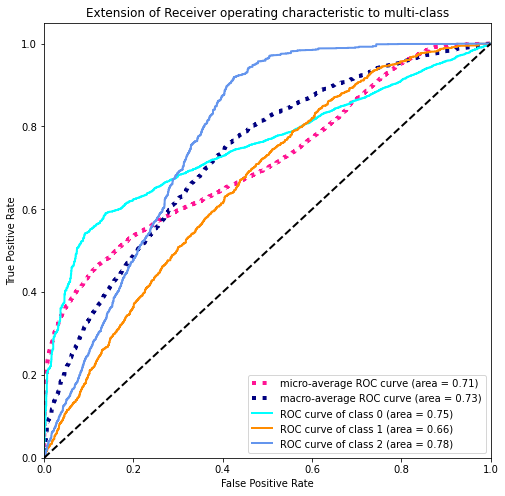

In [27]:
from base_model import XGB
import xgboost as xgb
x_test = test_df[input_feat]
xgb_weight = {}
xgb_metric_dict = defaultdict(list)
for i in range(n_classes):
    xgb_weight[i] = n_samples / (n_classes * label_counter[i])
xgb_weight[0] = xgb_weight[0]-2
xgb_weight[1] = xgb_weight[1]+3
xgb_weight[1] = xgb_weight[1]+3
xgb_test_weight = np.array([xgb_weight[i] for i in y_test])
d_test = xgb.DMatrix(x_test, label = y_test, weight = xgb_test_weight)
xgb_model_dict = load(osp.join(model_folder, f'xgb.joblib'))
eval_xgb_classifer(xgb_model_dict['best_model'], d_test, x_test, y_test, xgb_metric_dict, True,'xgb')

In [28]:
xgb_metric_dict

defaultdict(list,
            {'acc': 0.5498537734856613,
             'balance_acc': 0.5180870937168539,
             'f1_weighted': 0.6230519548792562,
             'f1_macro': 0.4006111911491071,
             'brier_score': 0.5714209992787186,
             'cross_entropy': 0.9759743794181692,
             'macro_auc_ovo': 0.729280692386228,
             'weighted_auc_ovo': 0.744657004923045,
             'macro_auc_ovr': 0.729280692386228,
             'weighted_auc_ovr': 0.744657004923045})

In [42]:
import csv
with open(f"../test/xgb50/None-test.csv",'a',newline="") as f:
    w = csv.writer(f)
    row = list(xgb_metric_dict.values())
    w.writerow(row)

In [43]:
def perm_xgb_impt(model,x_test,y_test,metric_dict,feat):
    if feat in ['ltt_shape_cat', 'gamma_cat']:
        shuffle_cols = pd.DataFrame(x_test, columns=[feat+'_0',feat+'_1',feat+'_2',feat+'_3']).values
        np.random.shuffle(shuffle_cols)
        for i in range(4):
            x_test[feat+'_'+str(i)] = shuffle_cols[:,i]
    else:
        shuffle_col = x_test[feat].values
        np.random.shuffle(shuffle_col)
        x_test[feat] = shuffle_col
    d_test = xgb.DMatrix(x_test, label = y_test, weight = xgb_test_weight)
    eval_xgb_classifer(model, d_test, x_test, y_test, xgb_metric_dict)

In [44]:
for shuffle_feat in feat_col:
    for i in range(50):
        x_test = test_df[input_feat]
        #xgb_metric_dict = defaultdict(list)
        perm_xgb_impt(xgb_model_dict['best_model'],x_test,y_test,xgb_metric_dict,shuffle_feat)
        with open(f"../test/xgb50/{shuffle_feat}-test.csv",'a',newline="") as f:
            w = csv.writer(f)
            row = list(xgb_metric_dict.values())
            w.writerow(row)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.6308148709209115
Test Ballance Acc: 0.4171470364584336
Test Weighted F1: 0.67374620417443
Test F1: 0.39019342167034754
Brier Score: 0.5461008485957631
Cross Entropy Loss: 0.9315368005269392
One-vs-One ROC AUC scores:
0.627750 (macro),
0.640467 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.627750 (macro),
0.640467 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.6313908350691158
Test Ballance Acc: 0.41957464694065455
Test Weighted F1: 0.6741582585756392
Test F1: 0.3920395079216643
Brier Score: 0.5462136671152262
Cross Entropy Loss: 0.931718889044187
One-vs-One ROC AUC scores:
0.627395 (macro),
0.639646 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.627395 (macro),
0.639646 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.6313356056302468
Test Ballance Acc: 0.4179655481362601
Test Weighted F1: 0.6740154042475422
Test F1: 0.39100533591991393
Brier Score: 0.546174117402888
Cross Entropy Loss: 0.9315595075884063
One-vs-One ROC AUC scores:
0.627025 (macro),
0.639053 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.627025 (macro),
0.639053 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.6318300406067874
Test Ballance Acc: 0.41855259818554896
Test Weighted F1: 0.674552034270037
Test F1: 0.39156534030277773
Brier Score: 0.5456588015015845
Cross Entropy Loss: 0.9308601235144933
One-vs-One ROC AUC scores:
0.628062 (macro),
0.640432 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.628062 (macro),
0.640432 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.6318852700456563
Test Ballance Acc: 0.41906601954691985
Test Weighted F1: 0.6746492462379279
Test F1: 0.39173003337769213
Brier Score: 0.54588976480633
Cross Entropy Loss: 0.9311738612533585
One-vs-One ROC AUC scores:
0.628426 (macro),
0.641014 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.628426 (macro),
0.641014 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.6308096109743525
Test Ballance Acc: 0.41786320218041695
Test Weighted F1: 0.6736536626200748
Test F1: 0.3908074837182254
Brier Score: 0.5461234474756509
Cross Entropy Loss: 0.9315238221188913
One-vs-One ROC AUC scores:
0.627515 (macro),
0.639681 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.627515 (macro),
0.639681 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.632519093606009
Test Ballance Acc: 0.41879677061376613
Test Weighted F1: 0.6749430480127965
Test F1: 0.3918389482531015
Brier Score: 0.5457229268703337
Cross Entropy Loss: 0.9309694149885835
One-vs-One ROC AUC scores:
0.627661 (macro),
0.640305 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.627661 (macro),
0.640305 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.6307990910812347
Test Ballance Acc: 0.41715772011137325
Test Weighted F1: 0.6737166268229728
Test F1: 0.3902148150153759
Brier Score: 0.5461960495311715
Cross Entropy Loss: 0.9316440234878374
One-vs-One ROC AUC scores:
0.627045 (macro),
0.639503 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.627045 (macro),
0.639503 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.6316748721832987
Test Ballance Acc: 0.4170992064376277
Test Weighted F1: 0.6742755112293098
Test F1: 0.3904594149760705
Brier Score: 0.5460543574170114
Cross Entropy Loss: 0.9314019513293939
One-vs-One ROC AUC scores:
0.626981 (macro),
0.639094 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.626981 (macro),
0.639094 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.632379705022197
Test Ballance Acc: 0.4193504988465094
Test Weighted F1: 0.674911364722072
Test F1: 0.3922151556384919
Brier Score: 0.5459034669212585
Cross Entropy Loss: 0.9312291263882038
One-vs-One ROC AUC scores:
0.627626 (macro),
0.639976 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.627626 (macro),
0.639976 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.6325506532853626
Test Ballance Acc: 0.4209953608157367
Test Weighted F1: 0.6750887733787783
Test F1: 0.3932110870333038
Brier Score: 0.5459125593968743
Cross Entropy Loss: 0.9312534942845525
One-vs-One ROC AUC scores:
0.628475 (macro),
0.640650 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.628475 (macro),
0.640650 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.6314855141071767
Test Ballance Acc: 0.41817561960900695
Test Weighted F1: 0.674274083810344
Test F1: 0.3911534512805623
Brier Score: 0.54600901721112
Cross Entropy Loss: 0.9313058473810789
One-vs-One ROC AUC scores:
0.628010 (macro),
0.640153 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.628010 (macro),
0.640153 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.6325901028845546
Test Ballance Acc: 0.41803802950644076
Test Weighted F1: 0.6748453171240575
Test F1: 0.3914053303209124
Brier Score: 0.5457220034670338
Cross Entropy Loss: 0.9309071711816518
One-vs-One ROC AUC scores:
0.627345 (macro),
0.639621 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.627345 (macro),
0.639621 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.6323902249153148
Test Ballance Acc: 0.42093034447203787
Test Weighted F1: 0.6749624126552167
Test F1: 0.3931955421165254
Brier Score: 0.5458734858147255
Cross Entropy Loss: 0.9311924596595574
One-vs-One ROC AUC scores:
0.628627 (macro),
0.640360 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.628627 (macro),
0.640360 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.6317800711144774
Test Ballance Acc: 0.41829621957472946
Test Weighted F1: 0.6742713380262375
Test F1: 0.3912898162607196
Brier Score: 0.5460483568052377
Cross Entropy Loss: 0.9314790172603704
One-vs-One ROC AUC scores:
0.627287 (macro),
0.639093 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.627287 (macro),
0.639093 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.6326663721096594
Test Ballance Acc: 0.4195014237744105
Test Weighted F1: 0.6752530124687476
Test F1: 0.39231521833297717
Brier Score: 0.5457637318691808
Cross Entropy Loss: 0.931026328979757
One-vs-One ROC AUC scores:
0.626692 (macro),
0.639298 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.626692 (macro),
0.639298 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.6315223337330893
Test Ballance Acc: 0.4188290426518723
Test Weighted F1: 0.6741831825768438
Test F1: 0.3914477915103451
Brier Score: 0.5462905573682723
Cross Entropy Loss: 0.9318415931301542
One-vs-One ROC AUC scores:
0.626666 (macro),
0.638628 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.626666 (macro),
0.638628 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.6319457594310842
Test Ballance Acc: 0.41807013830038436
Test Weighted F1: 0.6744440176971158
Test F1: 0.39125313330650285
Brier Score: 0.5459500193996814
Cross Entropy Loss: 0.9313436177455324
One-vs-One ROC AUC scores:
0.626847 (macro),
0.639067 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.626847 (macro),
0.639067 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.6320693681752193
Test Ballance Acc: 0.41808876089897934
Test Weighted F1: 0.6746587608818642
Test F1: 0.3912822305789036
Brier Score: 0.5460090335944896
Cross Entropy Loss: 0.9313484586280102
One-vs-One ROC AUC scores:
0.627199 (macro),
0.639797 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.627199 (macro),
0.639797 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.6312803761913779
Test Ballance Acc: 0.4181122680717239
Test Weighted F1: 0.674067856843407
Test F1: 0.3911537284766993
Brier Score: 0.5458513479644724
Cross Entropy Loss: 0.9311010247031875
One-vs-One ROC AUC scores:
0.628013 (macro),
0.640638 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.628013 (macro),
0.640638 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.6320404384691451
Test Ballance Acc: 0.41852076948237765
Test Weighted F1: 0.674717248684587
Test F1: 0.3915948005189716
Brier Score: 0.5456637787096842
Cross Entropy Loss: 0.9308658462982545
One-vs-One ROC AUC scores:
0.627792 (macro),
0.640855 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.627792 (macro),
0.640855 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.6323008058238129
Test Ballance Acc: 0.41942899959004604
Test Weighted F1: 0.6748434719974097
Test F1: 0.3922470008250101
Brier Score: 0.5459001988830392
Cross Entropy Loss: 0.9312495394752538
One-vs-One ROC AUC scores:
0.627868 (macro),
0.640398 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.627868 (macro),
0.640398 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.6321035578278524
Test Ballance Acc: 0.41701926721297516
Test Weighted F1: 0.6745064223907866
Test F1: 0.3905827290754427
Brier Score: 0.5462741789715287
Cross Entropy Loss: 0.9317450060441602
One-vs-One ROC AUC scores:
0.625668 (macro),
0.638005 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.625668 (macro),
0.638005 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.6315302236529277
Test Ballance Acc: 0.41823436073250697
Test Weighted F1: 0.6742611117130102
Test F1: 0.391240331030206
Brier Score: 0.5461405080645163
Cross Entropy Loss: 0.9315190240161553
One-vs-One ROC AUC scores:
0.627026 (macro),
0.639134 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.627026 (macro),
0.639134 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.6313040459508932
Test Ballance Acc: 0.4169211251251148
Test Weighted F1: 0.6740334880438481
Test F1: 0.3903744183665485
Brier Score: 0.5461385685075707
Cross Entropy Loss: 0.9315383271986992
One-vs-One ROC AUC scores:
0.627214 (macro),
0.639908 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.627214 (macro),
0.639908 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.6311383576342864
Test Ballance Acc: 0.4169662192974181
Test Weighted F1: 0.6739075856331165
Test F1: 0.3902903918491692
Brier Score: 0.5463235666996741
Cross Entropy Loss: 0.9318022960848487
One-vs-One ROC AUC scores:
0.626626 (macro),
0.638920 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.626626 (macro),
0.638920 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.6315617833322813
Test Ballance Acc: 0.41919455326419114
Test Weighted F1: 0.6743788474322198
Test F1: 0.3918428835267557
Brier Score: 0.5461091901817714
Cross Entropy Loss: 0.9314863096121835
One-vs-One ROC AUC scores:
0.627708 (macro),
0.639927 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.627708 (macro),
0.639927 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.6330529781817417
Test Ballance Acc: 0.420653097625239
Test Weighted F1: 0.6755110570619443
Test F1: 0.39305468449606057
Brier Score: 0.5456211929239241
Cross Entropy Loss: 0.9308577110824443
One-vs-One ROC AUC scores:
0.628856 (macro),
0.641238 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.628856 (macro),
0.641238 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.6317827010877569
Test Ballance Acc: 0.41738097343984054
Test Weighted F1: 0.6744997141574305
Test F1: 0.39073377405591375
Brier Score: 0.5458400158125759
Cross Entropy Loss: 0.9310591685471028
One-vs-One ROC AUC scores:
0.627879 (macro),
0.640710 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.627879 (macro),
0.640710 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.6333107155631299
Test Ballance Acc: 0.420678481968728
Test Weighted F1: 0.6755947013761333
Test F1: 0.39325653020252377
Brier Score: 0.5457119122002514
Cross Entropy Loss: 0.9309459176556374
One-vs-One ROC AUC scores:
0.628567 (macro),
0.640606 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.628567 (macro),
0.640606 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.6313803151759978
Test Ballance Acc: 0.417839727056099
Test Weighted F1: 0.6742452325747451
Test F1: 0.3907787265929586
Brier Score: 0.5462058017163732
Cross Entropy Loss: 0.9316388424266852
One-vs-One ROC AUC scores:
0.627426 (macro),
0.640079 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.627426 (macro),
0.640079 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.632882029918576
Test Ballance Acc: 0.4198316322743953
Test Weighted F1: 0.6752426731738578
Test F1: 0.39253797643662586
Brier Score: 0.545997966818918
Cross Entropy Loss: 0.9314136312229198
One-vs-One ROC AUC scores:
0.627450 (macro),
0.639546 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.627450 (macro),
0.639546 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.6321745671063982
Test Ballance Acc: 0.4196696868001948
Test Weighted F1: 0.6747025021994701
Test F1: 0.39237735623796083
Brier Score: 0.5459944211075337
Cross Entropy Loss: 0.9313075506992718
One-vs-One ROC AUC scores:
0.626966 (macro),
0.638764 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.626966 (macro),
0.638764 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.6324270445412274
Test Ballance Acc: 0.42128173967417265
Test Weighted F1: 0.6750894655760923
Test F1: 0.39335641492917617
Brier Score: 0.5458336450122019
Cross Entropy Loss: 0.931098900869642
One-vs-One ROC AUC scores:
0.628727 (macro),
0.640704 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.628727 (macro),
0.640704 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.630717561909571
Test Ballance Acc: 0.4179979363064245
Test Weighted F1: 0.6737189461516937
Test F1: 0.39082557804518436
Brier Score: 0.5462000265960467
Cross Entropy Loss: 0.9316598877644492
One-vs-One ROC AUC scores:
0.627187 (macro),
0.639765 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.627187 (macro),
0.639765 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.6327978707736329
Test Ballance Acc: 0.41906041995244664
Test Weighted F1: 0.6750618561201381
Test F1: 0.39201178988047447
Brier Score: 0.5458399721228449
Cross Entropy Loss: 0.9311459556418067
One-vs-One ROC AUC scores:
0.627192 (macro),
0.638939 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.627192 (macro),
0.638939 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.631827410633508
Test Ballance Acc: 0.4171649444550185
Test Weighted F1: 0.6743011977622484
Test F1: 0.39055241891127285
Brier Score: 0.5460039631237062
Cross Entropy Loss: 0.9313710897723735
One-vs-One ROC AUC scores:
0.627070 (macro),
0.639373 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.627070 (macro),
0.639373 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.6321193376675293
Test Ballance Acc: 0.4191334131722111
Test Weighted F1: 0.6747290261869322
Test F1: 0.39198128208872124
Brier Score: 0.5460119425369079
Cross Entropy Loss: 0.931396023557319
One-vs-One ROC AUC scores:
0.627320 (macro),
0.640078 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.627320 (macro),
0.640078 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.6319431294578047
Test Ballance Acc: 0.41780450422985593
Test Weighted F1: 0.6745170870194626
Test F1: 0.3909348040380287
Brier Score: 0.5460436043253445
Cross Entropy Loss: 0.931448896686391
One-vs-One ROC AUC scores:
0.627521 (macro),
0.639725 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.627521 (macro),
0.639725 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.6306886322034968
Test Ballance Acc: 0.41707722911897016
Test Weighted F1: 0.6736130273726032
Test F1: 0.3903358202540795
Brier Score: 0.5463052980719962
Cross Entropy Loss: 0.9317770867144816
One-vs-One ROC AUC scores:
0.626259 (macro),
0.638606 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.626259 (macro),
0.638606 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.6314276546950283
Test Ballance Acc: 0.41841773577884434
Test Weighted F1: 0.674099557699061
Test F1: 0.3913786041031724
Brier Score: 0.5461792335882271
Cross Entropy Loss: 0.9315880815621371
One-vs-One ROC AUC scores:
0.626928 (macro),
0.638869 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.626928 (macro),
0.638869 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.6311699173136401
Test Ballance Acc: 0.418769914167808
Test Weighted F1: 0.6741604073079908
Test F1: 0.391415757758747
Brier Score: 0.5461679822014588
Cross Entropy Loss: 0.9316287593925738
One-vs-One ROC AUC scores:
0.628570 (macro),
0.641082 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.628570 (macro),
0.641082 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.6312724862715395
Test Ballance Acc: 0.418008854040739
Test Weighted F1: 0.6742031627574742
Test F1: 0.39111470244943386
Brier Score: 0.5460425401419136
Cross Entropy Loss: 0.931392724386337
One-vs-One ROC AUC scores:
0.626935 (macro),
0.639949 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.626935 (macro),
0.639949 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.6319773191104379
Test Ballance Acc: 0.42079730425074885
Test Weighted F1: 0.6748506307813221
Test F1: 0.3930065928946453
Brier Score: 0.5459273038480461
Cross Entropy Loss: 0.9312191585487937
One-vs-One ROC AUC scores:
0.628677 (macro),
0.640423 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.628677 (macro),
0.640423 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.6326953018157335
Test Ballance Acc: 0.4189102211125492
Test Weighted F1: 0.6751416783740122
Test F1: 0.39195401469886576
Brier Score: 0.5459231842977276
Cross Entropy Loss: 0.9312983175303112
One-vs-One ROC AUC scores:
0.627278 (macro),
0.639745 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.627278 (macro),
0.639745 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.633066128048139
Test Ballance Acc: 0.4199745054880939
Test Weighted F1: 0.6755587383182137
Test F1: 0.39266952347086637
Brier Score: 0.5454671177362446
Cross Entropy Loss: 0.9305791848130318
One-vs-One ROC AUC scores:
0.628888 (macro),
0.641575 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.628888 (macro),
0.641575 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.630851690546824
Test Ballance Acc: 0.4172212858035695
Test Weighted F1: 0.6735643809148001
Test F1: 0.39056499337784883
Brier Score: 0.5465168066275536
Cross Entropy Loss: 0.9321007115322034
One-vs-One ROC AUC scores:
0.626062 (macro),
0.637953 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.626062 (macro),
0.637953 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.6329162195712091
Test Ballance Acc: 0.42092100352975276
Test Weighted F1: 0.6754411302280737
Test F1: 0.39322577295766065
Brier Score: 0.5457249522195224
Cross Entropy Loss: 0.9309923136597995
One-vs-One ROC AUC scores:
0.628131 (macro),
0.640808 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.628131 (macro),
0.640808 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.6319562793242021
Test Ballance Acc: 0.41892720648693715
Test Weighted F1: 0.6745822204620361
Test F1: 0.3917587559368056
Brier Score: 0.5460097156301887
Cross Entropy Loss: 0.9314167929016971
One-vs-One ROC AUC scores:
0.627320 (macro),
0.640093 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.627320 (macro),
0.640093 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.6320588482821015
Test Ballance Acc: 0.42041376078149173
Test Weighted F1: 0.6748504489300836
Test F1: 0.39272716359514964
Brier Score: 0.546013204910563
Cross Entropy Loss: 0.9313967207627711
One-vs-One ROC AUC scores:
0.628247 (macro),
0.641091 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.628247 (macro),
0.641091 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.6213653769277704
Test Ballance Acc: 0.4037951324872149
Test Weighted F1: 0.662354062178454
Test F1: 0.38088683455294586
Brier Score: 0.5403898895818178
Cross Entropy Loss: 0.9246628055498187
One-vs-One ROC AUC scores:
0.617650 (macro),
0.620817 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.617650 (macro),
0.620817 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.6218335121715164
Test Ballance Acc: 0.4043552469131934
Test Weighted F1: 0.662721683983043
Test F1: 0.3813636404488299
Brier Score: 0.5401742823686085
Cross Entropy Loss: 0.9243615715393121
One-vs-One ROC AUC scores:
0.618260 (macro),
0.621515 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.618260 (macro),
0.621515 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.6214837257253466
Test Ballance Acc: 0.4035885458359705
Test Weighted F1: 0.6624580151804166
Test F1: 0.3808306004208901
Brier Score: 0.5402814199726423
Cross Entropy Loss: 0.9245062603092297
One-vs-One ROC AUC scores:
0.618008 (macro),
0.621215 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.618008 (macro),
0.621215 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.623064339666309
Test Ballance Acc: 0.40482015790907283
Test Weighted F1: 0.6636594994466439
Test F1: 0.38199806260040275
Brier Score: 0.5398098524279452
Cross Entropy Loss: 0.9237873676194216
One-vs-One ROC AUC scores:
0.618304 (macro),
0.621919 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.618304 (macro),
0.621919 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.6215047655115824
Test Ballance Acc: 0.40344080977357905
Test Weighted F1: 0.6623553498664212
Test F1: 0.3807888582914214
Brier Score: 0.5404974642751792
Cross Entropy Loss: 0.9247445712743203
One-vs-One ROC AUC scores:
0.617063 (macro),
0.619662 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.617063 (macro),
0.619662 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.6214442761261546
Test Ballance Acc: 0.4035488290375775
Test Weighted F1: 0.6625110534976946
Test F1: 0.38083494131878926
Brier Score: 0.5401876606510388
Cross Entropy Loss: 0.924284423260993
One-vs-One ROC AUC scores:
0.618363 (macro),
0.621652 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.618363 (macro),
0.621652 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.6224489259189127
Test Ballance Acc: 0.40512816205054863
Test Weighted F1: 0.6631626135855228
Test F1: 0.3820343309959738
Brier Score: 0.5400219674905087
Cross Entropy Loss: 0.9241396507495216
One-vs-One ROC AUC scores:
0.617808 (macro),
0.620886 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.617808 (macro),
0.620886 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.6213601169812115
Test Ballance Acc: 0.40277718734166496
Test Weighted F1: 0.6623267083548308
Test F1: 0.38029880232137475
Brier Score: 0.5401501474623229
Cross Entropy Loss: 0.9243076453033021
One-vs-One ROC AUC scores:
0.617361 (macro),
0.620623 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.617361 (macro),
0.620623 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.6225751646363273
Test Ballance Acc: 0.404435235964153
Test Weighted F1: 0.6632946975093706
Test F1: 0.38164852806253075
Brier Score: 0.539925510537863
Cross Entropy Loss: 0.9240158371560395
One-vs-One ROC AUC scores:
0.617946 (macro),
0.621352 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.617946 (macro),
0.621352 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.6217625028929706
Test Ballance Acc: 0.4041819650804088
Test Weighted F1: 0.6626949514944594
Test F1: 0.38122192108929737
Brier Score: 0.540160258517894
Cross Entropy Loss: 0.9243493026973689
One-vs-One ROC AUC scores:
0.618185 (macro),
0.621620 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.618185 (macro),
0.621620 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.619929411517179
Test Ballance Acc: 0.4018523182126364
Test Weighted F1: 0.6612621132921421
Test F1: 0.3793264151952002
Brier Score: 0.5408130107120557
Cross Entropy Loss: 0.9252040661130279
One-vs-One ROC AUC scores:
0.616594 (macro),
0.620209 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.616594 (macro),
0.620209 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.6216704538281891
Test Ballance Acc: 0.4038058552385153
Test Weighted F1: 0.6626584863685445
Test F1: 0.38102467090075387
Brier Score: 0.5401655256370135
Cross Entropy Loss: 0.9243393719488517
One-vs-One ROC AUC scores:
0.617619 (macro),
0.621266 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.617619 (macro),
0.621266 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.621780912705927
Test Ballance Acc: 0.40325483413078994
Test Weighted F1: 0.662492735277228
Test F1: 0.38074183118421656
Brier Score: 0.5404621876376502
Cross Entropy Loss: 0.9247678492071139
One-vs-One ROC AUC scores:
0.616144 (macro),
0.619537 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.616144 (macro),
0.619537 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.6216388941488354
Test Ballance Acc: 0.40202492748348445
Test Weighted F1: 0.6622164360779633
Test F1: 0.3798950665975503
Brier Score: 0.5405247195623536
Cross Entropy Loss: 0.9248630653887078
One-vs-One ROC AUC scores:
0.615373 (macro),
0.618305 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.615373 (macro),
0.618305 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.6215389551642155
Test Ballance Acc: 0.4035959278766012
Test Weighted F1: 0.6624430846080162
Test F1: 0.38091314454725483
Brier Score: 0.5402929784548434
Cross Entropy Loss: 0.92452948711802
One-vs-One ROC AUC scores:
0.617574 (macro),
0.620810 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.617574 (macro),
0.620810 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.6215152854047002
Test Ballance Acc: 0.40262734713392095
Test Weighted F1: 0.6624404104250965
Test F1: 0.38025835439974903
Brier Score: 0.5401746156139356
Cross Entropy Loss: 0.924284145375217
One-vs-One ROC AUC scores:
0.618453 (macro),
0.621514 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.618453 (macro),
0.621514 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.6216125944160408
Test Ballance Acc: 0.4022215945352883
Test Weighted F1: 0.6623860653894132
Test F1: 0.3799332133859575
Brier Score: 0.540482863654997
Cross Entropy Loss: 0.9247269867381409
One-vs-One ROC AUC scores:
0.616374 (macro),
0.619388 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.616374 (macro),
0.619388 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.6213259273285784
Test Ballance Acc: 0.40405501101337316
Test Weighted F1: 0.6623752275558874
Test F1: 0.3811542430013815
Brier Score: 0.5404543807484778
Cross Entropy Loss: 0.9246939284769968
One-vs-One ROC AUC scores:
0.617290 (macro),
0.620308 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.617290 (macro),
0.620308 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.6210918597067053
Test Ballance Acc: 0.4039528670385721
Test Weighted F1: 0.6621385063375501
Test F1: 0.38099297641839724
Brier Score: 0.5404419705228879
Cross Entropy Loss: 0.9246996781415701
One-vs-One ROC AUC scores:
0.617897 (macro),
0.620520 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.617897 (macro),
0.620520 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.6216152243893202
Test Ballance Acc: 0.40264404874445053
Test Weighted F1: 0.6624432942531013
Test F1: 0.38027564384197904
Brier Score: 0.5401417579938044
Cross Entropy Loss: 0.9242683291375987
One-vs-One ROC AUC scores:
0.617436 (macro),
0.620792 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.617436 (macro),
0.620792 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.621452166045993
Test Ballance Acc: 0.40255550638250476
Test Weighted F1: 0.6624324657490276
Test F1: 0.3801535560727034
Brier Score: 0.5400637067953612
Cross Entropy Loss: 0.9241862017764402
One-vs-One ROC AUC scores:
0.618117 (macro),
0.621486 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.618117 (macro),
0.621486 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.6211497191188537
Test Ballance Acc: 0.40261690264772376
Test Weighted F1: 0.66209677484527
Test F1: 0.3801284168088588
Brier Score: 0.5405019695791295
Cross Entropy Loss: 0.9247783200357232
One-vs-One ROC AUC scores:
0.616451 (macro),
0.619438 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.616451 (macro),
0.619438 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.6213338172484167
Test Ballance Acc: 0.4041441530216318
Test Weighted F1: 0.6622373591033359
Test F1: 0.38116444707182634
Brier Score: 0.5404222620965801
Cross Entropy Loss: 0.9246659470540749
One-vs-One ROC AUC scores:
0.616444 (macro),
0.619668 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.616444 (macro),
0.619668 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.6210865997601465
Test Ballance Acc: 0.40253570805574695
Test Weighted F1: 0.6621310952454026
Test F1: 0.3800840355561774
Brier Score: 0.5400966374618976
Cross Entropy Loss: 0.9241754433675529
One-vs-One ROC AUC scores:
0.617718 (macro),
0.621071 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.617718 (macro),
0.621071 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.6211181594395001
Test Ballance Acc: 0.4013902629889952
Test Weighted F1: 0.6619744592739529
Test F1: 0.3792673953525903
Brier Score: 0.5404345978384251
Cross Entropy Loss: 0.9246716441569331
One-vs-One ROC AUC scores:
0.616971 (macro),
0.620170 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.616971 (macro),
0.620170 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.6211970586378842
Test Ballance Acc: 0.4014280249118902
Test Weighted F1: 0.6620069691861434
Test F1: 0.37933467311976427
Brier Score: 0.5403543284756807
Cross Entropy Loss: 0.9245450359657925
One-vs-One ROC AUC scores:
0.616709 (macro),
0.619450 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.616709 (macro),
0.619450 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.6208683119779503
Test Ballance Acc: 0.4021090698482311
Test Weighted F1: 0.6619498474356101
Test F1: 0.37972519976235536
Brier Score: 0.5404047569167271
Cross Entropy Loss: 0.9246792176187336
One-vs-One ROC AUC scores:
0.617086 (macro),
0.620393 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.617086 (macro),
0.620393 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.6215941846030845
Test Ballance Acc: 0.40314709494915313
Test Weighted F1: 0.6624547216073219
Test F1: 0.3806343010993252
Brier Score: 0.540136777820947
Cross Entropy Loss: 0.9242701887421009
One-vs-One ROC AUC scores:
0.617756 (macro),
0.621135 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.617756 (macro),
0.621135 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.6210944896799848
Test Ballance Acc: 0.40256364396251243
Test Weighted F1: 0.6621772215071914
Test F1: 0.38017205611792054
Brier Score: 0.5402263318901469
Cross Entropy Loss: 0.9243775040574986
One-vs-One ROC AUC scores:
0.618349 (macro),
0.621692 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.618349 (macro),
0.621692 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.6214942456184646
Test Ballance Acc: 0.4029662243104923
Test Weighted F1: 0.6624922260901894
Test F1: 0.38036150432170596
Brier Score: 0.5402808892603586
Cross Entropy Loss: 0.9244670636732305
One-vs-One ROC AUC scores:
0.617355 (macro),
0.620745 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.617355 (macro),
0.620745 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.6213443371415347
Test Ballance Acc: 0.40285699908716294
Test Weighted F1: 0.6623774372650513
Test F1: 0.3803084132282852
Brier Score: 0.5400847924570865
Cross Entropy Loss: 0.9242146825338126
One-vs-One ROC AUC scores:
0.617945 (macro),
0.621495 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.617945 (macro),
0.621495 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.6217493530265733
Test Ballance Acc: 0.4041423271631302
Test Weighted F1: 0.6627938519107396
Test F1: 0.3812159936127329
Brier Score: 0.5400648651277652
Cross Entropy Loss: 0.9241174449937446
One-vs-One ROC AUC scores:
0.618435 (macro),
0.621733 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.618435 (macro),
0.621733 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.6218098424120011
Test Ballance Acc: 0.4030582695379005
Test Weighted F1: 0.6625965321483641
Test F1: 0.38055208647228067
Brier Score: 0.5401185054153614
Cross Entropy Loss: 0.9242883540641977
One-vs-One ROC AUC scores:
0.617583 (macro),
0.621091 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.617583 (macro),
0.621091 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.6219702707820488
Test Ballance Acc: 0.4037530804858722
Test Weighted F1: 0.6628239246385172
Test F1: 0.38107189726221474
Brier Score: 0.5400486819669962
Cross Entropy Loss: 0.9241408199028305
One-vs-One ROC AUC scores:
0.617970 (macro),
0.621232 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.617970 (macro),
0.621232 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.6208762018977887
Test Ballance Acc: 0.40277366491614824
Test Weighted F1: 0.6619247769935522
Test F1: 0.38012740850284277
Brier Score: 0.5403861183036249
Cross Entropy Loss: 0.9246646035260008
One-vs-One ROC AUC scores:
0.617128 (macro),
0.620540 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.617128 (macro),
0.620540 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.6206026846767236
Test Ballance Acc: 0.40230672354050445
Test Weighted F1: 0.6616771795730455
Test F1: 0.3797519429969836
Brier Score: 0.5405907344061792
Cross Entropy Loss: 0.9249487725668301
One-vs-One ROC AUC scores:
0.617535 (macro),
0.620663 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.617535 (macro),
0.620663 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.6206263544362389
Test Ballance Acc: 0.4017571597460606
Test Weighted F1: 0.6617273814861125
Test F1: 0.3794874144033404
Brier Score: 0.5402746243937928
Cross Entropy Loss: 0.9244590207451406
One-vs-One ROC AUC scores:
0.617575 (macro),
0.620778 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.617575 (macro),
0.620778 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.621725683267058
Test Ballance Acc: 0.4036994620875485
Test Weighted F1: 0.6628863380589857
Test F1: 0.38101474414680075
Brier Score: 0.5398473648715598
Cross Entropy Loss: 0.9238574141474833
One-vs-One ROC AUC scores:
0.619607 (macro),
0.623370 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.619607 (macro),
0.623370 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.6214863556986261
Test Ballance Acc: 0.4030989409065888
Test Weighted F1: 0.6625051963284361
Test F1: 0.3804624300909834
Brier Score: 0.5399960576911889
Cross Entropy Loss: 0.9240401942455271
One-vs-One ROC AUC scores:
0.618941 (macro),
0.622166 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.618941 (macro),
0.622166 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.6215494750573334
Test Ballance Acc: 0.40355257774489833
Test Weighted F1: 0.6624682989278359
Test F1: 0.3807951337882532
Brier Score: 0.5400598450689489
Cross Entropy Loss: 0.9241227866998797
One-vs-One ROC AUC scores:
0.618718 (macro),
0.621789 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.618718 (macro),
0.621789 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.6207999326726841
Test Ballance Acc: 0.4003786203145299
Test Weighted F1: 0.6616776110371806
Test F1: 0.37857770939542384
Brier Score: 0.5405002241811422
Cross Entropy Loss: 0.924768805973886
One-vs-One ROC AUC scores:
0.616175 (macro),
0.619255 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.616175 (macro),
0.619255 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.6217677628395295
Test Ballance Acc: 0.40478056047576255
Test Weighted F1: 0.6627914449348953
Test F1: 0.3816811432177001
Brier Score: 0.5399643956139566
Cross Entropy Loss: 0.9240080459071326
One-vs-One ROC AUC scores:
0.619003 (macro),
0.622074 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.619003 (macro),
0.622074 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.6226198741820783
Test Ballance Acc: 0.4043306649986018
Test Weighted F1: 0.6632272222007193
Test F1: 0.38160513314602734
Brier Score: 0.5398526245217687
Cross Entropy Loss: 0.923942868123591
One-vs-One ROC AUC scores:
0.618851 (macro),
0.621978 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.618851 (macro),
0.621978 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.6208209724589198
Test Ballance Acc: 0.4019171739092258
Test Weighted F1: 0.6618431249191697
Test F1: 0.37974415749167684
Brier Score: 0.5404051051248178
Cross Entropy Loss: 0.9246341497257485
One-vs-One ROC AUC scores:
0.617332 (macro),
0.620586 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.617332 (macro),
0.620586 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.6216388941488354
Test Ballance Acc: 0.40285776128483447
Test Weighted F1: 0.6625788679538845
Test F1: 0.3803793225862784
Brier Score: 0.5401123341762561
Cross Entropy Loss: 0.9242370559065689
One-vs-One ROC AUC scores:
0.618056 (macro),
0.621480 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.618056 (macro),
0.621480 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.6208130825390814
Test Ballance Acc: 0.40256265065533753
Test Weighted F1: 0.661901255005721
Test F1: 0.38004226000423347
Brier Score: 0.5404499819476594
Cross Entropy Loss: 0.9247313325873114
One-vs-One ROC AUC scores:
0.617075 (macro),
0.620265 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.617075 (macro),
0.620265 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.6219176713164595
Test Ballance Acc: 0.4035868357045504
Test Weighted F1: 0.6628186701227757
Test F1: 0.38088723494870486
Brier Score: 0.5400364314370761
Cross Entropy Loss: 0.9241318418263151
One-vs-One ROC AUC scores:
0.618386 (macro),
0.621647 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.618386 (macro),
0.621647 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.6219650108354899
Test Ballance Acc: 0.40298270629258576
Test Weighted F1: 0.6628253022287648
Test F1: 0.38052050704728657
Brier Score: 0.539994709211284
Cross Entropy Loss: 0.9240807924062937
One-vs-One ROC AUC scores:
0.617797 (macro),
0.621541 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.617797 (macro),
0.621541 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.6214653159123903
Test Ballance Acc: 0.40404084109649085
Test Weighted F1: 0.6622495025442281
Test F1: 0.38115094867720317
Brier Score: 0.5405790249791235
Cross Entropy Loss: 0.9249180378146031
One-vs-One ROC AUC scores:
0.617381 (macro),
0.620115 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.617381 (macro),
0.620115 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.6214337562330366
Test Ballance Acc: 0.40225419317886907
Test Weighted F1: 0.6624259316176568
Test F1: 0.3798407795822529
Brier Score: 0.5403846860845118
Cross Entropy Loss: 0.9246373547398987
One-vs-One ROC AUC scores:
0.618237 (macro),
0.621636 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.618237 (macro),
0.621636 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5499168928443687
Test Ballance Acc: 0.5177739075024675
Test Weighted F1: 0.6231682147558142
Test F1: 0.40039092488611283
Brier Score: 0.5716731123831599
Cross Entropy Loss: 0.9762941974453737
One-vs-One ROC AUC scores:
0.728956 (macro),
0.744728 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.728956 (macro),
0.744728 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5499537124702814
Test Ballance Acc: 0.5177491983965486
Test Weighted F1: 0.623196493146718
Test F1: 0.40038362651476117
Brier Score: 0.5716573995853826
Cross Entropy Loss: 0.9762698994038026
One-vs-One ROC AUC scores:
0.728996 (macro),
0.744775 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.728996 (macro),
0.744775 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5499431925771634
Test Ballance Acc: 0.5177970391453011
Test Weighted F1: 0.6231895857360276
Test F1: 0.4003966616996235
Brier Score: 0.5716733066229788
Cross Entropy Loss: 0.9762942488932403
One-vs-One ROC AUC scores:
0.728953 (macro),
0.744737 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.728953 (macro),
0.744737 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.549935302657325
Test Ballance Acc: 0.5177416752036196
Test Weighted F1: 0.6231827698091446
Test F1: 0.40037399502188603
Brier Score: 0.5716657897690427
Cross Entropy Loss: 0.9762839437789526
One-vs-One ROC AUC scores:
0.728964 (macro),
0.744729 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.728964 (macro),
0.744729 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5499063729512508
Test Ballance Acc: 0.5177622294529832
Test Weighted F1: 0.6231570525341725
Test F1: 0.40037587665251384
Brier Score: 0.571669491769625
Cross Entropy Loss: 0.9762857242695723
One-vs-One ROC AUC scores:
0.728989 (macro),
0.744795 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.728989 (macro),
0.744795 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5499116328978098
Test Ballance Acc: 0.5176474864011754
Test Weighted F1: 0.6231702403575913
Test F1: 0.4003222322159168
Brier Score: 0.5716766146488281
Cross Entropy Loss: 0.9763008689058298
One-vs-One ROC AUC scores:
0.728945 (macro),
0.744730 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.728945 (macro),
0.744730 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5499431925771634
Test Ballance Acc: 0.5177191870812523
Test Weighted F1: 0.6231939105327238
Test F1: 0.40036911349012133
Brier Score: 0.5716713585601013
Cross Entropy Loss: 0.9762925203536823
One-vs-One ROC AUC scores:
0.728967 (macro),
0.744735 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.728967 (macro),
0.744735 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5499300427107661
Test Ballance Acc: 0.5177454747613741
Test Weighted F1: 0.6231814836114973
Test F1: 0.4003817464667845
Brier Score: 0.5716595778972333
Cross Entropy Loss: 0.9762713936681471
One-vs-One ROC AUC scores:
0.729006 (macro),
0.744787 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.729006 (macro),
0.744787 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5499274127374866
Test Ballance Acc: 0.517736305917107
Test Weighted F1: 0.6231837884554924
Test F1: 0.4003750883259163
Brier Score: 0.571662313529195
Cross Entropy Loss: 0.976277094503193
One-vs-One ROC AUC scores:
0.729002 (macro),
0.744788 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.729002 (macro),
0.744788 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5498958530581329
Test Ballance Acc: 0.5177086508507502
Test Weighted F1: 0.6231503840612802
Test F1: 0.4003425301583024
Brier Score: 0.5716873450866513
Cross Entropy Loss: 0.9763172223469412
One-vs-One ROC AUC scores:
0.728926 (macro),
0.744683 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.728926 (macro),
0.744683 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5499326726840456
Test Ballance Acc: 0.5177641677487093
Test Weighted F1: 0.6231871072261689
Test F1: 0.40038970648818983
Brier Score: 0.5716669923520098
Cross Entropy Loss: 0.976285331807978
One-vs-One ROC AUC scores:
0.728980 (macro),
0.744751 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.728980 (macro),
0.744751 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5499668623366787
Test Ballance Acc: 0.517770760310624
Test Weighted F1: 0.6232135511110117
Test F1: 0.4004015070157038
Brier Score: 0.5716651985634896
Cross Entropy Loss: 0.9762814173024972
One-vs-One ROC AUC scores:
0.728979 (macro),
0.744771 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.728979 (macro),
0.744771 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.549935302657325
Test Ballance Acc: 0.5177159628557114
Test Weighted F1: 0.6231853543684034
Test F1: 0.400363024762913
Brier Score: 0.5716683763704384
Cross Entropy Loss: 0.9762862417972716
One-vs-One ROC AUC scores:
0.728955 (macro),
0.744748 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.728955 (macro),
0.744748 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5499589724168402
Test Ballance Acc: 0.5178013425354114
Test Weighted F1: 0.6232034038771055
Test F1: 0.40041248760776876
Brier Score: 0.5716690920911409
Cross Entropy Loss: 0.9762885792027625
One-vs-One ROC AUC scores:
0.728952 (macro),
0.744725 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.728952 (macro),
0.744725 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5499274127374866
Test Ballance Acc: 0.5177648783463108
Test Weighted F1: 0.6231740751351185
Test F1: 0.40037656053992965
Brier Score: 0.5716626434966439
Cross Entropy Loss: 0.9762779362275549
One-vs-One ROC AUC scores:
0.728991 (macro),
0.744773 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.728991 (macro),
0.744773 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5499563424435607
Test Ballance Acc: 0.517784794609048
Test Weighted F1: 0.6232022165335095
Test F1: 0.4003982661438609
Brier Score: 0.5716638684792053
Cross Entropy Loss: 0.9762779946037607
One-vs-One ROC AUC scores:
0.728985 (macro),
0.744772 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.728985 (macro),
0.744772 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5498984830314124
Test Ballance Acc: 0.5177399569413064
Test Weighted F1: 0.6231581290136801
Test F1: 0.4003707175325
Brier Score: 0.5716758476137164
Cross Entropy Loss: 0.9762971864301518
One-vs-One ROC AUC scores:
0.728936 (macro),
0.744708 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.728936 (macro),
0.744708 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5499063729512508
Test Ballance Acc: 0.5177196138799107
Test Weighted F1: 0.6231619501073179
Test F1: 0.4003590653554288
Brier Score: 0.571674777462089
Cross Entropy Loss: 0.9762967843601946
One-vs-One ROC AUC scores:
0.728974 (macro),
0.744759 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.728974 (macro),
0.744759 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5499300427107661
Test Ballance Acc: 0.5177219074744376
Test Weighted F1: 0.6231814123821398
Test F1: 0.4003652486836288
Brier Score: 0.5716808030748285
Cross Entropy Loss: 0.9763086623252165
One-vs-One ROC AUC scores:
0.728939 (macro),
0.744705 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.728939 (macro),
0.744705 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5499221527909276
Test Ballance Acc: 0.5177546347601966
Test Weighted F1: 0.6231649105167664
Test F1: 0.4003692249935491
Brier Score: 0.5716760493451937
Cross Entropy Loss: 0.9762981589972527
One-vs-One ROC AUC scores:
0.728948 (macro),
0.744731 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.728948 (macro),
0.744731 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5499274127374866
Test Ballance Acc: 0.5177384509780786
Test Weighted F1: 0.6231799682814617
Test F1: 0.4003663969879548
Brier Score: 0.5716577844899553
Cross Entropy Loss: 0.9762680370633922
One-vs-One ROC AUC scores:
0.728976 (macro),
0.744785 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.728976 (macro),
0.744785 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5499458225504429
Test Ballance Acc: 0.5177371650482635
Test Weighted F1: 0.6231951134659258
Test F1: 0.40037688146820355
Brier Score: 0.5716678204970032
Cross Entropy Loss: 0.9762866050063743
One-vs-One ROC AUC scores:
0.728968 (macro),
0.744740 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.728968 (macro),
0.744740 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5499537124702814
Test Ballance Acc: 0.5177337252120321
Test Weighted F1: 0.6231968843596365
Test F1: 0.40037178445463545
Brier Score: 0.5716662804896134
Cross Entropy Loss: 0.976285184308068
One-vs-One ROC AUC scores:
0.728981 (macro),
0.744756 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.728981 (macro),
0.744756 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5498958530581329
Test Ballance Acc: 0.5176667502980017
Test Weighted F1: 0.6231453722093986
Test F1: 0.4003241217052185
Brier Score: 0.5716687948967667
Cross Entropy Loss: 0.9762864194702384
One-vs-One ROC AUC scores:
0.728971 (macro),
0.744770 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.728971 (macro),
0.744770 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5499221527909276
Test Ballance Acc: 0.517694400941636
Test Weighted F1: 0.6231763041164233
Test F1: 0.4003440411124893
Brier Score: 0.5716727868019099
Cross Entropy Loss: 0.9762948624386532
One-vs-One ROC AUC scores:
0.728945 (macro),
0.744730 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.728945 (macro),
0.744730 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5499221527909276
Test Ballance Acc: 0.5176929709009882
Test Weighted F1: 0.6231763408538313
Test F1: 0.40035063609160626
Brier Score: 0.5716659012965297
Cross Entropy Loss: 0.9762855306837243
One-vs-One ROC AUC scores:
0.728960 (macro),
0.744721 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.728960 (macro),
0.744721 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5499458225504429
Test Ballance Acc: 0.5177931087448809
Test Weighted F1: 0.6231938566790342
Test F1: 0.4004148004525836
Brier Score: 0.571667007910264
Cross Entropy Loss: 0.9762861243156189
One-vs-One ROC AUC scores:
0.728968 (macro),
0.744741 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.728968 (macro),
0.744741 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5499274127374866
Test Ballance Acc: 0.5177436849992033
Test Weighted F1: 0.623177390045112
Test F1: 0.4003843544741455
Brier Score: 0.5716774579413557
Cross Entropy Loss: 0.9763013840213275
One-vs-One ROC AUC scores:
0.728952 (macro),
0.744719 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.728952 (macro),
0.744719 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5499221527909276
Test Ballance Acc: 0.5177334414130891
Test Weighted F1: 0.6231763917616848
Test F1: 0.40037634688658424
Brier Score: 0.5716700494918843
Cross Entropy Loss: 0.976289545680261
One-vs-One ROC AUC scores:
0.728962 (macro),
0.744721 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.728962 (macro),
0.744721 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.549974752256517
Test Ballance Acc: 0.5177813636182614
Test Weighted F1: 0.6232256666334628
Test F1: 0.40041248235899557
Brier Score: 0.5716728598542721
Cross Entropy Loss: 0.976295068934436
One-vs-One ROC AUC scores:
0.728946 (macro),
0.744720 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.728946 (macro),
0.744720 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5499300427107661
Test Ballance Acc: 0.51776452304751
Test Weighted F1: 0.6231807044839586
Test F1: 0.40038201234146786
Brier Score: 0.571665318126044
Cross Entropy Loss: 0.9762810183393391
One-vs-One ROC AUC scores:
0.728964 (macro),
0.744743 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.728964 (macro),
0.744743 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.549935302657325
Test Ballance Acc: 0.5177300059995801
Test Weighted F1: 0.6231899971055074
Test F1: 0.4003807510155917
Brier Score: 0.5716702687954066
Cross Entropy Loss: 0.9762915359814816
One-vs-One ROC AUC scores:
0.728975 (macro),
0.744733 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.728975 (macro),
0.744733 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5499221527909276
Test Ballance Acc: 0.5177443955968047
Test Weighted F1: 0.6231756928283475
Test F1: 0.40037057270831
Brier Score: 0.5716619930099345
Cross Entropy Loss: 0.9762729870277687
One-vs-One ROC AUC scores:
0.728984 (macro),
0.744781 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.728984 (macro),
0.744781 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5499247827642071
Test Ballance Acc: 0.5177535644410719
Test Weighted F1: 0.6231730706745879
Test F1: 0.4003763686549373
Brier Score: 0.5716596662008027
Cross Entropy Loss: 0.9762720830604359
One-vs-One ROC AUC scores:
0.728995 (macro),
0.744770 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.728995 (macro),
0.744770 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5499274127374866
Test Ballance Acc: 0.5176891713432337
Test Weighted F1: 0.6231739810371624
Test F1: 0.4003415497944043
Brier Score: 0.571663896129695
Cross Entropy Loss: 0.9762796833296069
One-vs-One ROC AUC scores:
0.728947 (macro),
0.744737 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.728947 (macro),
0.744737 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5499458225504429
Test Ballance Acc: 0.517770971498592
Test Weighted F1: 0.6231942932301624
Test F1: 0.40039032941804226
Brier Score: 0.5716741201177439
Cross Entropy Loss: 0.9762947445593821
One-vs-One ROC AUC scores:
0.728946 (macro),
0.744718 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.728946 (macro),
0.744718 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5499458225504429
Test Ballance Acc: 0.5177540682734278
Test Weighted F1: 0.6231967640900582
Test F1: 0.40038491845346186
Brier Score: 0.5716699869892261
Cross Entropy Loss: 0.9762895216899214
One-vs-One ROC AUC scores:
0.728965 (macro),
0.744731 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.728965 (macro),
0.744731 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5499116328978098
Test Ballance Acc: 0.5176812928515039
Test Weighted F1: 0.6231639310467919
Test F1: 0.40033791261044543
Brier Score: 0.5716704972119325
Cross Entropy Loss: 0.976290363105077
One-vs-One ROC AUC scores:
0.728945 (macro),
0.744730 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.728945 (macro),
0.744730 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5499300427107661
Test Ballance Acc: 0.5177204774337897
Test Weighted F1: 0.6231840882718039
Test F1: 0.4003704415505602
Brier Score: 0.5716697824672726
Cross Entropy Loss: 0.976291028174933
One-vs-One ROC AUC scores:
0.728949 (macro),
0.744707 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.728949 (macro),
0.744707 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5499247827642071
Test Ballance Acc: 0.5176926156021874
Test Weighted F1: 0.6231811559670545
Test F1: 0.40035401623410083
Brier Score: 0.5716691994837408
Cross Entropy Loss: 0.9762869135146339
One-vs-One ROC AUC scores:
0.728970 (macro),
0.744753 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.728970 (macro),
0.744753 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5499221527909276
Test Ballance Acc: 0.5177024950440562
Test Weighted F1: 0.6231798305017557
Test F1: 0.40034844946018505
Brier Score: 0.5716568558566228
Cross Entropy Loss: 0.976267173103133
One-vs-One ROC AUC scores:
0.728991 (macro),
0.744783 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.728991 (macro),
0.744783 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.549935302657325
Test Ballance Acc: 0.5177740516133004
Test Weighted F1: 0.6231829541131386
Test F1: 0.40039381047993944
Brier Score: 0.5716660075982514
Cross Entropy Loss: 0.9762823700782731
One-vs-One ROC AUC scores:
0.728964 (macro),
0.744752 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.728964 (macro),
0.744752 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5499510824970019
Test Ballance Acc: 0.5177216962864696
Test Weighted F1: 0.6231999818326782
Test F1: 0.40037455514215975
Brier Score: 0.5716646279703075
Cross Entropy Loss: 0.9762816344965857
One-vs-One ROC AUC scores:
0.728959 (macro),
0.744730 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.728959 (macro),
0.744730 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5499037429779714
Test Ballance Acc: 0.5177221142396831
Test Weighted F1: 0.6231520451616761
Test F1: 0.4003435440217545
Brier Score: 0.5716702143471056
Cross Entropy Loss: 0.9762887934105209
One-vs-One ROC AUC scores:
0.728950 (macro),
0.744738 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.728950 (macro),
0.744738 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5499431925771634
Test Ballance Acc: 0.517778705879489
Test Weighted F1: 0.6231894318705579
Test F1: 0.40039347139887765
Brier Score: 0.571654205886709
Cross Entropy Loss: 0.9762651348967909
One-vs-One ROC AUC scores:
0.729000 (macro),
0.744782 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.729000 (macro),
0.744782 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5499458225504429
Test Ballance Acc: 0.5178026328879488
Test Weighted F1: 0.6231916447059415
Test F1: 0.4004142679919745
Brier Score: 0.5716737583618429
Cross Entropy Loss: 0.9762942346772711
One-vs-One ROC AUC scores:
0.728969 (macro),
0.744741 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.728969 (macro),
0.744741 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5499326726840456
Test Ballance Acc: 0.5177377403804772
Test Weighted F1: 0.6231824060858672
Test F1: 0.40038219120445756
Brier Score: 0.5716649160309516
Cross Entropy Loss: 0.9762788510673522
One-vs-One ROC AUC scores:
0.728955 (macro),
0.744746 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.728955 (macro),
0.744746 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5499037429779714
Test Ballance Acc: 0.5176735496251621
Test Weighted F1: 0.6231515299265247
Test F1: 0.40031317040569947
Brier Score: 0.5716669565761314
Cross Entropy Loss: 0.9762826128440824
One-vs-One ROC AUC scores:
0.728981 (macro),
0.744770 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.728981 (macro),
0.744770 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5499247827642071
Test Ballance Acc: 0.5177454703386518
Test Weighted F1: 0.623176425388358
Test F1: 0.4003706532084654
Brier Score: 0.5716595087980461
Cross Entropy Loss: 0.9762739725131124
One-vs-One ROC AUC scores:
0.728984 (macro),
0.744755 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.728984 (macro),
0.744755 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5499090029245303
Test Ballance Acc: 0.5177404519282174
Test Weighted F1: 0.6231577332144499
Test F1: 0.40035912104951804
Brier Score: 0.5716797132837795
Cross Entropy Loss: 0.97630451720899
One-vs-One ROC AUC scores:
0.728953 (macro),
0.744722 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.728953 (macro),
0.744722 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5525153064444865
Test Ballance Acc: 0.518076166557956
Test Weighted F1: 0.6251653416818773
Test F1: 0.40182304785384365
Brier Score: 0.5695580072014766
Cross Entropy Loss: 0.9736550175751311
One-vs-One ROC AUC scores:
0.728013 (macro),
0.743488 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.728013 (macro),
0.743488 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5527335942266827
Test Ballance Acc: 0.5186307952122932
Test Weighted F1: 0.625376276355949
Test F1: 0.4021760616361129
Brier Score: 0.5697128607439175
Cross Entropy Loss: 0.9738577315241111
One-vs-One ROC AUC scores:
0.728012 (macro),
0.743610 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.728012 (macro),
0.743610 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5529860716615119
Test Ballance Acc: 0.5189658677022467
Test Weighted F1: 0.6255937953239299
Test F1: 0.40238217363388284
Brier Score: 0.5694879230560687
Cross Entropy Loss: 0.9735186850263847
One-vs-One ROC AUC scores:
0.728164 (macro),
0.743664 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.728164 (macro),
0.743664 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5529176923562457
Test Ballance Acc: 0.5191545773812063
Test Weighted F1: 0.6255329888759138
Test F1: 0.40242519007252237
Brier Score: 0.5696659481295144
Cross Entropy Loss: 0.9738146051503955
One-vs-One ROC AUC scores:
0.727963 (macro),
0.743303 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.727963 (macro),
0.743303 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5527230743335648
Test Ballance Acc: 0.5190190744041591
Test Weighted F1: 0.6253408621069894
Test F1: 0.40238419847390433
Brier Score: 0.5694627267891512
Cross Entropy Loss: 0.9735095226321397
One-vs-One ROC AUC scores:
0.728296 (macro),
0.743888 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.728296 (macro),
0.743888 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5527809337457131
Test Ballance Acc: 0.518928256896623
Test Weighted F1: 0.625378937104787
Test F1: 0.40216858132984074
Brier Score: 0.5694510154740033
Cross Entropy Loss: 0.9734543333930008
One-vs-One ROC AUC scores:
0.728393 (macro),
0.743939 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.728393 (macro),
0.743939 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5523916977003513
Test Ballance Acc: 0.5178296795460547
Test Weighted F1: 0.6252119386748628
Test F1: 0.40177035160191577
Brier Score: 0.569594476281007
Cross Entropy Loss: 0.9736934030271104
One-vs-One ROC AUC scores:
0.728050 (macro),
0.743647 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.728050 (macro),
0.743647 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5528361631845821
Test Ballance Acc: 0.5193312209054072
Test Weighted F1: 0.6254978062658161
Test F1: 0.4025263296317112
Brier Score: 0.5694917238536384
Cross Entropy Loss: 0.9735709410547582
One-vs-One ROC AUC scores:
0.728324 (macro),
0.743722 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.728324 (macro),
0.743722 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5526573250015779
Test Ballance Acc: 0.5184810762437229
Test Weighted F1: 0.6253058309606827
Test F1: 0.4020448107783457
Brier Score: 0.5695602850071596
Cross Entropy Loss: 0.9736112953245806
One-vs-One ROC AUC scores:
0.728090 (macro),
0.744041 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.728090 (macro),
0.744041 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.552567905910076
Test Ballance Acc: 0.5184804865322247
Test Weighted F1: 0.6251961106005951
Test F1: 0.40201089447744476
Brier Score: 0.5695401602540253
Cross Entropy Loss: 0.9736252101757235
One-vs-One ROC AUC scores:
0.727930 (macro),
0.743359 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.727930 (macro),
0.743359 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5525284563108839
Test Ballance Acc: 0.5185774255757932
Test Weighted F1: 0.6252493419715148
Test F1: 0.4020950684344966
Brier Score: 0.5694794392500385
Cross Entropy Loss: 0.973533593491198
One-vs-One ROC AUC scores:
0.728052 (macro),
0.743667 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.728052 (macro),
0.743667 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5526888846809317
Test Ballance Acc: 0.5185058996125352
Test Weighted F1: 0.6253891890975873
Test F1: 0.4019968922261385
Brier Score: 0.5695112363726362
Cross Entropy Loss: 0.9735830432034221
One-vs-One ROC AUC scores:
0.728204 (macro),
0.743840 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.728204 (macro),
0.743840 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5530860106461318
Test Ballance Acc: 0.5196735700185426
Test Weighted F1: 0.6255499944265241
Test F1: 0.4027021918328329
Brier Score: 0.5694263525177904
Cross Entropy Loss: 0.9734415246853327
One-vs-One ROC AUC scores:
0.728181 (macro),
0.743520 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.728181 (macro),
0.743520 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5527704138525953
Test Ballance Acc: 0.518258039702307
Test Weighted F1: 0.6253775143372379
Test F1: 0.40196276822212457
Brier Score: 0.5694995163028295
Cross Entropy Loss: 0.9735491340864129
One-vs-One ROC AUC scores:
0.728057 (macro),
0.743592 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.728057 (macro),
0.743592 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5524732268720149
Test Ballance Acc: 0.5186408021634747
Test Weighted F1: 0.6252060307307633
Test F1: 0.40210752294463964
Brier Score: 0.5694997036263472
Cross Entropy Loss: 0.9735686430681826
One-vs-One ROC AUC scores:
0.728131 (macro),
0.743710 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.728131 (macro),
0.743710 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5530360411538219
Test Ballance Acc: 0.5196438830429903
Test Weighted F1: 0.6255741920579562
Test F1: 0.4025805341090474
Brier Score: 0.5696070134530841
Cross Entropy Loss: 0.9737352149178518
One-vs-One ROC AUC scores:
0.728031 (macro),
0.743440 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.728031 (macro),
0.743440 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5525074165246481
Test Ballance Acc: 0.5187769003641124
Test Weighted F1: 0.6251818174724199
Test F1: 0.40219644311130515
Brier Score: 0.5696420108992927
Cross Entropy Loss: 0.9737480320253522
One-vs-One ROC AUC scores:
0.727760 (macro),
0.743475 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.727760 (macro),
0.743475 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5528756127837741
Test Ballance Acc: 0.5192059099277412
Test Weighted F1: 0.6254813548175303
Test F1: 0.40255882441985585
Brier Score: 0.5694891326574424
Cross Entropy Loss: 0.9735290331091516
One-vs-One ROC AUC scores:
0.728399 (macro),
0.743892 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.728399 (macro),
0.743892 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5527651539060363
Test Ballance Acc: 0.5186098856641288
Test Weighted F1: 0.6253847874999467
Test F1: 0.40217289421154484
Brier Score: 0.5695965560663542
Cross Entropy Loss: 0.973668802350947
One-vs-One ROC AUC scores:
0.727958 (macro),
0.743578 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.727958 (macro),
0.743578 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5525994655894296
Test Ballance Acc: 0.5186615001706008
Test Weighted F1: 0.6251949879841825
Test F1: 0.4019819090647762
Brier Score: 0.5695358265647746
Cross Entropy Loss: 0.9735911434915301
One-vs-One ROC AUC scores:
0.728171 (macro),
0.743574 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.728171 (macro),
0.743574 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5530176313408656
Test Ballance Acc: 0.5194944132194727
Test Weighted F1: 0.6256189095373439
Test F1: 0.40269917143774364
Brier Score: 0.5693944804191504
Cross Entropy Loss: 0.9733976857528336
One-vs-One ROC AUC scores:
0.728300 (macro),
0.743706 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.728300 (macro),
0.743706 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5527335942266827
Test Ballance Acc: 0.5190412204958927
Test Weighted F1: 0.6253368589739885
Test F1: 0.4023975768603653
Brier Score: 0.5694068376834148
Cross Entropy Loss: 0.9734252364859846
One-vs-One ROC AUC scores:
0.728124 (macro),
0.743445 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.728124 (macro),
0.743445 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5527204443602853
Test Ballance Acc: 0.5195860736398743
Test Weighted F1: 0.6252851497305274
Test F1: 0.4025165392244212
Brier Score: 0.5696045355647971
Cross Entropy Loss: 0.9737130382730915
One-vs-One ROC AUC scores:
0.728273 (macro),
0.743709 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.728273 (macro),
0.743709 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5527993435586694
Test Ballance Acc: 0.5193807268438041
Test Weighted F1: 0.6254131364758592
Test F1: 0.40240353437791737
Brier Score: 0.569488723664578
Cross Entropy Loss: 0.9735421974942975
One-vs-One ROC AUC scores:
0.728442 (macro),
0.743943 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.728442 (macro),
0.743943 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5527651539060363
Test Ballance Acc: 0.5190660722484565
Test Weighted F1: 0.6253686451780744
Test F1: 0.40226140541701705
Brier Score: 0.5696333226765637
Cross Entropy Loss: 0.9737232621616447
One-vs-One ROC AUC scores:
0.727870 (macro),
0.743459 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.727870 (macro),
0.743459 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5525363462307223
Test Ballance Acc: 0.5189405942882986
Test Weighted F1: 0.6252317393996232
Test F1: 0.4023571880346118
Brier Score: 0.569574004573372
Cross Entropy Loss: 0.9736635008529285
One-vs-One ROC AUC scores:
0.728166 (macro),
0.743846 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.728166 (macro),
0.743846 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5526573250015779
Test Ballance Acc: 0.5185732003304978
Test Weighted F1: 0.6253596642669955
Test F1: 0.40211104550231025
Brier Score: 0.569569212497823
Cross Entropy Loss: 0.973654128926251
One-vs-One ROC AUC scores:
0.728115 (macro),
0.743793 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.728115 (macro),
0.743793 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5526310252687833
Test Ballance Acc: 0.5187943785684196
Test Weighted F1: 0.6253002489543034
Test F1: 0.40205946892792194
Brier Score: 0.5696561526404657
Cross Entropy Loss: 0.9737836629014037
One-vs-One ROC AUC scores:
0.727652 (macro),
0.743417 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.727652 (macro),
0.743417 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5524390372193818
Test Ballance Acc: 0.5182973462600658
Test Weighted F1: 0.6251388000306737
Test F1: 0.40191511180957346
Brier Score: 0.5696593891347822
Cross Entropy Loss: 0.9737773435599264
One-vs-One ROC AUC scores:
0.727814 (macro),
0.743404 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.727814 (macro),
0.743404 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5526731048412548
Test Ballance Acc: 0.5186008421286873
Test Weighted F1: 0.6253775728816288
Test F1: 0.4021125083879746
Brier Score: 0.5696225168117418
Cross Entropy Loss: 0.9737470809981403
One-vs-One ROC AUC scores:
0.727785 (macro),
0.743323 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.727785 (macro),
0.743323 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5528572029708179
Test Ballance Acc: 0.5186415525873256
Test Weighted F1: 0.6255167023693637
Test F1: 0.40223930154760884
Brier Score: 0.5695339242338356
Cross Entropy Loss: 0.9735969284672372
One-vs-One ROC AUC scores:
0.728012 (macro),
0.743442 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.728012 (macro),
0.743442 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5525652759367965
Test Ballance Acc: 0.518751751191368
Test Weighted F1: 0.6252393392791689
Test F1: 0.4021719830586055
Brier Score: 0.5696135714393239
Cross Entropy Loss: 0.9737011652041118
One-vs-One ROC AUC scores:
0.728140 (macro),
0.743813 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.728140 (macro),
0.743813 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5520813608533738
Test Ballance Acc: 0.5182314073727504
Test Weighted F1: 0.6248426443766432
Test F1: 0.40176133200057146
Brier Score: 0.5695339171619893
Cross Entropy Loss: 0.973611270967269
One-vs-One ROC AUC scores:
0.728163 (macro),
0.743861 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.728163 (macro),
0.743861 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5523259483683646
Test Ballance Acc: 0.51763503667753
Test Weighted F1: 0.6250990058303826
Test F1: 0.4014285549391305
Brier Score: 0.5695248292907952
Cross Entropy Loss: 0.9735857310520637
One-vs-One ROC AUC scores:
0.727993 (macro),
0.743737 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.727993 (macro),
0.743737 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5524258873529845
Test Ballance Acc: 0.5185277305714509
Test Weighted F1: 0.6250510301580458
Test F1: 0.40179454321938013
Brier Score: 0.5695867679597683
Cross Entropy Loss: 0.9736616270337894
One-vs-One ROC AUC scores:
0.728272 (macro),
0.743786 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.728272 (macro),
0.743786 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5530413011003809
Test Ballance Acc: 0.5190024236574001
Test Weighted F1: 0.6256836374459938
Test F1: 0.402602931188114
Brier Score: 0.5694835070819374
Cross Entropy Loss: 0.9735418594772461
One-vs-One ROC AUC scores:
0.728162 (macro),
0.743491 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.728162 (macro),
0.743491 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5524942666582507
Test Ballance Acc: 0.5176842857281363
Test Weighted F1: 0.6251970172398353
Test F1: 0.40157079721737166
Brier Score: 0.5695443995871446
Cross Entropy Loss: 0.9736265934885091
One-vs-One ROC AUC scores:
0.727998 (macro),
0.743715 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.727998 (macro),
0.743715 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.553075490753014
Test Ballance Acc: 0.5194625999849558
Test Weighted F1: 0.6256277099961942
Test F1: 0.4026452925597663
Brier Score: 0.5695098967965281
Cross Entropy Loss: 0.9735732256072765
One-vs-One ROC AUC scores:
0.728117 (macro),
0.743736 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.728117 (macro),
0.743736 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5525731658566349
Test Ballance Acc: 0.5183907408080013
Test Weighted F1: 0.6252390538185354
Test F1: 0.4019597704673929
Brier Score: 0.5695049694123466
Cross Entropy Loss: 0.9735579949430624
One-vs-One ROC AUC scores:
0.727797 (macro),
0.743430 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.727797 (macro),
0.743430 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5525994655894296
Test Ballance Acc: 0.5183595592899715
Test Weighted F1: 0.6253483658987409
Test F1: 0.4020466746337737
Brier Score: 0.569625819163617
Cross Entropy Loss: 0.9737290931610566
One-vs-One ROC AUC scores:
0.727799 (macro),
0.743275 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.727799 (macro),
0.743275 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5526757348145342
Test Ballance Acc: 0.5190433169069181
Test Weighted F1: 0.6252818175256637
Test F1: 0.40229010094995643
Brier Score: 0.5694664917568256
Cross Entropy Loss: 0.9734844467290427
One-vs-One ROC AUC scores:
0.728209 (macro),
0.743890 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.728209 (macro),
0.743890 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5525153064444865
Test Ballance Acc: 0.5179771211467998
Test Weighted F1: 0.625218393091111
Test F1: 0.40180616330921476
Brier Score: 0.5695651996657454
Cross Entropy Loss: 0.9736255466414915
One-vs-One ROC AUC scores:
0.727849 (macro),
0.743616 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.727849 (macro),
0.743616 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5523259483683646
Test Ballance Acc: 0.5185382583095787
Test Weighted F1: 0.6250293518148047
Test F1: 0.4019509541113899
Brier Score: 0.5698166435226759
Cross Entropy Loss: 0.9739937437253247
One-vs-One ROC AUC scores:
0.727573 (macro),
0.743180 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.727573 (macro),
0.743180 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5527677838793158
Test Ballance Acc: 0.5184307450917603
Test Weighted F1: 0.6254089980343626
Test F1: 0.4021024978131011
Brier Score: 0.5695818177305926
Cross Entropy Loss: 0.9736850301127135
One-vs-One ROC AUC scores:
0.727620 (macro),
0.742998 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.727620 (macro),
0.742998 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5524311472995435
Test Ballance Acc: 0.5179879477994548
Test Weighted F1: 0.6251848743307613
Test F1: 0.40182209027538157
Brier Score: 0.5695277878962635
Cross Entropy Loss: 0.9735994845208312
One-vs-One ROC AUC scores:
0.728059 (macro),
0.743450 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.728059 (macro),
0.743450 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5528703528372152
Test Ballance Acc: 0.5193704187558602
Test Weighted F1: 0.6254750935679827
Test F1: 0.40260571229371317
Brier Score: 0.569599964040538
Cross Entropy Loss: 0.9737137562558803
One-vs-One ROC AUC scores:
0.727975 (macro),
0.743593 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.727975 (macro),
0.743593 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5529071724631278
Test Ballance Acc: 0.5196823441125779
Test Weighted F1: 0.6254831931285465
Test F1: 0.4027412147503951
Brier Score: 0.5694051661007304
Cross Entropy Loss: 0.9734404490843944
One-vs-One ROC AUC scores:
0.728500 (macro),
0.743988 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.728500 (macro),
0.743988 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5523180584485262
Test Ballance Acc: 0.518525996082436
Test Weighted F1: 0.6250385626940385
Test F1: 0.40188934591140163
Brier Score: 0.5695728791103997
Cross Entropy Loss: 0.973678604081474
One-vs-One ROC AUC scores:
0.728223 (macro),
0.743766 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.728223 (macro),
0.743766 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5529834416882324
Test Ballance Acc: 0.5197563560780712
Test Weighted F1: 0.6255651369138545
Test F1: 0.4028431709787708
Brier Score: 0.569472287417003
Cross Entropy Loss: 0.9735041873411161
One-vs-One ROC AUC scores:
0.728484 (macro),
0.743918 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.728484 (macro),
0.743918 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5524101075133077
Test Ballance Acc: 0.5178696359161669
Test Weighted F1: 0.6250955343881315
Test F1: 0.4016266035716636
Brier Score: 0.5695175954094256
Cross Entropy Loss: 0.9735674382516599
One-vs-One ROC AUC scores:
0.728065 (macro),
0.743694 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.728065 (macro),
0.743694 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5592401481200951
Test Ballance Acc: 0.4971498573771989
Test Weighted F1: 0.6315288155753533
Test F1: 0.40048846555679446
Brier Score: 0.5605979341511264
Cross Entropy Loss: 0.9614271012138044
One-vs-One ROC AUC scores:
0.718067 (macro),
0.733728 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.718067 (macro),
0.733728 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5593506069978329
Test Ballance Acc: 0.49663736221570914
Test Weighted F1: 0.6317051636639573
Test F1: 0.4004406661749927
Brier Score: 0.5605841996432236
Cross Entropy Loss: 0.9613936950017365
One-vs-One ROC AUC scores:
0.718207 (macro),
0.734130 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.718207 (macro),
0.734130 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5596293841654569
Test Ballance Acc: 0.4976105460210741
Test Weighted F1: 0.6319103952736035
Test F1: 0.4008578665452489
Brier Score: 0.5603395095925298
Cross Entropy Loss: 0.9609930135557218
One-vs-One ROC AUC scores:
0.718452 (macro),
0.734965 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.718452 (macro),
0.734965 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5590429001241347
Test Ballance Acc: 0.4955648363153067
Test Weighted F1: 0.6314398953238537
Test F1: 0.39979154393810973
Brier Score: 0.5603727092942041
Cross Entropy Loss: 0.9610938682825985
One-vs-One ROC AUC scores:
0.717855 (macro),
0.733802 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.717855 (macro),
0.733802 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5601606387679101
Test Ballance Acc: 0.4978706604374549
Test Weighted F1: 0.6322958963718914
Test F1: 0.4013250047048274
Brier Score: 0.5601896560823596
Cross Entropy Loss: 0.9608279108614279
One-vs-One ROC AUC scores:
0.719232 (macro),
0.734747 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.719232 (macro),
0.734747 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5592191083338593
Test Ballance Acc: 0.49657006812095633
Test Weighted F1: 0.6315241047433611
Test F1: 0.4003487984497381
Brier Score: 0.5604681482630356
Cross Entropy Loss: 0.9612301468024474
One-vs-One ROC AUC scores:
0.718438 (macro),
0.734317 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.718438 (macro),
0.734317 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5595189252877191
Test Ballance Acc: 0.49687926757239675
Test Weighted F1: 0.6317915186707336
Test F1: 0.4005349927188939
Brier Score: 0.5604453767885094
Cross Entropy Loss: 0.961132075760948
One-vs-One ROC AUC scores:
0.718814 (macro),
0.734350 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.718814 (macro),
0.734350 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5597766626691073
Test Ballance Acc: 0.4984125856733694
Test Weighted F1: 0.6318770647121659
Test F1: 0.40124455603918224
Brier Score: 0.5604448407049116
Cross Entropy Loss: 0.9611606202275329
One-vs-One ROC AUC scores:
0.718705 (macro),
0.734329 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.718705 (macro),
0.734329 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5597714027225483
Test Ballance Acc: 0.49772927365708824
Test Weighted F1: 0.6319585764653839
Test F1: 0.40100698345356806
Brier Score: 0.5603041756961791
Cross Entropy Loss: 0.9609891140562735
One-vs-One ROC AUC scores:
0.719067 (macro),
0.735005 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.719067 (macro),
0.735005 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5601001493824823
Test Ballance Acc: 0.49740056524675796
Test Weighted F1: 0.6322456251500196
Test F1: 0.4009956334150231
Brier Score: 0.5602703447800238
Cross Entropy Loss: 0.9609129570687754
One-vs-One ROC AUC scores:
0.718773 (macro),
0.734631 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.718773 (macro),
0.734631 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5597188032569589
Test Ballance Acc: 0.4979101597644036
Test Weighted F1: 0.6318545927605936
Test F1: 0.4010448017561831
Brier Score: 0.5605646840759069
Cross Entropy Loss: 0.961352935395029
One-vs-One ROC AUC scores:
0.718461 (macro),
0.734154 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.718461 (macro),
0.734154 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.559574154726588
Test Ballance Acc: 0.4972644412243376
Test Weighted F1: 0.6318094265324916
Test F1: 0.4006967064342153
Brier Score: 0.5604199039211718
Cross Entropy Loss: 0.9611266477300339
One-vs-One ROC AUC scores:
0.718707 (macro),
0.734238 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.718707 (macro),
0.734238 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5592401481200951
Test Ballance Acc: 0.4968520345071578
Test Weighted F1: 0.6315253293733561
Test F1: 0.40037136758325537
Brier Score: 0.5604683572394668
Cross Entropy Loss: 0.9611986101154297
One-vs-One ROC AUC scores:
0.718181 (macro),
0.734174 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.718181 (macro),
0.734174 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5594978855014833
Test Ballance Acc: 0.4971756143271493
Test Weighted F1: 0.631794835530267
Test F1: 0.4007073398074579
Brier Score: 0.5604620904505534
Cross Entropy Loss: 0.9612030179562085
One-vs-One ROC AUC scores:
0.718686 (macro),
0.734430 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.718686 (macro),
0.734430 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5601764186075869
Test Ballance Acc: 0.4984228167409528
Test Weighted F1: 0.6322388804408446
Test F1: 0.40151784021146525
Brier Score: 0.5601468626286746
Cross Entropy Loss: 0.9607283540069116
One-vs-One ROC AUC scores:
0.719154 (macro),
0.735172 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.719154 (macro),
0.735172 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5595110353678807
Test Ballance Acc: 0.4961277540550781
Test Weighted F1: 0.6318364950412856
Test F1: 0.40021635709454056
Brier Score: 0.5604688297508503
Cross Entropy Loss: 0.9611604273173929
One-vs-One ROC AUC scores:
0.718235 (macro),
0.734327 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.718235 (macro),
0.734327 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5593637568642302
Test Ballance Acc: 0.49682057729933043
Test Weighted F1: 0.6316846947620945
Test F1: 0.40052965122594353
Brier Score: 0.5604096611638807
Cross Entropy Loss: 0.9611376330935854
One-vs-One ROC AUC scores:
0.718394 (macro),
0.734196 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.718394 (macro),
0.734196 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5598687117338887
Test Ballance Acc: 0.4982366376311859
Test Weighted F1: 0.6319768252947873
Test F1: 0.40124441963379837
Brier Score: 0.560404127233807
Cross Entropy Loss: 0.9610899373343136
One-vs-One ROC AUC scores:
0.718445 (macro),
0.734563 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.718445 (macro),
0.734563 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5593690168107892
Test Ballance Acc: 0.4968303915114807
Test Weighted F1: 0.6316665394785167
Test F1: 0.40044805442426296
Brier Score: 0.5605257800489695
Cross Entropy Loss: 0.9612968359464289
One-vs-One ROC AUC scores:
0.718501 (macro),
0.734237 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.718501 (macro),
0.734237 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5594189863030992
Test Ballance Acc: 0.4957985499082003
Test Weighted F1: 0.6317857997155354
Test F1: 0.39996676984185003
Brier Score: 0.5603625603565094
Cross Entropy Loss: 0.9610744054251723
One-vs-One ROC AUC scores:
0.718287 (macro),
0.734128 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.718287 (macro),
0.734128 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5588193523953796
Test Ballance Acc: 0.4963058309181945
Test Weighted F1: 0.6311315393239015
Test F1: 0.3999578344285215
Brier Score: 0.5608069994421443
Cross Entropy Loss: 0.9616939425434742
One-vs-One ROC AUC scores:
0.717550 (macro),
0.733685 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.717550 (macro),
0.733685 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.559200698520903
Test Ballance Acc: 0.4969906736083686
Test Weighted F1: 0.6314350124234103
Test F1: 0.4003721429400384
Brier Score: 0.5605891892448375
Cross Entropy Loss: 0.9613702123145135
One-vs-One ROC AUC scores:
0.718480 (macro),
0.734025 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.718480 (macro),
0.734025 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5600107302909803
Test Ballance Acc: 0.49775634492060483
Test Weighted F1: 0.6322371139976871
Test F1: 0.4011564939797236
Brier Score: 0.5601710717313167
Cross Entropy Loss: 0.9607670033822547
One-vs-One ROC AUC scores:
0.719034 (macro),
0.734867 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.719034 (macro),
0.734867 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5597109133371205
Test Ballance Acc: 0.497818100907347
Test Weighted F1: 0.631888095425926
Test F1: 0.40106849061023625
Brier Score: 0.5604916760887411
Cross Entropy Loss: 0.9612375544866743
One-vs-One ROC AUC scores:
0.718484 (macro),
0.734362 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.718484 (macro),
0.734362 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5587115234909213
Test Ballance Acc: 0.49523181416173756
Test Weighted F1: 0.6312456210954286
Test F1: 0.39952198367265623
Brier Score: 0.5605531064397586
Cross Entropy Loss: 0.9613576418063543
One-vs-One ROC AUC scores:
0.717859 (macro),
0.733915 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.717859 (macro),
0.733915 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5594189863030992
Test Ballance Acc: 0.4973590811395394
Test Weighted F1: 0.6316994460571365
Test F1: 0.4007359984845083
Brier Score: 0.5605075164064998
Cross Entropy Loss: 0.9612290179483319
One-vs-One ROC AUC scores:
0.718316 (macro),
0.733968 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.718316 (macro),
0.733968 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5598766016537272
Test Ballance Acc: 0.4977961446480165
Test Weighted F1: 0.6319119834965972
Test F1: 0.40096578411493905
Brier Score: 0.5602261877501474
Cross Entropy Loss: 0.9608875478872835
One-vs-One ROC AUC scores:
0.718904 (macro),
0.734541 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.718904 (macro),
0.734541 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5591217993225189
Test Ballance Acc: 0.4963703084225764
Test Weighted F1: 0.6315529599400234
Test F1: 0.4002104595904786
Brier Score: 0.5605778526297935
Cross Entropy Loss: 0.9613465694616753
One-vs-One ROC AUC scores:
0.718371 (macro),
0.734371 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.718371 (macro),
0.734371 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.559758252856151
Test Ballance Acc: 0.49686661172788765
Test Weighted F1: 0.6320038270758257
Test F1: 0.400598146438453
Brier Score: 0.560436946551673
Cross Entropy Loss: 0.9611309950000645
One-vs-One ROC AUC scores:
0.718224 (macro),
0.734290 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.718224 (macro),
0.734290 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5599213111994782
Test Ballance Acc: 0.4981634055626644
Test Weighted F1: 0.6320259424793585
Test F1: 0.40116847752267515
Brier Score: 0.5603742291079836
Cross Entropy Loss: 0.9610999935457705
One-vs-One ROC AUC scores:
0.718777 (macro),
0.734406 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.718777 (macro),
0.734406 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5599265711460372
Test Ballance Acc: 0.49789436003965587
Test Weighted F1: 0.6320454739511724
Test F1: 0.40109727971476333
Brier Score: 0.5601722467513303
Cross Entropy Loss: 0.9607730070052813
One-vs-One ROC AUC scores:
0.719083 (macro),
0.734724 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.719083 (macro),
0.734724 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5594847356350859
Test Ballance Acc: 0.49735646174108067
Test Weighted F1: 0.6316709218000994
Test F1: 0.4006821993064846
Brier Score: 0.560622482305195
Cross Entropy Loss: 0.9614325630681347
One-vs-One ROC AUC scores:
0.718043 (macro),
0.733801 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.718043 (macro),
0.733801 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5594873656083654
Test Ballance Acc: 0.4976018463636831
Test Weighted F1: 0.631707359696838
Test F1: 0.4007187546039557
Brier Score: 0.5605507924282089
Cross Entropy Loss: 0.9613499479553422
One-vs-One ROC AUC scores:
0.718468 (macro),
0.734034 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.718468 (macro),
0.734034 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5597424730164742
Test Ballance Acc: 0.49812364342592996
Test Weighted F1: 0.6318408889428287
Test F1: 0.4011197166147115
Brier Score: 0.5603463352920617
Cross Entropy Loss: 0.9610777983353027
One-vs-One ROC AUC scores:
0.718565 (macro),
0.734073 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.718565 (macro),
0.734073 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5595504849670727
Test Ballance Acc: 0.49743918883261956
Test Weighted F1: 0.631838556744251
Test F1: 0.40092191689769385
Brier Score: 0.5604297065006678
Cross Entropy Loss: 0.961172981288693
One-vs-One ROC AUC scores:
0.718834 (macro),
0.734157 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.718834 (macro),
0.734157 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5589876706852659
Test Ballance Acc: 0.4968404404676512
Test Weighted F1: 0.6314224567855999
Test F1: 0.4003903401896347
Brier Score: 0.5606171581581296
Cross Entropy Loss: 0.9614437342532798
One-vs-One ROC AUC scores:
0.717976 (macro),
0.733822 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.717976 (macro),
0.733822 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5594952555282038
Test Ballance Acc: 0.49750502451138406
Test Weighted F1: 0.6316665694831295
Test F1: 0.40078411291768123
Brier Score: 0.5605475316494246
Cross Entropy Loss: 0.9612895337290902
One-vs-One ROC AUC scores:
0.717974 (macro),
0.733987 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.717974 (macro),
0.733987 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5601132992488796
Test Ballance Acc: 0.498293057534455
Test Weighted F1: 0.6321994090328863
Test F1: 0.40129432941795845
Brier Score: 0.5603553035154161
Cross Entropy Loss: 0.9610089020692546
One-vs-One ROC AUC scores:
0.718559 (macro),
0.734702 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.718559 (macro),
0.734702 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5591375791621958
Test Ballance Acc: 0.49612206410190746
Test Weighted F1: 0.631531904319777
Test F1: 0.4000372047506935
Brier Score: 0.5606209261151675
Cross Entropy Loss: 0.9614388016224881
One-vs-One ROC AUC scores:
0.717913 (macro),
0.733764 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.717913 (macro),
0.733764 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5590534200172527
Test Ballance Acc: 0.4958762250331948
Test Weighted F1: 0.6313982810139694
Test F1: 0.39997912383478074
Brier Score: 0.5606122017419923
Cross Entropy Loss: 0.96141983789651
One-vs-One ROC AUC scores:
0.718053 (macro),
0.733893 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.718053 (macro),
0.733893 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5600133602642597
Test Ballance Acc: 0.4982652598214535
Test Weighted F1: 0.6321079161083321
Test F1: 0.4013217279448585
Brier Score: 0.5605344818547434
Cross Entropy Loss: 0.9613230183584052
One-vs-One ROC AUC scores:
0.718126 (macro),
0.733835 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.718126 (macro),
0.733835 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.559056049990532
Test Ballance Acc: 0.4959701956496431
Test Weighted F1: 0.6314303276323754
Test F1: 0.3999246037221056
Brier Score: 0.5605194598858294
Cross Entropy Loss: 0.9612845530044395
One-vs-One ROC AUC scores:
0.718156 (macro),
0.734091 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.718156 (macro),
0.734091 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5597714027225483
Test Ballance Acc: 0.4970362414253553
Test Weighted F1: 0.6319674352076375
Test F1: 0.4007243795317205
Brier Score: 0.5602676114940456
Cross Entropy Loss: 0.9608987432801923
One-vs-One ROC AUC scores:
0.718835 (macro),
0.734686 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.718835 (macro),
0.734686 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5595583748869112
Test Ballance Acc: 0.4967120844257335
Test Weighted F1: 0.6317966062198507
Test F1: 0.4004524201888268
Brier Score: 0.560421470678476
Cross Entropy Loss: 0.9611651529373714
One-vs-One ROC AUC scores:
0.718140 (macro),
0.733979 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.718140 (macro),
0.733979 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5596372740852953
Test Ballance Acc: 0.49777590955762735
Test Weighted F1: 0.6317462283761639
Test F1: 0.40093032282442337
Brier Score: 0.5602998077426243
Cross Entropy Loss: 0.9609487552296349
One-vs-One ROC AUC scores:
0.718660 (macro),
0.734272 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.718660 (macro),
0.734272 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5598240021881378
Test Ballance Acc: 0.49844783358509587
Test Weighted F1: 0.6319157490032664
Test F1: 0.40139232935060526
Brier Score: 0.5604915627610824
Cross Entropy Loss: 0.9612737282821869
One-vs-One ROC AUC scores:
0.718407 (macro),
0.733674 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.718407 (macro),
0.733674 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5596004544593827
Test Ballance Acc: 0.49684165382998663
Test Weighted F1: 0.6318206820080635
Test F1: 0.4005294059851638
Brier Score: 0.5605188492751595
Cross Entropy Loss: 0.9612858557181331
One-vs-One ROC AUC scores:
0.718300 (macro),
0.733978 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.718300 (macro),
0.733978 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5597109133371205
Test Ballance Acc: 0.4982326158177835
Test Weighted F1: 0.6318975812667842
Test F1: 0.4011894254702221
Brier Score: 0.5605352276082451
Cross Entropy Loss: 0.9612389342124307
One-vs-One ROC AUC scores:
0.718151 (macro),
0.734079 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.718151 (macro),
0.734079 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5596109743525006
Test Ballance Acc: 0.4981791625243763
Test Weighted F1: 0.6317727445484591
Test F1: 0.4011361980782204
Brier Score: 0.5605202122079661
Cross Entropy Loss: 0.9612462141744341
One-vs-One ROC AUC scores:
0.718145 (macro),
0.734092 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.718145 (macro),
0.734092 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5591665088682699
Test Ballance Acc: 0.4962084488710139
Test Weighted F1: 0.6315367262691084
Test F1: 0.3999887124389245
Brier Score: 0.5605527041157298
Cross Entropy Loss: 0.9612616041857481
One-vs-One ROC AUC scores:
0.718343 (macro),
0.734441 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.718343 (macro),
0.734441 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5504534073933809
Test Ballance Acc: 0.5160828578991477
Test Weighted F1: 0.6225804526362073
Test F1: 0.39806246590493893
Brier Score: 0.5720713144659102
Cross Entropy Loss: 0.9770197304823431
One-vs-One ROC AUC scores:
0.722065 (macro),
0.739406 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.722065 (macro),
0.739406 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.549974752256517
Test Ballance Acc: 0.5145440348714563
Test Weighted F1: 0.6222207291819563
Test F1: 0.3971997545403565
Brier Score: 0.572227667749252
Cross Entropy Loss: 0.9772464710885255
One-vs-One ROC AUC scores:
0.721260 (macro),
0.738841 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.721260 (macro),
0.738841 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5498616634054998
Test Ballance Acc: 0.5139907242171083
Test Weighted F1: 0.6221844115271397
Test F1: 0.3969042764634967
Brier Score: 0.5721360320149274
Cross Entropy Loss: 0.9771365113548547
One-vs-One ROC AUC scores:
0.721303 (macro),
0.738874 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.721303 (macro),
0.738874 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5498353636727051
Test Ballance Acc: 0.5145496813119546
Test Weighted F1: 0.6221582898804731
Test F1: 0.39717267969017106
Brier Score: 0.5721448447447517
Cross Entropy Loss: 0.9771040202115302
One-vs-One ROC AUC scores:
0.721624 (macro),
0.739349 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.721624 (macro),
0.739349 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5496328557301858
Test Ballance Acc: 0.5134367449701478
Test Weighted F1: 0.622115180140615
Test F1: 0.3967104120047098
Brier Score: 0.5723608675508413
Cross Entropy Loss: 0.9773856314055251
One-vs-One ROC AUC scores:
0.720871 (macro),
0.738849 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.720871 (macro),
0.738849 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.55015885038608
Test Ballance Acc: 0.5147465989947467
Test Weighted F1: 0.6224598838032092
Test F1: 0.3975042977827809
Brier Score: 0.5721630493345249
Cross Entropy Loss: 0.9771546234106065
One-vs-One ROC AUC scores:
0.721375 (macro),
0.738893 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.721375 (macro),
0.738893 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5502719392370974
Test Ballance Acc: 0.5151425749852433
Test Weighted F1: 0.6224866273845054
Test F1: 0.39763163410917307
Brier Score: 0.5721808167303095
Cross Entropy Loss: 0.977164443013968
One-vs-One ROC AUC scores:
0.721372 (macro),
0.738949 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.721372 (macro),
0.738949 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5502061899051106
Test Ballance Acc: 0.5152582829387268
Test Weighted F1: 0.6224150200764685
Test F1: 0.39775515093920033
Brier Score: 0.5720323028815488
Cross Entropy Loss: 0.9769633553023793
One-vs-One ROC AUC scores:
0.721701 (macro),
0.739174 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.721701 (macro),
0.739174 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5496959750888931
Test Ballance Acc: 0.5144834531136039
Test Weighted F1: 0.6220277442654567
Test F1: 0.3970102246745138
Brier Score: 0.5724761709652239
Cross Entropy Loss: 0.9776085591935859
One-vs-One ROC AUC scores:
0.720938 (macro),
0.738410 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.720938 (macro),
0.738410 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5502877190767742
Test Ballance Acc: 0.5150166293325559
Test Weighted F1: 0.6225624603914492
Test F1: 0.3976469680596387
Brier Score: 0.5721578979145253
Cross Entropy Loss: 0.9771560971441957
One-vs-One ROC AUC scores:
0.721606 (macro),
0.739243 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.721606 (macro),
0.739243 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5500194618022681
Test Ballance Acc: 0.5142280165762966
Test Weighted F1: 0.6223174622816552
Test F1: 0.3972079548025263
Brier Score: 0.5722228087888824
Cross Entropy Loss: 0.9772420591402788
One-vs-One ROC AUC scores:
0.721430 (macro),
0.739276 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.721430 (macro),
0.739276 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5494645374402997
Test Ballance Acc: 0.5131496212217009
Test Weighted F1: 0.622015004153266
Test F1: 0.39661943510841563
Brier Score: 0.572257239867445
Cross Entropy Loss: 0.9772799019577058
One-vs-One ROC AUC scores:
0.721066 (macro),
0.738728 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.721066 (macro),
0.738728 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5505664962443981
Test Ballance Acc: 0.5157650660685188
Test Weighted F1: 0.622713800916873
Test F1: 0.3979209831347716
Brier Score: 0.5719704464381113
Cross Entropy Loss: 0.9768975517687472
One-vs-One ROC AUC scores:
0.722009 (macro),
0.739357 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.722009 (macro),
0.739357 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5504797071261756
Test Ballance Acc: 0.5157609185630618
Test Weighted F1: 0.6227747930828313
Test F1: 0.39827901157591183
Brier Score: 0.5721524543645052
Cross Entropy Loss: 0.977131212588512
One-vs-One ROC AUC scores:
0.721962 (macro),
0.739311 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.721962 (macro),
0.739311 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5498958530581329
Test Ballance Acc: 0.5139551589636657
Test Weighted F1: 0.6222055521815704
Test F1: 0.3969629770491865
Brier Score: 0.57226842987529
Cross Entropy Loss: 0.9772550609131211
One-vs-One ROC AUC scores:
0.721521 (macro),
0.739149 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.721521 (macro),
0.739149 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.549795914073513
Test Ballance Acc: 0.5154955572104597
Test Weighted F1: 0.622101094854626
Test F1: 0.3978044449947875
Brier Score: 0.5721643414492373
Cross Entropy Loss: 0.9771460752394419
One-vs-One ROC AUC scores:
0.721918 (macro),
0.739216 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.721918 (macro),
0.739216 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5506532853626207
Test Ballance Acc: 0.5157488222072936
Test Weighted F1: 0.6228532735027575
Test F1: 0.39812783706348753
Brier Score: 0.5719732853704479
Cross Entropy Loss: 0.9768950560006007
One-vs-One ROC AUC scores:
0.722175 (macro),
0.739575 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.722175 (macro),
0.739575 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5499458225504429
Test Ballance Acc: 0.5144614540828267
Test Weighted F1: 0.6223128229987432
Test F1: 0.39733868686615587
Brier Score: 0.5720724024371953
Cross Entropy Loss: 0.9770033279475662
One-vs-One ROC AUC scores:
0.721519 (macro),
0.739085 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.721519 (macro),
0.739085 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.549851143512382
Test Ballance Acc: 0.5145168036452235
Test Weighted F1: 0.62222056846145
Test F1: 0.39732271127326885
Brier Score: 0.5722822279348265
Cross Entropy Loss: 0.9773203652758805
One-vs-One ROC AUC scores:
0.721333 (macro),
0.738860 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.721333 (macro),
0.738860 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5504034379010709
Test Ballance Acc: 0.5154358456949394
Test Weighted F1: 0.6225490214436856
Test F1: 0.39767072499697126
Brier Score: 0.5720475947814347
Cross Entropy Loss: 0.9770221184515036
One-vs-One ROC AUC scores:
0.721859 (macro),
0.739292 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.721859 (macro),
0.739292 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.549706494982011
Test Ballance Acc: 0.5146338752985189
Test Weighted F1: 0.622092991570693
Test F1: 0.39727947162029326
Brier Score: 0.5722260397810779
Cross Entropy Loss: 0.9772322235806139
One-vs-One ROC AUC scores:
0.721432 (macro),
0.739075 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.721432 (macro),
0.739075 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5502219697447874
Test Ballance Acc: 0.5146126558116432
Test Weighted F1: 0.6225788241757793
Test F1: 0.39743119879450495
Brier Score: 0.5721955544344977
Cross Entropy Loss: 0.9771846780763634
One-vs-One ROC AUC scores:
0.721868 (macro),
0.739363 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.721868 (macro),
0.739363 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5497564644743209
Test Ballance Acc: 0.5139175031945189
Test Weighted F1: 0.6220819085903683
Test F1: 0.3968156513728787
Brier Score: 0.5723247437312501
Cross Entropy Loss: 0.9773748436990782
One-vs-One ROC AUC scores:
0.721145 (macro),
0.738783 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.721145 (macro),
0.738783 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5497038650087315
Test Ballance Acc: 0.5143092937224738
Test Weighted F1: 0.622012683586044
Test F1: 0.39701674666812586
Brier Score: 0.5721689568896431
Cross Entropy Loss: 0.977123037199464
One-vs-One ROC AUC scores:
0.721750 (macro),
0.739096 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.721750 (macro),
0.739096 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5498301037261462
Test Ballance Acc: 0.5138659399217095
Test Weighted F1: 0.6221144044207423
Test F1: 0.39681848408875475
Brier Score: 0.5722554703112812
Cross Entropy Loss: 0.97724648942466
One-vs-One ROC AUC scores:
0.721362 (macro),
0.739014 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.721362 (macro),
0.739014 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5502219697447874
Test Ballance Acc: 0.5147614669991105
Test Weighted F1: 0.6224698317336111
Test F1: 0.39743974386226877
Brier Score: 0.5720566284411243
Cross Entropy Loss: 0.9769783913027164
One-vs-One ROC AUC scores:
0.721685 (macro),
0.739218 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.721685 (macro),
0.739218 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5498353636727051
Test Ballance Acc: 0.5142448803500298
Test Weighted F1: 0.6222736321225861
Test F1: 0.39727690566204554
Brier Score: 0.5722674222096279
Cross Entropy Loss: 0.9773111029745839
One-vs-One ROC AUC scores:
0.721113 (macro),
0.738712 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.721113 (macro),
0.738712 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5498800732184561
Test Ballance Acc: 0.5145056014275727
Test Weighted F1: 0.6221439291400126
Test F1: 0.3970790981828339
Brier Score: 0.5722921702725933
Cross Entropy Loss: 0.9773003116149556
One-vs-One ROC AUC scores:
0.721411 (macro),
0.738760 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.721411 (macro),
0.738760 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.549795914073513
Test Ballance Acc: 0.5140981375730654
Test Weighted F1: 0.6221240412728857
Test F1: 0.39689701686175943
Brier Score: 0.5723512313230933
Cross Entropy Loss: 0.9773893970074009
One-vs-One ROC AUC scores:
0.721347 (macro),
0.739019 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.721347 (macro),
0.739019 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5495408066654043
Test Ballance Acc: 0.5140574392714767
Test Weighted F1: 0.6219258175538639
Test F1: 0.39683347311460193
Brier Score: 0.5722551197516357
Cross Entropy Loss: 0.9772730297260567
One-vs-One ROC AUC scores:
0.721507 (macro),
0.739026 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.721507 (macro),
0.739026 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5498958530581329
Test Ballance Acc: 0.5148669608396009
Test Weighted F1: 0.6221927986693835
Test F1: 0.39746139824331145
Brier Score: 0.5722366853708146
Cross Entropy Loss: 0.9772495047768656
One-vs-One ROC AUC scores:
0.721907 (macro),
0.739259 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.721907 (macro),
0.739259 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5499773822297965
Test Ballance Acc: 0.5151855159874295
Test Weighted F1: 0.6222289713054633
Test F1: 0.3975357998747398
Brier Score: 0.5721024651300278
Cross Entropy Loss: 0.9770636164421942
One-vs-One ROC AUC scores:
0.721695 (macro),
0.739247 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.721695 (macro),
0.739247 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5502482694775821
Test Ballance Acc: 0.5154768874696019
Test Weighted F1: 0.622507444237803
Test F1: 0.39786834104186325
Brier Score: 0.5720308145675426
Cross Entropy Loss: 0.9770091757335535
One-vs-One ROC AUC scores:
0.722042 (macro),
0.739221 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.722042 (macro),
0.739221 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5496644154095395
Test Ballance Acc: 0.5135737129948036
Test Weighted F1: 0.6220867741935594
Test F1: 0.3966683666183018
Brier Score: 0.572413975075659
Cross Entropy Loss: 0.9774909930713578
One-vs-One ROC AUC scores:
0.720867 (macro),
0.738660 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.720867 (macro),
0.738660 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5495408066654043
Test Ballance Acc: 0.5133848285990249
Test Weighted F1: 0.6219965628066497
Test F1: 0.39673445348488484
Brier Score: 0.5723499850688936
Cross Entropy Loss: 0.9773714313228188
One-vs-One ROC AUC scores:
0.721323 (macro),
0.739188 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.721323 (macro),
0.739188 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5499195228176482
Test Ballance Acc: 0.5146433345866868
Test Weighted F1: 0.6222619801880349
Test F1: 0.3973004049860276
Brier Score: 0.5722010564555176
Cross Entropy Loss: 0.977179699385499
One-vs-One ROC AUC scores:
0.721862 (macro),
0.739334 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.721862 (macro),
0.739334 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5501378105998443
Test Ballance Acc: 0.5149908628008613
Test Weighted F1: 0.6223495136844797
Test F1: 0.3975014511526726
Brier Score: 0.5721078472461104
Cross Entropy Loss: 0.9770755715281478
One-vs-One ROC AUC scores:
0.721924 (macro),
0.739068 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.721924 (macro),
0.739068 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5505980559237518
Test Ballance Acc: 0.5156719678513944
Test Weighted F1: 0.6227494677281155
Test F1: 0.39807393340082076
Brier Score: 0.5719896413109339
Cross Entropy Loss: 0.9769209273609871
One-vs-One ROC AUC scores:
0.722225 (macro),
0.739709 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.722225 (macro),
0.739709 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5502245997180668
Test Ballance Acc: 0.515252478008111
Test Weighted F1: 0.6224080349132508
Test F1: 0.3977508697069188
Brier Score: 0.5722821494167811
Cross Entropy Loss: 0.9773115664213421
One-vs-One ROC AUC scores:
0.721327 (macro),
0.739061 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.721327 (macro),
0.739061 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5500457615350628
Test Ballance Acc: 0.5148422749584115
Test Weighted F1: 0.6224195943239611
Test F1: 0.397506477737402
Brier Score: 0.5720965548297143
Cross Entropy Loss: 0.9770179101128783
One-vs-One ROC AUC scores:
0.721700 (macro),
0.739495 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.721700 (macro),
0.739495 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5502377495844643
Test Ballance Acc: 0.514815965539496
Test Weighted F1: 0.6226109045690617
Test F1: 0.397603741499597
Brier Score: 0.5720226614324571
Cross Entropy Loss: 0.9769842760349084
One-vs-One ROC AUC scores:
0.721633 (macro),
0.739235 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.721633 (macro),
0.739235 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5501483304929622
Test Ballance Acc: 0.5147932385817088
Test Weighted F1: 0.622451615214648
Test F1: 0.39756164282067036
Brier Score: 0.5720921649567658
Cross Entropy Loss: 0.9770214443444345
One-vs-One ROC AUC scores:
0.721794 (macro),
0.739374 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.721794 (macro),
0.739374 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5499616023901197
Test Ballance Acc: 0.5147284006195045
Test Weighted F1: 0.6222135607308855
Test F1: 0.39729519548782344
Brier Score: 0.5721552974843127
Cross Entropy Loss: 0.9771158409804251
One-vs-One ROC AUC scores:
0.721814 (macro),
0.739351 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.721814 (macro),
0.739351 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5496801952492163
Test Ballance Acc: 0.5142348398427382
Test Weighted F1: 0.6221160906107759
Test F1: 0.39705556721897173
Brier Score: 0.5721636160678669
Cross Entropy Loss: 0.9771558622297205
One-vs-One ROC AUC scores:
0.721186 (macro),
0.738976 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.721186 (macro),
0.738976 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.550532306591765
Test Ballance Acc: 0.5162488391477215
Test Weighted F1: 0.6226960729545451
Test F1: 0.39837112991078544
Brier Score: 0.5721993777244562
Cross Entropy Loss: 0.9772197197743462
One-vs-One ROC AUC scores:
0.721471 (macro),
0.738649 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.721471 (macro),
0.738649 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5501299206800059
Test Ballance Acc: 0.5154171405288069
Test Weighted F1: 0.6223403978928765
Test F1: 0.39761993055290296
Brier Score: 0.5721044452720561
Cross Entropy Loss: 0.9770827546741445
One-vs-One ROC AUC scores:
0.721671 (macro),
0.739152 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.721671 (macro),
0.739152 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5503008689431715
Test Ballance Acc: 0.5150562956335856
Test Weighted F1: 0.622500201040786
Test F1: 0.3976309235677915
Brier Score: 0.5721823988959427
Cross Entropy Loss: 0.9771530712430754
One-vs-One ROC AUC scores:
0.721798 (macro),
0.739244 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.721798 (macro),
0.739244 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5500063119358707
Test Ballance Acc: 0.5148304155688984
Test Weighted F1: 0.6223458533210716
Test F1: 0.39755930521100846
Brier Score: 0.5721795263669528
Cross Entropy Loss: 0.9771734019282309
One-vs-One ROC AUC scores:
0.721879 (macro),
0.739261 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.721879 (macro),
0.739261 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.549974752256517
Test Ballance Acc: 0.5151056168986011
Test Weighted F1: 0.6222737904832133
Test F1: 0.3975772519693907
Brier Score: 0.5721815892147326
Cross Entropy Loss: 0.9771951288043632
One-vs-One ROC AUC scores:
0.721767 (macro),
0.739373 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.721767 (macro),
0.739373 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5501877800921543
Test Ballance Acc: 0.5149370059335251
Test Weighted F1: 0.6224378866871402
Test F1: 0.3974817632363405
Brier Score: 0.5720731182078765
Cross Entropy Loss: 0.9770046707100312
One-vs-One ROC AUC scores:
0.721794 (macro),
0.739181 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.721794 (macro),
0.739181 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5537224641797639
Test Ballance Acc: 0.5179833514687187
Test Weighted F1: 0.6261609829103444
Test F1: 0.4022925890871561
Brier Score: 0.5707277975958747
Cross Entropy Loss: 0.9753542128092025
One-vs-One ROC AUC scores:
0.728685 (macro),
0.744545 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.728685 (macro),
0.744545 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5538697426834144
Test Ballance Acc: 0.5183515990455839
Test Weighted F1: 0.6263029842496945
Test F1: 0.40252473269625505
Brier Score: 0.5708001054544853
Cross Entropy Loss: 0.9754695499372252
One-vs-One ROC AUC scores:
0.729022 (macro),
0.744410 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.729022 (macro),
0.744410 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.553627785141703
Test Ballance Acc: 0.5178508777559461
Test Weighted F1: 0.6260826056441839
Test F1: 0.4021456444631426
Brier Score: 0.5707147054110511
Cross Entropy Loss: 0.9753189692783005
One-vs-One ROC AUC scores:
0.729298 (macro),
0.744687 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.729298 (macro),
0.744687 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5542668686486145
Test Ballance Acc: 0.5190757811217384
Test Weighted F1: 0.6265289845842454
Test F1: 0.40284772571552324
Brier Score: 0.5706034199328038
Cross Entropy Loss: 0.9751540535442947
One-vs-One ROC AUC scores:
0.729433 (macro),
0.744782 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.729433 (macro),
0.744782 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5541222201182436
Test Ballance Acc: 0.5184924414612045
Test Weighted F1: 0.626457959664467
Test F1: 0.402493324965212
Brier Score: 0.5707334547947045
Cross Entropy Loss: 0.9753682450928545
One-vs-One ROC AUC scores:
0.728770 (macro),
0.743975 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.728770 (macro),
0.743975 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5545903553619895
Test Ballance Acc: 0.5199145352193045
Test Weighted F1: 0.6268387211235893
Test F1: 0.4035424606503461
Brier Score: 0.5705881500892287
Cross Entropy Loss: 0.9751753753914157
One-vs-One ROC AUC scores:
0.729285 (macro),
0.744644 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.729285 (macro),
0.744644 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5541064402785668
Test Ballance Acc: 0.5188171078052745
Test Weighted F1: 0.6264783978011803
Test F1: 0.4028119851876773
Brier Score: 0.5706771913707018
Cross Entropy Loss: 0.9753047388691493
One-vs-One ROC AUC scores:
0.728817 (macro),
0.744150 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.728817 (macro),
0.744150 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5536909045004103
Test Ballance Acc: 0.5174578665278945
Test Weighted F1: 0.626213638479613
Test F1: 0.4021035286350622
Brier Score: 0.5709318749312888
Cross Entropy Loss: 0.9755838592880735
One-vs-One ROC AUC scores:
0.728331 (macro),
0.744404 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.728331 (macro),
0.744404 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.554403627259147
Test Ballance Acc: 0.5188624172569455
Test Weighted F1: 0.6267250284780996
Test F1: 0.40280053960285755
Brier Score: 0.5706678819307758
Cross Entropy Loss: 0.9752911415991414
One-vs-One ROC AUC scores:
0.729466 (macro),
0.744915 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.729466 (macro),
0.744915 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5543405079004398
Test Ballance Acc: 0.5198303386356868
Test Weighted F1: 0.6264696814568677
Test F1: 0.4032038811548731
Brier Score: 0.5707057047624621
Cross Entropy Loss: 0.975288193554621
One-vs-One ROC AUC scores:
0.729671 (macro),
0.745141 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.729671 (macro),
0.745141 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5540196511603442
Test Ballance Acc: 0.5191318895568647
Test Weighted F1: 0.6263299516159273
Test F1: 0.4027908623625429
Brier Score: 0.570857672243627
Cross Entropy Loss: 0.9755274229815737
One-vs-One ROC AUC scores:
0.728604 (macro),
0.744366 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.728604 (macro),
0.744366 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5539223421490038
Test Ballance Acc: 0.5187657288092805
Test Weighted F1: 0.6262003826034673
Test F1: 0.40257731392750573
Brier Score: 0.5707741152595038
Cross Entropy Loss: 0.9754044780385687
One-vs-One ROC AUC scores:
0.728803 (macro),
0.744403 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.728803 (macro),
0.744403 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5540643607060952
Test Ballance Acc: 0.519175586869812
Test Weighted F1: 0.6264254234983999
Test F1: 0.40298597191386293
Brier Score: 0.5706310866877519
Cross Entropy Loss: 0.9752273473630533
One-vs-One ROC AUC scores:
0.729683 (macro),
0.744956 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.729683 (macro),
0.744956 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5537224641797639
Test Ballance Acc: 0.517248704330597
Test Weighted F1: 0.6261913727224729
Test F1: 0.40179445190701996
Brier Score: 0.5709973523594079
Cross Entropy Loss: 0.9757035385939796
One-vs-One ROC AUC scores:
0.728439 (macro),
0.744637 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.728439 (macro),
0.744637 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5537987334048686
Test Ballance Acc: 0.5182983838597078
Test Weighted F1: 0.6261362078229279
Test F1: 0.4021749735732599
Brier Score: 0.5707101963171284
Cross Entropy Loss: 0.9753555219952246
One-vs-One ROC AUC scores:
0.729111 (macro),
0.744438 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.729111 (macro),
0.744438 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5539276020955627
Test Ballance Acc: 0.5178689467828691
Test Weighted F1: 0.6263081300893711
Test F1: 0.40204318086174223
Brier Score: 0.570841989921064
Cross Entropy Loss: 0.97549383975712
One-vs-One ROC AUC scores:
0.728470 (macro),
0.744086 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.728470 (macro),
0.744086 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5544220370721034
Test Ballance Acc: 0.5190851349924573
Test Weighted F1: 0.6266551094445446
Test F1: 0.40296185880378294
Brier Score: 0.5706784101454849
Cross Entropy Loss: 0.9752784429410432
One-vs-One ROC AUC scores:
0.728491 (macro),
0.744524 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.728491 (macro),
0.744524 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5537987334048686
Test Ballance Acc: 0.5175098529346869
Test Weighted F1: 0.6262508907285986
Test F1: 0.40191010147390255
Brier Score: 0.5708966635183867
Cross Entropy Loss: 0.9755828148374249
One-vs-One ROC AUC scores:
0.728363 (macro),
0.744331 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.728363 (macro),
0.744331 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5544614866712955
Test Ballance Acc: 0.5192698022303383
Test Weighted F1: 0.6267765961951435
Test F1: 0.40312818012393486
Brier Score: 0.5707581172477306
Cross Entropy Loss: 0.9753901648546724
One-vs-One ROC AUC scores:
0.728575 (macro),
0.744503 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.728575 (macro),
0.744503 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.554219529129584
Test Ballance Acc: 0.5189471511939443
Test Weighted F1: 0.6265327584657743
Test F1: 0.40281712768575256
Brier Score: 0.5707644307853729
Cross Entropy Loss: 0.9754313822125489
One-vs-One ROC AUC scores:
0.728959 (macro),
0.744614 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.728959 (macro),
0.744614 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5536619747943361
Test Ballance Acc: 0.5182598014990404
Test Weighted F1: 0.6261112989958033
Test F1: 0.40238863366022964
Brier Score: 0.570803033645323
Cross Entropy Loss: 0.9754345371228809
One-vs-One ROC AUC scores:
0.728740 (macro),
0.744605 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.728740 (macro),
0.744605 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5542168991563046
Test Ballance Acc: 0.5189493942911079
Test Weighted F1: 0.6265696072254154
Test F1: 0.40286673964046443
Brier Score: 0.5707474693915173
Cross Entropy Loss: 0.9754026338076197
One-vs-One ROC AUC scores:
0.728967 (macro),
0.744623 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.728967 (macro),
0.744623 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5542353089692609
Test Ballance Acc: 0.5193718901521885
Test Weighted F1: 0.6264681817029613
Test F1: 0.4030430055620735
Brier Score: 0.5708118742414041
Cross Entropy Loss: 0.9755015211379053
One-vs-One ROC AUC scores:
0.728814 (macro),
0.744263 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.728814 (macro),
0.744263 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5538855225230912
Test Ballance Acc: 0.5178938803449231
Test Weighted F1: 0.6262911026553242
Test F1: 0.40207603391909513
Brier Score: 0.5709172424084802
Cross Entropy Loss: 0.9756088958355074
One-vs-One ROC AUC scores:
0.728347 (macro),
0.744096 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.728347 (macro),
0.744096 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5543668076332344
Test Ballance Acc: 0.5200403212707569
Test Weighted F1: 0.6266278619034124
Test F1: 0.4034092406997319
Brier Score: 0.57069496530789
Cross Entropy Loss: 0.9752972415254172
One-vs-One ROC AUC scores:
0.729350 (macro),
0.744903 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.729350 (macro),
0.744903 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5541169601716847
Test Ballance Acc: 0.5192320609351196
Test Weighted F1: 0.6264793855385259
Test F1: 0.4030881656413783
Brier Score: 0.5707049339938425
Cross Entropy Loss: 0.9753186593032506
One-vs-One ROC AUC scores:
0.729093 (macro),
0.744336 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.729093 (macro),
0.744336 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5540485808664184
Test Ballance Acc: 0.5195869711681771
Test Weighted F1: 0.6262941368764878
Test F1: 0.40311848661806726
Brier Score: 0.5708107360579208
Cross Entropy Loss: 0.9754974116889683
One-vs-One ROC AUC scores:
0.729375 (macro),
0.744431 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.729375 (macro),
0.744431 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5539775715878726
Test Ballance Acc: 0.5183735262150223
Test Weighted F1: 0.626398856910374
Test F1: 0.4025853925379003
Brier Score: 0.5708100686354473
Cross Entropy Loss: 0.9755032009730294
One-vs-One ROC AUC scores:
0.728554 (macro),
0.744078 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.728554 (macro),
0.744078 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5541038103052873
Test Ballance Acc: 0.5190722126433286
Test Weighted F1: 0.6264221136667273
Test F1: 0.4028929117277944
Brier Score: 0.5708105682179907
Cross Entropy Loss: 0.9754721611312135
One-vs-One ROC AUC scores:
0.729027 (macro),
0.744841 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.729027 (macro),
0.744841 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5540538408129774
Test Ballance Acc: 0.5190503341238365
Test Weighted F1: 0.6263901800464463
Test F1: 0.40295698391479123
Brier Score: 0.5707862677825378
Cross Entropy Loss: 0.9754560186054592
One-vs-One ROC AUC scores:
0.728751 (macro),
0.744369 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.728751 (macro),
0.744369 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5542563487554967
Test Ballance Acc: 0.5184543858045519
Test Weighted F1: 0.626664828529697
Test F1: 0.40259945736576697
Brier Score: 0.5707191716651626
Cross Entropy Loss: 0.9753786262351528
One-vs-One ROC AUC scores:
0.729245 (macro),
0.744408 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.729245 (macro),
0.744408 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5545772054955922
Test Ballance Acc: 0.5197456489259119
Test Weighted F1: 0.6267456176161137
Test F1: 0.4032604203056127
Brier Score: 0.5707625158116408
Cross Entropy Loss: 0.9753895641749101
One-vs-One ROC AUC scores:
0.729061 (macro),
0.744357 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.729061 (macro),
0.744357 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5545982452818279
Test Ballance Acc: 0.5197437504346875
Test Weighted F1: 0.6267739778657524
Test F1: 0.40340897739097764
Brier Score: 0.5706566785025111
Cross Entropy Loss: 0.975233900780112
One-vs-One ROC AUC scores:
0.729291 (macro),
0.744844 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.729291 (macro),
0.744844 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.553433167119022
Test Ballance Acc: 0.5176535104245842
Test Weighted F1: 0.6259905498591687
Test F1: 0.4019359502983799
Brier Score: 0.5708770532884647
Cross Entropy Loss: 0.9755345724826239
One-vs-One ROC AUC scores:
0.728387 (macro),
0.744301 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.728387 (macro),
0.744301 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5541222201182436
Test Ballance Acc: 0.5188279315295534
Test Weighted F1: 0.6263850991362463
Test F1: 0.4025217707219249
Brier Score: 0.5706551483135655
Cross Entropy Loss: 0.9752724045411945
One-vs-One ROC AUC scores:
0.729218 (macro),
0.744483 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.729218 (macro),
0.744483 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.553583075595952
Test Ballance Acc: 0.5175633283199584
Test Weighted F1: 0.6260095367106235
Test F1: 0.4020357997888535
Brier Score: 0.5708985210719205
Cross Entropy Loss: 0.975556665949691
One-vs-One ROC AUC scores:
0.728741 (macro),
0.744588 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.728741 (macro),
0.744588 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5544851564308106
Test Ballance Acc: 0.5198557867145477
Test Weighted F1: 0.6267143831077622
Test F1: 0.4036423309518324
Brier Score: 0.5705476654182574
Cross Entropy Loss: 0.9750695315964106
One-vs-One ROC AUC scores:
0.729615 (macro),
0.744786 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.729615 (macro),
0.744786 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5541695596372741
Test Ballance Acc: 0.5188654966136066
Test Weighted F1: 0.6264138428183486
Test F1: 0.402952726013315
Brier Score: 0.570849753430888
Cross Entropy Loss: 0.9755568166094631
One-vs-One ROC AUC scores:
0.728687 (macro),
0.743866 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.728687 (macro),
0.743866 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5544430768583392
Test Ballance Acc: 0.5196863180909137
Test Weighted F1: 0.6266788298281962
Test F1: 0.40322202189963896
Brier Score: 0.5708293849046517
Cross Entropy Loss: 0.9754909024865414
One-vs-One ROC AUC scores:
0.728719 (macro),
0.744390 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.728719 (macro),
0.744390 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5540091312672263
Test Ballance Acc: 0.5192403651143902
Test Weighted F1: 0.6263411917047724
Test F1: 0.40308125281519475
Brier Score: 0.5707347914269442
Cross Entropy Loss: 0.9753196398700574
One-vs-One ROC AUC scores:
0.729354 (macro),
0.744745 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.729354 (macro),
0.744745 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5541485198510383
Test Ballance Acc: 0.5194259165555742
Test Weighted F1: 0.6264120119069344
Test F1: 0.4031409370298235
Brier Score: 0.5706794418393778
Cross Entropy Loss: 0.9752900824946968
One-vs-One ROC AUC scores:
0.729427 (macro),
0.744301 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.729427 (macro),
0.744301 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5541721896105536
Test Ballance Acc: 0.519212272203443
Test Weighted F1: 0.6265406097100874
Test F1: 0.4030185147519602
Brier Score: 0.570666826942864
Cross Entropy Loss: 0.9752489839511566
One-vs-One ROC AUC scores:
0.729012 (macro),
0.744655 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.729012 (macro),
0.744655 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5538329230575018
Test Ballance Acc: 0.5183996465595819
Test Weighted F1: 0.6262884831233148
Test F1: 0.402486514239438
Brier Score: 0.5706523095097982
Cross Entropy Loss: 0.9752296832446935
One-vs-One ROC AUC scores:
0.729074 (macro),
0.744703 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.729074 (macro),
0.744703 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5541222201182436
Test Ballance Acc: 0.5187120982370858
Test Weighted F1: 0.6264665905848409
Test F1: 0.4029076029593457
Brier Score: 0.5707601267236728
Cross Entropy Loss: 0.9753696185541444
One-vs-One ROC AUC scores:
0.729261 (macro),
0.744778 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.729261 (macro),
0.744778 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5541327400113615
Test Ballance Acc: 0.5184271545783191
Test Weighted F1: 0.62653500163554
Test F1: 0.402720794628282
Brier Score: 0.5707148099677839
Cross Entropy Loss: 0.9753011446689548
One-vs-One ROC AUC scores:
0.729109 (macro),
0.744763 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.729109 (macro),
0.744763 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5536882745271308
Test Ballance Acc: 0.5176787355416564
Test Weighted F1: 0.6261385686406814
Test F1: 0.40199143532508624
Brier Score: 0.5707771128281729
Cross Entropy Loss: 0.9753942208151375
One-vs-One ROC AUC scores:
0.728736 (macro),
0.744789 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.728736 (macro),
0.744789 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5539249721222832
Test Ballance Acc: 0.518924595972694
Test Weighted F1: 0.6263312146715216
Test F1: 0.4028245468898681
Brier Score: 0.570751396037237
Cross Entropy Loss: 0.975394873146396
One-vs-One ROC AUC scores:
0.729387 (macro),
0.744810 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.729387 (macro),
0.744810 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5541721896105536
Test Ballance Acc: 0.5191240088646475
Test Weighted F1: 0.6264592394973132
Test F1: 0.40279682667685446
Brier Score: 0.570775985323282
Cross Entropy Loss: 0.975435278855228
One-vs-One ROC AUC scores:
0.728969 (macro),
0.744544 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.728969 (macro),
0.744544 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5545167161101643
Test Ballance Acc: 0.5191733909801546
Test Weighted F1: 0.6267522983448608
Test F1: 0.402904643454787
Brier Score: 0.5707030007596942
Cross Entropy Loss: 0.9753010025871713
One-vs-One ROC AUC scores:
0.728950 (macro),
0.744889 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.728950 (macro),
0.744889 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5540275410801826
Test Ballance Acc: 0.5174133587554846
Test Weighted F1: 0.6264863679910082
Test F1: 0.4020346579378417
Brier Score: 0.570846723754433
Cross Entropy Loss: 0.975539286729921
One-vs-One ROC AUC scores:
0.728503 (macro),
0.744412 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.728503 (macro),
0.744412 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5508926129310526
Test Ballance Acc: 0.5178517043284451
Test Weighted F1: 0.6234743355022853
Test F1: 0.40055717316656764
Brier Score: 0.5703273097426955
Cross Entropy Loss: 0.97447313722109
One-vs-One ROC AUC scores:
0.727491 (macro),
0.743917 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.727491 (macro),
0.743917 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5509846619958341
Test Ballance Acc: 0.5180267479228782
Test Weighted F1: 0.6234760830660551
Test F1: 0.4004773968263047
Brier Score: 0.5702773704132088
Cross Entropy Loss: 0.9744211849082379
One-vs-One ROC AUC scores:
0.727630 (macro),
0.744179 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.727630 (macro),
0.744179 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5512529192703403
Test Ballance Acc: 0.5181708930619253
Test Weighted F1: 0.6237298035510138
Test F1: 0.400654424591588
Brier Score: 0.5703129529774316
Cross Entropy Loss: 0.9744924430090406
One-vs-One ROC AUC scores:
0.727301 (macro),
0.743984 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.727301 (macro),
0.743984 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5511687601253972
Test Ballance Acc: 0.5185545629511257
Test Weighted F1: 0.6235332601821624
Test F1: 0.40077522330746324
Brier Score: 0.5703383143231993
Cross Entropy Loss: 0.9744798500488926
One-vs-One ROC AUC scores:
0.727357 (macro),
0.743757 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.727357 (macro),
0.743757 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5515369563845232
Test Ballance Acc: 0.5183185981870078
Test Weighted F1: 0.6239780788220473
Test F1: 0.40092766002092395
Brier Score: 0.5703315984591488
Cross Entropy Loss: 0.974491815964359
One-vs-One ROC AUC scores:
0.727105 (macro),
0.743788 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.727105 (macro),
0.743788 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5514475372930211
Test Ballance Acc: 0.518713732362419
Test Weighted F1: 0.6238699769669321
Test F1: 0.40089834902249
Brier Score: 0.5701573099078645
Cross Entropy Loss: 0.9742459171344856
One-vs-One ROC AUC scores:
0.727770 (macro),
0.744153 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.727770 (macro),
0.744153 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5512055797513097
Test Ballance Acc: 0.5179020038067992
Test Weighted F1: 0.6237039950416325
Test F1: 0.40065659876972903
Brier Score: 0.5702265179697533
Cross Entropy Loss: 0.9743503818741125
One-vs-One ROC AUC scores:
0.727666 (macro),
0.744072 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.727666 (macro),
0.744072 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5513055187359296
Test Ballance Acc: 0.5195558573583274
Test Weighted F1: 0.6236347053429078
Test F1: 0.4012067484218497
Brier Score: 0.5701419200988224
Cross Entropy Loss: 0.9742257310329812
One-vs-One ROC AUC scores:
0.728273 (macro),
0.744339 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.728273 (macro),
0.744339 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5513212985756065
Test Ballance Acc: 0.5183052324594487
Test Weighted F1: 0.623771961121063
Test F1: 0.40080119870906206
Brier Score: 0.5702767508545289
Cross Entropy Loss: 0.9744274914975579
One-vs-One ROC AUC scores:
0.727203 (macro),
0.743755 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.727203 (macro),
0.743755 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5514343874266238
Test Ballance Acc: 0.5188873728056093
Test Weighted F1: 0.6238331696030351
Test F1: 0.40104672922849577
Brier Score: 0.5703045192382777
Cross Entropy Loss: 0.9744842512888793
One-vs-One ROC AUC scores:
0.727503 (macro),
0.743802 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.727503 (macro),
0.743802 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5514370173999033
Test Ballance Acc: 0.5183224902471143
Test Weighted F1: 0.623899228244574
Test F1: 0.4009868993493111
Brier Score: 0.570292223138952
Cross Entropy Loss: 0.9744465732413816
One-vs-One ROC AUC scores:
0.727366 (macro),
0.743638 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.727366 (macro),
0.743638 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5510346314881441
Test Ballance Acc: 0.5192500719346727
Test Weighted F1: 0.6235121736719363
Test F1: 0.4013127160042304
Brier Score: 0.5702435451742637
Cross Entropy Loss: 0.974409809486437
One-vs-One ROC AUC scores:
0.727962 (macro),
0.743933 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.727962 (macro),
0.743933 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5511135306865282
Test Ballance Acc: 0.5177532722367455
Test Weighted F1: 0.623547682917135
Test F1: 0.4003394370894752
Brier Score: 0.5703488959528178
Cross Entropy Loss: 0.9745093586991271
One-vs-One ROC AUC scores:
0.727144 (macro),
0.743778 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.727144 (macro),
0.743778 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5508400134654632
Test Ballance Acc: 0.5175484027149491
Test Weighted F1: 0.6233972073887608
Test F1: 0.40016374380340863
Brier Score: 0.5703155464044664
Cross Entropy Loss: 0.9744606132846637
One-vs-One ROC AUC scores:
0.727335 (macro),
0.743902 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.727335 (macro),
0.743902 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5510714511140566
Test Ballance Acc: 0.5185123667954548
Test Weighted F1: 0.6235617787516207
Test F1: 0.40088831227525984
Brier Score: 0.5703123859472867
Cross Entropy Loss: 0.9744946790242297
One-vs-One ROC AUC scores:
0.727445 (macro),
0.743896 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.727445 (macro),
0.743896 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5515790359569946
Test Ballance Acc: 0.5194411677540066
Test Weighted F1: 0.623969443142877
Test F1: 0.4014493684313197
Brier Score: 0.5701543075702656
Cross Entropy Loss: 0.9742198349339862
One-vs-One ROC AUC scores:
0.728056 (macro),
0.744356 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.728056 (macro),
0.744356 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5512818489764144
Test Ballance Acc: 0.5187440683705297
Test Weighted F1: 0.6236416860903163
Test F1: 0.4010118233580772
Brier Score: 0.5702846853284392
Cross Entropy Loss: 0.9744312576286508
One-vs-One ROC AUC scores:
0.727608 (macro),
0.744114 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.727608 (macro),
0.744114 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5514764669990952
Test Ballance Acc: 0.5195442600289636
Test Weighted F1: 0.6238087794689987
Test F1: 0.4014064412838314
Brier Score: 0.5701349056151129
Cross Entropy Loss: 0.9742296261216337
One-vs-One ROC AUC scores:
0.727984 (macro),
0.744329 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.727984 (macro),
0.744329 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5508452734120222
Test Ballance Acc: 0.5182381215303938
Test Weighted F1: 0.6233025068371604
Test F1: 0.40043042599392775
Brier Score: 0.5704287177464937
Cross Entropy Loss: 0.9746342985052637
One-vs-One ROC AUC scores:
0.727226 (macro),
0.743835 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.727226 (macro),
0.743835 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5514790969723747
Test Ballance Acc: 0.5189801492582952
Test Weighted F1: 0.6238699546756913
Test F1: 0.40114052781853893
Brier Score: 0.570251021215904
Cross Entropy Loss: 0.9743786263795451
One-vs-One ROC AUC scores:
0.727608 (macro),
0.744132 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.727608 (macro),
0.744132 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.55080582381283
Test Ballance Acc: 0.5173901388842714
Test Weighted F1: 0.6233471476290141
Test F1: 0.4001483694417532
Brier Score: 0.5702508810010765
Cross Entropy Loss: 0.9743622014292255
One-vs-One ROC AUC scores:
0.727691 (macro),
0.744225 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.727691 (macro),
0.744225 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5511635001788382
Test Ballance Acc: 0.518907180700774
Test Weighted F1: 0.6234618725015804
Test F1: 0.40079422864223924
Brier Score: 0.5701515371896838
Cross Entropy Loss: 0.9742837797437076
One-vs-One ROC AUC scores:
0.727932 (macro),
0.744167 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.727932 (macro),
0.744167 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5515790359569946
Test Ballance Acc: 0.5194440278353021
Test Weighted F1: 0.6239563991062523
Test F1: 0.4014312143061834
Brier Score: 0.5701844228905308
Cross Entropy Loss: 0.974289535860309
One-vs-One ROC AUC scores:
0.728072 (macro),
0.744390 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.728072 (macro),
0.744390 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5511556102589997
Test Ballance Acc: 0.5180013363285032
Test Weighted F1: 0.6236959487248257
Test F1: 0.4006618328789011
Brier Score: 0.5702386307066779
Cross Entropy Loss: 0.9743592284957466
One-vs-One ROC AUC scores:
0.727653 (macro),
0.743854 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.727653 (macro),
0.743854 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5512818489764144
Test Ballance Acc: 0.5189284016953334
Test Weighted F1: 0.6236363931548546
Test F1: 0.40085551514833756
Brier Score: 0.5701853156050908
Cross Entropy Loss: 0.974271671523547
One-vs-One ROC AUC scores:
0.727794 (macro),
0.744107 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.727794 (macro),
0.744107 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5508847230112142
Test Ballance Acc: 0.5176406930261687
Test Weighted F1: 0.6234705991315727
Test F1: 0.400275536280015
Brier Score: 0.5701494026482157
Cross Entropy Loss: 0.9742225580954076
One-vs-One ROC AUC scores:
0.728063 (macro),
0.744429 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.728063 (macro),
0.744429 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5509189126638473
Test Ballance Acc: 0.5179125031695864
Test Weighted F1: 0.623389698303165
Test F1: 0.40041439513821225
Brier Score: 0.5702587688330064
Cross Entropy Loss: 0.9743724282724436
One-vs-One ROC AUC scores:
0.727808 (macro),
0.744533 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.727808 (macro),
0.744533 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5508452734120222
Test Ballance Acc: 0.5176886096975011
Test Weighted F1: 0.6233716199798289
Test F1: 0.40030741166992073
Brier Score: 0.5703059235350763
Cross Entropy Loss: 0.9744771536764226
One-vs-One ROC AUC scores:
0.727603 (macro),
0.743955 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.727603 (macro),
0.743955 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5514501672663006
Test Ballance Acc: 0.5192644342810114
Test Weighted F1: 0.6239554861343579
Test F1: 0.40143035845704755
Brier Score: 0.570048709077138
Cross Entropy Loss: 0.9741089918749581
One-vs-One ROC AUC scores:
0.728286 (macro),
0.744213 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.728286 (macro),
0.744213 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5509978118622315
Test Ballance Acc: 0.5184013046157856
Test Weighted F1: 0.6235346191106427
Test F1: 0.40087569316145616
Brier Score: 0.5704072786135823
Cross Entropy Loss: 0.9746132714668743
One-vs-One ROC AUC scores:
0.727103 (macro),
0.743704 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.727103 (macro),
0.743704 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5508926129310526
Test Ballance Acc: 0.5174022953408949
Test Weighted F1: 0.6234361612645632
Test F1: 0.4001035203082555
Brier Score: 0.570369291033867
Cross Entropy Loss: 0.9745234972372224
One-vs-One ROC AUC scores:
0.727179 (macro),
0.743977 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.727179 (macro),
0.743977 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5513975678007111
Test Ballance Acc: 0.5178188635595874
Test Weighted F1: 0.6238288674481879
Test F1: 0.4005140873614806
Brier Score: 0.5702494842482786
Cross Entropy Loss: 0.9743742268866332
One-vs-One ROC AUC scores:
0.727711 (macro),
0.744230 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.727711 (macro),
0.744230 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5513318184687244
Test Ballance Acc: 0.5186707054593427
Test Weighted F1: 0.6237698368362788
Test F1: 0.4009232300682133
Brier Score: 0.5701772616496709
Cross Entropy Loss: 0.9742829398803841
One-vs-One ROC AUC scores:
0.727875 (macro),
0.744316 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.727875 (macro),
0.744316 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5513475983084012
Test Ballance Acc: 0.5189887626617257
Test Weighted F1: 0.6237966768518063
Test F1: 0.4011662318306759
Brier Score: 0.5702604635578532
Cross Entropy Loss: 0.9743585812102348
One-vs-One ROC AUC scores:
0.727680 (macro),
0.744272 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.727680 (macro),
0.744272 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5509136527172884
Test Ballance Acc: 0.5172804721215178
Test Weighted F1: 0.6234047318331885
Test F1: 0.3999183746041883
Brier Score: 0.5704150297919917
Cross Entropy Loss: 0.9746044913038422
One-vs-One ROC AUC scores:
0.727048 (macro),
0.743904 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.727048 (macro),
0.743904 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5511976898314713
Test Ballance Acc: 0.518786327533684
Test Weighted F1: 0.6236045809868287
Test F1: 0.4010097737949079
Brier Score: 0.5702417874937464
Cross Entropy Loss: 0.974360773860032
One-vs-One ROC AUC scores:
0.727781 (macro),
0.744143 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.727781 (macro),
0.744143 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5515343264112437
Test Ballance Acc: 0.5191058254913242
Test Weighted F1: 0.623885524271301
Test F1: 0.4011385789183421
Brier Score: 0.5702774252142538
Cross Entropy Loss: 0.974387872995809
One-vs-One ROC AUC scores:
0.727509 (macro),
0.744266 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.727509 (macro),
0.744266 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5506874750152538
Test Ballance Acc: 0.5177576920684891
Test Weighted F1: 0.6231276620266271
Test F1: 0.40026792456391574
Brier Score: 0.5704129940253624
Cross Entropy Loss: 0.9746487832629621
One-vs-One ROC AUC scores:
0.727058 (macro),
0.743653 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.727058 (macro),
0.743653 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5513423383618422
Test Ballance Acc: 0.5185816791781656
Test Weighted F1: 0.6237288090829524
Test F1: 0.40087813660151345
Brier Score: 0.5702341014508401
Cross Entropy Loss: 0.9743532758152753
One-vs-One ROC AUC scores:
0.727347 (macro),
0.743921 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.727347 (macro),
0.743921 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5510951208735719
Test Ballance Acc: 0.5180647368772138
Test Weighted F1: 0.6235149527629982
Test F1: 0.4005676747732281
Brier Score: 0.5702815407161536
Cross Entropy Loss: 0.9744342840164282
One-vs-One ROC AUC scores:
0.727544 (macro),
0.744091 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.727544 (macro),
0.744091 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5518025836857497
Test Ballance Acc: 0.5192975345782086
Test Weighted F1: 0.6241878091297489
Test F1: 0.401491153723698
Brier Score: 0.5703278320287375
Cross Entropy Loss: 0.9745095099795066
One-vs-One ROC AUC scores:
0.727174 (macro),
0.743507 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.727174 (macro),
0.743507 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5510293715415852
Test Ballance Acc: 0.5179583573474845
Test Weighted F1: 0.623544081923574
Test F1: 0.4004800750653452
Brier Score: 0.5702216757550024
Cross Entropy Loss: 0.9743738497336942
One-vs-One ROC AUC scores:
0.727623 (macro),
0.743948 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.727623 (macro),
0.743948 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5512976288160912
Test Ballance Acc: 0.518359139824148
Test Weighted F1: 0.6237365804626729
Test F1: 0.40077128094706266
Brier Score: 0.5701897549270628
Cross Entropy Loss: 0.9743179865440882
One-vs-One ROC AUC scores:
0.727438 (macro),
0.743908 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.727438 (macro),
0.743908 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5517263144606451
Test Ballance Acc: 0.5194578222089363
Test Weighted F1: 0.6240464834980983
Test F1: 0.40139823811257863
Brier Score: 0.5701781599764961
Cross Entropy Loss: 0.9742908384798691
One-vs-One ROC AUC scores:
0.727561 (macro),
0.744158 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.727561 (macro),
0.744158 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5512713290832966
Test Ballance Acc: 0.5187318757958278
Test Weighted F1: 0.6237140343314757
Test F1: 0.4011120952039806
Brier Score: 0.5703017101763443
Cross Entropy Loss: 0.9744683362162032
One-vs-One ROC AUC scores:
0.727297 (macro),
0.743861 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.727297 (macro),
0.743861 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.551174020071956
Test Ballance Acc: 0.5180377459807474
Test Weighted F1: 0.6235999433579484
Test F1: 0.4004240016590295
Brier Score: 0.5701960552348124
Cross Entropy Loss: 0.9742790544016622
One-vs-One ROC AUC scores:
0.727709 (macro),
0.744306 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.727709 (macro),
0.744306 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5513765280144753
Test Ballance Acc: 0.5194533684161061
Test Weighted F1: 0.6237560395351065
Test F1: 0.401500006276814
Brier Score: 0.5702664195477536
Cross Entropy Loss: 0.9744065722422437
One-vs-One ROC AUC scores:
0.727738 (macro),
0.744153 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.727738 (macro),
0.744153 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5514107176671085
Test Ballance Acc: 0.5186084496881488
Test Weighted F1: 0.6237810139078583
Test F1: 0.4008635680465942
Brier Score: 0.5703164478753396
Cross Entropy Loss: 0.9744764758420255
One-vs-One ROC AUC scores:
0.727661 (macro),
0.744034 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.727661 (macro),
0.744034 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5515185465715668
Test Ballance Acc: 0.519145567714934
Test Weighted F1: 0.6238432374197781
Test F1: 0.40114015084437993
Brier Score: 0.5702859759202136
Cross Entropy Loss: 0.9744511385816248
One-vs-One ROC AUC scores:
0.727367 (macro),
0.743835 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.727367 (macro),
0.743835 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat] = shuffle_col


Test Acc: 0.5518998926970902
Test Ballance Acc: 0.519320453568886
Test Weighted F1: 0.6242033877158831
Test F1: 0.4013594750147517
Brier Score: 0.570242917916711
Cross Entropy Loss: 0.9744110146335636
One-vs-One ROC AUC scores:
0.727641 (macro),
0.744182 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.727641 (macro),
0.744182 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.5538828925498117
Test Ballance Acc: 0.5230647081707084
Test Weighted F1: 0.6262258306110224
Test F1: 0.40511126959443255
Brier Score: 0.5676328914677122
Cross Entropy Loss: 0.970945042423104
One-vs-One ROC AUC scores:
0.732012 (macro),
0.746186 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.732012 (macro),
0.746186 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.5536304151149825
Test Ballance Acc: 0.5225822829176865
Test Weighted F1: 0.6260564701291561
Test F1: 0.40479979748869416
Brier Score: 0.5677102741669016
Cross Entropy Loss: 0.9710258154557544
One-vs-One ROC AUC scores:
0.731684 (macro),
0.746234 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.731684 (macro),
0.746234 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.5541432599044793
Test Ballance Acc: 0.5237850866194562
Test Weighted F1: 0.6264045062700838
Test F1: 0.40557366658676086
Brier Score: 0.5676165383314501
Cross Entropy Loss: 0.970936772525693
One-vs-One ROC AUC scores:
0.731944 (macro),
0.746074 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.731944 (macro),
0.746074 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.5535278461570831
Test Ballance Acc: 0.5219509001658772
Test Weighted F1: 0.626017362575471
Test F1: 0.4044721437627757
Brier Score: 0.5677211464532738
Cross Entropy Loss: 0.9710763734691576
One-vs-One ROC AUC scores:
0.731493 (macro),
0.745802 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.731493 (macro),
0.745802 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.5538986723894885
Test Ballance Acc: 0.5230425841925866
Test Weighted F1: 0.6262228159726054
Test F1: 0.40510702330435056
Brier Score: 0.5675755181959072
Cross Entropy Loss: 0.9708967876883691
One-vs-One ROC AUC scores:
0.731976 (macro),
0.746182 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.731976 (macro),
0.746182 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.553756653832397
Test Ballance Acc: 0.5228240677413413
Test Weighted F1: 0.6261722204405342
Test F1: 0.40500796310968296
Brier Score: 0.56765173578129
Cross Entropy Loss: 0.9710026086977245
One-vs-One ROC AUC scores:
0.732082 (macro),
0.746086 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.732082 (macro),
0.746086 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.5536724946874539
Test Ballance Acc: 0.5222804625700901
Test Weighted F1: 0.6261239902335546
Test F1: 0.4046600122057173
Brier Score: 0.5677692697964639
Cross Entropy Loss: 0.9711418433691797
One-vs-One ROC AUC scores:
0.731296 (macro),
0.745756 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.731296 (macro),
0.745756 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.553806623324707
Test Ballance Acc: 0.5225481233907924
Test Weighted F1: 0.6261718418223103
Test F1: 0.40482245821036006
Brier Score: 0.567720010649003
Cross Entropy Loss: 0.9710868657530063
One-vs-One ROC AUC scores:
0.731566 (macro),
0.746020 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.731566 (macro),
0.746020 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.5534042374129479
Test Ballance Acc: 0.522301517318457
Test Weighted F1: 0.6258652888974249
Test F1: 0.40465149436973674
Brier Score: 0.5677252351846654
Cross Entropy Loss: 0.9710578695394997
One-vs-One ROC AUC scores:
0.731704 (macro),
0.746138 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.731704 (macro),
0.746138 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.5536593448210566
Test Ballance Acc: 0.5223181621916426
Test Weighted F1: 0.6261060948257847
Test F1: 0.40473944397402867
Brier Score: 0.5675880658704643
Cross Entropy Loss: 0.9708785538725514
One-vs-One ROC AUC scores:
0.731917 (macro),
0.746172 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.731917 (macro),
0.746172 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.553577815649393
Test Ballance Acc: 0.5218325477417883
Test Weighted F1: 0.6260251473410163
Test F1: 0.40433288507545506
Brier Score: 0.5677187069872988
Cross Entropy Loss: 0.9710650885906671
One-vs-One ROC AUC scores:
0.731703 (macro),
0.746012 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.731703 (macro),
0.746012 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.5538750026299732
Test Ballance Acc: 0.5224736750448966
Test Weighted F1: 0.6262999920423532
Test F1: 0.4048641277425569
Brier Score: 0.5677502375876375
Cross Entropy Loss: 0.9711302165413478
One-vs-One ROC AUC scores:
0.731441 (macro),
0.745797 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.731441 (macro),
0.745797 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.5535357360769214
Test Ballance Acc: 0.5222890999345494
Test Weighted F1: 0.6259571596686125
Test F1: 0.40459327152703284
Brier Score: 0.567705054486021
Cross Entropy Loss: 0.9710666878350074
One-vs-One ROC AUC scores:
0.731828 (macro),
0.745974 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.731828 (macro),
0.745974 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.5537540238591175
Test Ballance Acc: 0.522829685445018
Test Weighted F1: 0.6261308442196306
Test F1: 0.4049537651021991
Brier Score: 0.5675921421921256
Cross Entropy Loss: 0.9708910255531771
One-vs-One ROC AUC scores:
0.732053 (macro),
0.746277 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.732053 (macro),
0.746277 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.553951271855078
Test Ballance Acc: 0.5226103799200333
Test Weighted F1: 0.6262323295590552
Test F1: 0.4047283052936768
Brier Score: 0.5675846620796243
Cross Entropy Loss: 0.9709129102003581
One-vs-One ROC AUC scores:
0.731707 (macro),
0.745964 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.731707 (macro),
0.745964 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.5538828925498117
Test Ballance Acc: 0.5232506152637636
Test Weighted F1: 0.6262345313668922
Test F1: 0.40526955970493495
Brier Score: 0.5676287263240786
Cross Entropy Loss: 0.9709568641598267
One-vs-One ROC AUC scores:
0.731778 (macro),
0.746026 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.731778 (macro),
0.746026 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.5535515159165982
Test Ballance Acc: 0.5223024413262615
Test Weighted F1: 0.6259911805509664
Test F1: 0.40465673648865513
Brier Score: 0.567769484465799
Cross Entropy Loss: 0.971136918372141
One-vs-One ROC AUC scores:
0.731493 (macro),
0.745977 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.731493 (macro),
0.745977 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.5539539018283575
Test Ballance Acc: 0.5225832832228892
Test Weighted F1: 0.6263627908428632
Test F1: 0.40497349218093714
Brier Score: 0.5675463428375233
Cross Entropy Loss: 0.9708462768911333
One-vs-One ROC AUC scores:
0.731905 (macro),
0.746132 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.731905 (macro),
0.746132 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.5538671127101349
Test Ballance Acc: 0.5229158837150738
Test Weighted F1: 0.6262673911678083
Test F1: 0.40507628752040464
Brier Score: 0.5676574232718649
Cross Entropy Loss: 0.9709914410095508
One-vs-One ROC AUC scores:
0.731701 (macro),
0.746031 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.731701 (macro),
0.746031 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.5538145132445454
Test Ballance Acc: 0.5224546761450064
Test Weighted F1: 0.6262341927925367
Test F1: 0.4048229864242672
Brier Score: 0.5677265583741247
Cross Entropy Loss: 0.9710791444315346
One-vs-One ROC AUC scores:
0.731588 (macro),
0.745953 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.731588 (macro),
0.745953 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.5538487028971786
Test Ballance Acc: 0.522427204993984
Test Weighted F1: 0.6263059058729448
Test F1: 0.40485456121085955
Brier Score: 0.5676686964317309
Cross Entropy Loss: 0.9710139080104706
One-vs-One ROC AUC scores:
0.731641 (macro),
0.746063 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.731641 (macro),
0.746063 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.5536409350081003
Test Ballance Acc: 0.5217868962812315
Test Weighted F1: 0.6261153933776223
Test F1: 0.40442077600380943
Brier Score: 0.5676834007339202
Cross Entropy Loss: 0.9710115032327885
One-vs-One ROC AUC scores:
0.731502 (macro),
0.745884 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.731502 (macro),
0.745884 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.5540617307328157
Test Ballance Acc: 0.5233508684816673
Test Weighted F1: 0.6263279456422803
Test F1: 0.4052966716196342
Brier Score: 0.5677200021687736
Cross Entropy Loss: 0.9710674517928273
One-vs-One ROC AUC scores:
0.731705 (macro),
0.745965 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.731705 (macro),
0.745965 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.5540669906793747
Test Ballance Acc: 0.5230563678733593
Test Weighted F1: 0.6264179114829167
Test F1: 0.4052047887866877
Brier Score: 0.5675961040723961
Cross Entropy Loss: 0.9708992818272448
One-vs-One ROC AUC scores:
0.731697 (macro),
0.746023 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.731697 (macro),
0.746023 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.553767173725515
Test Ballance Acc: 0.522591978819039
Test Weighted F1: 0.6261753671023291
Test F1: 0.4048511731259518
Brier Score: 0.5675906323665383
Cross Entropy Loss: 0.9708986912646056
One-vs-One ROC AUC scores:
0.731996 (macro),
0.746304 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.731996 (macro),
0.746304 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.5536304151149825
Test Ballance Acc: 0.5223765841344203
Test Weighted F1: 0.6260977546797507
Test F1: 0.404711288183297
Brier Score: 0.5677254804796538
Cross Entropy Loss: 0.971060458065956
One-vs-One ROC AUC scores:
0.731613 (macro),
0.746166 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.731613 (macro),
0.746166 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.5538250331376633
Test Ballance Acc: 0.5229293769519457
Test Weighted F1: 0.6262545527889535
Test F1: 0.4051175154407423
Brier Score: 0.5676330085775823
Cross Entropy Loss: 0.970974154893038
One-vs-One ROC AUC scores:
0.731897 (macro),
0.746110 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.731897 (macro),
0.746110 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.5537724336720738
Test Ballance Acc: 0.5227302980032281
Test Weighted F1: 0.6261802430072378
Test F1: 0.40494109177696364
Brier Score: 0.5676547249376634
Cross Entropy Loss: 0.9710007724936792
One-vs-One ROC AUC scores:
0.731534 (macro),
0.746036 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.731534 (macro),
0.746036 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.5537040543668076
Test Ballance Acc: 0.5226147212454807
Test Weighted F1: 0.6261757209080406
Test F1: 0.4049643838301467
Brier Score: 0.5675900955415677
Cross Entropy Loss: 0.9709102815586648
One-vs-One ROC AUC scores:
0.732039 (macro),
0.746118 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.732039 (macro),
0.746118 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.5537934734583096
Test Ballance Acc: 0.5228950578238167
Test Weighted F1: 0.6261812927905354
Test F1: 0.4050616781562481
Brier Score: 0.5676809463961578
Cross Entropy Loss: 0.9710148043573748
One-vs-One ROC AUC scores:
0.731774 (macro),
0.746079 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.731774 (macro),
0.746079 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.5540959203854489
Test Ballance Acc: 0.5233448479403612
Test Weighted F1: 0.6263903950843496
Test F1: 0.40528939367474887
Brier Score: 0.5675734067936588
Cross Entropy Loss: 0.9708645191078024
One-vs-One ROC AUC scores:
0.732062 (macro),
0.746073 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.732062 (macro),
0.746073 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.5538986723894885
Test Ballance Acc: 0.5230242225430235
Test Weighted F1: 0.6263037726706508
Test F1: 0.4051968102559034
Brier Score: 0.5676879526528587
Cross Entropy Loss: 0.9710320996375266
One-vs-One ROC AUC scores:
0.731702 (macro),
0.745986 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.731702 (macro),
0.745986 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.5535962254623493
Test Ballance Acc: 0.5222816714662075
Test Weighted F1: 0.6260364959850397
Test F1: 0.40464187506472765
Brier Score: 0.5676986105030167
Cross Entropy Loss: 0.9710404281478489
One-vs-One ROC AUC scores:
0.731600 (macro),
0.745988 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.731600 (macro),
0.745988 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.5539354920154012
Test Ballance Acc: 0.5227546020710303
Test Weighted F1: 0.626249989836839
Test F1: 0.40488442250218143
Brier Score: 0.5676062767220598
Cross Entropy Loss: 0.9709084177086688
One-vs-One ROC AUC scores:
0.731952 (macro),
0.746460 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.731952 (macro),
0.746460 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.5537645437522355
Test Ballance Acc: 0.5227146895533238
Test Weighted F1: 0.626172094990524
Test F1: 0.40495468187890876
Brier Score: 0.5675928097481507
Cross Entropy Loss: 0.9709078642767391
One-vs-One ROC AUC scores:
0.731938 (macro),
0.746113 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.731938 (macro),
0.746113 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.5538329230575018
Test Ballance Acc: 0.5229955229659878
Test Weighted F1: 0.6261293046788147
Test F1: 0.40491896763622925
Brier Score: 0.5676334743550016
Cross Entropy Loss: 0.9709578955228546
One-vs-One ROC AUC scores:
0.731948 (macro),
0.746113 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.731948 (macro),
0.746113 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.5535699257295545
Test Ballance Acc: 0.5222830793932433
Test Weighted F1: 0.6259666978228221
Test F1: 0.4045855219498704
Brier Score: 0.5676583400126604
Cross Entropy Loss: 0.9709856144651408
One-vs-One ROC AUC scores:
0.731864 (macro),
0.746109 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.731864 (macro),
0.746109 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.5539696816680343
Test Ballance Acc: 0.5232268485928381
Test Weighted F1: 0.6262616363240899
Test F1: 0.40516242683247317
Brier Score: 0.567697536560165
Cross Entropy Loss: 0.9710550277658824
One-vs-One ROC AUC scores:
0.731769 (macro),
0.745756 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.731769 (macro),
0.745756 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.5537645437522355
Test Ballance Acc: 0.5223652698761111
Test Weighted F1: 0.6261071124285128
Test F1: 0.4045515866325688
Brier Score: 0.5677309694042824
Cross Entropy Loss: 0.9710962551385186
One-vs-One ROC AUC scores:
0.731441 (macro),
0.745711 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.731441 (macro),
0.745711 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.5536909045004103
Test Ballance Acc: 0.522542220777055
Test Weighted F1: 0.6261048893502655
Test F1: 0.40488328400077256
Brier Score: 0.5677490398840506
Cross Entropy Loss: 0.9711102902057334
One-vs-One ROC AUC scores:
0.731192 (macro),
0.745614 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.731192 (macro),
0.745614 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.5537961034315891
Test Ballance Acc: 0.5232158921868874
Test Weighted F1: 0.6261097015712286
Test F1: 0.40515044978940984
Brier Score: 0.5676704952187113
Cross Entropy Loss: 0.9709961115065352
One-vs-One ROC AUC scores:
0.731702 (macro),
0.745984 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.731702 (macro),
0.745984 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.5538592227902964
Test Ballance Acc: 0.5224729467564055
Test Weighted F1: 0.6262647054249546
Test F1: 0.40483409440222756
Brier Score: 0.567690525270136
Cross Entropy Loss: 0.971000027208006
One-vs-One ROC AUC scores:
0.731803 (macro),
0.746225 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.731803 (macro),
0.746225 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.5536488249279388
Test Ballance Acc: 0.5226750372567605
Test Weighted F1: 0.6260471535789494
Test F1: 0.40481896122960453
Brier Score: 0.5677395110601705
Cross Entropy Loss: 0.971114526827298
One-vs-One ROC AUC scores:
0.731527 (macro),
0.745893 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.731527 (macro),
0.745893 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.5540354310000211
Test Ballance Acc: 0.522820897346516
Test Weighted F1: 0.6263900289575997
Test F1: 0.40503121345004917
Brier Score: 0.5676477549372566
Cross Entropy Loss: 0.970975588095431
One-vs-One ROC AUC scores:
0.731947 (macro),
0.746168 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.731947 (macro),
0.746168 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.5533989774663889
Test Ballance Acc: 0.5221693476708227
Test Weighted F1: 0.6259221065549193
Test F1: 0.40468514181803394
Brier Score: 0.5677181393914567
Cross Entropy Loss: 0.9710854678372143
One-vs-One ROC AUC scores:
0.731723 (macro),
0.745954 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.731723 (macro),
0.745954 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.5539039323360475
Test Ballance Acc: 0.5235034946955438
Test Weighted F1: 0.6261915516100918
Test F1: 0.405350042057786
Brier Score: 0.5676365339092778
Cross Entropy Loss: 0.9709615830736713
One-vs-One ROC AUC scores:
0.731852 (macro),
0.745991 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.731852 (macro),
0.745991 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.5538855225230912
Test Ballance Acc: 0.5230593477296405
Test Weighted F1: 0.6262284420353895
Test F1: 0.4051452380874667
Brier Score: 0.5676690973641471
Cross Entropy Loss: 0.9710177899011444
One-vs-One ROC AUC scores:
0.731892 (macro),
0.746068 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.731892 (macro),
0.746068 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.5535068063708473
Test Ballance Acc: 0.5223949137138093
Test Weighted F1: 0.6259152527630805
Test F1: 0.40453168316516575
Brier Score: 0.5676197492876167
Cross Entropy Loss: 0.9709343958683132
One-vs-One ROC AUC scores:
0.731694 (macro),
0.746009 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.731694 (macro),
0.746009 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.5539144522291654
Test Ballance Acc: 0.522637863955994
Test Weighted F1: 0.6263563966240673
Test F1: 0.4049896781162153
Brier Score: 0.5676566646654531
Cross Entropy Loss: 0.9709898334706416
One-vs-One ROC AUC scores:
0.731713 (macro),
0.746056 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.731713 (macro),
0.746056 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.5537513938858382
Test Ballance Acc: 0.5228378491998789
Test Weighted F1: 0.6261647478257738
Test F1: 0.40507853186237125
Brier Score: 0.5676549726922451
Cross Entropy Loss: 0.9709748914541532
One-vs-One ROC AUC scores:
0.731584 (macro),
0.746002 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.731584 (macro),
0.746002 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.5501798901723158
Test Ballance Acc: 0.518314401974772
Test Weighted F1: 0.6233537352087404
Test F1: 0.40080054876153626
Brier Score: 0.5709102104141649
Cross Entropy Loss: 0.9750380049298744
One-vs-One ROC AUC scores:
0.728827 (macro),
0.744553 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.728827 (macro),
0.744553 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.5501930400387132
Test Ballance Acc: 0.5184557165056446
Test Weighted F1: 0.6233532732714865
Test F1: 0.40086349208307065
Brier Score: 0.570935714718331
Cross Entropy Loss: 0.9750717385606997
One-vs-One ROC AUC scores:
0.728687 (macro),
0.744434 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.728687 (macro),
0.744434 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.5502850891034947
Test Ballance Acc: 0.5185616603912707
Test Weighted F1: 0.62342737793701
Test F1: 0.40094326602958796
Brier Score: 0.5709046984418435
Cross Entropy Loss: 0.9750219963746636
One-vs-One ROC AUC scores:
0.728780 (macro),
0.744570 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.728780 (macro),
0.744570 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.5503219087294073
Test Ballance Acc: 0.5187778865595941
Test Weighted F1: 0.6234345561598983
Test F1: 0.40103459214589393
Brier Score: 0.5709164290004034
Cross Entropy Loss: 0.9750637734689096
One-vs-One ROC AUC scores:
0.728833 (macro),
0.744425 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.728833 (macro),
0.744425 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.5502245997180668
Test Ballance Acc: 0.5185085977784433
Test Weighted F1: 0.6234057757428662
Test F1: 0.4009480617819972
Brier Score: 0.5709498021453243
Cross Entropy Loss: 0.9750970357007687
One-vs-One ROC AUC scores:
0.728681 (macro),
0.744416 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.728681 (macro),
0.744416 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.5501746302257569
Test Ballance Acc: 0.5184358090883521
Test Weighted F1: 0.6233447289859363
Test F1: 0.40086394441345946
Brier Score: 0.570918829841017
Cross Entropy Loss: 0.9750363638370169
One-vs-One ROC AUC scores:
0.728833 (macro),
0.744579 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.728833 (macro),
0.744579 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.5501930400387132
Test Ballance Acc: 0.5184307191780603
Test Weighted F1: 0.6233497007634332
Test F1: 0.4008497260646478
Brier Score: 0.5709401819669017
Cross Entropy Loss: 0.9750861206688544
One-vs-One ROC AUC scores:
0.728704 (macro),
0.744366 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.728704 (macro),
0.744366 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.5502482694775821
Test Ballance Acc: 0.5184944742892722
Test Weighted F1: 0.6234027585230812
Test F1: 0.40090746976599717
Brier Score: 0.5708917243353341
Cross Entropy Loss: 0.9749941173533716
One-vs-One ROC AUC scores:
0.728911 (macro),
0.744653 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.728911 (macro),
0.744653 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.5500931010540933
Test Ballance Acc: 0.5183063067612342
Test Weighted F1: 0.623283663688686
Test F1: 0.4007837389496191
Brier Score: 0.5709272593877838
Cross Entropy Loss: 0.9750480959378265
One-vs-One ROC AUC scores:
0.728728 (macro),
0.744510 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.728728 (macro),
0.744510 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.5501062509204907
Test Ballance Acc: 0.5183259808769467
Test Weighted F1: 0.6232755326493109
Test F1: 0.40074446543855347
Brier Score: 0.5709281796205685
Cross Entropy Loss: 0.9750594505869936
One-vs-One ROC AUC scores:
0.728850 (macro),
0.744636 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.728850 (macro),
0.744636 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.5503192787561278
Test Ballance Acc: 0.5186339496717283
Test Weighted F1: 0.6234563622469287
Test F1: 0.40103342704438577
Brier Score: 0.5709066138604535
Cross Entropy Loss: 0.97502923350543
One-vs-One ROC AUC scores:
0.728785 (macro),
0.744526 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.728785 (macro),
0.744526 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.5502666792905384
Test Ballance Acc: 0.5186562715696508
Test Weighted F1: 0.6234152389440449
Test F1: 0.40097877508540236
Brier Score: 0.5708780659270795
Cross Entropy Loss: 0.9749853013635482
One-vs-One ROC AUC scores:
0.728853 (macro),
0.744568 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.728853 (macro),
0.744568 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.5502824591302152
Test Ballance Acc: 0.5183063222516364
Test Weighted F1: 0.6234476681290081
Test F1: 0.4008359989251838
Brier Score: 0.5709318111409031
Cross Entropy Loss: 0.975069120818747
One-vs-One ROC AUC scores:
0.728735 (macro),
0.744502 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.728735 (macro),
0.744502 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.5502245997180668
Test Ballance Acc: 0.5184026594266572
Test Weighted F1: 0.6233775103247045
Test F1: 0.4008847548064596
Brier Score: 0.570937778380125
Cross Entropy Loss: 0.9750739936244913
One-vs-One ROC AUC scores:
0.728668 (macro),
0.744372 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.728668 (macro),
0.744372 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.550164110332639
Test Ballance Acc: 0.5182910502985257
Test Weighted F1: 0.6233406561525247
Test F1: 0.40078717734761266
Brier Score: 0.5709027312383607
Cross Entropy Loss: 0.9750267171732171
One-vs-One ROC AUC scores:
0.728859 (macro),
0.744565 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.728859 (macro),
0.744565 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.5501404405731237
Test Ballance Acc: 0.5183285121957759
Test Weighted F1: 0.6233228815528624
Test F1: 0.4007972925386368
Brier Score: 0.5709248261828931
Cross Entropy Loss: 0.9750574729905893
One-vs-One ROC AUC scores:
0.728850 (macro),
0.744574 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.728850 (macro),
0.744574 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.5503192787561278
Test Ballance Acc: 0.5184434951941211
Test Weighted F1: 0.6234768935257156
Test F1: 0.4009306136505942
Brier Score: 0.5709203452697835
Cross Entropy Loss: 0.9750518146378357
One-vs-One ROC AUC scores:
0.728773 (macro),
0.744513 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.728773 (macro),
0.744513 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.550169370279198
Test Ballance Acc: 0.5185481782003306
Test Weighted F1: 0.6233165529096186
Test F1: 0.40088760492103076
Brier Score: 0.5709221569341675
Cross Entropy Loss: 0.975055128336815
One-vs-One ROC AUC scores:
0.728821 (macro),
0.744468 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.728821 (macro),
0.744468 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.5502640493172589
Test Ballance Acc: 0.5186340034806963
Test Weighted F1: 0.6234040760077116
Test F1: 0.40098625422687434
Brier Score: 0.5709440729004506
Cross Entropy Loss: 0.975079962301318
One-vs-One ROC AUC scores:
0.728757 (macro),
0.744530 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.728757 (macro),
0.744530 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.5502114498516695
Test Ballance Acc: 0.5184558606164774
Test Weighted F1: 0.6233615115882208
Test F1: 0.4008687330189847
Brier Score: 0.5709308679698092
Cross Entropy Loss: 0.975068391367811
One-vs-One ROC AUC scores:
0.728833 (macro),
0.744502 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.728833 (macro),
0.744502 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.5503508384354815
Test Ballance Acc: 0.5187763805963663
Test Weighted F1: 0.6234532030680218
Test F1: 0.40103308446499053
Brier Score: 0.5709009499648141
Cross Entropy Loss: 0.9750270842025274
One-vs-One ROC AUC scores:
0.728789 (macro),
0.744493 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.728789 (macro),
0.744493 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.550169370279198
Test Ballance Acc: 0.518097254020879
Test Weighted F1: 0.6233667016523385
Test F1: 0.4007404506381029
Brier Score: 0.5709056131584601
Cross Entropy Loss: 0.9750339070921269
One-vs-One ROC AUC scores:
0.728726 (macro),
0.744321 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.728726 (macro),
0.744321 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.5502245997180668
Test Ballance Acc: 0.5184179037323161
Test Weighted F1: 0.6233884639298403
Test F1: 0.4008541640534941
Brier Score: 0.5709458371505292
Cross Entropy Loss: 0.9750969644388472
One-vs-One ROC AUC scores:
0.728712 (macro),
0.744333 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.728712 (macro),
0.744333 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.5500378716152244
Test Ballance Acc: 0.5180997178877548
Test Weighted F1: 0.6232236991613738
Test F1: 0.4006303268390541
Brier Score: 0.5709394601127559
Cross Entropy Loss: 0.9750867045788144
One-vs-One ROC AUC scores:
0.728739 (macro),
0.744360 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.728739 (macro),
0.744360 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.5502745692103769
Test Ballance Acc: 0.5185602215051781
Test Weighted F1: 0.6234131523692706
Test F1: 0.40092786949369325
Brier Score: 0.5709016085390457
Cross Entropy Loss: 0.9750167204916311
One-vs-One ROC AUC scores:
0.728750 (macro),
0.744478 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.728750 (macro),
0.744478 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.5501877800921543
Test Ballance Acc: 0.5182788146077174
Test Weighted F1: 0.6233678190052749
Test F1: 0.40080864741907946
Brier Score: 0.5708945145150888
Cross Entropy Loss: 0.9750173880834982
One-vs-One ROC AUC scores:
0.728827 (macro),
0.744528 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.728827 (macro),
0.744528 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.5501246607334469
Test Ballance Acc: 0.5181063830606446
Test Weighted F1: 0.623309749821741
Test F1: 0.4006456227664074
Brier Score: 0.5709547359491541
Cross Entropy Loss: 0.9751056311212553
One-vs-One ROC AUC scores:
0.728767 (macro),
0.744525 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.728767 (macro),
0.744525 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.5502298596646258
Test Ballance Acc: 0.5183436311926092
Test Weighted F1: 0.6234141381904806
Test F1: 0.40082570671905837
Brier Score: 0.5709536910940473
Cross Entropy Loss: 0.9751042736928454
One-vs-One ROC AUC scores:
0.728698 (macro),
0.744375 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.728698 (macro),
0.744375 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.5502614193439794
Test Ballance Acc: 0.518667936350968
Test Weighted F1: 0.6233872727155777
Test F1: 0.4009612774195925
Brier Score: 0.5708947119795927
Cross Entropy Loss: 0.9750119790634078
One-vs-One ROC AUC scores:
0.728792 (macro),
0.744524 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.728792 (macro),
0.744524 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.5501851501188748
Test Ballance Acc: 0.5182956153739672
Test Weighted F1: 0.6233395370590832
Test F1: 0.4007442024029353
Brier Score: 0.5708994653915768
Cross Entropy Loss: 0.9750183915695132
One-vs-One ROC AUC scores:
0.728846 (macro),
0.744572 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.728846 (macro),
0.744572 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.5502193397715079
Test Ballance Acc: 0.5183222001211993
Test Weighted F1: 0.6233689675301199
Test F1: 0.40078803660550455
Brier Score: 0.570920095090844
Cross Entropy Loss: 0.9750516207898089
One-vs-One ROC AUC scores:
0.728717 (macro),
0.744345 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.728717 (macro),
0.744345 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.5502035599318311
Test Ballance Acc: 0.5182890670392765
Test Weighted F1: 0.6234000077437838
Test F1: 0.4008331892669506
Brier Score: 0.5708911703321552
Cross Entropy Loss: 0.9750154443130967
One-vs-One ROC AUC scores:
0.728807 (macro),
0.744404 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.728807 (macro),
0.744404 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.5501956700119927
Test Ballance Acc: 0.5184317939199072
Test Weighted F1: 0.6233565754512381
Test F1: 0.4008521890286823
Brier Score: 0.5709644134239766
Cross Entropy Loss: 0.9751160305266386
One-vs-One ROC AUC scores:
0.728659 (macro),
0.744227 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.728659 (macro),
0.744227 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.5502114498516695
Test Ballance Acc: 0.518637277092483
Test Weighted F1: 0.6233524509250843
Test F1: 0.40093496491228087
Brier Score: 0.5709252859754904
Cross Entropy Loss: 0.9750600864221503
One-vs-One ROC AUC scores:
0.728865 (macro),
0.744549 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.728865 (macro),
0.744549 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.5502035599318311
Test Ballance Acc: 0.5183247896717189
Test Weighted F1: 0.6233700430870609
Test F1: 0.4008073466756977
Brier Score: 0.5708976819639511
Cross Entropy Loss: 0.9750129503663286
One-vs-One ROC AUC scores:
0.728794 (macro),
0.744603 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.728794 (macro),
0.744603 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.5502430095310231
Test Ballance Acc: 0.5184718464787945
Test Weighted F1: 0.6233967707820088
Test F1: 0.4009133554294992
Brier Score: 0.5709479357460834
Cross Entropy Loss: 0.975094282963933
One-vs-One ROC AUC scores:
0.728679 (macro),
0.744326 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.728679 (macro),
0.744326 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.5502245997180668
Test Ballance Acc: 0.5185009898174894
Test Weighted F1: 0.6233689116503988
Test F1: 0.40090803741540837
Brier Score: 0.5709348116907601
Cross Entropy Loss: 0.9750799875679864
One-vs-One ROC AUC scores:
0.728730 (macro),
0.744375 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.728730 (macro),
0.744375 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.5502798291569357
Test Ballance Acc: 0.5186916477487373
Test Weighted F1: 0.6234096220361934
Test F1: 0.4009782988407021
Brier Score: 0.5708988453426912
Cross Entropy Loss: 0.9750227506063947
One-vs-One ROC AUC scores:
0.728853 (macro),
0.744598 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.728853 (macro),
0.744598 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.5501299206800059
Test Ballance Acc: 0.5183244704909966
Test Weighted F1: 0.6233000598259686
Test F1: 0.40073015742981566
Brier Score: 0.5709288014788101
Cross Entropy Loss: 0.9750598034955655
One-vs-One ROC AUC scores:
0.728731 (macro),
0.744412 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.728731 (macro),
0.744412 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.550164110332639
Test Ballance Acc: 0.5185007819411263
Test Weighted F1: 0.6233184355767571
Test F1: 0.40091547198484284
Brier Score: 0.5709428701036142
Cross Entropy Loss: 0.9750825321289003
One-vs-One ROC AUC scores:
0.728648 (macro),
0.744352 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.728648 (macro),
0.744352 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.5501798901723158
Test Ballance Acc: 0.5182255957270075
Test Weighted F1: 0.6233640763150518
Test F1: 0.40077889638282965
Brier Score: 0.5709400189947922
Cross Entropy Loss: 0.9750770941976601
One-vs-One ROC AUC scores:
0.728785 (macro),
0.744508 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.728785 (macro),
0.744508 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.5501614803593595
Test Ballance Acc: 0.5182849704144116
Test Weighted F1: 0.6233375763663096
Test F1: 0.40079490292059544
Brier Score: 0.5709472656231719
Cross Entropy Loss: 0.9750944182950632
One-vs-One ROC AUC scores:
0.728636 (macro),
0.744325 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.728636 (macro),
0.744325 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.5502245997180668
Test Ballance Acc: 0.5185531295336298
Test Weighted F1: 0.6233600756104513
Test F1: 0.4009196901094653
Brier Score: 0.5709210461244271
Cross Entropy Loss: 0.9750383706823073
One-vs-One ROC AUC scores:
0.728791 (macro),
0.744468 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.728791 (macro),
0.744468 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.5502272296913463
Test Ballance Acc: 0.5187653659587251
Test Weighted F1: 0.6233779173550776
Test F1: 0.40104548653935
Brier Score: 0.5709355375564068
Cross Entropy Loss: 0.9750792263782887
One-vs-One ROC AUC scores:
0.728789 (macro),
0.744378 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.728789 (macro),
0.744378 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.5502614193439794
Test Ballance Acc: 0.5184788835302573
Test Weighted F1: 0.6234339154292354
Test F1: 0.40095175528545335
Brier Score: 0.5709184492280589
Cross Entropy Loss: 0.9750491102463783
One-vs-One ROC AUC scores:
0.728751 (macro),
0.744407 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.728751 (macro),
0.744407 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.5502456395043026
Test Ballance Acc: 0.5184700611393461
Test Weighted F1: 0.623408090178902
Test F1: 0.4009152212463564
Brier Score: 0.5709246860360645
Cross Entropy Loss: 0.9750569481588787
One-vs-One ROC AUC scores:
0.728685 (macro),
0.744388 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.728685 (macro),
0.744388 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.5500694312945781
Test Ballance Acc: 0.5181614082832974
Test Weighted F1: 0.623270910587141
Test F1: 0.4007064979378911
Brier Score: 0.5709023895245359
Cross Entropy Loss: 0.9750225499082512
One-vs-One ROC AUC scores:
0.728874 (macro),
0.744614 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.728874 (macro),
0.744614 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.5502272296913463
Test Ballance Acc: 0.5183613758580404
Test Weighted F1: 0.6233687295552301
Test F1: 0.4007934112603664
Brier Score: 0.57090548590816
Cross Entropy Loss: 0.9750248217652805
One-vs-One ROC AUC scores:
0.728851 (macro),
0.744617 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.728851 (macro),
0.744617 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.5501877800921543
Test Ballance Acc: 0.5184845133909836
Test Weighted F1: 0.6233532562489952
Test F1: 0.4008901182400013
Brier Score: 0.5709106963479088
Cross Entropy Loss: 0.9750283096882232
One-vs-One ROC AUC scores:
0.728698 (macro),
0.744440 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.728698 (macro),
0.744440 (weighted by prevalence)


<ipython-input-43-bc17391deb55>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[feat+'_'+str(i)] = shuffle_cols[:,i]


Test Acc: 0.5501930400387132
Test Ballance Acc: 0.5184550014853208
Test Weighted F1: 0.6233326816115189
Test F1: 0.400870782639779
Brier Score: 0.5709574030678093
Cross Entropy Loss: 0.9751053707356984
One-vs-One ROC AUC scores:
0.728639 (macro),
0.744331 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.728639 (macro),
0.744331 (weighted by prevalence)


In [29]:
y_test_predscore = xgb_model_dict['best_model'].predict(d_test)
y_test_pred = np.argmax(y_test_predscore,axis=1)
y_test_arr = y_test.values

mis_id_dict = get_misclass(y_test_arr, y_test_pred)
cm = pd.DataFrame(columns=['true','predict'])
cm['true'] = y_test_arr
cm['predict'] = y_test_pred
cm.to_csv(f"../test/cm/cm_xgb.csv",index=False)

Total Mis: 171160, (45.015%)
{0: 'static', 1: 'decay', 2: 'growth', 3: 'bg'}
Mis-classified of static: 135229/310152, (43.601%)
	1: 44282
	2: 90947
Mis-classified of decay: 25958/36355, (71.401%)
	0: 6835
	2: 19123
Mis-classified of growth: 9973/33725, (29.572%)
	1: 8028
	0: 1945


<ipython-input-17-5f26f74df7e4>:18: RuntimeWarning: invalid value encountered in long_scalars
  print(f'Mis-classified of {label_map[i]}: {n_mis}/{n_sample}, ({100 * n_mis / n_sample:.3f}%)')


Mis-classified of bg: 0/0, (nan%)
